In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import xgboost as xgb
from matplotlib import pyplot
import matplotlib.pyplot as plt
import warnings
from imblearn.over_sampling import SMOTE
from model_helper import promotion_strategy_indicator, test_results, generate_offer_monthly_data, do_pca, scree_plot, grid_search_indicator_pca

%matplotlib inline

warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
monthly_data = pd.read_csv("monthly_data_rolling.csv")
monthly_data.head()

,month_num,per_id,offer_id,monthly_amt_spent,num_trans,amt_spent_per_trans,num_offers,cost,profit,has_profit,...,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,offer_id_10,target,quadrant
0,1.0,2.0,10.0,0.00,0.0,0.0000,1,0.0,0.00,0.0,...,0,0,0,0,0,0,0,1,0,3
1,1.0,3.0,10.0,17.63,1.0,17.6300,1,0.0,17.63,1.0,...,0,0,0,0,0,0,0,1,0,1
2,1.0,4.0,10.0,16.27,1.0,16.2700,1,0.0,16.27,1.0,...,0,0,0,0,0,0,0,1,0,1
3,1.0,5.0,10.0,0.00,0.0,0.0000,1,0.0,0.00,0.0,...,0,0,0,0,0,0,0,1,0,3
4,1.0,6.0,10.0,18.11,4.0,4.5275,1,0.0,18.11,1.0,...,0,0,0,0,0,0,0,1,0,1


In [3]:
monthly_data['year_num'] = monthly_data['month_num'] // 12
monthly_data['month_in_year'] = monthly_data['month_num'] % 12
monthly_data['quarter_in_year'] = monthly_data['month_num'] // 4

In [4]:
monthly_data_7 = generate_offer_monthly_data('offer_id_7', monthly_data)

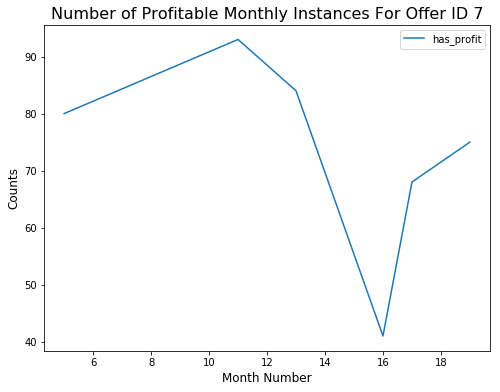

In [5]:
fig, ax = plt.subplots(figsize=(8,6));
monthly_data_7[monthly_data_7['offer_id_7']==1].groupby('month_num').agg({'has_profit':'sum'}).reset_index().plot(x='month_num', y='has_profit', kind='line',ax=ax);
ax.set_title("Number of Profitable Monthly Instances For Offer ID 7", fontsize=16)
ax.set_xlabel("Month Number", fontsize=12);
ax.set_ylabel("Counts", fontsize=12);

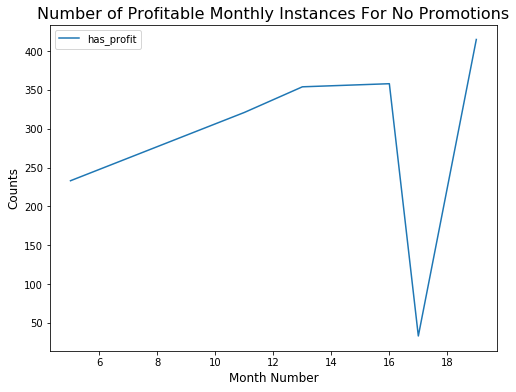

In [12]:
fig, ax = plt.subplots(figsize=(8,6));
monthly_data_7[monthly_data_7['offer_id_7']==0].groupby('month_num').agg({'has_profit':'sum'}).reset_index().plot(x='month_num', y='has_profit', kind='line',ax=ax);
ax.set_title("Number of Profitable Monthly Instances For No Promotions", fontsize=16)
ax.set_xlabel("Month Number", fontsize=12);
ax.set_ylabel("Counts", fontsize=12);

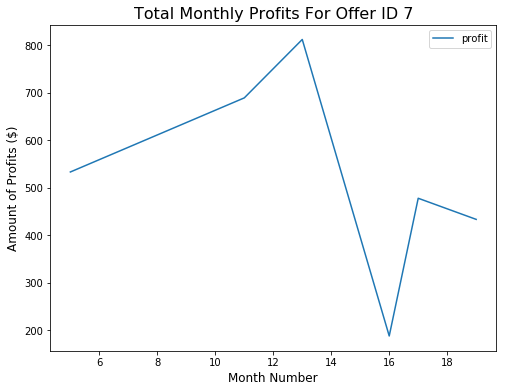

In [13]:
fig, ax = plt.subplots(figsize=(8,6));
monthly_data_7[monthly_data_7['offer_id_7']==1].groupby('month_num').agg({'profit':'sum'}).reset_index().plot(x='month_num', y='profit', kind='line',ax=ax);
ax.set_title("Total Monthly Profits For Offer ID 7", fontsize=16)
ax.set_xlabel("Month Number", fontsize=12);
ax.set_ylabel("Amount of Profits ($)", fontsize=12);

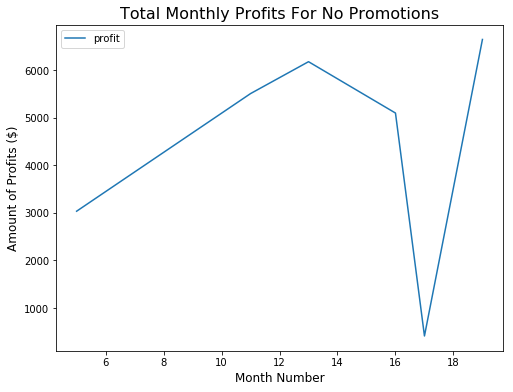

In [14]:
fig, ax = plt.subplots(figsize=(8,6));
monthly_data_7[monthly_data_7['offer_id_7']==0].groupby('month_num').agg({'profit':'sum'}).reset_index().plot(x='month_num', y='profit', kind='line',ax=ax);
ax.set_title("Total Monthly Profits For No Promotions", fontsize=16)
ax.set_xlabel("Month Number", fontsize=12);
ax.set_ylabel("Amount of Profits ($)", fontsize=12);

In [15]:
# use an approximately 70/15/15 split
train_last_month =  15# 14 months
valid_last_month = 17 # 2 months
test_last_month = 19 # 2 months

train_7 = monthly_data_7[monthly_data_7['month_num']<=train_last_month].reset_index(drop=True)
valid_7 = monthly_data_7[(monthly_data_7['month_num']>train_last_month) & (monthly_data_7['month_num']<=valid_last_month)].reset_index(drop=True)
test_7 = monthly_data_7[(monthly_data_7['month_num']>valid_last_month) & (monthly_data_7['month_num']<=test_last_month)].reset_index(drop=True)

## Baseline Model

In [14]:
offer_num = 7

baseline_valid_strat = np.ones(valid_7.shape[0])
valid_irr, valid_nir = test_results(offer_num, baseline_valid_strat, valid_7)
print("Baseline Model Results")
print("Valid IRR:"+str(valid_irr))
print("Valid NIR:"+str(valid_nir))

print()

baseline_test_strat = np.ones(test_7.shape[0])
test_irr, test_nir = test_results(offer_num, baseline_test_strat, test_7)
print("Baseline Model Results")
print("Valid IRR:"+str(test_irr))
print("Valid NIR:"+str(test_nir))

Baseline Model Results
Valid IRR:-0.28844621513944224
Valid NIR:-4842.09

Baseline Model Results
Valid IRR:-0.3338557993730408
Valid NIR:-6207.279999999999


## Model

In [14]:
features = ['month_num', 
            'year_num', 'month_in_year', 'quarter_in_year',
            'cum_monthly_amt_spent_offer_id_0',
           'cum_num_trans_offer_id_0', 'cum_profit_offer_id_0',
           'cum_monthly_amt_spent_offer_id_1', 'cum_num_trans_offer_id_1',
           'cum_profit_offer_id_1', 'cum_monthly_amt_spent_offer_id_2',
           'cum_num_trans_offer_id_2', 'cum_profit_offer_id_2',
           'cum_monthly_amt_spent_offer_id_3', 'cum_num_trans_offer_id_3',
           'cum_profit_offer_id_3', 'cum_monthly_amt_spent_offer_id_4',
           'cum_num_trans_offer_id_4', 'cum_profit_offer_id_4',
           'cum_monthly_amt_spent_offer_id_5', 'cum_num_trans_offer_id_5',
           'cum_profit_offer_id_5', 'cum_monthly_amt_spent_offer_id_6',
           'cum_num_trans_offer_id_6', 'cum_profit_offer_id_6',
           'cum_monthly_amt_spent_offer_id_7', 'cum_num_trans_offer_id_7',
           'cum_profit_offer_id_7', 'cum_monthly_amt_spent_offer_id_8',
           'cum_num_trans_offer_id_8', 'cum_profit_offer_id_8',
           'cum_monthly_amt_spent_offer_id_9', 'cum_num_trans_offer_id_9',
           'cum_profit_offer_id_9', 'cum_monthly_amt_spent_offer_id_10',
           'cum_num_trans_offer_id_10', 'cum_profit_offer_id_10',
           'cum_spent_per_trans_offer_id_0', 'cum_spent_per_trans_offer_id_1',
           'cum_spent_per_trans_offer_id_2', 'cum_spent_per_trans_offer_id_3',
           'cum_spent_per_trans_offer_id_4', 'cum_spent_per_trans_offer_id_5',
           'cum_spent_per_trans_offer_id_6', 'cum_spent_per_trans_offer_id_7',
           'cum_spent_per_trans_offer_id_8', 'cum_spent_per_trans_offer_id_9',
           'cum_spent_per_trans_offer_id_10',
           'cum_profit_per_trans_offer_id_0',
           'cum_profit_per_trans_offer_id_1',
           'cum_profit_per_trans_offer_id_2',
           'cum_profit_per_trans_offer_id_3',
           'cum_profit_per_trans_offer_id_4',
           'cum_profit_per_trans_offer_id_5',
           'cum_profit_per_trans_offer_id_6',
           'cum_profit_per_trans_offer_id_7',
           'cum_profit_per_trans_offer_id_8',
           'cum_profit_per_trans_offer_id_9',
           'cum_profit_per_trans_offer_id_10', 'cum_total_spend',
           'cum_num_trans', 'cum_profit', 'mov_avg_spent_offer_id_0',
           'mov_avg_spent_offer_id_1', 'mov_avg_spent_offer_id_2',
           'mov_avg_spent_offer_id_3', 'mov_avg_spent_offer_id_4',
           'mov_avg_spent_offer_id_5', 'mov_avg_spent_offer_id_6',
           'mov_avg_spent_offer_id_7', 'mov_avg_spent_offer_id_8',
           'mov_avg_spent_offer_id_9', 'mov_avg_spent_offer_id_10',
            'mov_avg_total_spent',
           'mov_avg_num_trans_offer_id_0', 'mov_avg_num_trans_offer_id_1',
           'mov_avg_num_trans_offer_id_2', 'mov_avg_num_trans_offer_id_3',
           'mov_avg_num_trans_offer_id_4', 'mov_avg_num_trans_offer_id_5',
           'mov_avg_num_trans_offer_id_6', 'mov_avg_num_trans_offer_id_7',
           'mov_avg_num_trans_offer_id_8', 'mov_avg_num_trans_offer_id_9',
           'mov_avg_num_trans_offer_id_10', 'mov_avg_total_num_trans',
            'mov_avg_profit_offer_id_0',
           'mov_avg_profit_offer_id_1', 'mov_avg_profit_offer_id_2',
           'mov_avg_profit_offer_id_3', 'mov_avg_profit_offer_id_4',
           'mov_avg_profit_offer_id_5', 'mov_avg_profit_offer_id_6',
           'mov_avg_profit_offer_id_7', 'mov_avg_profit_offer_id_8',
           'mov_avg_profit_offer_id_9', 'mov_avg_profit_offer_id_10',
            'mov_avg_total_profit',
           'cum_monthly_amt_spent_offer_id_0_1_mo_ago',
           'cum_num_trans_offer_id_0_1_mo_ago',
           'cum_profit_offer_id_0_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_1_1_mo_ago',
           'cum_num_trans_offer_id_1_1_mo_ago',
           'cum_profit_offer_id_1_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_2_1_mo_ago',
           'cum_num_trans_offer_id_2_1_mo_ago',
           'cum_profit_offer_id_2_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_3_1_mo_ago',
           'cum_num_trans_offer_id_3_1_mo_ago',
           'cum_profit_offer_id_3_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_4_1_mo_ago',
           'cum_num_trans_offer_id_4_1_mo_ago',
           'cum_profit_offer_id_4_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_5_1_mo_ago',
           'cum_num_trans_offer_id_5_1_mo_ago',
           'cum_profit_offer_id_5_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_6_1_mo_ago',
           'cum_num_trans_offer_id_6_1_mo_ago',
           'cum_profit_offer_id_6_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_7_1_mo_ago',
           'cum_num_trans_offer_id_7_1_mo_ago',
           'cum_profit_offer_id_7_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_8_1_mo_ago',
           'cum_num_trans_offer_id_8_1_mo_ago',
           'cum_profit_offer_id_8_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_9_1_mo_ago',
           'cum_num_trans_offer_id_9_1_mo_ago',
           'cum_profit_offer_id_9_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_10_1_mo_ago',
           'cum_num_trans_offer_id_10_1_mo_ago',
           'cum_profit_offer_id_10_1_mo_ago',
           'cum_spent_per_trans_offer_id_0_1_mo_ago',
           'cum_spent_per_trans_offer_id_1_1_mo_ago',
           'cum_spent_per_trans_offer_id_2_1_mo_ago',
           'cum_spent_per_trans_offer_id_3_1_mo_ago',
           'cum_spent_per_trans_offer_id_4_1_mo_ago',
           'cum_spent_per_trans_offer_id_5_1_mo_ago',
           'cum_spent_per_trans_offer_id_6_1_mo_ago',
           'cum_spent_per_trans_offer_id_7_1_mo_ago',
           'cum_spent_per_trans_offer_id_8_1_mo_ago',
           'cum_spent_per_trans_offer_id_9_1_mo_ago',
           'cum_spent_per_trans_offer_id_10_1_mo_ago',
           'cum_profit_per_trans_offer_id_0_1_mo_ago',
           'cum_profit_per_trans_offer_id_1_1_mo_ago',
           'cum_profit_per_trans_offer_id_2_1_mo_ago',
           'cum_profit_per_trans_offer_id_3_1_mo_ago',
           'cum_profit_per_trans_offer_id_4_1_mo_ago',
           'cum_profit_per_trans_offer_id_5_1_mo_ago',
           'cum_profit_per_trans_offer_id_6_1_mo_ago',
           'cum_profit_per_trans_offer_id_7_1_mo_ago',
           'cum_profit_per_trans_offer_id_8_1_mo_ago',
           'cum_profit_per_trans_offer_id_9_1_mo_ago',
           'cum_profit_per_trans_offer_id_10_1_mo_ago',
           'cum_total_spend_1_mo_ago', 'cum_num_trans_1_mo_ago',
           'cum_profit_1_mo_ago', 'mov_avg_spent_offer_id_0_1_mo_ago',
           'mov_avg_spent_offer_id_1_1_mo_ago',
           'mov_avg_spent_offer_id_2_1_mo_ago',
           'mov_avg_spent_offer_id_3_1_mo_ago',
           'mov_avg_spent_offer_id_4_1_mo_ago',
           'mov_avg_spent_offer_id_5_1_mo_ago',
           'mov_avg_spent_offer_id_6_1_mo_ago',
           'mov_avg_spent_offer_id_7_1_mo_ago',
           'mov_avg_spent_offer_id_8_1_mo_ago',
           'mov_avg_spent_offer_id_9_1_mo_ago',
           'mov_avg_spent_offer_id_10_1_mo_ago',
            'mov_avg_total_spent_1_mo_ago',
           'mov_avg_num_trans_offer_id_0_1_mo_ago',
           'mov_avg_num_trans_offer_id_1_1_mo_ago',
           'mov_avg_num_trans_offer_id_2_1_mo_ago',
           'mov_avg_num_trans_offer_id_3_1_mo_ago',
           'mov_avg_num_trans_offer_id_4_1_mo_ago',
           'mov_avg_num_trans_offer_id_5_1_mo_ago',
           'mov_avg_num_trans_offer_id_6_1_mo_ago',
           'mov_avg_num_trans_offer_id_7_1_mo_ago',
           'mov_avg_num_trans_offer_id_8_1_mo_ago',
           'mov_avg_num_trans_offer_id_9_1_mo_ago',
           'mov_avg_num_trans_offer_id_10_1_mo_ago',
            'mov_avg_total_num_trans_1_mo_ago',
           'mov_avg_profit_offer_id_0_1_mo_ago',
           'mov_avg_profit_offer_id_1_1_mo_ago',
           'mov_avg_profit_offer_id_2_1_mo_ago',
           'mov_avg_profit_offer_id_3_1_mo_ago',
           'mov_avg_profit_offer_id_4_1_mo_ago',
           'mov_avg_profit_offer_id_5_1_mo_ago',
           'mov_avg_profit_offer_id_6_1_mo_ago',
           'mov_avg_profit_offer_id_7_1_mo_ago',
           'mov_avg_profit_offer_id_8_1_mo_ago',
           'mov_avg_profit_offer_id_9_1_mo_ago',
           'mov_avg_profit_offer_id_10_1_mo_ago',
            'mov_avg_total_profit_1_mo_ago',
            'age', 'income',
           'member_year', 'member_month', 'member_day', 'gender_F',
           'gender_M', 'gender_O']

X_train_7 = train_7[features]
X_valid_7 = valid_7[features]
X_test_7 = test_7[features]

Y_train_7 = train_7.has_profit
Y_valid_7 = valid_7.has_profit
Y_test_7 = test_7.has_profit

In [15]:
# Apply feature scaling
ss = StandardScaler()
X_train_scaled_7 = pd.DataFrame(ss.fit_transform(X_train_7))
X_train_scaled_7.columns = features
X_train_scaled_7.index = X_train_7.index
X_train_scaled_7.head()

X_valid_scaled_7 = pd.DataFrame(ss.transform(X_valid_7))
X_valid_scaled_7.columns = features
X_valid_scaled_7.index = X_valid_7.index

X_test_scaled_7 = pd.DataFrame(ss.transform(X_test_7))
X_test_scaled_7.columns = features
X_test_scaled_7.index = X_test_7.index

C:\Users\Josh Lee\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Josh Lee\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


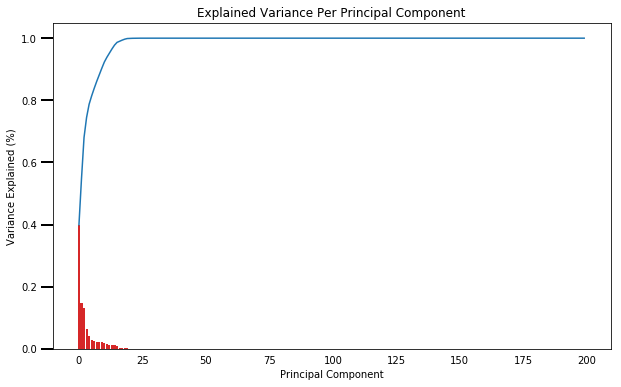

In [16]:
pca, X_train_pca_7 = do_pca(X_train_scaled_7)
scree_plot(pca)

In [17]:
len(features)

200

In [18]:
# 20 components explained most variance
n_components = 20
pca, X_train_pca_7 = do_pca(X_train_scaled_7, n_components=n_components)
X_train_pca_7.head()

,pca_comp_0,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6,pca_comp_7,pca_comp_8,pca_comp_9,pca_comp_10,pca_comp_11,pca_comp_12,pca_comp_13,pca_comp_14,pca_comp_15,pca_comp_16,pca_comp_17,pca_comp_18,pca_comp_19
0,5.930425,-0.665185,-0.304797,2.662601,-2.012996,-0.971588,-1.368385,1.458946,-0.837624,0.915636,-0.880979,0.598418,-0.626919,-0.010598,0.174081,1.406829,-0.043191,0.246115,-0.261368,-0.344931
1,5.930425,-0.665185,-0.304797,2.662601,-2.012996,-0.971588,-1.368385,1.458946,-0.837624,0.915636,-0.880979,0.598418,-0.626919,-0.010598,0.174081,1.406829,-0.043191,0.246115,-0.261368,-0.344931
2,-3.329315,-0.838563,1.882399,1.122095,1.079279,0.673048,-1.011911,-0.492056,0.351432,0.751973,-0.653729,-0.594632,0.913479,0.263773,-0.229684,-0.631407,0.007362,-0.341191,0.241712,0.024071
3,-3.329315,-0.838563,1.882399,1.122095,1.079279,0.673048,-1.011911,-0.492056,0.351432,0.751973,-0.653729,-0.594632,0.913479,0.263773,-0.229684,-0.631407,0.007362,-0.341191,0.241712,0.024071
4,-2.466201,-0.387022,0.717417,1.514917,1.063702,-0.826798,-0.455460,0.342805,-0.245969,0.114215,0.141027,-0.573682,0.459443,0.417285,-0.164358,-0.541951,0.011532,-0.054251,-0.002718,0.174500


In [19]:
# transform valid and test
X_valid_pca_7 = pd.DataFrame(pca.transform(X_valid_scaled_7))
X_valid_pca_7.columns = ["pca_comp_" + str(i) for i in range(n_components)]
X_valid_pca_7.index = X_valid_scaled_7.index

X_test_pca_7 = pd.DataFrame(pca.transform(X_test_scaled_7))
X_test_pca_7.columns = ["pca_comp_" + str(i) for i in range(n_components)]
X_test_pca_7.index = X_test_scaled_7.index

In [21]:
# concat offer ids with X_train, X_valid, X_test
train_ind = train_7['offer_id_7']
valid_ind = valid_7['offer_id_7']
test_ind = test_7['offer_id_7']

X_train_pca_7 = pd.concat([X_train_pca_7, train_ind], axis=1)
X_valid_pca_7 = pd.concat([X_valid_pca_7, valid_ind], axis=1)
X_test_pca_7 = pd.concat([X_test_pca_7, test_ind], axis=1)

In [22]:
# first search to see which parameters to try
max_depth_list = [7]
upsamp_ratio_list = np.arange(0.1, 0.91, 0.1)
min_child_weight_list = np.arange(10, 205, 5)

offer_num = 7

best_depth, best_ratio, best_weight, best_valid_nir, best_test_nir =\
grid_search_indicator_pca(offer_num, max_depth_list, upsamp_ratio_list, min_child_weight_list,\
                          X_train_pca_7, Y_train_7, X_valid_pca_7, Y_valid_7, X_test_pca_7, train_7, valid_7, test_7)

C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1/351, Depth: 7, Ratio: 0.100, Weight: 10, Valid NIR: -82.56, Test NIR: -25.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2/351, Depth: 7, Ratio: 0.100, Weight: 15, Valid NIR: -50.38, Test NIR: -6.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3/351, Depth: 7, Ratio: 0.100, Weight: 20, Valid NIR: -47.72, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4/351, Depth: 7, Ratio: 0.100, Weight: 25, Valid NIR: -237.16, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5/351, Depth: 7, Ratio: 0.100, Weight: 30, Valid NIR: -36.99, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 6/351, Depth: 7, Ratio: 0.100, Weight: 35, Valid NIR: -36.32, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 7/351, Depth: 7, Ratio: 0.100, Weight: 40, Valid NIR: -1.51, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 8/351, Depth: 7, Ratio: 0.100, Weight: 45, Valid NIR: -8.60, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 9/351, Depth: 7, Ratio: 0.100, Weight: 50, Valid NIR: -27.11, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 10/351, Depth: 7, Ratio: 0.100, Weight: 55, Valid NIR: -9.18, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 11/351, Depth: 7, Ratio: 0.100, Weight: 60, Valid NIR: -3.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 12/351, Depth: 7, Ratio: 0.100, Weight: 65, Valid NIR: -13.43, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 13/351, Depth: 7, Ratio: 0.100, Weight: 70, Valid NIR: -16.43, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 14/351, Depth: 7, Ratio: 0.100, Weight: 75, Valid NIR: -6.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 15/351, Depth: 7, Ratio: 0.100, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 16/351, Depth: 7, Ratio: 0.100, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 17/351, Depth: 7, Ratio: 0.100, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 18/351, Depth: 7, Ratio: 0.100, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 19/351, Depth: 7, Ratio: 0.100, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 20/351, Depth: 7, Ratio: 0.100, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 21/351, Depth: 7, Ratio: 0.100, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 22/351, Depth: 7, Ratio: 0.100, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 23/351, Depth: 7, Ratio: 0.100, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 24/351, Depth: 7, Ratio: 0.100, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 25/351, Depth: 7, Ratio: 0.100, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 26/351, Depth: 7, Ratio: 0.100, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 27/351, Depth: 7, Ratio: 0.100, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 28/351, Depth: 7, Ratio: 0.100, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 29/351, Depth: 7, Ratio: 0.100, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 30/351, Depth: 7, Ratio: 0.100, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 31/351, Depth: 7, Ratio: 0.100, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 32/351, Depth: 7, Ratio: 0.100, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 33/351, Depth: 7, Ratio: 0.100, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 34/351, Depth: 7, Ratio: 0.100, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 35/351, Depth: 7, Ratio: 0.100, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 36/351, Depth: 7, Ratio: 0.100, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 37/351, Depth: 7, Ratio: 0.100, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 38/351, Depth: 7, Ratio: 0.100, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 39/351, Depth: 7, Ratio: 0.100, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 40/351, Depth: 7, Ratio: 0.200, Weight: 10, Valid NIR: -399.23, Test NIR: -562.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 41/351, Depth: 7, Ratio: 0.200, Weight: 15, Valid NIR: -147.28, Test NIR: -114.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 42/351, Depth: 7, Ratio: 0.200, Weight: 20, Valid NIR: -250.34, Test NIR: -177.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 43/351, Depth: 7, Ratio: 0.200, Weight: 25, Valid NIR: -1470.72, Test NIR: -2571.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 44/351, Depth: 7, Ratio: 0.200, Weight: 30, Valid NIR: -269.29, Test NIR: -314.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 45/351, Depth: 7, Ratio: 0.200, Weight: 35, Valid NIR: -89.46, Test NIR: -35.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 46/351, Depth: 7, Ratio: 0.200, Weight: 40, Valid NIR: -706.85, Test NIR: -817.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 47/351, Depth: 7, Ratio: 0.200, Weight: 45, Valid NIR: -557.83, Test NIR: -241.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 48/351, Depth: 7, Ratio: 0.200, Weight: 50, Valid NIR: -496.07, Test NIR: -254.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 49/351, Depth: 7, Ratio: 0.200, Weight: 55, Valid NIR: -787.19, Test NIR: -687.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 50/351, Depth: 7, Ratio: 0.200, Weight: 60, Valid NIR: -1211.04, Test NIR: -1827.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 51/351, Depth: 7, Ratio: 0.200, Weight: 65, Valid NIR: -394.63, Test NIR: -328.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 52/351, Depth: 7, Ratio: 0.200, Weight: 70, Valid NIR: -238.09, Test NIR: -78.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 53/351, Depth: 7, Ratio: 0.200, Weight: 75, Valid NIR: -126.12, Test NIR: -155.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 54/351, Depth: 7, Ratio: 0.200, Weight: 80, Valid NIR: -314.86, Test NIR: -28.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 55/351, Depth: 7, Ratio: 0.200, Weight: 85, Valid NIR: -405.01, Test NIR: -245.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 56/351, Depth: 7, Ratio: 0.200, Weight: 90, Valid NIR: -382.78, Test NIR: -366.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 57/351, Depth: 7, Ratio: 0.200, Weight: 95, Valid NIR: -568.54, Test NIR: -1651.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 58/351, Depth: 7, Ratio: 0.200, Weight: 100, Valid NIR: -317.11, Test NIR: -263.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 59/351, Depth: 7, Ratio: 0.200, Weight: 105, Valid NIR: -241.36, Test NIR: -276.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 60/351, Depth: 7, Ratio: 0.200, Weight: 110, Valid NIR: -725.84, Test NIR: -1833.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 61/351, Depth: 7, Ratio: 0.200, Weight: 115, Valid NIR: -166.15, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 62/351, Depth: 7, Ratio: 0.200, Weight: 120, Valid NIR: -199.99, Test NIR: -912.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 63/351, Depth: 7, Ratio: 0.200, Weight: 125, Valid NIR: -98.51, Test NIR: -61.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 64/351, Depth: 7, Ratio: 0.200, Weight: 130, Valid NIR: -77.39, Test NIR: -175.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 65/351, Depth: 7, Ratio: 0.200, Weight: 135, Valid NIR: -35.72, Test NIR: -27.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 66/351, Depth: 7, Ratio: 0.200, Weight: 140, Valid NIR: -636.49, Test NIR: -1352.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 67/351, Depth: 7, Ratio: 0.200, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 68/351, Depth: 7, Ratio: 0.200, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 69/351, Depth: 7, Ratio: 0.200, Weight: 155, Valid NIR: -14.47, Test NIR: -38.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 70/351, Depth: 7, Ratio: 0.200, Weight: 160, Valid NIR: -501.42, Test NIR: -863.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 71/351, Depth: 7, Ratio: 0.200, Weight: 165, Valid NIR: -24.76, Test NIR: -62.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 72/351, Depth: 7, Ratio: 0.200, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 73/351, Depth: 7, Ratio: 0.200, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 74/351, Depth: 7, Ratio: 0.200, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 75/351, Depth: 7, Ratio: 0.200, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 76/351, Depth: 7, Ratio: 0.200, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 77/351, Depth: 7, Ratio: 0.200, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 78/351, Depth: 7, Ratio: 0.200, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 79/351, Depth: 7, Ratio: 0.300, Weight: 10, Valid NIR: -341.38, Test NIR: -358.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 80/351, Depth: 7, Ratio: 0.300, Weight: 15, Valid NIR: -206.57, Test NIR: -42.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 81/351, Depth: 7, Ratio: 0.300, Weight: 20, Valid NIR: -309.23, Test NIR: -501.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 82/351, Depth: 7, Ratio: 0.300, Weight: 25, Valid NIR: -166.36, Test NIR: -513.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 83/351, Depth: 7, Ratio: 0.300, Weight: 30, Valid NIR: -121.89, Test NIR: -27.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 84/351, Depth: 7, Ratio: 0.300, Weight: 35, Valid NIR: -538.57, Test NIR: -626.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 85/351, Depth: 7, Ratio: 0.300, Weight: 40, Valid NIR: -25.19, Test NIR: -16.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 86/351, Depth: 7, Ratio: 0.300, Weight: 45, Valid NIR: -4.44, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 87/351, Depth: 7, Ratio: 0.300, Weight: 50, Valid NIR: -3.94, Test NIR: -13.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 88/351, Depth: 7, Ratio: 0.300, Weight: 55, Valid NIR: -531.96, Test NIR: -640.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 89/351, Depth: 7, Ratio: 0.300, Weight: 60, Valid NIR: -31.10, Test NIR: -5.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 90/351, Depth: 7, Ratio: 0.300, Weight: 65, Valid NIR: -58.28, Test NIR: -16.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 91/351, Depth: 7, Ratio: 0.300, Weight: 70, Valid NIR: -9.97, Test NIR: -19.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 92/351, Depth: 7, Ratio: 0.300, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 93/351, Depth: 7, Ratio: 0.300, Weight: 80, Valid NIR: -15.97, Test NIR: -14.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 94/351, Depth: 7, Ratio: 0.300, Weight: 85, Valid NIR: -889.41, Test NIR: -1377.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 95/351, Depth: 7, Ratio: 0.300, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 96/351, Depth: 7, Ratio: 0.300, Weight: 95, Valid NIR: -623.34, Test NIR: -1289.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 97/351, Depth: 7, Ratio: 0.300, Weight: 100, Valid NIR: -60.68, Test NIR: -16.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 98/351, Depth: 7, Ratio: 0.300, Weight: 105, Valid NIR: -624.19, Test NIR: -783.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 99/351, Depth: 7, Ratio: 0.300, Weight: 110, Valid NIR: -564.53, Test NIR: -740.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 100/351, Depth: 7, Ratio: 0.300, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 101/351, Depth: 7, Ratio: 0.300, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 102/351, Depth: 7, Ratio: 0.300, Weight: 125, Valid NIR: -1531.79, Test NIR: -2603.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 103/351, Depth: 7, Ratio: 0.300, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 104/351, Depth: 7, Ratio: 0.300, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 105/351, Depth: 7, Ratio: 0.300, Weight: 140, Valid NIR: -504.16, Test NIR: -587.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 106/351, Depth: 7, Ratio: 0.300, Weight: 145, Valid NIR: -320.46, Test NIR: -573.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 107/351, Depth: 7, Ratio: 0.300, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 108/351, Depth: 7, Ratio: 0.300, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 109/351, Depth: 7, Ratio: 0.300, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 110/351, Depth: 7, Ratio: 0.300, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 111/351, Depth: 7, Ratio: 0.300, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 112/351, Depth: 7, Ratio: 0.300, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 113/351, Depth: 7, Ratio: 0.300, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 114/351, Depth: 7, Ratio: 0.300, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 115/351, Depth: 7, Ratio: 0.300, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 116/351, Depth: 7, Ratio: 0.300, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 117/351, Depth: 7, Ratio: 0.300, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 118/351, Depth: 7, Ratio: 0.400, Weight: 10, Valid NIR: -378.42, Test NIR: -396.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 119/351, Depth: 7, Ratio: 0.400, Weight: 15, Valid NIR: -963.26, Test NIR: -1436.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 120/351, Depth: 7, Ratio: 0.400, Weight: 20, Valid NIR: -1753.08, Test NIR: -2329.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 121/351, Depth: 7, Ratio: 0.400, Weight: 25, Valid NIR: -1622.84, Test NIR: -2490.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 122/351, Depth: 7, Ratio: 0.400, Weight: 30, Valid NIR: -1670.40, Test NIR: -2159.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 123/351, Depth: 7, Ratio: 0.400, Weight: 35, Valid NIR: -2086.34, Test NIR: -3455.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 124/351, Depth: 7, Ratio: 0.400, Weight: 40, Valid NIR: -2294.05, Test NIR: -3375.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 125/351, Depth: 7, Ratio: 0.400, Weight: 45, Valid NIR: -2432.43, Test NIR: -3725.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 126/351, Depth: 7, Ratio: 0.400, Weight: 50, Valid NIR: -1843.90, Test NIR: -3465.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 127/351, Depth: 7, Ratio: 0.400, Weight: 55, Valid NIR: -1785.98, Test NIR: -3478.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 128/351, Depth: 7, Ratio: 0.400, Weight: 60, Valid NIR: -1599.32, Test NIR: -2867.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 129/351, Depth: 7, Ratio: 0.400, Weight: 65, Valid NIR: -2763.55, Test NIR: -4615.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 130/351, Depth: 7, Ratio: 0.400, Weight: 70, Valid NIR: -1599.32, Test NIR: -2867.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 131/351, Depth: 7, Ratio: 0.400, Weight: 75, Valid NIR: -1599.32, Test NIR: -2867.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 132/351, Depth: 7, Ratio: 0.400, Weight: 80, Valid NIR: -3213.98, Test NIR: -4523.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 133/351, Depth: 7, Ratio: 0.400, Weight: 85, Valid NIR: -2675.41, Test NIR: -4121.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 134/351, Depth: 7, Ratio: 0.400, Weight: 90, Valid NIR: -3758.87, Test NIR: -4656.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 135/351, Depth: 7, Ratio: 0.400, Weight: 95, Valid NIR: -3103.65, Test NIR: -4315.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 136/351, Depth: 7, Ratio: 0.400, Weight: 100, Valid NIR: -2452.92, Test NIR: -3971.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 137/351, Depth: 7, Ratio: 0.400, Weight: 105, Valid NIR: -2432.16, Test NIR: -3419.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 138/351, Depth: 7, Ratio: 0.400, Weight: 110, Valid NIR: -3440.33, Test NIR: -4501.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 139/351, Depth: 7, Ratio: 0.400, Weight: 115, Valid NIR: -2452.92, Test NIR: -3935.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 140/351, Depth: 7, Ratio: 0.400, Weight: 120, Valid NIR: -3415.72, Test NIR: -4444.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 141/351, Depth: 7, Ratio: 0.400, Weight: 125, Valid NIR: -4314.43, Test NIR: -5082.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 142/351, Depth: 7, Ratio: 0.400, Weight: 130, Valid NIR: -3101.12, Test NIR: -3767.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 143/351, Depth: 7, Ratio: 0.400, Weight: 135, Valid NIR: -2798.23, Test NIR: -4097.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 144/351, Depth: 7, Ratio: 0.400, Weight: 140, Valid NIR: -3611.84, Test NIR: -5004.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 145/351, Depth: 7, Ratio: 0.400, Weight: 145, Valid NIR: -3374.12, Test NIR: -4867.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 146/351, Depth: 7, Ratio: 0.400, Weight: 150, Valid NIR: -2203.63, Test NIR: -4257.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 147/351, Depth: 7, Ratio: 0.400, Weight: 155, Valid NIR: -3221.28, Test NIR: -4648.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 148/351, Depth: 7, Ratio: 0.400, Weight: 160, Valid NIR: -2203.63, Test NIR: -4257.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 149/351, Depth: 7, Ratio: 0.400, Weight: 165, Valid NIR: -2203.63, Test NIR: -4257.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 150/351, Depth: 7, Ratio: 0.400, Weight: 170, Valid NIR: -3881.78, Test NIR: -5412.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 151/351, Depth: 7, Ratio: 0.400, Weight: 175, Valid NIR: -2203.63, Test NIR: -4257.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 152/351, Depth: 7, Ratio: 0.400, Weight: 180, Valid NIR: -2203.63, Test NIR: -4257.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 153/351, Depth: 7, Ratio: 0.400, Weight: 185, Valid NIR: -2203.63, Test NIR: -4257.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 154/351, Depth: 7, Ratio: 0.400, Weight: 190, Valid NIR: -2203.63, Test NIR: -4257.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 155/351, Depth: 7, Ratio: 0.400, Weight: 195, Valid NIR: -2203.63, Test NIR: -4257.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 156/351, Depth: 7, Ratio: 0.400, Weight: 200, Valid NIR: -3982.32, Test NIR: -5469.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 157/351, Depth: 7, Ratio: 0.500, Weight: 10, Valid NIR: -2975.68, Test NIR: -3836.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 158/351, Depth: 7, Ratio: 0.500, Weight: 15, Valid NIR: -2021.12, Test NIR: -2032.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 159/351, Depth: 7, Ratio: 0.500, Weight: 20, Valid NIR: -2488.96, Test NIR: -3198.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 160/351, Depth: 7, Ratio: 0.500, Weight: 25, Valid NIR: -3078.32, Test NIR: -4469.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 161/351, Depth: 7, Ratio: 0.500, Weight: 30, Valid NIR: -3319.05, Test NIR: -4307.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 162/351, Depth: 7, Ratio: 0.500, Weight: 35, Valid NIR: -3636.91, Test NIR: -4789.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 163/351, Depth: 7, Ratio: 0.500, Weight: 40, Valid NIR: -3865.46, Test NIR: -4899.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 164/351, Depth: 7, Ratio: 0.500, Weight: 45, Valid NIR: -3798.99, Test NIR: -4738.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 165/351, Depth: 7, Ratio: 0.500, Weight: 50, Valid NIR: -3870.62, Test NIR: -4662.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 166/351, Depth: 7, Ratio: 0.500, Weight: 55, Valid NIR: -3792.03, Test NIR: -4799.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 167/351, Depth: 7, Ratio: 0.500, Weight: 60, Valid NIR: -4051.53, Test NIR: -5214.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 168/351, Depth: 7, Ratio: 0.500, Weight: 65, Valid NIR: -3845.58, Test NIR: -4929.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 169/351, Depth: 7, Ratio: 0.500, Weight: 70, Valid NIR: -4103.27, Test NIR: -4885.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 170/351, Depth: 7, Ratio: 0.500, Weight: 75, Valid NIR: -3523.87, Test NIR: -4742.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 171/351, Depth: 7, Ratio: 0.500, Weight: 80, Valid NIR: -4516.81, Test NIR: -5295.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 172/351, Depth: 7, Ratio: 0.500, Weight: 85, Valid NIR: -4446.48, Test NIR: -5449.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 173/351, Depth: 7, Ratio: 0.500, Weight: 90, Valid NIR: -3740.05, Test NIR: -4409.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 174/351, Depth: 7, Ratio: 0.500, Weight: 95, Valid NIR: -3761.95, Test NIR: -4473.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 175/351, Depth: 7, Ratio: 0.500, Weight: 100, Valid NIR: -3640.36, Test NIR: -4138.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 176/351, Depth: 7, Ratio: 0.500, Weight: 105, Valid NIR: -3944.11, Test NIR: -5102.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 177/351, Depth: 7, Ratio: 0.500, Weight: 110, Valid NIR: -4227.76, Test NIR: -5240.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 178/351, Depth: 7, Ratio: 0.500, Weight: 115, Valid NIR: -4395.10, Test NIR: -5269.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 179/351, Depth: 7, Ratio: 0.500, Weight: 120, Valid NIR: -3857.27, Test NIR: -5052.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 180/351, Depth: 7, Ratio: 0.500, Weight: 125, Valid NIR: -4085.78, Test NIR: -5109.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 181/351, Depth: 7, Ratio: 0.500, Weight: 130, Valid NIR: -4209.05, Test NIR: -6076.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 182/351, Depth: 7, Ratio: 0.500, Weight: 135, Valid NIR: -4446.61, Test NIR: -5910.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 183/351, Depth: 7, Ratio: 0.500, Weight: 140, Valid NIR: -3812.10, Test NIR: -4986.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 184/351, Depth: 7, Ratio: 0.500, Weight: 145, Valid NIR: -3815.21, Test NIR: -4949.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 185/351, Depth: 7, Ratio: 0.500, Weight: 150, Valid NIR: -3815.21, Test NIR: -4898.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 186/351, Depth: 7, Ratio: 0.500, Weight: 155, Valid NIR: -4222.04, Test NIR: -5855.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 187/351, Depth: 7, Ratio: 0.500, Weight: 160, Valid NIR: -4245.45, Test NIR: -5806.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 188/351, Depth: 7, Ratio: 0.500, Weight: 165, Valid NIR: -4248.06, Test NIR: -5864.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 189/351, Depth: 7, Ratio: 0.500, Weight: 170, Valid NIR: -4485.24, Test NIR: -5931.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 190/351, Depth: 7, Ratio: 0.500, Weight: 175, Valid NIR: -4488.92, Test NIR: -5971.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 191/351, Depth: 7, Ratio: 0.500, Weight: 180, Valid NIR: -4488.92, Test NIR: -5993.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 192/351, Depth: 7, Ratio: 0.500, Weight: 185, Valid NIR: -4511.85, Test NIR: -5985.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 193/351, Depth: 7, Ratio: 0.500, Weight: 190, Valid NIR: -4663.75, Test NIR: -6068.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 194/351, Depth: 7, Ratio: 0.500, Weight: 195, Valid NIR: -4604.89, Test NIR: -6111.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 195/351, Depth: 7, Ratio: 0.500, Weight: 200, Valid NIR: -4720.01, Test NIR: -6106.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 196/351, Depth: 7, Ratio: 0.600, Weight: 10, Valid NIR: -3216.62, Test NIR: -3200.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 197/351, Depth: 7, Ratio: 0.600, Weight: 15, Valid NIR: -2895.54, Test NIR: -2589.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 198/351, Depth: 7, Ratio: 0.600, Weight: 20, Valid NIR: -3405.87, Test NIR: -3406.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 199/351, Depth: 7, Ratio: 0.600, Weight: 25, Valid NIR: -3141.60, Test NIR: -4085.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 200/351, Depth: 7, Ratio: 0.600, Weight: 30, Valid NIR: -3573.89, Test NIR: -4347.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 201/351, Depth: 7, Ratio: 0.600, Weight: 35, Valid NIR: -3498.58, Test NIR: -4484.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 202/351, Depth: 7, Ratio: 0.600, Weight: 40, Valid NIR: -3601.33, Test NIR: -5332.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 203/351, Depth: 7, Ratio: 0.600, Weight: 45, Valid NIR: -3925.92, Test NIR: -5383.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 204/351, Depth: 7, Ratio: 0.600, Weight: 50, Valid NIR: -3799.66, Test NIR: -4922.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 205/351, Depth: 7, Ratio: 0.600, Weight: 55, Valid NIR: -3968.86, Test NIR: -5771.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 206/351, Depth: 7, Ratio: 0.600, Weight: 60, Valid NIR: -4132.94, Test NIR: -5570.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 207/351, Depth: 7, Ratio: 0.600, Weight: 65, Valid NIR: -4140.87, Test NIR: -5892.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 208/351, Depth: 7, Ratio: 0.600, Weight: 70, Valid NIR: -4312.22, Test NIR: -5913.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 209/351, Depth: 7, Ratio: 0.600, Weight: 75, Valid NIR: -4443.25, Test NIR: -5920.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 210/351, Depth: 7, Ratio: 0.600, Weight: 80, Valid NIR: -4379.08, Test NIR: -5933.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 211/351, Depth: 7, Ratio: 0.600, Weight: 85, Valid NIR: -4286.99, Test NIR: -5874.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 212/351, Depth: 7, Ratio: 0.600, Weight: 90, Valid NIR: -4587.52, Test NIR: -6105.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 213/351, Depth: 7, Ratio: 0.600, Weight: 95, Valid NIR: -4594.75, Test NIR: -6036.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 214/351, Depth: 7, Ratio: 0.600, Weight: 100, Valid NIR: -4579.73, Test NIR: -6063.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 215/351, Depth: 7, Ratio: 0.600, Weight: 105, Valid NIR: -4467.28, Test NIR: -6020.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 216/351, Depth: 7, Ratio: 0.600, Weight: 110, Valid NIR: -4657.13, Test NIR: -6162.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 217/351, Depth: 7, Ratio: 0.600, Weight: 115, Valid NIR: -4600.18, Test NIR: -6095.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 218/351, Depth: 7, Ratio: 0.600, Weight: 120, Valid NIR: -4345.14, Test NIR: -6004.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 219/351, Depth: 7, Ratio: 0.600, Weight: 125, Valid NIR: -4151.47, Test NIR: -5897.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 220/351, Depth: 7, Ratio: 0.600, Weight: 130, Valid NIR: -4426.50, Test NIR: -6040.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 221/351, Depth: 7, Ratio: 0.600, Weight: 135, Valid NIR: -4446.52, Test NIR: -6032.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 222/351, Depth: 7, Ratio: 0.600, Weight: 140, Valid NIR: -4489.22, Test NIR: -6009.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 223/351, Depth: 7, Ratio: 0.600, Weight: 145, Valid NIR: -4407.48, Test NIR: -5981.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 224/351, Depth: 7, Ratio: 0.600, Weight: 150, Valid NIR: -4569.72, Test NIR: -6130.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 225/351, Depth: 7, Ratio: 0.600, Weight: 155, Valid NIR: -4354.51, Test NIR: -5475.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 226/351, Depth: 7, Ratio: 0.600, Weight: 160, Valid NIR: -4228.42, Test NIR: -5342.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 227/351, Depth: 7, Ratio: 0.600, Weight: 165, Valid NIR: -4489.46, Test NIR: -6012.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 228/351, Depth: 7, Ratio: 0.600, Weight: 170, Valid NIR: -4792.26, Test NIR: -6110.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 229/351, Depth: 7, Ratio: 0.600, Weight: 175, Valid NIR: -4510.34, Test NIR: -6060.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 230/351, Depth: 7, Ratio: 0.600, Weight: 180, Valid NIR: -4139.14, Test NIR: -5344.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 231/351, Depth: 7, Ratio: 0.600, Weight: 185, Valid NIR: -4416.67, Test NIR: -5907.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 232/351, Depth: 7, Ratio: 0.600, Weight: 190, Valid NIR: -4515.82, Test NIR: -6060.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 233/351, Depth: 7, Ratio: 0.600, Weight: 195, Valid NIR: -4783.98, Test NIR: -6164.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 234/351, Depth: 7, Ratio: 0.600, Weight: 200, Valid NIR: -4661.31, Test NIR: -6109.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 235/351, Depth: 7, Ratio: 0.700, Weight: 10, Valid NIR: -2360.89, Test NIR: -3136.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 236/351, Depth: 7, Ratio: 0.700, Weight: 15, Valid NIR: -3423.43, Test NIR: -3454.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 237/351, Depth: 7, Ratio: 0.700, Weight: 20, Valid NIR: -2892.88, Test NIR: -3042.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 238/351, Depth: 7, Ratio: 0.700, Weight: 25, Valid NIR: -3845.48, Test NIR: -4841.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 239/351, Depth: 7, Ratio: 0.700, Weight: 30, Valid NIR: -3966.96, Test NIR: -4955.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 240/351, Depth: 7, Ratio: 0.700, Weight: 35, Valid NIR: -3716.84, Test NIR: -4770.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 241/351, Depth: 7, Ratio: 0.700, Weight: 40, Valid NIR: -3977.37, Test NIR: -5050.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 242/351, Depth: 7, Ratio: 0.700, Weight: 45, Valid NIR: -4174.84, Test NIR: -5639.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 243/351, Depth: 7, Ratio: 0.700, Weight: 50, Valid NIR: -4067.25, Test NIR: -5117.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 244/351, Depth: 7, Ratio: 0.700, Weight: 55, Valid NIR: -4090.99, Test NIR: -5136.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 245/351, Depth: 7, Ratio: 0.700, Weight: 60, Valid NIR: -3804.58, Test NIR: -5076.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 246/351, Depth: 7, Ratio: 0.700, Weight: 65, Valid NIR: -4147.40, Test NIR: -5956.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 247/351, Depth: 7, Ratio: 0.700, Weight: 70, Valid NIR: -4600.36, Test NIR: -6051.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 248/351, Depth: 7, Ratio: 0.700, Weight: 75, Valid NIR: -4528.97, Test NIR: -6045.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 249/351, Depth: 7, Ratio: 0.700, Weight: 80, Valid NIR: -4137.98, Test NIR: -5876.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 250/351, Depth: 7, Ratio: 0.700, Weight: 85, Valid NIR: -4294.43, Test NIR: -5983.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 251/351, Depth: 7, Ratio: 0.700, Weight: 90, Valid NIR: -4374.08, Test NIR: -5999.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 252/351, Depth: 7, Ratio: 0.700, Weight: 95, Valid NIR: -4300.46, Test NIR: -6010.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 253/351, Depth: 7, Ratio: 0.700, Weight: 100, Valid NIR: -4489.70, Test NIR: -6009.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 254/351, Depth: 7, Ratio: 0.700, Weight: 105, Valid NIR: -4395.79, Test NIR: -6075.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 255/351, Depth: 7, Ratio: 0.700, Weight: 110, Valid NIR: -4389.94, Test NIR: -5994.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 256/351, Depth: 7, Ratio: 0.700, Weight: 115, Valid NIR: -4462.26, Test NIR: -6010.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 257/351, Depth: 7, Ratio: 0.700, Weight: 120, Valid NIR: -4671.30, Test NIR: -6149.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 258/351, Depth: 7, Ratio: 0.700, Weight: 125, Valid NIR: -4430.76, Test NIR: -6081.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 259/351, Depth: 7, Ratio: 0.700, Weight: 130, Valid NIR: -4451.18, Test NIR: -6041.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 260/351, Depth: 7, Ratio: 0.700, Weight: 135, Valid NIR: -4578.00, Test NIR: -6130.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 261/351, Depth: 7, Ratio: 0.700, Weight: 140, Valid NIR: -4463.39, Test NIR: -6057.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 262/351, Depth: 7, Ratio: 0.700, Weight: 145, Valid NIR: -4410.35, Test NIR: -6037.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 263/351, Depth: 7, Ratio: 0.700, Weight: 150, Valid NIR: -4659.19, Test NIR: -6139.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 264/351, Depth: 7, Ratio: 0.700, Weight: 155, Valid NIR: -4541.01, Test NIR: -6131.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 265/351, Depth: 7, Ratio: 0.700, Weight: 160, Valid NIR: -4490.49, Test NIR: -6110.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 266/351, Depth: 7, Ratio: 0.700, Weight: 165, Valid NIR: -4450.21, Test NIR: -6114.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 267/351, Depth: 7, Ratio: 0.700, Weight: 170, Valid NIR: -4601.72, Test NIR: -6080.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 268/351, Depth: 7, Ratio: 0.700, Weight: 175, Valid NIR: -4616.46, Test NIR: -6169.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 269/351, Depth: 7, Ratio: 0.700, Weight: 180, Valid NIR: -4696.91, Test NIR: -6190.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 270/351, Depth: 7, Ratio: 0.700, Weight: 185, Valid NIR: -4589.78, Test NIR: -6131.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 271/351, Depth: 7, Ratio: 0.700, Weight: 190, Valid NIR: -4642.68, Test NIR: -6159.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 272/351, Depth: 7, Ratio: 0.700, Weight: 195, Valid NIR: -4696.26, Test NIR: -6141.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 273/351, Depth: 7, Ratio: 0.700, Weight: 200, Valid NIR: -4739.48, Test NIR: -6104.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 274/351, Depth: 7, Ratio: 0.800, Weight: 10, Valid NIR: -1361.20, Test NIR: -1022.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 275/351, Depth: 7, Ratio: 0.800, Weight: 15, Valid NIR: -2829.93, Test NIR: -3038.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 276/351, Depth: 7, Ratio: 0.800, Weight: 20, Valid NIR: -3150.78, Test NIR: -3379.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 277/351, Depth: 7, Ratio: 0.800, Weight: 25, Valid NIR: -3934.76, Test NIR: -5029.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 278/351, Depth: 7, Ratio: 0.800, Weight: 30, Valid NIR: -3913.38, Test NIR: -5307.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 279/351, Depth: 7, Ratio: 0.800, Weight: 35, Valid NIR: -4070.91, Test NIR: -5807.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 280/351, Depth: 7, Ratio: 0.800, Weight: 40, Valid NIR: -4110.68, Test NIR: -5928.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 281/351, Depth: 7, Ratio: 0.800, Weight: 45, Valid NIR: -4049.62, Test NIR: -5186.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 282/351, Depth: 7, Ratio: 0.800, Weight: 50, Valid NIR: -4165.25, Test NIR: -6024.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 283/351, Depth: 7, Ratio: 0.800, Weight: 55, Valid NIR: -4199.70, Test NIR: -5962.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 284/351, Depth: 7, Ratio: 0.800, Weight: 60, Valid NIR: -4180.72, Test NIR: -5899.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 285/351, Depth: 7, Ratio: 0.800, Weight: 65, Valid NIR: -3837.95, Test NIR: -5724.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 286/351, Depth: 7, Ratio: 0.800, Weight: 70, Valid NIR: -4218.25, Test NIR: -6064.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 287/351, Depth: 7, Ratio: 0.800, Weight: 75, Valid NIR: -4155.00, Test NIR: -5884.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 288/351, Depth: 7, Ratio: 0.800, Weight: 80, Valid NIR: -4479.75, Test NIR: -6009.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 289/351, Depth: 7, Ratio: 0.800, Weight: 85, Valid NIR: -4268.37, Test NIR: -5966.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 290/351, Depth: 7, Ratio: 0.800, Weight: 90, Valid NIR: -4312.99, Test NIR: -5999.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 291/351, Depth: 7, Ratio: 0.800, Weight: 95, Valid NIR: -4298.88, Test NIR: -6087.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 292/351, Depth: 7, Ratio: 0.800, Weight: 100, Valid NIR: -4342.27, Test NIR: -6088.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 293/351, Depth: 7, Ratio: 0.800, Weight: 105, Valid NIR: -4298.88, Test NIR: -6100.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 294/351, Depth: 7, Ratio: 0.800, Weight: 110, Valid NIR: -4383.05, Test NIR: -6065.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 295/351, Depth: 7, Ratio: 0.800, Weight: 115, Valid NIR: -4436.76, Test NIR: -6064.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 296/351, Depth: 7, Ratio: 0.800, Weight: 120, Valid NIR: -4442.81, Test NIR: -6069.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 297/351, Depth: 7, Ratio: 0.800, Weight: 125, Valid NIR: -4241.93, Test NIR: -6025.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 298/351, Depth: 7, Ratio: 0.800, Weight: 130, Valid NIR: -4388.24, Test NIR: -6015.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 299/351, Depth: 7, Ratio: 0.800, Weight: 135, Valid NIR: -4466.85, Test NIR: -6048.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 300/351, Depth: 7, Ratio: 0.800, Weight: 140, Valid NIR: -4433.88, Test NIR: -6047.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 301/351, Depth: 7, Ratio: 0.800, Weight: 145, Valid NIR: -4224.17, Test NIR: -5981.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 302/351, Depth: 7, Ratio: 0.800, Weight: 150, Valid NIR: -4255.17, Test NIR: -6020.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 303/351, Depth: 7, Ratio: 0.800, Weight: 155, Valid NIR: -4548.21, Test NIR: -6141.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 304/351, Depth: 7, Ratio: 0.800, Weight: 160, Valid NIR: -4431.10, Test NIR: -6039.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 305/351, Depth: 7, Ratio: 0.800, Weight: 165, Valid NIR: -4312.32, Test NIR: -6039.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 306/351, Depth: 7, Ratio: 0.800, Weight: 170, Valid NIR: -4590.30, Test NIR: -6081.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 307/351, Depth: 7, Ratio: 0.800, Weight: 175, Valid NIR: -4568.03, Test NIR: -6111.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 308/351, Depth: 7, Ratio: 0.800, Weight: 180, Valid NIR: -4588.80, Test NIR: -6111.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 309/351, Depth: 7, Ratio: 0.800, Weight: 185, Valid NIR: -4493.27, Test NIR: -6088.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 310/351, Depth: 7, Ratio: 0.800, Weight: 190, Valid NIR: -4652.26, Test NIR: -6189.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 311/351, Depth: 7, Ratio: 0.800, Weight: 195, Valid NIR: -4785.10, Test NIR: -6190.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 312/351, Depth: 7, Ratio: 0.800, Weight: 200, Valid NIR: -4643.85, Test NIR: -6148.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 313/351, Depth: 7, Ratio: 0.900, Weight: 10, Valid NIR: -2741.44, Test NIR: -2545.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 314/351, Depth: 7, Ratio: 0.900, Weight: 15, Valid NIR: -3277.59, Test NIR: -3424.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 315/351, Depth: 7, Ratio: 0.900, Weight: 20, Valid NIR: -3593.82, Test NIR: -3740.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 316/351, Depth: 7, Ratio: 0.900, Weight: 25, Valid NIR: -3039.48, Test NIR: -3618.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 317/351, Depth: 7, Ratio: 0.900, Weight: 30, Valid NIR: -3598.91, Test NIR: -4689.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 318/351, Depth: 7, Ratio: 0.900, Weight: 35, Valid NIR: -4082.79, Test NIR: -5195.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 319/351, Depth: 7, Ratio: 0.900, Weight: 40, Valid NIR: -3951.91, Test NIR: -5015.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 320/351, Depth: 7, Ratio: 0.900, Weight: 45, Valid NIR: -3823.82, Test NIR: -4859.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 321/351, Depth: 7, Ratio: 0.900, Weight: 50, Valid NIR: -4058.49, Test NIR: -5169.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 322/351, Depth: 7, Ratio: 0.900, Weight: 55, Valid NIR: -4189.24, Test NIR: -5793.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 323/351, Depth: 7, Ratio: 0.900, Weight: 60, Valid NIR: -4167.20, Test NIR: -5742.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 324/351, Depth: 7, Ratio: 0.900, Weight: 65, Valid NIR: -4286.01, Test NIR: -5883.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 325/351, Depth: 7, Ratio: 0.900, Weight: 70, Valid NIR: -4392.37, Test NIR: -5975.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 326/351, Depth: 7, Ratio: 0.900, Weight: 75, Valid NIR: -4479.83, Test NIR: -6008.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 327/351, Depth: 7, Ratio: 0.900, Weight: 80, Valid NIR: -4563.77, Test NIR: -6001.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 328/351, Depth: 7, Ratio: 0.900, Weight: 85, Valid NIR: -4499.55, Test NIR: -5908.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 329/351, Depth: 7, Ratio: 0.900, Weight: 90, Valid NIR: -4507.29, Test NIR: -6066.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 330/351, Depth: 7, Ratio: 0.900, Weight: 95, Valid NIR: -4541.85, Test NIR: -6098.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 331/351, Depth: 7, Ratio: 0.900, Weight: 100, Valid NIR: -4566.48, Test NIR: -6018.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 332/351, Depth: 7, Ratio: 0.900, Weight: 105, Valid NIR: -4488.84, Test NIR: -6051.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 333/351, Depth: 7, Ratio: 0.900, Weight: 110, Valid NIR: -4540.19, Test NIR: -6040.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 334/351, Depth: 7, Ratio: 0.900, Weight: 115, Valid NIR: -4465.44, Test NIR: -6052.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 335/351, Depth: 7, Ratio: 0.900, Weight: 120, Valid NIR: -4669.24, Test NIR: -6071.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 336/351, Depth: 7, Ratio: 0.900, Weight: 125, Valid NIR: -4555.62, Test NIR: -6044.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 337/351, Depth: 7, Ratio: 0.900, Weight: 130, Valid NIR: -4553.57, Test NIR: -6063.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 338/351, Depth: 7, Ratio: 0.900, Weight: 135, Valid NIR: -4476.85, Test NIR: -6031.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 339/351, Depth: 7, Ratio: 0.900, Weight: 140, Valid NIR: -4527.28, Test NIR: -6059.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 340/351, Depth: 7, Ratio: 0.900, Weight: 145, Valid NIR: -4560.34, Test NIR: -6078.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 341/351, Depth: 7, Ratio: 0.900, Weight: 150, Valid NIR: -4541.66, Test NIR: -6124.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 342/351, Depth: 7, Ratio: 0.900, Weight: 155, Valid NIR: -4609.91, Test NIR: -6161.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 343/351, Depth: 7, Ratio: 0.900, Weight: 160, Valid NIR: -4568.34, Test NIR: -6082.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 344/351, Depth: 7, Ratio: 0.900, Weight: 165, Valid NIR: -4621.99, Test NIR: -6125.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 345/351, Depth: 7, Ratio: 0.900, Weight: 170, Valid NIR: -4581.66, Test NIR: -6106.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 346/351, Depth: 7, Ratio: 0.900, Weight: 175, Valid NIR: -4544.58, Test NIR: -6083.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 347/351, Depth: 7, Ratio: 0.900, Weight: 180, Valid NIR: -4598.58, Test NIR: -6147.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 348/351, Depth: 7, Ratio: 0.900, Weight: 185, Valid NIR: -4738.98, Test NIR: -6207.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 349/351, Depth: 7, Ratio: 0.900, Weight: 190, Valid NIR: -4599.28, Test NIR: -6131.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 350/351, Depth: 7, Ratio: 0.900, Weight: 195, Valid NIR: -4703.06, Test NIR: -6189.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 351/351, Depth: 7, Ratio: 0.900, Weight: 200, Valid NIR: -4842.09, Test NIR: -6207.28


In [23]:
print(best_depth)
print(best_ratio)
print(best_weight)
print(best_valid_nir)
print(best_test_nir)

0
0
0
0
0


In [24]:
max_depth_list = [7,8,9]
upsamp_ratio_list = np.arange(0.08, 0.41, 0.01)
min_child_weight_list = np.arange(10, 205, 5)

offer_num = 7

best_depth, best_ratio, best_weight, best_valid_nir, best_test_nir =\
grid_search_indicator_pca(offer_num, max_depth_list, upsamp_ratio_list, min_child_weight_list,\
                          X_train_pca_7, Y_train_7, X_valid_pca_7, Y_valid_7, X_test_pca_7, train_7, valid_7, test_7)

C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1/3861, Depth: 7, Ratio: 0.080, Weight: 10, Valid NIR: -25.13, Test NIR: -34.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2/3861, Depth: 7, Ratio: 0.080, Weight: 15, Valid NIR: -6.12, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3/3861, Depth: 7, Ratio: 0.080, Weight: 20, Valid NIR: -3.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4/3861, Depth: 7, Ratio: 0.080, Weight: 25, Valid NIR: -25.79, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5/3861, Depth: 7, Ratio: 0.080, Weight: 30, Valid NIR: -3.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 6/3861, Depth: 7, Ratio: 0.080, Weight: 35, Valid NIR: -25.53, Test NIR: -7.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 7/3861, Depth: 7, Ratio: 0.080, Weight: 40, Valid NIR: -9.39, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 8/3861, Depth: 7, Ratio: 0.080, Weight: 45, Valid NIR: -3.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 9/3861, Depth: 7, Ratio: 0.080, Weight: 50, Valid NIR: -126.59, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 10/3861, Depth: 7, Ratio: 0.080, Weight: 55, Valid NIR: -3.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 11/3861, Depth: 7, Ratio: 0.080, Weight: 60, Valid NIR: -3.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 12/3861, Depth: 7, Ratio: 0.080, Weight: 65, Valid NIR: -3.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 13/3861, Depth: 7, Ratio: 0.080, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 14/3861, Depth: 7, Ratio: 0.080, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 15/3861, Depth: 7, Ratio: 0.080, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 16/3861, Depth: 7, Ratio: 0.080, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 17/3861, Depth: 7, Ratio: 0.080, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 18/3861, Depth: 7, Ratio: 0.080, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 19/3861, Depth: 7, Ratio: 0.080, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 20/3861, Depth: 7, Ratio: 0.080, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 21/3861, Depth: 7, Ratio: 0.080, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 22/3861, Depth: 7, Ratio: 0.080, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 23/3861, Depth: 7, Ratio: 0.080, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 24/3861, Depth: 7, Ratio: 0.080, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 25/3861, Depth: 7, Ratio: 0.080, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 26/3861, Depth: 7, Ratio: 0.080, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 27/3861, Depth: 7, Ratio: 0.080, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 28/3861, Depth: 7, Ratio: 0.080, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 29/3861, Depth: 7, Ratio: 0.080, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 30/3861, Depth: 7, Ratio: 0.080, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 31/3861, Depth: 7, Ratio: 0.080, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 32/3861, Depth: 7, Ratio: 0.080, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 33/3861, Depth: 7, Ratio: 0.080, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 34/3861, Depth: 7, Ratio: 0.080, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 35/3861, Depth: 7, Ratio: 0.080, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 36/3861, Depth: 7, Ratio: 0.080, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 37/3861, Depth: 7, Ratio: 0.080, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 38/3861, Depth: 7, Ratio: 0.080, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 39/3861, Depth: 7, Ratio: 0.080, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 40/3861, Depth: 7, Ratio: 0.090, Weight: 10, Valid NIR: -65.06, Test NIR: -14.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 41/3861, Depth: 7, Ratio: 0.090, Weight: 15, Valid NIR: -5.96, Test NIR: -15.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 42/3861, Depth: 7, Ratio: 0.090, Weight: 20, Valid NIR: -3.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 43/3861, Depth: 7, Ratio: 0.090, Weight: 25, Valid NIR: -142.33, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 44/3861, Depth: 7, Ratio: 0.090, Weight: 30, Valid NIR: -2.34, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 45/3861, Depth: 7, Ratio: 0.090, Weight: 35, Valid NIR: -47.67, Test NIR: -7.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 46/3861, Depth: 7, Ratio: 0.090, Weight: 40, Valid NIR: -124.79, Test NIR: -13.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 47/3861, Depth: 7, Ratio: 0.090, Weight: 45, Valid NIR: -11.05, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 48/3861, Depth: 7, Ratio: 0.090, Weight: 50, Valid NIR: -126.59, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 49/3861, Depth: 7, Ratio: 0.090, Weight: 55, Valid NIR: -9.39, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 50/3861, Depth: 7, Ratio: 0.090, Weight: 60, Valid NIR: -3.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 51/3861, Depth: 7, Ratio: 0.090, Weight: 65, Valid NIR: -9.39, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 52/3861, Depth: 7, Ratio: 0.090, Weight: 70, Valid NIR: -3.96, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 53/3861, Depth: 7, Ratio: 0.090, Weight: 75, Valid NIR: -1.18, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 54/3861, Depth: 7, Ratio: 0.090, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 55/3861, Depth: 7, Ratio: 0.090, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 56/3861, Depth: 7, Ratio: 0.090, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 57/3861, Depth: 7, Ratio: 0.090, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 58/3861, Depth: 7, Ratio: 0.090, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 59/3861, Depth: 7, Ratio: 0.090, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 60/3861, Depth: 7, Ratio: 0.090, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 61/3861, Depth: 7, Ratio: 0.090, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 62/3861, Depth: 7, Ratio: 0.090, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 63/3861, Depth: 7, Ratio: 0.090, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 64/3861, Depth: 7, Ratio: 0.090, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 65/3861, Depth: 7, Ratio: 0.090, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 66/3861, Depth: 7, Ratio: 0.090, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 67/3861, Depth: 7, Ratio: 0.090, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 68/3861, Depth: 7, Ratio: 0.090, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 69/3861, Depth: 7, Ratio: 0.090, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 70/3861, Depth: 7, Ratio: 0.090, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 71/3861, Depth: 7, Ratio: 0.090, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 72/3861, Depth: 7, Ratio: 0.090, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 73/3861, Depth: 7, Ratio: 0.090, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 74/3861, Depth: 7, Ratio: 0.090, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 75/3861, Depth: 7, Ratio: 0.090, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 76/3861, Depth: 7, Ratio: 0.090, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 77/3861, Depth: 7, Ratio: 0.090, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 78/3861, Depth: 7, Ratio: 0.090, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 79/3861, Depth: 7, Ratio: 0.100, Weight: 10, Valid NIR: -89.82, Test NIR: -15.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 80/3861, Depth: 7, Ratio: 0.100, Weight: 15, Valid NIR: -50.38, Test NIR: -6.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 81/3861, Depth: 7, Ratio: 0.100, Weight: 20, Valid NIR: -47.72, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 82/3861, Depth: 7, Ratio: 0.100, Weight: 25, Valid NIR: -237.16, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 83/3861, Depth: 7, Ratio: 0.100, Weight: 30, Valid NIR: -36.99, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 84/3861, Depth: 7, Ratio: 0.100, Weight: 35, Valid NIR: -36.32, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 85/3861, Depth: 7, Ratio: 0.100, Weight: 40, Valid NIR: -1.51, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 86/3861, Depth: 7, Ratio: 0.100, Weight: 45, Valid NIR: -8.60, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 87/3861, Depth: 7, Ratio: 0.100, Weight: 50, Valid NIR: -27.11, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 88/3861, Depth: 7, Ratio: 0.100, Weight: 55, Valid NIR: -9.18, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 89/3861, Depth: 7, Ratio: 0.100, Weight: 60, Valid NIR: -3.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 90/3861, Depth: 7, Ratio: 0.100, Weight: 65, Valid NIR: -13.43, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 91/3861, Depth: 7, Ratio: 0.100, Weight: 70, Valid NIR: -16.43, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 92/3861, Depth: 7, Ratio: 0.100, Weight: 75, Valid NIR: -6.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 93/3861, Depth: 7, Ratio: 0.100, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 94/3861, Depth: 7, Ratio: 0.100, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 95/3861, Depth: 7, Ratio: 0.100, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 96/3861, Depth: 7, Ratio: 0.100, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 97/3861, Depth: 7, Ratio: 0.100, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 98/3861, Depth: 7, Ratio: 0.100, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 99/3861, Depth: 7, Ratio: 0.100, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 100/3861, Depth: 7, Ratio: 0.100, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 101/3861, Depth: 7, Ratio: 0.100, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 102/3861, Depth: 7, Ratio: 0.100, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 103/3861, Depth: 7, Ratio: 0.100, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 104/3861, Depth: 7, Ratio: 0.100, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 105/3861, Depth: 7, Ratio: 0.100, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 106/3861, Depth: 7, Ratio: 0.100, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 107/3861, Depth: 7, Ratio: 0.100, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 108/3861, Depth: 7, Ratio: 0.100, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 109/3861, Depth: 7, Ratio: 0.100, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 110/3861, Depth: 7, Ratio: 0.100, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 111/3861, Depth: 7, Ratio: 0.100, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 112/3861, Depth: 7, Ratio: 0.100, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 113/3861, Depth: 7, Ratio: 0.100, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 114/3861, Depth: 7, Ratio: 0.100, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 115/3861, Depth: 7, Ratio: 0.100, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 116/3861, Depth: 7, Ratio: 0.100, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 117/3861, Depth: 7, Ratio: 0.100, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 118/3861, Depth: 7, Ratio: 0.110, Weight: 10, Valid NIR: -232.60, Test NIR: -50.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 119/3861, Depth: 7, Ratio: 0.110, Weight: 15, Valid NIR: -88.54, Test NIR: -30.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 120/3861, Depth: 7, Ratio: 0.110, Weight: 20, Valid NIR: -63.51, Test NIR: -1.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 121/3861, Depth: 7, Ratio: 0.110, Weight: 25, Valid NIR: -253.99, Test NIR: -132.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 122/3861, Depth: 7, Ratio: 0.110, Weight: 30, Valid NIR: -153.67, Test NIR: -8.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 123/3861, Depth: 7, Ratio: 0.110, Weight: 35, Valid NIR: -188.44, Test NIR: -101.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 124/3861, Depth: 7, Ratio: 0.110, Weight: 40, Valid NIR: -137.91, Test NIR: -10.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 125/3861, Depth: 7, Ratio: 0.110, Weight: 45, Valid NIR: -118.43, Test NIR: -10.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 126/3861, Depth: 7, Ratio: 0.110, Weight: 50, Valid NIR: -156.95, Test NIR: -15.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 127/3861, Depth: 7, Ratio: 0.110, Weight: 55, Valid NIR: -5.81, Test NIR: -14.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 128/3861, Depth: 7, Ratio: 0.110, Weight: 60, Valid NIR: -5.62, Test NIR: -13.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 129/3861, Depth: 7, Ratio: 0.110, Weight: 65, Valid NIR: -6.15, Test NIR: -36.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 130/3861, Depth: 7, Ratio: 0.110, Weight: 70, Valid NIR: -152.41, Test NIR: -35.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 131/3861, Depth: 7, Ratio: 0.110, Weight: 75, Valid NIR: -131.24, Test NIR: -14.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 132/3861, Depth: 7, Ratio: 0.110, Weight: 80, Valid NIR: -141.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 133/3861, Depth: 7, Ratio: 0.110, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 134/3861, Depth: 7, Ratio: 0.110, Weight: 90, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 135/3861, Depth: 7, Ratio: 0.110, Weight: 95, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 136/3861, Depth: 7, Ratio: 0.110, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 137/3861, Depth: 7, Ratio: 0.110, Weight: 105, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 138/3861, Depth: 7, Ratio: 0.110, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 139/3861, Depth: 7, Ratio: 0.110, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 140/3861, Depth: 7, Ratio: 0.110, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 141/3861, Depth: 7, Ratio: 0.110, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 142/3861, Depth: 7, Ratio: 0.110, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 143/3861, Depth: 7, Ratio: 0.110, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 144/3861, Depth: 7, Ratio: 0.110, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 145/3861, Depth: 7, Ratio: 0.110, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 146/3861, Depth: 7, Ratio: 0.110, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 147/3861, Depth: 7, Ratio: 0.110, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 148/3861, Depth: 7, Ratio: 0.110, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 149/3861, Depth: 7, Ratio: 0.110, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 150/3861, Depth: 7, Ratio: 0.110, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 151/3861, Depth: 7, Ratio: 0.110, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 152/3861, Depth: 7, Ratio: 0.110, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 153/3861, Depth: 7, Ratio: 0.110, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 154/3861, Depth: 7, Ratio: 0.110, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 155/3861, Depth: 7, Ratio: 0.110, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 156/3861, Depth: 7, Ratio: 0.110, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 157/3861, Depth: 7, Ratio: 0.120, Weight: 10, Valid NIR: -277.25, Test NIR: -15.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 158/3861, Depth: 7, Ratio: 0.120, Weight: 15, Valid NIR: -190.29, Test NIR: -6.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 159/3861, Depth: 7, Ratio: 0.120, Weight: 20, Valid NIR: -43.80, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 160/3861, Depth: 7, Ratio: 0.120, Weight: 25, Valid NIR: -217.91, Test NIR: -4.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 161/3861, Depth: 7, Ratio: 0.120, Weight: 30, Valid NIR: -42.54, Test NIR: -5.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 162/3861, Depth: 7, Ratio: 0.120, Weight: 35, Valid NIR: -291.59, Test NIR: -11.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 163/3861, Depth: 7, Ratio: 0.120, Weight: 40, Valid NIR: -22.99, Test NIR: -13.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 164/3861, Depth: 7, Ratio: 0.120, Weight: 45, Valid NIR: -4.96, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 165/3861, Depth: 7, Ratio: 0.120, Weight: 50, Valid NIR: -175.48, Test NIR: -61.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 166/3861, Depth: 7, Ratio: 0.120, Weight: 55, Valid NIR: -15.06, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 167/3861, Depth: 7, Ratio: 0.120, Weight: 60, Valid NIR: -5.62, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 168/3861, Depth: 7, Ratio: 0.120, Weight: 65, Valid NIR: -16.25, Test NIR: -29.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 169/3861, Depth: 7, Ratio: 0.120, Weight: 70, Valid NIR: -149.27, Test NIR: -19.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 170/3861, Depth: 7, Ratio: 0.120, Weight: 75, Valid NIR: -131.24, Test NIR: -14.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 171/3861, Depth: 7, Ratio: 0.120, Weight: 80, Valid NIR: -132.29, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 172/3861, Depth: 7, Ratio: 0.120, Weight: 85, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 173/3861, Depth: 7, Ratio: 0.120, Weight: 90, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 174/3861, Depth: 7, Ratio: 0.120, Weight: 95, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 175/3861, Depth: 7, Ratio: 0.120, Weight: 100, Valid NIR: -118.02, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 176/3861, Depth: 7, Ratio: 0.120, Weight: 105, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 177/3861, Depth: 7, Ratio: 0.120, Weight: 110, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 178/3861, Depth: 7, Ratio: 0.120, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 179/3861, Depth: 7, Ratio: 0.120, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 180/3861, Depth: 7, Ratio: 0.120, Weight: 125, Valid NIR: -1.82, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 181/3861, Depth: 7, Ratio: 0.120, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 182/3861, Depth: 7, Ratio: 0.120, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 183/3861, Depth: 7, Ratio: 0.120, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 184/3861, Depth: 7, Ratio: 0.120, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 185/3861, Depth: 7, Ratio: 0.120, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 186/3861, Depth: 7, Ratio: 0.120, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 187/3861, Depth: 7, Ratio: 0.120, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 188/3861, Depth: 7, Ratio: 0.120, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 189/3861, Depth: 7, Ratio: 0.120, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 190/3861, Depth: 7, Ratio: 0.120, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 191/3861, Depth: 7, Ratio: 0.120, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 192/3861, Depth: 7, Ratio: 0.120, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 193/3861, Depth: 7, Ratio: 0.120, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 194/3861, Depth: 7, Ratio: 0.120, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 195/3861, Depth: 7, Ratio: 0.120, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 196/3861, Depth: 7, Ratio: 0.130, Weight: 10, Valid NIR: -180.93, Test NIR: -142.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 197/3861, Depth: 7, Ratio: 0.130, Weight: 15, Valid NIR: -57.61, Test NIR: -17.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 198/3861, Depth: 7, Ratio: 0.130, Weight: 20, Valid NIR: -26.91, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 199/3861, Depth: 7, Ratio: 0.130, Weight: 25, Valid NIR: -98.95, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 200/3861, Depth: 7, Ratio: 0.130, Weight: 30, Valid NIR: -76.23, Test NIR: -28.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 201/3861, Depth: 7, Ratio: 0.130, Weight: 35, Valid NIR: -94.26, Test NIR: -6.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 202/3861, Depth: 7, Ratio: 0.130, Weight: 40, Valid NIR: -7.12, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 203/3861, Depth: 7, Ratio: 0.130, Weight: 45, Valid NIR: -121.86, Test NIR: 0.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 204/3861, Depth: 7, Ratio: 0.130, Weight: 50, Valid NIR: -198.92, Test NIR: -125.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 205/3861, Depth: 7, Ratio: 0.130, Weight: 55, Valid NIR: -135.94, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 206/3861, Depth: 7, Ratio: 0.130, Weight: 60, Valid NIR: -28.77, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 207/3861, Depth: 7, Ratio: 0.130, Weight: 65, Valid NIR: -138.74, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 208/3861, Depth: 7, Ratio: 0.130, Weight: 70, Valid NIR: -144.36, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 209/3861, Depth: 7, Ratio: 0.130, Weight: 75, Valid NIR: -2.85, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 210/3861, Depth: 7, Ratio: 0.130, Weight: 80, Valid NIR: -148.71, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 211/3861, Depth: 7, Ratio: 0.130, Weight: 85, Valid NIR: -126.41, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 212/3861, Depth: 7, Ratio: 0.130, Weight: 90, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 213/3861, Depth: 7, Ratio: 0.130, Weight: 95, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 214/3861, Depth: 7, Ratio: 0.130, Weight: 100, Valid NIR: 5.43, Test NIR: 0.00
Current Best Depth: 7, Upsampling Ratio: 0.12999999999999998, Min Child Weight: 100
Current Best Valid IRR: 1.00, NIR: 5.4300
Current Best Test IRR: 0.00, NIR: 0.0000


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 215/3861, Depth: 7, Ratio: 0.130, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 216/3861, Depth: 7, Ratio: 0.130, Weight: 110, Valid NIR: -13.87, Test NIR: -1.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 217/3861, Depth: 7, Ratio: 0.130, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 218/3861, Depth: 7, Ratio: 0.130, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 219/3861, Depth: 7, Ratio: 0.130, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 220/3861, Depth: 7, Ratio: 0.130, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 221/3861, Depth: 7, Ratio: 0.130, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 222/3861, Depth: 7, Ratio: 0.130, Weight: 140, Valid NIR: -0.94, Test NIR: -1.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 223/3861, Depth: 7, Ratio: 0.130, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 224/3861, Depth: 7, Ratio: 0.130, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 225/3861, Depth: 7, Ratio: 0.130, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 226/3861, Depth: 7, Ratio: 0.130, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 227/3861, Depth: 7, Ratio: 0.130, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 228/3861, Depth: 7, Ratio: 0.130, Weight: 170, Valid NIR: -2.51, Test NIR: -1.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 229/3861, Depth: 7, Ratio: 0.130, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 230/3861, Depth: 7, Ratio: 0.130, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 231/3861, Depth: 7, Ratio: 0.130, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 232/3861, Depth: 7, Ratio: 0.130, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 233/3861, Depth: 7, Ratio: 0.130, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 234/3861, Depth: 7, Ratio: 0.130, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 235/3861, Depth: 7, Ratio: 0.140, Weight: 10, Valid NIR: -104.23, Test NIR: -20.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 236/3861, Depth: 7, Ratio: 0.140, Weight: 15, Valid NIR: -61.74, Test NIR: -88.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 237/3861, Depth: 7, Ratio: 0.140, Weight: 20, Valid NIR: -29.87, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 238/3861, Depth: 7, Ratio: 0.140, Weight: 25, Valid NIR: -154.33, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 239/3861, Depth: 7, Ratio: 0.140, Weight: 30, Valid NIR: -134.91, Test NIR: -70.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 240/3861, Depth: 7, Ratio: 0.140, Weight: 35, Valid NIR: -60.24, Test NIR: -42.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 241/3861, Depth: 7, Ratio: 0.140, Weight: 40, Valid NIR: -130.99, Test NIR: -14.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 242/3861, Depth: 7, Ratio: 0.140, Weight: 45, Valid NIR: -138.14, Test NIR: -18.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 243/3861, Depth: 7, Ratio: 0.140, Weight: 50, Valid NIR: -409.44, Test NIR: -144.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 244/3861, Depth: 7, Ratio: 0.140, Weight: 55, Valid NIR: -133.32, Test NIR: -14.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 245/3861, Depth: 7, Ratio: 0.140, Weight: 60, Valid NIR: -151.49, Test NIR: -29.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 246/3861, Depth: 7, Ratio: 0.140, Weight: 65, Valid NIR: -7.89, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 247/3861, Depth: 7, Ratio: 0.140, Weight: 70, Valid NIR: -151.02, Test NIR: -24.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 248/3861, Depth: 7, Ratio: 0.140, Weight: 75, Valid NIR: -136.30, Test NIR: -29.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 249/3861, Depth: 7, Ratio: 0.140, Weight: 80, Valid NIR: -152.00, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 250/3861, Depth: 7, Ratio: 0.140, Weight: 85, Valid NIR: -115.73, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 251/3861, Depth: 7, Ratio: 0.140, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 252/3861, Depth: 7, Ratio: 0.140, Weight: 95, Valid NIR: -138.41, Test NIR: -2.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 253/3861, Depth: 7, Ratio: 0.140, Weight: 100, Valid NIR: -115.57, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 254/3861, Depth: 7, Ratio: 0.140, Weight: 105, Valid NIR: -124.56, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 255/3861, Depth: 7, Ratio: 0.140, Weight: 110, Valid NIR: -140.69, Test NIR: -15.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 256/3861, Depth: 7, Ratio: 0.140, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 257/3861, Depth: 7, Ratio: 0.140, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 258/3861, Depth: 7, Ratio: 0.140, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 259/3861, Depth: 7, Ratio: 0.140, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 260/3861, Depth: 7, Ratio: 0.140, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 261/3861, Depth: 7, Ratio: 0.140, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 262/3861, Depth: 7, Ratio: 0.140, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 263/3861, Depth: 7, Ratio: 0.140, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 264/3861, Depth: 7, Ratio: 0.140, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 265/3861, Depth: 7, Ratio: 0.140, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 266/3861, Depth: 7, Ratio: 0.140, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 267/3861, Depth: 7, Ratio: 0.140, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 268/3861, Depth: 7, Ratio: 0.140, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 269/3861, Depth: 7, Ratio: 0.140, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 270/3861, Depth: 7, Ratio: 0.140, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 271/3861, Depth: 7, Ratio: 0.140, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 272/3861, Depth: 7, Ratio: 0.140, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 273/3861, Depth: 7, Ratio: 0.140, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 274/3861, Depth: 7, Ratio: 0.150, Weight: 10, Valid NIR: -591.68, Test NIR: -275.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 275/3861, Depth: 7, Ratio: 0.150, Weight: 15, Valid NIR: -152.75, Test NIR: -27.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 276/3861, Depth: 7, Ratio: 0.150, Weight: 20, Valid NIR: -91.00, Test NIR: -39.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 277/3861, Depth: 7, Ratio: 0.150, Weight: 25, Valid NIR: -459.39, Test NIR: -231.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 278/3861, Depth: 7, Ratio: 0.150, Weight: 30, Valid NIR: -65.36, Test NIR: -7.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 279/3861, Depth: 7, Ratio: 0.150, Weight: 35, Valid NIR: -420.29, Test NIR: -282.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 280/3861, Depth: 7, Ratio: 0.150, Weight: 40, Valid NIR: -153.60, Test NIR: -64.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 281/3861, Depth: 7, Ratio: 0.150, Weight: 45, Valid NIR: -74.08, Test NIR: -87.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 282/3861, Depth: 7, Ratio: 0.150, Weight: 50, Valid NIR: -52.36, Test NIR: -74.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 283/3861, Depth: 7, Ratio: 0.150, Weight: 55, Valid NIR: -181.82, Test NIR: -28.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 284/3861, Depth: 7, Ratio: 0.150, Weight: 60, Valid NIR: -311.38, Test NIR: -138.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 285/3861, Depth: 7, Ratio: 0.150, Weight: 65, Valid NIR: -260.73, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 286/3861, Depth: 7, Ratio: 0.150, Weight: 70, Valid NIR: -138.53, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 287/3861, Depth: 7, Ratio: 0.150, Weight: 75, Valid NIR: -152.06, Test NIR: -181.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 288/3861, Depth: 7, Ratio: 0.150, Weight: 80, Valid NIR: -138.03, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 289/3861, Depth: 7, Ratio: 0.150, Weight: 85, Valid NIR: -152.07, Test NIR: -21.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 290/3861, Depth: 7, Ratio: 0.150, Weight: 90, Valid NIR: -149.31, Test NIR: -110.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 291/3861, Depth: 7, Ratio: 0.150, Weight: 95, Valid NIR: -147.36, Test NIR: -103.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 292/3861, Depth: 7, Ratio: 0.150, Weight: 100, Valid NIR: -147.36, Test NIR: -99.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 293/3861, Depth: 7, Ratio: 0.150, Weight: 105, Valid NIR: -29.41, Test NIR: -21.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 294/3861, Depth: 7, Ratio: 0.150, Weight: 110, Valid NIR: -133.30, Test NIR: -35.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 295/3861, Depth: 7, Ratio: 0.150, Weight: 115, Valid NIR: -9.18, Test NIR: -23.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 296/3861, Depth: 7, Ratio: 0.150, Weight: 120, Valid NIR: -9.18, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 297/3861, Depth: 7, Ratio: 0.150, Weight: 125, Valid NIR: -52.71, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 298/3861, Depth: 7, Ratio: 0.150, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 299/3861, Depth: 7, Ratio: 0.150, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 300/3861, Depth: 7, Ratio: 0.150, Weight: 140, Valid NIR: -44.45, Test NIR: -46.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 301/3861, Depth: 7, Ratio: 0.150, Weight: 145, Valid NIR: 2.84, Test NIR: -23.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 302/3861, Depth: 7, Ratio: 0.150, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 303/3861, Depth: 7, Ratio: 0.150, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 304/3861, Depth: 7, Ratio: 0.150, Weight: 160, Valid NIR: -9.49, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 305/3861, Depth: 7, Ratio: 0.150, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 306/3861, Depth: 7, Ratio: 0.150, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 307/3861, Depth: 7, Ratio: 0.150, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 308/3861, Depth: 7, Ratio: 0.150, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 309/3861, Depth: 7, Ratio: 0.150, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 310/3861, Depth: 7, Ratio: 0.150, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 311/3861, Depth: 7, Ratio: 0.150, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 312/3861, Depth: 7, Ratio: 0.150, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 313/3861, Depth: 7, Ratio: 0.160, Weight: 10, Valid NIR: -904.65, Test NIR: -506.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 314/3861, Depth: 7, Ratio: 0.160, Weight: 15, Valid NIR: -880.52, Test NIR: -220.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 315/3861, Depth: 7, Ratio: 0.160, Weight: 20, Valid NIR: -401.21, Test NIR: -78.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 316/3861, Depth: 7, Ratio: 0.160, Weight: 25, Valid NIR: -615.41, Test NIR: -471.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 317/3861, Depth: 7, Ratio: 0.160, Weight: 30, Valid NIR: -211.56, Test NIR: -62.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 318/3861, Depth: 7, Ratio: 0.160, Weight: 35, Valid NIR: -455.01, Test NIR: -450.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 319/3861, Depth: 7, Ratio: 0.160, Weight: 40, Valid NIR: -492.24, Test NIR: -575.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 320/3861, Depth: 7, Ratio: 0.160, Weight: 45, Valid NIR: -338.72, Test NIR: -437.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 321/3861, Depth: 7, Ratio: 0.160, Weight: 50, Valid NIR: -201.59, Test NIR: -155.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 322/3861, Depth: 7, Ratio: 0.160, Weight: 55, Valid NIR: -325.67, Test NIR: -409.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 323/3861, Depth: 7, Ratio: 0.160, Weight: 60, Valid NIR: -200.71, Test NIR: -81.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 324/3861, Depth: 7, Ratio: 0.160, Weight: 65, Valid NIR: -280.56, Test NIR: -181.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 325/3861, Depth: 7, Ratio: 0.160, Weight: 70, Valid NIR: -269.98, Test NIR: -325.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 326/3861, Depth: 7, Ratio: 0.160, Weight: 75, Valid NIR: -476.34, Test NIR: -611.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 327/3861, Depth: 7, Ratio: 0.160, Weight: 80, Valid NIR: -15.03, Test NIR: -64.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 328/3861, Depth: 7, Ratio: 0.160, Weight: 85, Valid NIR: -357.18, Test NIR: -417.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 329/3861, Depth: 7, Ratio: 0.160, Weight: 90, Valid NIR: -173.15, Test NIR: -182.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 330/3861, Depth: 7, Ratio: 0.160, Weight: 95, Valid NIR: -189.35, Test NIR: -94.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 331/3861, Depth: 7, Ratio: 0.160, Weight: 100, Valid NIR: -39.67, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 332/3861, Depth: 7, Ratio: 0.160, Weight: 105, Valid NIR: -9.49, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 333/3861, Depth: 7, Ratio: 0.160, Weight: 110, Valid NIR: -21.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 334/3861, Depth: 7, Ratio: 0.160, Weight: 115, Valid NIR: -87.76, Test NIR: -125.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 335/3861, Depth: 7, Ratio: 0.160, Weight: 120, Valid NIR: -133.59, Test NIR: -96.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 336/3861, Depth: 7, Ratio: 0.160, Weight: 125, Valid NIR: -115.88, Test NIR: -169.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 337/3861, Depth: 7, Ratio: 0.160, Weight: 130, Valid NIR: -201.95, Test NIR: -292.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 338/3861, Depth: 7, Ratio: 0.160, Weight: 135, Valid NIR: -182.22, Test NIR: -96.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 339/3861, Depth: 7, Ratio: 0.160, Weight: 140, Valid NIR: -269.92, Test NIR: -438.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 340/3861, Depth: 7, Ratio: 0.160, Weight: 145, Valid NIR: -239.62, Test NIR: -439.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 341/3861, Depth: 7, Ratio: 0.160, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 342/3861, Depth: 7, Ratio: 0.160, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 343/3861, Depth: 7, Ratio: 0.160, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 344/3861, Depth: 7, Ratio: 0.160, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 345/3861, Depth: 7, Ratio: 0.160, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 346/3861, Depth: 7, Ratio: 0.160, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 347/3861, Depth: 7, Ratio: 0.160, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 348/3861, Depth: 7, Ratio: 0.160, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 349/3861, Depth: 7, Ratio: 0.160, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 350/3861, Depth: 7, Ratio: 0.160, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 351/3861, Depth: 7, Ratio: 0.160, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 352/3861, Depth: 7, Ratio: 0.170, Weight: 10, Valid NIR: -545.01, Test NIR: -1113.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 353/3861, Depth: 7, Ratio: 0.170, Weight: 15, Valid NIR: -501.21, Test NIR: -1028.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 354/3861, Depth: 7, Ratio: 0.170, Weight: 20, Valid NIR: -679.90, Test NIR: -957.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 355/3861, Depth: 7, Ratio: 0.170, Weight: 25, Valid NIR: -330.79, Test NIR: -464.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 356/3861, Depth: 7, Ratio: 0.170, Weight: 30, Valid NIR: -480.52, Test NIR: -662.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 357/3861, Depth: 7, Ratio: 0.170, Weight: 35, Valid NIR: -123.53, Test NIR: -211.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 358/3861, Depth: 7, Ratio: 0.170, Weight: 40, Valid NIR: -264.23, Test NIR: -679.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 359/3861, Depth: 7, Ratio: 0.170, Weight: 45, Valid NIR: -314.99, Test NIR: -91.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 360/3861, Depth: 7, Ratio: 0.170, Weight: 50, Valid NIR: -508.75, Test NIR: -661.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 361/3861, Depth: 7, Ratio: 0.170, Weight: 55, Valid NIR: -178.51, Test NIR: -185.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 362/3861, Depth: 7, Ratio: 0.170, Weight: 60, Valid NIR: -93.91, Test NIR: -238.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 363/3861, Depth: 7, Ratio: 0.170, Weight: 65, Valid NIR: -152.15, Test NIR: -276.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 364/3861, Depth: 7, Ratio: 0.170, Weight: 70, Valid NIR: -282.22, Test NIR: -68.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 365/3861, Depth: 7, Ratio: 0.170, Weight: 75, Valid NIR: -446.26, Test NIR: -489.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 366/3861, Depth: 7, Ratio: 0.170, Weight: 80, Valid NIR: -540.02, Test NIR: -636.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 367/3861, Depth: 7, Ratio: 0.170, Weight: 85, Valid NIR: -48.17, Test NIR: -15.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 368/3861, Depth: 7, Ratio: 0.170, Weight: 90, Valid NIR: -8.40, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 369/3861, Depth: 7, Ratio: 0.170, Weight: 95, Valid NIR: -29.52, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 370/3861, Depth: 7, Ratio: 0.170, Weight: 100, Valid NIR: -281.08, Test NIR: -411.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 371/3861, Depth: 7, Ratio: 0.170, Weight: 105, Valid NIR: -9.18, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 372/3861, Depth: 7, Ratio: 0.170, Weight: 110, Valid NIR: -50.68, Test NIR: -262.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 373/3861, Depth: 7, Ratio: 0.170, Weight: 115, Valid NIR: -10.68, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 374/3861, Depth: 7, Ratio: 0.170, Weight: 120, Valid NIR: -20.17, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 375/3861, Depth: 7, Ratio: 0.170, Weight: 125, Valid NIR: -5.10, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 376/3861, Depth: 7, Ratio: 0.170, Weight: 130, Valid NIR: -40.17, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 377/3861, Depth: 7, Ratio: 0.170, Weight: 135, Valid NIR: -365.39, Test NIR: -837.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 378/3861, Depth: 7, Ratio: 0.170, Weight: 140, Valid NIR: -673.19, Test NIR: -1432.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 379/3861, Depth: 7, Ratio: 0.170, Weight: 145, Valid NIR: -344.37, Test NIR: -923.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 380/3861, Depth: 7, Ratio: 0.170, Weight: 150, Valid NIR: -388.31, Test NIR: -923.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 381/3861, Depth: 7, Ratio: 0.170, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 382/3861, Depth: 7, Ratio: 0.170, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 383/3861, Depth: 7, Ratio: 0.170, Weight: 165, Valid NIR: -15.03, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 384/3861, Depth: 7, Ratio: 0.170, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 385/3861, Depth: 7, Ratio: 0.170, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 386/3861, Depth: 7, Ratio: 0.170, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 387/3861, Depth: 7, Ratio: 0.170, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 388/3861, Depth: 7, Ratio: 0.170, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 389/3861, Depth: 7, Ratio: 0.170, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 390/3861, Depth: 7, Ratio: 0.170, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 391/3861, Depth: 7, Ratio: 0.180, Weight: 10, Valid NIR: -492.47, Test NIR: -401.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 392/3861, Depth: 7, Ratio: 0.180, Weight: 15, Valid NIR: -689.32, Test NIR: -635.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 393/3861, Depth: 7, Ratio: 0.180, Weight: 20, Valid NIR: -436.82, Test NIR: -405.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 394/3861, Depth: 7, Ratio: 0.180, Weight: 25, Valid NIR: -539.00, Test NIR: -434.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 395/3861, Depth: 7, Ratio: 0.180, Weight: 30, Valid NIR: -378.92, Test NIR: -355.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 396/3861, Depth: 7, Ratio: 0.180, Weight: 35, Valid NIR: -404.47, Test NIR: -156.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 397/3861, Depth: 7, Ratio: 0.180, Weight: 40, Valid NIR: -299.71, Test NIR: -16.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 398/3861, Depth: 7, Ratio: 0.180, Weight: 45, Valid NIR: -298.23, Test NIR: -178.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 399/3861, Depth: 7, Ratio: 0.180, Weight: 50, Valid NIR: -292.88, Test NIR: -121.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 400/3861, Depth: 7, Ratio: 0.180, Weight: 55, Valid NIR: -249.64, Test NIR: -84.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 401/3861, Depth: 7, Ratio: 0.180, Weight: 60, Valid NIR: -175.25, Test NIR: -53.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 402/3861, Depth: 7, Ratio: 0.180, Weight: 65, Valid NIR: -169.52, Test NIR: -91.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 403/3861, Depth: 7, Ratio: 0.180, Weight: 70, Valid NIR: -280.17, Test NIR: -168.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 404/3861, Depth: 7, Ratio: 0.180, Weight: 75, Valid NIR: -298.92, Test NIR: -71.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 405/3861, Depth: 7, Ratio: 0.180, Weight: 80, Valid NIR: -134.14, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 406/3861, Depth: 7, Ratio: 0.180, Weight: 85, Valid NIR: -82.16, Test NIR: -107.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 407/3861, Depth: 7, Ratio: 0.180, Weight: 90, Valid NIR: -194.45, Test NIR: -196.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 408/3861, Depth: 7, Ratio: 0.180, Weight: 95, Valid NIR: -230.01, Test NIR: -182.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 409/3861, Depth: 7, Ratio: 0.180, Weight: 100, Valid NIR: -69.34, Test NIR: -37.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 410/3861, Depth: 7, Ratio: 0.180, Weight: 105, Valid NIR: -462.74, Test NIR: -347.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 411/3861, Depth: 7, Ratio: 0.180, Weight: 110, Valid NIR: -462.74, Test NIR: -347.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 412/3861, Depth: 7, Ratio: 0.180, Weight: 115, Valid NIR: -167.34, Test NIR: -51.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 413/3861, Depth: 7, Ratio: 0.180, Weight: 120, Valid NIR: -119.93, Test NIR: -159.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 414/3861, Depth: 7, Ratio: 0.180, Weight: 125, Valid NIR: -34.43, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 415/3861, Depth: 7, Ratio: 0.180, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 416/3861, Depth: 7, Ratio: 0.180, Weight: 135, Valid NIR: -13.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 417/3861, Depth: 7, Ratio: 0.180, Weight: 140, Valid NIR: -36.76, Test NIR: -45.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 418/3861, Depth: 7, Ratio: 0.180, Weight: 145, Valid NIR: -154.32, Test NIR: -180.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 419/3861, Depth: 7, Ratio: 0.180, Weight: 150, Valid NIR: -535.99, Test NIR: -687.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 420/3861, Depth: 7, Ratio: 0.180, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 421/3861, Depth: 7, Ratio: 0.180, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 422/3861, Depth: 7, Ratio: 0.180, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 423/3861, Depth: 7, Ratio: 0.180, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 424/3861, Depth: 7, Ratio: 0.180, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 425/3861, Depth: 7, Ratio: 0.180, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 426/3861, Depth: 7, Ratio: 0.180, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 427/3861, Depth: 7, Ratio: 0.180, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 428/3861, Depth: 7, Ratio: 0.180, Weight: 195, Valid NIR: -16.20, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 429/3861, Depth: 7, Ratio: 0.180, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 430/3861, Depth: 7, Ratio: 0.190, Weight: 10, Valid NIR: -255.73, Test NIR: -189.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 431/3861, Depth: 7, Ratio: 0.190, Weight: 15, Valid NIR: -242.32, Test NIR: -297.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 432/3861, Depth: 7, Ratio: 0.190, Weight: 20, Valid NIR: -802.66, Test NIR: -1283.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 433/3861, Depth: 7, Ratio: 0.190, Weight: 25, Valid NIR: -967.71, Test NIR: -1706.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 434/3861, Depth: 7, Ratio: 0.190, Weight: 30, Valid NIR: -1043.14, Test NIR: -1596.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 435/3861, Depth: 7, Ratio: 0.190, Weight: 35, Valid NIR: -926.47, Test NIR: -1552.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 436/3861, Depth: 7, Ratio: 0.190, Weight: 40, Valid NIR: -748.83, Test NIR: -1165.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 437/3861, Depth: 7, Ratio: 0.190, Weight: 45, Valid NIR: -1288.19, Test NIR: -1723.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 438/3861, Depth: 7, Ratio: 0.190, Weight: 50, Valid NIR: -968.34, Test NIR: -1973.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 439/3861, Depth: 7, Ratio: 0.190, Weight: 55, Valid NIR: -1074.14, Test NIR: -1526.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 440/3861, Depth: 7, Ratio: 0.190, Weight: 60, Valid NIR: -1072.04, Test NIR: -913.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 441/3861, Depth: 7, Ratio: 0.190, Weight: 65, Valid NIR: -579.98, Test NIR: -444.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 442/3861, Depth: 7, Ratio: 0.190, Weight: 70, Valid NIR: -993.71, Test NIR: -733.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 443/3861, Depth: 7, Ratio: 0.190, Weight: 75, Valid NIR: -905.92, Test NIR: -1020.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 444/3861, Depth: 7, Ratio: 0.190, Weight: 80, Valid NIR: -805.32, Test NIR: -433.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 445/3861, Depth: 7, Ratio: 0.190, Weight: 85, Valid NIR: -979.87, Test NIR: -961.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 446/3861, Depth: 7, Ratio: 0.190, Weight: 90, Valid NIR: -893.69, Test NIR: -469.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 447/3861, Depth: 7, Ratio: 0.190, Weight: 95, Valid NIR: -634.03, Test NIR: -330.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 448/3861, Depth: 7, Ratio: 0.190, Weight: 100, Valid NIR: -718.21, Test NIR: -287.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 449/3861, Depth: 7, Ratio: 0.190, Weight: 105, Valid NIR: -311.05, Test NIR: -261.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 450/3861, Depth: 7, Ratio: 0.190, Weight: 110, Valid NIR: -844.42, Test NIR: -593.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 451/3861, Depth: 7, Ratio: 0.190, Weight: 115, Valid NIR: -237.42, Test NIR: -3.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 452/3861, Depth: 7, Ratio: 0.190, Weight: 120, Valid NIR: -949.88, Test NIR: -737.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 453/3861, Depth: 7, Ratio: 0.190, Weight: 125, Valid NIR: -656.60, Test NIR: -412.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 454/3861, Depth: 7, Ratio: 0.190, Weight: 130, Valid NIR: -227.28, Test NIR: -300.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 455/3861, Depth: 7, Ratio: 0.190, Weight: 135, Valid NIR: -458.51, Test NIR: -488.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 456/3861, Depth: 7, Ratio: 0.190, Weight: 140, Valid NIR: -628.52, Test NIR: -667.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 457/3861, Depth: 7, Ratio: 0.190, Weight: 145, Valid NIR: -191.23, Test NIR: -189.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 458/3861, Depth: 7, Ratio: 0.190, Weight: 150, Valid NIR: -400.80, Test NIR: -552.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 459/3861, Depth: 7, Ratio: 0.190, Weight: 155, Valid NIR: -163.53, Test NIR: -163.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 460/3861, Depth: 7, Ratio: 0.190, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 461/3861, Depth: 7, Ratio: 0.190, Weight: 165, Valid NIR: -252.17, Test NIR: -199.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 462/3861, Depth: 7, Ratio: 0.190, Weight: 170, Valid NIR: -252.17, Test NIR: -199.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 463/3861, Depth: 7, Ratio: 0.190, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 464/3861, Depth: 7, Ratio: 0.190, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 465/3861, Depth: 7, Ratio: 0.190, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 466/3861, Depth: 7, Ratio: 0.190, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 467/3861, Depth: 7, Ratio: 0.190, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 468/3861, Depth: 7, Ratio: 0.190, Weight: 200, Valid NIR: -242.69, Test NIR: -670.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 469/3861, Depth: 7, Ratio: 0.200, Weight: 10, Valid NIR: -610.01, Test NIR: -731.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 470/3861, Depth: 7, Ratio: 0.200, Weight: 15, Valid NIR: -722.69, Test NIR: -499.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 471/3861, Depth: 7, Ratio: 0.200, Weight: 20, Valid NIR: -475.64, Test NIR: -493.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 472/3861, Depth: 7, Ratio: 0.200, Weight: 25, Valid NIR: -315.95, Test NIR: -626.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 473/3861, Depth: 7, Ratio: 0.200, Weight: 30, Valid NIR: -1154.35, Test NIR: -3363.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 474/3861, Depth: 7, Ratio: 0.200, Weight: 35, Valid NIR: -492.88, Test NIR: -595.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 475/3861, Depth: 7, Ratio: 0.200, Weight: 40, Valid NIR: -612.75, Test NIR: -470.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 476/3861, Depth: 7, Ratio: 0.200, Weight: 45, Valid NIR: -435.30, Test NIR: -475.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 477/3861, Depth: 7, Ratio: 0.200, Weight: 50, Valid NIR: -1268.65, Test NIR: -2229.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 478/3861, Depth: 7, Ratio: 0.200, Weight: 55, Valid NIR: -1265.43, Test NIR: -2158.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 479/3861, Depth: 7, Ratio: 0.200, Weight: 60, Valid NIR: -1203.14, Test NIR: -1412.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 480/3861, Depth: 7, Ratio: 0.200, Weight: 65, Valid NIR: -713.56, Test NIR: -743.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 481/3861, Depth: 7, Ratio: 0.200, Weight: 70, Valid NIR: -834.89, Test NIR: -2277.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 482/3861, Depth: 7, Ratio: 0.200, Weight: 75, Valid NIR: -830.10, Test NIR: -2283.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 483/3861, Depth: 7, Ratio: 0.200, Weight: 80, Valid NIR: -361.45, Test NIR: -695.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 484/3861, Depth: 7, Ratio: 0.200, Weight: 85, Valid NIR: -568.99, Test NIR: -2126.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 485/3861, Depth: 7, Ratio: 0.200, Weight: 90, Valid NIR: -643.15, Test NIR: -1303.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 486/3861, Depth: 7, Ratio: 0.200, Weight: 95, Valid NIR: -497.88, Test NIR: -344.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 487/3861, Depth: 7, Ratio: 0.200, Weight: 100, Valid NIR: -760.55, Test NIR: -807.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 488/3861, Depth: 7, Ratio: 0.200, Weight: 105, Valid NIR: -652.83, Test NIR: -1330.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 489/3861, Depth: 7, Ratio: 0.200, Weight: 110, Valid NIR: -247.67, Test NIR: -420.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 490/3861, Depth: 7, Ratio: 0.200, Weight: 115, Valid NIR: -619.28, Test NIR: -1091.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 491/3861, Depth: 7, Ratio: 0.200, Weight: 120, Valid NIR: -218.03, Test NIR: -623.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 492/3861, Depth: 7, Ratio: 0.200, Weight: 125, Valid NIR: -276.16, Test NIR: -224.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 493/3861, Depth: 7, Ratio: 0.200, Weight: 130, Valid NIR: -59.35, Test NIR: -13.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 494/3861, Depth: 7, Ratio: 0.200, Weight: 135, Valid NIR: -258.13, Test NIR: -248.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 495/3861, Depth: 7, Ratio: 0.200, Weight: 140, Valid NIR: -585.55, Test NIR: -1394.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 496/3861, Depth: 7, Ratio: 0.200, Weight: 145, Valid NIR: -474.87, Test NIR: -1382.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 497/3861, Depth: 7, Ratio: 0.200, Weight: 150, Valid NIR: -33.56, Test NIR: -81.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 498/3861, Depth: 7, Ratio: 0.200, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 499/3861, Depth: 7, Ratio: 0.200, Weight: 160, Valid NIR: -20.73, Test NIR: -15.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 500/3861, Depth: 7, Ratio: 0.200, Weight: 165, Valid NIR: 0.00, Test NIR: -12.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 501/3861, Depth: 7, Ratio: 0.200, Weight: 170, Valid NIR: 0.00, Test NIR: -12.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 502/3861, Depth: 7, Ratio: 0.200, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 503/3861, Depth: 7, Ratio: 0.200, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 504/3861, Depth: 7, Ratio: 0.200, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 505/3861, Depth: 7, Ratio: 0.200, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 506/3861, Depth: 7, Ratio: 0.200, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 507/3861, Depth: 7, Ratio: 0.200, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 508/3861, Depth: 7, Ratio: 0.210, Weight: 10, Valid NIR: -700.27, Test NIR: -741.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 509/3861, Depth: 7, Ratio: 0.210, Weight: 15, Valid NIR: -657.15, Test NIR: -483.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 510/3861, Depth: 7, Ratio: 0.210, Weight: 20, Valid NIR: -615.71, Test NIR: -792.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 511/3861, Depth: 7, Ratio: 0.210, Weight: 25, Valid NIR: -625.25, Test NIR: -462.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 512/3861, Depth: 7, Ratio: 0.210, Weight: 30, Valid NIR: -864.77, Test NIR: -1533.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 513/3861, Depth: 7, Ratio: 0.210, Weight: 35, Valid NIR: -166.28, Test NIR: -208.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 514/3861, Depth: 7, Ratio: 0.210, Weight: 40, Valid NIR: -1095.99, Test NIR: -2356.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 515/3861, Depth: 7, Ratio: 0.210, Weight: 45, Valid NIR: -751.00, Test NIR: -898.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 516/3861, Depth: 7, Ratio: 0.210, Weight: 50, Valid NIR: -735.09, Test NIR: -1160.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 517/3861, Depth: 7, Ratio: 0.210, Weight: 55, Valid NIR: -128.86, Test NIR: -85.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 518/3861, Depth: 7, Ratio: 0.210, Weight: 60, Valid NIR: -733.58, Test NIR: -1410.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 519/3861, Depth: 7, Ratio: 0.210, Weight: 65, Valid NIR: -663.03, Test NIR: -1014.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 520/3861, Depth: 7, Ratio: 0.210, Weight: 70, Valid NIR: -357.00, Test NIR: -378.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 521/3861, Depth: 7, Ratio: 0.210, Weight: 75, Valid NIR: -690.37, Test NIR: -1555.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 522/3861, Depth: 7, Ratio: 0.210, Weight: 80, Valid NIR: -776.93, Test NIR: -2371.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 523/3861, Depth: 7, Ratio: 0.210, Weight: 85, Valid NIR: -342.18, Test NIR: -619.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 524/3861, Depth: 7, Ratio: 0.210, Weight: 90, Valid NIR: -189.93, Test NIR: -336.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 525/3861, Depth: 7, Ratio: 0.210, Weight: 95, Valid NIR: -496.34, Test NIR: -426.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 526/3861, Depth: 7, Ratio: 0.210, Weight: 100, Valid NIR: -398.24, Test NIR: -342.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 527/3861, Depth: 7, Ratio: 0.210, Weight: 105, Valid NIR: -282.16, Test NIR: -167.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 528/3861, Depth: 7, Ratio: 0.210, Weight: 110, Valid NIR: -510.65, Test NIR: -523.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 529/3861, Depth: 7, Ratio: 0.210, Weight: 115, Valid NIR: -476.32, Test NIR: -465.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 530/3861, Depth: 7, Ratio: 0.210, Weight: 120, Valid NIR: -298.12, Test NIR: -142.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 531/3861, Depth: 7, Ratio: 0.210, Weight: 125, Valid NIR: -690.69, Test NIR: -702.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 532/3861, Depth: 7, Ratio: 0.210, Weight: 130, Valid NIR: -446.64, Test NIR: -283.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 533/3861, Depth: 7, Ratio: 0.210, Weight: 135, Valid NIR: -799.18, Test NIR: -988.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 534/3861, Depth: 7, Ratio: 0.210, Weight: 140, Valid NIR: -600.89, Test NIR: -872.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 535/3861, Depth: 7, Ratio: 0.210, Weight: 145, Valid NIR: -438.99, Test NIR: -1027.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 536/3861, Depth: 7, Ratio: 0.210, Weight: 150, Valid NIR: -41.17, Test NIR: -91.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 537/3861, Depth: 7, Ratio: 0.210, Weight: 155, Valid NIR: -16.20, Test NIR: -13.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 538/3861, Depth: 7, Ratio: 0.210, Weight: 160, Valid NIR: -168.45, Test NIR: -292.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 539/3861, Depth: 7, Ratio: 0.210, Weight: 165, Valid NIR: -168.45, Test NIR: -292.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 540/3861, Depth: 7, Ratio: 0.210, Weight: 170, Valid NIR: -122.99, Test NIR: -126.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 541/3861, Depth: 7, Ratio: 0.210, Weight: 175, Valid NIR: -246.35, Test NIR: -317.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 542/3861, Depth: 7, Ratio: 0.210, Weight: 180, Valid NIR: -1031.52, Test NIR: -2659.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 543/3861, Depth: 7, Ratio: 0.210, Weight: 185, Valid NIR: -234.18, Test NIR: -273.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 544/3861, Depth: 7, Ratio: 0.210, Weight: 190, Valid NIR: 0.00, Test NIR: -5.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 545/3861, Depth: 7, Ratio: 0.210, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 546/3861, Depth: 7, Ratio: 0.210, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 547/3861, Depth: 7, Ratio: 0.220, Weight: 10, Valid NIR: -468.45, Test NIR: -973.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 548/3861, Depth: 7, Ratio: 0.220, Weight: 15, Valid NIR: -332.99, Test NIR: -315.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 549/3861, Depth: 7, Ratio: 0.220, Weight: 20, Valid NIR: -417.90, Test NIR: -587.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 550/3861, Depth: 7, Ratio: 0.220, Weight: 25, Valid NIR: -456.99, Test NIR: -181.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 551/3861, Depth: 7, Ratio: 0.220, Weight: 30, Valid NIR: -561.61, Test NIR: -1348.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 552/3861, Depth: 7, Ratio: 0.220, Weight: 35, Valid NIR: -421.58, Test NIR: -1046.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 553/3861, Depth: 7, Ratio: 0.220, Weight: 40, Valid NIR: -431.96, Test NIR: -1391.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 554/3861, Depth: 7, Ratio: 0.220, Weight: 45, Valid NIR: -176.84, Test NIR: -397.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 555/3861, Depth: 7, Ratio: 0.220, Weight: 50, Valid NIR: -354.88, Test NIR: -309.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 556/3861, Depth: 7, Ratio: 0.220, Weight: 55, Valid NIR: -353.15, Test NIR: -229.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 557/3861, Depth: 7, Ratio: 0.220, Weight: 60, Valid NIR: -456.56, Test NIR: -520.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 558/3861, Depth: 7, Ratio: 0.220, Weight: 65, Valid NIR: -590.19, Test NIR: -910.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 559/3861, Depth: 7, Ratio: 0.220, Weight: 70, Valid NIR: -376.45, Test NIR: -830.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 560/3861, Depth: 7, Ratio: 0.220, Weight: 75, Valid NIR: -130.89, Test NIR: -80.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 561/3861, Depth: 7, Ratio: 0.220, Weight: 80, Valid NIR: -84.78, Test NIR: -125.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 562/3861, Depth: 7, Ratio: 0.220, Weight: 85, Valid NIR: -94.90, Test NIR: -544.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 563/3861, Depth: 7, Ratio: 0.220, Weight: 90, Valid NIR: -98.73, Test NIR: -64.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 564/3861, Depth: 7, Ratio: 0.220, Weight: 95, Valid NIR: -33.60, Test NIR: -85.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 565/3861, Depth: 7, Ratio: 0.220, Weight: 100, Valid NIR: -488.97, Test NIR: -161.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 566/3861, Depth: 7, Ratio: 0.220, Weight: 105, Valid NIR: -61.01, Test NIR: -73.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 567/3861, Depth: 7, Ratio: 0.220, Weight: 110, Valid NIR: -23.09, Test NIR: -124.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 568/3861, Depth: 7, Ratio: 0.220, Weight: 115, Valid NIR: -308.45, Test NIR: -16.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 569/3861, Depth: 7, Ratio: 0.220, Weight: 120, Valid NIR: -153.30, Test NIR: -677.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 570/3861, Depth: 7, Ratio: 0.220, Weight: 125, Valid NIR: -454.61, Test NIR: -952.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 571/3861, Depth: 7, Ratio: 0.220, Weight: 130, Valid NIR: -372.83, Test NIR: -946.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 572/3861, Depth: 7, Ratio: 0.220, Weight: 135, Valid NIR: -65.29, Test NIR: -287.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 573/3861, Depth: 7, Ratio: 0.220, Weight: 140, Valid NIR: -170.24, Test NIR: -86.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 574/3861, Depth: 7, Ratio: 0.220, Weight: 145, Valid NIR: -144.63, Test NIR: -13.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 575/3861, Depth: 7, Ratio: 0.220, Weight: 150, Valid NIR: -7.14, Test NIR: -9.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 576/3861, Depth: 7, Ratio: 0.220, Weight: 155, Valid NIR: -1.82, Test NIR: -28.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 577/3861, Depth: 7, Ratio: 0.220, Weight: 160, Valid NIR: -7.77, Test NIR: -23.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 578/3861, Depth: 7, Ratio: 0.220, Weight: 165, Valid NIR: 0.00, Test NIR: -36.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 579/3861, Depth: 7, Ratio: 0.220, Weight: 170, Valid NIR: 2.76, Test NIR: -23.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 580/3861, Depth: 7, Ratio: 0.220, Weight: 175, Valid NIR: -1.66, Test NIR: -0.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 581/3861, Depth: 7, Ratio: 0.220, Weight: 180, Valid NIR: 0.00, Test NIR: -105.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 582/3861, Depth: 7, Ratio: 0.220, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 583/3861, Depth: 7, Ratio: 0.220, Weight: 190, Valid NIR: 10.26, Test NIR: -40.25
Current Best Depth: 7, Upsampling Ratio: 0.21999999999999992, Min Child Weight: 190
Current Best Valid IRR: 1.00, NIR: 10.2600
Current Best Test IRR: -1.00, NIR: -40.2500


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 584/3861, Depth: 7, Ratio: 0.220, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 585/3861, Depth: 7, Ratio: 0.220, Weight: 200, Valid NIR: -5.60, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 586/3861, Depth: 7, Ratio: 0.230, Weight: 10, Valid NIR: -292.09, Test NIR: -166.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 587/3861, Depth: 7, Ratio: 0.230, Weight: 15, Valid NIR: -318.62, Test NIR: -482.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 588/3861, Depth: 7, Ratio: 0.230, Weight: 20, Valid NIR: -402.18, Test NIR: -579.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 589/3861, Depth: 7, Ratio: 0.230, Weight: 25, Valid NIR: -419.46, Test NIR: -977.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 590/3861, Depth: 7, Ratio: 0.230, Weight: 30, Valid NIR: -331.72, Test NIR: -35.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 591/3861, Depth: 7, Ratio: 0.230, Weight: 35, Valid NIR: -558.21, Test NIR: -351.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 592/3861, Depth: 7, Ratio: 0.230, Weight: 40, Valid NIR: -330.73, Test NIR: -311.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 593/3861, Depth: 7, Ratio: 0.230, Weight: 45, Valid NIR: -62.89, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 594/3861, Depth: 7, Ratio: 0.230, Weight: 50, Valid NIR: -26.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 595/3861, Depth: 7, Ratio: 0.230, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 596/3861, Depth: 7, Ratio: 0.230, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 597/3861, Depth: 7, Ratio: 0.230, Weight: 65, Valid NIR: -546.97, Test NIR: -297.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 598/3861, Depth: 7, Ratio: 0.230, Weight: 70, Valid NIR: -631.87, Test NIR: -1194.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 599/3861, Depth: 7, Ratio: 0.230, Weight: 75, Valid NIR: -385.77, Test NIR: -216.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 600/3861, Depth: 7, Ratio: 0.230, Weight: 80, Valid NIR: -148.70, Test NIR: -770.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 601/3861, Depth: 7, Ratio: 0.230, Weight: 85, Valid NIR: -351.93, Test NIR: -333.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 602/3861, Depth: 7, Ratio: 0.230, Weight: 90, Valid NIR: -404.17, Test NIR: -166.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 603/3861, Depth: 7, Ratio: 0.230, Weight: 95, Valid NIR: -475.32, Test NIR: -180.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 604/3861, Depth: 7, Ratio: 0.230, Weight: 100, Valid NIR: -231.68, Test NIR: -116.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 605/3861, Depth: 7, Ratio: 0.230, Weight: 105, Valid NIR: -50.71, Test NIR: -724.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 606/3861, Depth: 7, Ratio: 0.230, Weight: 110, Valid NIR: -168.58, Test NIR: -647.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 607/3861, Depth: 7, Ratio: 0.230, Weight: 115, Valid NIR: -208.43, Test NIR: -907.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 608/3861, Depth: 7, Ratio: 0.230, Weight: 120, Valid NIR: -793.70, Test NIR: -1444.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 609/3861, Depth: 7, Ratio: 0.230, Weight: 125, Valid NIR: -271.95, Test NIR: -623.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 610/3861, Depth: 7, Ratio: 0.230, Weight: 130, Valid NIR: -205.89, Test NIR: -819.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 611/3861, Depth: 7, Ratio: 0.230, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 612/3861, Depth: 7, Ratio: 0.230, Weight: 140, Valid NIR: -433.67, Test NIR: -627.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 613/3861, Depth: 7, Ratio: 0.230, Weight: 145, Valid NIR: -821.99, Test NIR: -2702.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 614/3861, Depth: 7, Ratio: 0.230, Weight: 150, Valid NIR: -782.87, Test NIR: -2679.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 615/3861, Depth: 7, Ratio: 0.230, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 616/3861, Depth: 7, Ratio: 0.230, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 617/3861, Depth: 7, Ratio: 0.230, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 618/3861, Depth: 7, Ratio: 0.230, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 619/3861, Depth: 7, Ratio: 0.230, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 620/3861, Depth: 7, Ratio: 0.230, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 621/3861, Depth: 7, Ratio: 0.230, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 622/3861, Depth: 7, Ratio: 0.230, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 623/3861, Depth: 7, Ratio: 0.230, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 624/3861, Depth: 7, Ratio: 0.230, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 625/3861, Depth: 7, Ratio: 0.240, Weight: 10, Valid NIR: -317.80, Test NIR: -232.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 626/3861, Depth: 7, Ratio: 0.240, Weight: 15, Valid NIR: -530.77, Test NIR: -1106.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 627/3861, Depth: 7, Ratio: 0.240, Weight: 20, Valid NIR: -377.64, Test NIR: -516.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 628/3861, Depth: 7, Ratio: 0.240, Weight: 25, Valid NIR: -358.56, Test NIR: -448.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 629/3861, Depth: 7, Ratio: 0.240, Weight: 30, Valid NIR: -192.89, Test NIR: -231.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 630/3861, Depth: 7, Ratio: 0.240, Weight: 35, Valid NIR: -619.96, Test NIR: -382.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 631/3861, Depth: 7, Ratio: 0.240, Weight: 40, Valid NIR: -26.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 632/3861, Depth: 7, Ratio: 0.240, Weight: 45, Valid NIR: -0.67, Test NIR: -8.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 633/3861, Depth: 7, Ratio: 0.240, Weight: 50, Valid NIR: -3.94, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 634/3861, Depth: 7, Ratio: 0.240, Weight: 55, Valid NIR: -89.83, Test NIR: -177.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 635/3861, Depth: 7, Ratio: 0.240, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 636/3861, Depth: 7, Ratio: 0.240, Weight: 65, Valid NIR: 10.06, Test NIR: -53.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 637/3861, Depth: 7, Ratio: 0.240, Weight: 70, Valid NIR: -6.39, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 638/3861, Depth: 7, Ratio: 0.240, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 639/3861, Depth: 7, Ratio: 0.240, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 640/3861, Depth: 7, Ratio: 0.240, Weight: 85, Valid NIR: -692.37, Test NIR: -1111.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 641/3861, Depth: 7, Ratio: 0.240, Weight: 90, Valid NIR: 4.22, Test NIR: -32.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 642/3861, Depth: 7, Ratio: 0.240, Weight: 95, Valid NIR: 4.47, Test NIR: -3.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 643/3861, Depth: 7, Ratio: 0.240, Weight: 100, Valid NIR: -69.65, Test NIR: -1.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 644/3861, Depth: 7, Ratio: 0.240, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 645/3861, Depth: 7, Ratio: 0.240, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 646/3861, Depth: 7, Ratio: 0.240, Weight: 115, Valid NIR: -290.46, Test NIR: -77.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 647/3861, Depth: 7, Ratio: 0.240, Weight: 120, Valid NIR: -89.12, Test NIR: -61.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 648/3861, Depth: 7, Ratio: 0.240, Weight: 125, Valid NIR: -253.00, Test NIR: -80.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 649/3861, Depth: 7, Ratio: 0.240, Weight: 130, Valid NIR: -443.48, Test NIR: -1015.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 650/3861, Depth: 7, Ratio: 0.240, Weight: 135, Valid NIR: -249.09, Test NIR: -1252.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 651/3861, Depth: 7, Ratio: 0.240, Weight: 140, Valid NIR: -156.26, Test NIR: -999.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 652/3861, Depth: 7, Ratio: 0.240, Weight: 145, Valid NIR: -295.98, Test NIR: -286.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 653/3861, Depth: 7, Ratio: 0.240, Weight: 150, Valid NIR: -188.02, Test NIR: -46.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 654/3861, Depth: 7, Ratio: 0.240, Weight: 155, Valid NIR: -138.01, Test NIR: -422.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 655/3861, Depth: 7, Ratio: 0.240, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 656/3861, Depth: 7, Ratio: 0.240, Weight: 165, Valid NIR: -47.72, Test NIR: -68.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 657/3861, Depth: 7, Ratio: 0.240, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 658/3861, Depth: 7, Ratio: 0.240, Weight: 175, Valid NIR: -89.47, Test NIR: -68.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 659/3861, Depth: 7, Ratio: 0.240, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 660/3861, Depth: 7, Ratio: 0.240, Weight: 185, Valid NIR: -294.86, Test NIR: -186.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 661/3861, Depth: 7, Ratio: 0.240, Weight: 190, Valid NIR: -103.86, Test NIR: -3.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 662/3861, Depth: 7, Ratio: 0.240, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 663/3861, Depth: 7, Ratio: 0.240, Weight: 200, Valid NIR: -28.62, Test NIR: -41.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 664/3861, Depth: 7, Ratio: 0.250, Weight: 10, Valid NIR: -29.74, Test NIR: -637.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 665/3861, Depth: 7, Ratio: 0.250, Weight: 15, Valid NIR: 17.13, Test NIR: -856.38
Current Best Depth: 7, Upsampling Ratio: 0.24999999999999994, Min Child Weight: 15
Current Best Valid IRR: -0.08, NIR: 17.1300
Current Best Test IRR: -0.49, NIR: -856.3800


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 666/3861, Depth: 7, Ratio: 0.250, Weight: 20, Valid NIR: -123.94, Test NIR: -745.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 667/3861, Depth: 7, Ratio: 0.250, Weight: 25, Valid NIR: -140.78, Test NIR: -172.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 668/3861, Depth: 7, Ratio: 0.250, Weight: 30, Valid NIR: -209.42, Test NIR: -136.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 669/3861, Depth: 7, Ratio: 0.250, Weight: 35, Valid NIR: -108.27, Test NIR: -88.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 670/3861, Depth: 7, Ratio: 0.250, Weight: 40, Valid NIR: -36.21, Test NIR: -13.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 671/3861, Depth: 7, Ratio: 0.250, Weight: 45, Valid NIR: -68.19, Test NIR: -33.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 672/3861, Depth: 7, Ratio: 0.250, Weight: 50, Valid NIR: -394.54, Test NIR: -229.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 673/3861, Depth: 7, Ratio: 0.250, Weight: 55, Valid NIR: -72.77, Test NIR: -48.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 674/3861, Depth: 7, Ratio: 0.250, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 675/3861, Depth: 7, Ratio: 0.250, Weight: 65, Valid NIR: -366.82, Test NIR: -171.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 676/3861, Depth: 7, Ratio: 0.250, Weight: 70, Valid NIR: -233.03, Test NIR: -331.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 677/3861, Depth: 7, Ratio: 0.250, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 678/3861, Depth: 7, Ratio: 0.250, Weight: 80, Valid NIR: -73.87, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 679/3861, Depth: 7, Ratio: 0.250, Weight: 85, Valid NIR: -584.26, Test NIR: -692.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 680/3861, Depth: 7, Ratio: 0.250, Weight: 90, Valid NIR: -141.31, Test NIR: -41.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 681/3861, Depth: 7, Ratio: 0.250, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 682/3861, Depth: 7, Ratio: 0.250, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 683/3861, Depth: 7, Ratio: 0.250, Weight: 105, Valid NIR: -81.37, Test NIR: -86.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 684/3861, Depth: 7, Ratio: 0.250, Weight: 110, Valid NIR: -407.57, Test NIR: -165.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 685/3861, Depth: 7, Ratio: 0.250, Weight: 115, Valid NIR: -547.70, Test NIR: -893.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 686/3861, Depth: 7, Ratio: 0.250, Weight: 120, Valid NIR: -22.70, Test NIR: -5.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 687/3861, Depth: 7, Ratio: 0.250, Weight: 125, Valid NIR: -0.94, Test NIR: -1.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 688/3861, Depth: 7, Ratio: 0.250, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 689/3861, Depth: 7, Ratio: 0.250, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 690/3861, Depth: 7, Ratio: 0.250, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 691/3861, Depth: 7, Ratio: 0.250, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 692/3861, Depth: 7, Ratio: 0.250, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 693/3861, Depth: 7, Ratio: 0.250, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 694/3861, Depth: 7, Ratio: 0.250, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 695/3861, Depth: 7, Ratio: 0.250, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 696/3861, Depth: 7, Ratio: 0.250, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 697/3861, Depth: 7, Ratio: 0.250, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 698/3861, Depth: 7, Ratio: 0.250, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 699/3861, Depth: 7, Ratio: 0.250, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 700/3861, Depth: 7, Ratio: 0.250, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 701/3861, Depth: 7, Ratio: 0.250, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 702/3861, Depth: 7, Ratio: 0.250, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 703/3861, Depth: 7, Ratio: 0.260, Weight: 10, Valid NIR: -498.51, Test NIR: -546.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 704/3861, Depth: 7, Ratio: 0.260, Weight: 15, Valid NIR: 0.83, Test NIR: -51.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 705/3861, Depth: 7, Ratio: 0.260, Weight: 20, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 706/3861, Depth: 7, Ratio: 0.260, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 707/3861, Depth: 7, Ratio: 0.260, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 708/3861, Depth: 7, Ratio: 0.260, Weight: 35, Valid NIR: -110.31, Test NIR: -25.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 709/3861, Depth: 7, Ratio: 0.260, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 710/3861, Depth: 7, Ratio: 0.260, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 711/3861, Depth: 7, Ratio: 0.260, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 712/3861, Depth: 7, Ratio: 0.260, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 713/3861, Depth: 7, Ratio: 0.260, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 714/3861, Depth: 7, Ratio: 0.260, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 715/3861, Depth: 7, Ratio: 0.260, Weight: 70, Valid NIR: -10.73, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 716/3861, Depth: 7, Ratio: 0.260, Weight: 75, Valid NIR: -13.26, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 717/3861, Depth: 7, Ratio: 0.260, Weight: 80, Valid NIR: -13.26, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 718/3861, Depth: 7, Ratio: 0.260, Weight: 85, Valid NIR: -410.73, Test NIR: -228.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 719/3861, Depth: 7, Ratio: 0.260, Weight: 90, Valid NIR: -724.58, Test NIR: -605.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 720/3861, Depth: 7, Ratio: 0.260, Weight: 95, Valid NIR: -13.26, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 721/3861, Depth: 7, Ratio: 0.260, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 722/3861, Depth: 7, Ratio: 0.260, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 723/3861, Depth: 7, Ratio: 0.260, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 724/3861, Depth: 7, Ratio: 0.260, Weight: 115, Valid NIR: -22.70, Test NIR: -5.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 725/3861, Depth: 7, Ratio: 0.260, Weight: 120, Valid NIR: -2.51, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 726/3861, Depth: 7, Ratio: 0.260, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 727/3861, Depth: 7, Ratio: 0.260, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 728/3861, Depth: 7, Ratio: 0.260, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 729/3861, Depth: 7, Ratio: 0.260, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 730/3861, Depth: 7, Ratio: 0.260, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 731/3861, Depth: 7, Ratio: 0.260, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 732/3861, Depth: 7, Ratio: 0.260, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 733/3861, Depth: 7, Ratio: 0.260, Weight: 160, Valid NIR: -1179.80, Test NIR: -1461.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 734/3861, Depth: 7, Ratio: 0.260, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 735/3861, Depth: 7, Ratio: 0.260, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 736/3861, Depth: 7, Ratio: 0.260, Weight: 175, Valid NIR: -1223.19, Test NIR: -1877.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 737/3861, Depth: 7, Ratio: 0.260, Weight: 180, Valid NIR: -1287.60, Test NIR: -1785.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 738/3861, Depth: 7, Ratio: 0.260, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 739/3861, Depth: 7, Ratio: 0.260, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 740/3861, Depth: 7, Ratio: 0.260, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 741/3861, Depth: 7, Ratio: 0.260, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 742/3861, Depth: 7, Ratio: 0.270, Weight: 10, Valid NIR: -148.58, Test NIR: -270.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 743/3861, Depth: 7, Ratio: 0.270, Weight: 15, Valid NIR: -414.24, Test NIR: -472.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 744/3861, Depth: 7, Ratio: 0.270, Weight: 20, Valid NIR: -114.64, Test NIR: -101.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 745/3861, Depth: 7, Ratio: 0.270, Weight: 25, Valid NIR: -111.22, Test NIR: -49.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 746/3861, Depth: 7, Ratio: 0.270, Weight: 30, Valid NIR: -176.48, Test NIR: -107.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 747/3861, Depth: 7, Ratio: 0.270, Weight: 35, Valid NIR: -402.51, Test NIR: -722.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 748/3861, Depth: 7, Ratio: 0.270, Weight: 40, Valid NIR: -53.69, Test NIR: -16.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 749/3861, Depth: 7, Ratio: 0.270, Weight: 45, Valid NIR: -11.76, Test NIR: -15.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 750/3861, Depth: 7, Ratio: 0.270, Weight: 50, Valid NIR: -17.50, Test NIR: -15.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 751/3861, Depth: 7, Ratio: 0.270, Weight: 55, Valid NIR: -27.42, Test NIR: -16.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 752/3861, Depth: 7, Ratio: 0.270, Weight: 60, Valid NIR: -27.42, Test NIR: -16.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 753/3861, Depth: 7, Ratio: 0.270, Weight: 65, Valid NIR: -27.42, Test NIR: -16.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 754/3861, Depth: 7, Ratio: 0.270, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 755/3861, Depth: 7, Ratio: 0.270, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 756/3861, Depth: 7, Ratio: 0.270, Weight: 80, Valid NIR: -13.42, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 757/3861, Depth: 7, Ratio: 0.270, Weight: 85, Valid NIR: -49.00, Test NIR: -0.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 758/3861, Depth: 7, Ratio: 0.270, Weight: 90, Valid NIR: -20.45, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 759/3861, Depth: 7, Ratio: 0.270, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 760/3861, Depth: 7, Ratio: 0.270, Weight: 100, Valid NIR: -556.32, Test NIR: -243.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 761/3861, Depth: 7, Ratio: 0.270, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 762/3861, Depth: 7, Ratio: 0.270, Weight: 110, Valid NIR: -41.65, Test NIR: -14.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 763/3861, Depth: 7, Ratio: 0.270, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 764/3861, Depth: 7, Ratio: 0.270, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 765/3861, Depth: 7, Ratio: 0.270, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 766/3861, Depth: 7, Ratio: 0.270, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 767/3861, Depth: 7, Ratio: 0.270, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 768/3861, Depth: 7, Ratio: 0.270, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 769/3861, Depth: 7, Ratio: 0.270, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 770/3861, Depth: 7, Ratio: 0.270, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 771/3861, Depth: 7, Ratio: 0.270, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 772/3861, Depth: 7, Ratio: 0.270, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 773/3861, Depth: 7, Ratio: 0.270, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 774/3861, Depth: 7, Ratio: 0.270, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 775/3861, Depth: 7, Ratio: 0.270, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 776/3861, Depth: 7, Ratio: 0.270, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 777/3861, Depth: 7, Ratio: 0.270, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 778/3861, Depth: 7, Ratio: 0.270, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 779/3861, Depth: 7, Ratio: 0.270, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 780/3861, Depth: 7, Ratio: 0.270, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 781/3861, Depth: 7, Ratio: 0.280, Weight: 10, Valid NIR: -143.55, Test NIR: -123.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 782/3861, Depth: 7, Ratio: 0.280, Weight: 15, Valid NIR: -345.48, Test NIR: -134.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 783/3861, Depth: 7, Ratio: 0.280, Weight: 20, Valid NIR: -69.91, Test NIR: -36.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 784/3861, Depth: 7, Ratio: 0.280, Weight: 25, Valid NIR: -133.21, Test NIR: -122.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 785/3861, Depth: 7, Ratio: 0.280, Weight: 30, Valid NIR: -36.78, Test NIR: -44.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 786/3861, Depth: 7, Ratio: 0.280, Weight: 35, Valid NIR: -21.29, Test NIR: -8.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 787/3861, Depth: 7, Ratio: 0.280, Weight: 40, Valid NIR: -121.68, Test NIR: -11.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 788/3861, Depth: 7, Ratio: 0.280, Weight: 45, Valid NIR: -113.46, Test NIR: -84.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 789/3861, Depth: 7, Ratio: 0.280, Weight: 50, Valid NIR: 0.00, Test NIR: -6.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 790/3861, Depth: 7, Ratio: 0.280, Weight: 55, Valid NIR: -162.84, Test NIR: -124.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 791/3861, Depth: 7, Ratio: 0.280, Weight: 60, Valid NIR: 0.00, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 792/3861, Depth: 7, Ratio: 0.280, Weight: 65, Valid NIR: 0.00, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 793/3861, Depth: 7, Ratio: 0.280, Weight: 70, Valid NIR: 0.00, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 794/3861, Depth: 7, Ratio: 0.280, Weight: 75, Valid NIR: 0.28, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 795/3861, Depth: 7, Ratio: 0.280, Weight: 80, Valid NIR: -607.96, Test NIR: -519.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 796/3861, Depth: 7, Ratio: 0.280, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 797/3861, Depth: 7, Ratio: 0.280, Weight: 90, Valid NIR: -464.12, Test NIR: -541.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 798/3861, Depth: 7, Ratio: 0.280, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 799/3861, Depth: 7, Ratio: 0.280, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 800/3861, Depth: 7, Ratio: 0.280, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 801/3861, Depth: 7, Ratio: 0.280, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 802/3861, Depth: 7, Ratio: 0.280, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 803/3861, Depth: 7, Ratio: 0.280, Weight: 120, Valid NIR: -59.20, Test NIR: -64.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 804/3861, Depth: 7, Ratio: 0.280, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 805/3861, Depth: 7, Ratio: 0.280, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 806/3861, Depth: 7, Ratio: 0.280, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 807/3861, Depth: 7, Ratio: 0.280, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 808/3861, Depth: 7, Ratio: 0.280, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 809/3861, Depth: 7, Ratio: 0.280, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 810/3861, Depth: 7, Ratio: 0.280, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 811/3861, Depth: 7, Ratio: 0.280, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 812/3861, Depth: 7, Ratio: 0.280, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 813/3861, Depth: 7, Ratio: 0.280, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 814/3861, Depth: 7, Ratio: 0.280, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 815/3861, Depth: 7, Ratio: 0.280, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 816/3861, Depth: 7, Ratio: 0.280, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 817/3861, Depth: 7, Ratio: 0.280, Weight: 190, Valid NIR: -598.82, Test NIR: -215.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 818/3861, Depth: 7, Ratio: 0.280, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 819/3861, Depth: 7, Ratio: 0.280, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 820/3861, Depth: 7, Ratio: 0.290, Weight: 10, Valid NIR: -62.49, Test NIR: -40.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 821/3861, Depth: 7, Ratio: 0.290, Weight: 15, Valid NIR: -246.93, Test NIR: -374.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 822/3861, Depth: 7, Ratio: 0.290, Weight: 20, Valid NIR: -337.12, Test NIR: -807.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 823/3861, Depth: 7, Ratio: 0.290, Weight: 25, Valid NIR: -10.82, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 824/3861, Depth: 7, Ratio: 0.290, Weight: 30, Valid NIR: -79.73, Test NIR: -47.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 825/3861, Depth: 7, Ratio: 0.290, Weight: 35, Valid NIR: -209.82, Test NIR: -39.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 826/3861, Depth: 7, Ratio: 0.290, Weight: 40, Valid NIR: -14.88, Test NIR: -7.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 827/3861, Depth: 7, Ratio: 0.290, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 828/3861, Depth: 7, Ratio: 0.290, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 829/3861, Depth: 7, Ratio: 0.290, Weight: 55, Valid NIR: -303.58, Test NIR: -75.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 830/3861, Depth: 7, Ratio: 0.290, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 831/3861, Depth: 7, Ratio: 0.290, Weight: 65, Valid NIR: -539.02, Test NIR: -626.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 832/3861, Depth: 7, Ratio: 0.290, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 833/3861, Depth: 7, Ratio: 0.290, Weight: 75, Valid NIR: -475.57, Test NIR: -449.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 834/3861, Depth: 7, Ratio: 0.290, Weight: 80, Valid NIR: -1147.85, Test NIR: -799.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 835/3861, Depth: 7, Ratio: 0.290, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 836/3861, Depth: 7, Ratio: 0.290, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 837/3861, Depth: 7, Ratio: 0.290, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 838/3861, Depth: 7, Ratio: 0.290, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 839/3861, Depth: 7, Ratio: 0.290, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 840/3861, Depth: 7, Ratio: 0.290, Weight: 110, Valid NIR: -59.93, Test NIR: -27.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 841/3861, Depth: 7, Ratio: 0.290, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 842/3861, Depth: 7, Ratio: 0.290, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 843/3861, Depth: 7, Ratio: 0.290, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 844/3861, Depth: 7, Ratio: 0.290, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 845/3861, Depth: 7, Ratio: 0.290, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 846/3861, Depth: 7, Ratio: 0.290, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 847/3861, Depth: 7, Ratio: 0.290, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 848/3861, Depth: 7, Ratio: 0.290, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 849/3861, Depth: 7, Ratio: 0.290, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 850/3861, Depth: 7, Ratio: 0.290, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 851/3861, Depth: 7, Ratio: 0.290, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 852/3861, Depth: 7, Ratio: 0.290, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 853/3861, Depth: 7, Ratio: 0.290, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 854/3861, Depth: 7, Ratio: 0.290, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 855/3861, Depth: 7, Ratio: 0.290, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 856/3861, Depth: 7, Ratio: 0.290, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 857/3861, Depth: 7, Ratio: 0.290, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 858/3861, Depth: 7, Ratio: 0.290, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 859/3861, Depth: 7, Ratio: 0.300, Weight: 10, Valid NIR: -341.38, Test NIR: -358.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 860/3861, Depth: 7, Ratio: 0.300, Weight: 15, Valid NIR: -206.57, Test NIR: -42.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 861/3861, Depth: 7, Ratio: 0.300, Weight: 20, Valid NIR: -309.23, Test NIR: -501.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 862/3861, Depth: 7, Ratio: 0.300, Weight: 25, Valid NIR: -166.36, Test NIR: -513.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 863/3861, Depth: 7, Ratio: 0.300, Weight: 30, Valid NIR: -121.89, Test NIR: -27.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 864/3861, Depth: 7, Ratio: 0.300, Weight: 35, Valid NIR: -538.57, Test NIR: -626.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 865/3861, Depth: 7, Ratio: 0.300, Weight: 40, Valid NIR: -25.19, Test NIR: -16.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 866/3861, Depth: 7, Ratio: 0.300, Weight: 45, Valid NIR: -4.44, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 867/3861, Depth: 7, Ratio: 0.300, Weight: 50, Valid NIR: -3.94, Test NIR: -13.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 868/3861, Depth: 7, Ratio: 0.300, Weight: 55, Valid NIR: -531.96, Test NIR: -640.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 869/3861, Depth: 7, Ratio: 0.300, Weight: 60, Valid NIR: -31.10, Test NIR: -5.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 870/3861, Depth: 7, Ratio: 0.300, Weight: 65, Valid NIR: -58.28, Test NIR: -16.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 871/3861, Depth: 7, Ratio: 0.300, Weight: 70, Valid NIR: -9.97, Test NIR: -19.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 872/3861, Depth: 7, Ratio: 0.300, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 873/3861, Depth: 7, Ratio: 0.300, Weight: 80, Valid NIR: -15.97, Test NIR: -14.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 874/3861, Depth: 7, Ratio: 0.300, Weight: 85, Valid NIR: -889.41, Test NIR: -1377.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 875/3861, Depth: 7, Ratio: 0.300, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 876/3861, Depth: 7, Ratio: 0.300, Weight: 95, Valid NIR: -623.34, Test NIR: -1289.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 877/3861, Depth: 7, Ratio: 0.300, Weight: 100, Valid NIR: -60.68, Test NIR: -16.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 878/3861, Depth: 7, Ratio: 0.300, Weight: 105, Valid NIR: -624.19, Test NIR: -783.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 879/3861, Depth: 7, Ratio: 0.300, Weight: 110, Valid NIR: -564.53, Test NIR: -740.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 880/3861, Depth: 7, Ratio: 0.300, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 881/3861, Depth: 7, Ratio: 0.300, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 882/3861, Depth: 7, Ratio: 0.300, Weight: 125, Valid NIR: -1531.79, Test NIR: -2603.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 883/3861, Depth: 7, Ratio: 0.300, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 884/3861, Depth: 7, Ratio: 0.300, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 885/3861, Depth: 7, Ratio: 0.300, Weight: 140, Valid NIR: -504.16, Test NIR: -587.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 886/3861, Depth: 7, Ratio: 0.300, Weight: 145, Valid NIR: -320.46, Test NIR: -573.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 887/3861, Depth: 7, Ratio: 0.300, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 888/3861, Depth: 7, Ratio: 0.300, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 889/3861, Depth: 7, Ratio: 0.300, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 890/3861, Depth: 7, Ratio: 0.300, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 891/3861, Depth: 7, Ratio: 0.300, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 892/3861, Depth: 7, Ratio: 0.300, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 893/3861, Depth: 7, Ratio: 0.300, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 894/3861, Depth: 7, Ratio: 0.300, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 895/3861, Depth: 7, Ratio: 0.300, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 896/3861, Depth: 7, Ratio: 0.300, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 897/3861, Depth: 7, Ratio: 0.300, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 898/3861, Depth: 7, Ratio: 0.310, Weight: 10, Valid NIR: -75.27, Test NIR: -105.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 899/3861, Depth: 7, Ratio: 0.310, Weight: 15, Valid NIR: -54.81, Test NIR: -39.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 900/3861, Depth: 7, Ratio: 0.310, Weight: 20, Valid NIR: -403.44, Test NIR: -410.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 901/3861, Depth: 7, Ratio: 0.310, Weight: 25, Valid NIR: -16.27, Test NIR: -18.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 902/3861, Depth: 7, Ratio: 0.310, Weight: 30, Valid NIR: -474.37, Test NIR: -496.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 903/3861, Depth: 7, Ratio: 0.310, Weight: 35, Valid NIR: -3.35, Test NIR: -10.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 904/3861, Depth: 7, Ratio: 0.310, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 905/3861, Depth: 7, Ratio: 0.310, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 906/3861, Depth: 7, Ratio: 0.310, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 907/3861, Depth: 7, Ratio: 0.310, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 908/3861, Depth: 7, Ratio: 0.310, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 909/3861, Depth: 7, Ratio: 0.310, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 910/3861, Depth: 7, Ratio: 0.310, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 911/3861, Depth: 7, Ratio: 0.310, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 912/3861, Depth: 7, Ratio: 0.310, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 913/3861, Depth: 7, Ratio: 0.310, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 914/3861, Depth: 7, Ratio: 0.310, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 915/3861, Depth: 7, Ratio: 0.310, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 916/3861, Depth: 7, Ratio: 0.310, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 917/3861, Depth: 7, Ratio: 0.310, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 918/3861, Depth: 7, Ratio: 0.310, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 919/3861, Depth: 7, Ratio: 0.310, Weight: 115, Valid NIR: 0.45, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 920/3861, Depth: 7, Ratio: 0.310, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 921/3861, Depth: 7, Ratio: 0.310, Weight: 125, Valid NIR: -1402.06, Test NIR: -1068.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 922/3861, Depth: 7, Ratio: 0.310, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 923/3861, Depth: 7, Ratio: 0.310, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 924/3861, Depth: 7, Ratio: 0.310, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 925/3861, Depth: 7, Ratio: 0.310, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 926/3861, Depth: 7, Ratio: 0.310, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 927/3861, Depth: 7, Ratio: 0.310, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 928/3861, Depth: 7, Ratio: 0.310, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 929/3861, Depth: 7, Ratio: 0.310, Weight: 165, Valid NIR: -1193.91, Test NIR: -752.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 930/3861, Depth: 7, Ratio: 0.310, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 931/3861, Depth: 7, Ratio: 0.310, Weight: 175, Valid NIR: -763.10, Test NIR: -1331.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 932/3861, Depth: 7, Ratio: 0.310, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 933/3861, Depth: 7, Ratio: 0.310, Weight: 185, Valid NIR: -1590.43, Test NIR: -2419.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 934/3861, Depth: 7, Ratio: 0.310, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 935/3861, Depth: 7, Ratio: 0.310, Weight: 195, Valid NIR: -1875.72, Test NIR: -2801.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 936/3861, Depth: 7, Ratio: 0.310, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 937/3861, Depth: 7, Ratio: 0.320, Weight: 10, Valid NIR: -286.41, Test NIR: -507.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 938/3861, Depth: 7, Ratio: 0.320, Weight: 15, Valid NIR: -450.70, Test NIR: -612.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 939/3861, Depth: 7, Ratio: 0.320, Weight: 20, Valid NIR: -102.97, Test NIR: -48.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 940/3861, Depth: 7, Ratio: 0.320, Weight: 25, Valid NIR: -78.60, Test NIR: -85.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 941/3861, Depth: 7, Ratio: 0.320, Weight: 30, Valid NIR: -342.37, Test NIR: -790.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 942/3861, Depth: 7, Ratio: 0.320, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 943/3861, Depth: 7, Ratio: 0.320, Weight: 40, Valid NIR: -11.91, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 944/3861, Depth: 7, Ratio: 0.320, Weight: 45, Valid NIR: -39.61, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 945/3861, Depth: 7, Ratio: 0.320, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 946/3861, Depth: 7, Ratio: 0.320, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 947/3861, Depth: 7, Ratio: 0.320, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 948/3861, Depth: 7, Ratio: 0.320, Weight: 65, Valid NIR: -675.97, Test NIR: -748.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 949/3861, Depth: 7, Ratio: 0.320, Weight: 70, Valid NIR: -11.91, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 950/3861, Depth: 7, Ratio: 0.320, Weight: 75, Valid NIR: -1200.73, Test NIR: -2506.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 951/3861, Depth: 7, Ratio: 0.320, Weight: 80, Valid NIR: -1599.12, Test NIR: -2791.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 952/3861, Depth: 7, Ratio: 0.320, Weight: 85, Valid NIR: -1368.54, Test NIR: -1130.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 953/3861, Depth: 7, Ratio: 0.320, Weight: 90, Valid NIR: -2066.60, Test NIR: -1738.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 954/3861, Depth: 7, Ratio: 0.320, Weight: 95, Valid NIR: -1574.86, Test NIR: -1135.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 955/3861, Depth: 7, Ratio: 0.320, Weight: 100, Valid NIR: -1278.42, Test NIR: -1173.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 956/3861, Depth: 7, Ratio: 0.320, Weight: 105, Valid NIR: -1743.82, Test NIR: -1240.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 957/3861, Depth: 7, Ratio: 0.320, Weight: 110, Valid NIR: -75.55, Test NIR: -32.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 958/3861, Depth: 7, Ratio: 0.320, Weight: 115, Valid NIR: -69.13, Test NIR: -16.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 959/3861, Depth: 7, Ratio: 0.320, Weight: 120, Valid NIR: -75.55, Test NIR: -32.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 960/3861, Depth: 7, Ratio: 0.320, Weight: 125, Valid NIR: -931.71, Test NIR: -411.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 961/3861, Depth: 7, Ratio: 0.320, Weight: 130, Valid NIR: -75.55, Test NIR: -32.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 962/3861, Depth: 7, Ratio: 0.320, Weight: 135, Valid NIR: -1809.56, Test NIR: -1206.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 963/3861, Depth: 7, Ratio: 0.320, Weight: 140, Valid NIR: -1694.18, Test NIR: -1146.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 964/3861, Depth: 7, Ratio: 0.320, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 965/3861, Depth: 7, Ratio: 0.320, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 966/3861, Depth: 7, Ratio: 0.320, Weight: 155, Valid NIR: -115.38, Test NIR: -60.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 967/3861, Depth: 7, Ratio: 0.320, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 968/3861, Depth: 7, Ratio: 0.320, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 969/3861, Depth: 7, Ratio: 0.320, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 970/3861, Depth: 7, Ratio: 0.320, Weight: 175, Valid NIR: -1387.19, Test NIR: -1801.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 971/3861, Depth: 7, Ratio: 0.320, Weight: 180, Valid NIR: -1387.19, Test NIR: -1801.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 972/3861, Depth: 7, Ratio: 0.320, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 973/3861, Depth: 7, Ratio: 0.320, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 974/3861, Depth: 7, Ratio: 0.320, Weight: 195, Valid NIR: -2524.08, Test NIR: -1781.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 975/3861, Depth: 7, Ratio: 0.320, Weight: 200, Valid NIR: -2524.08, Test NIR: -1781.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 976/3861, Depth: 7, Ratio: 0.330, Weight: 10, Valid NIR: -970.31, Test NIR: -942.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 977/3861, Depth: 7, Ratio: 0.330, Weight: 15, Valid NIR: -548.29, Test NIR: -1000.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 978/3861, Depth: 7, Ratio: 0.330, Weight: 20, Valid NIR: -266.78, Test NIR: -191.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 979/3861, Depth: 7, Ratio: 0.330, Weight: 25, Valid NIR: -896.38, Test NIR: -924.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 980/3861, Depth: 7, Ratio: 0.330, Weight: 30, Valid NIR: -1603.89, Test NIR: -1633.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 981/3861, Depth: 7, Ratio: 0.330, Weight: 35, Valid NIR: -1027.68, Test NIR: -2223.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 982/3861, Depth: 7, Ratio: 0.330, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 983/3861, Depth: 7, Ratio: 0.330, Weight: 45, Valid NIR: -471.71, Test NIR: -530.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 984/3861, Depth: 7, Ratio: 0.330, Weight: 50, Valid NIR: -613.54, Test NIR: -1428.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 985/3861, Depth: 7, Ratio: 0.330, Weight: 55, Valid NIR: -860.87, Test NIR: -1281.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 986/3861, Depth: 7, Ratio: 0.330, Weight: 60, Valid NIR: -71.48, Test NIR: -19.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 987/3861, Depth: 7, Ratio: 0.330, Weight: 65, Valid NIR: -809.18, Test NIR: -734.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 988/3861, Depth: 7, Ratio: 0.330, Weight: 70, Valid NIR: -490.66, Test NIR: -1717.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 989/3861, Depth: 7, Ratio: 0.330, Weight: 75, Valid NIR: -695.29, Test NIR: -1058.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 990/3861, Depth: 7, Ratio: 0.330, Weight: 80, Valid NIR: -100.48, Test NIR: -133.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 991/3861, Depth: 7, Ratio: 0.330, Weight: 85, Valid NIR: -58.50, Test NIR: -16.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 992/3861, Depth: 7, Ratio: 0.330, Weight: 90, Valid NIR: -1459.95, Test NIR: -1050.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 993/3861, Depth: 7, Ratio: 0.330, Weight: 95, Valid NIR: -1429.43, Test NIR: -1137.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 994/3861, Depth: 7, Ratio: 0.330, Weight: 100, Valid NIR: -1426.40, Test NIR: -1070.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 995/3861, Depth: 7, Ratio: 0.330, Weight: 105, Valid NIR: -1615.87, Test NIR: -3381.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 996/3861, Depth: 7, Ratio: 0.330, Weight: 110, Valid NIR: -65.99, Test NIR: -36.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 997/3861, Depth: 7, Ratio: 0.330, Weight: 115, Valid NIR: -1279.87, Test NIR: -1543.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 998/3861, Depth: 7, Ratio: 0.330, Weight: 120, Valid NIR: -1317.10, Test NIR: -1619.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 999/3861, Depth: 7, Ratio: 0.330, Weight: 125, Valid NIR: -82.19, Test NIR: -36.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1000/3861, Depth: 7, Ratio: 0.330, Weight: 130, Valid NIR: -2601.37, Test NIR: -2287.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1001/3861, Depth: 7, Ratio: 0.330, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1002/3861, Depth: 7, Ratio: 0.330, Weight: 140, Valid NIR: -858.52, Test NIR: -1666.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1003/3861, Depth: 7, Ratio: 0.330, Weight: 145, Valid NIR: -454.18, Test NIR: -702.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1004/3861, Depth: 7, Ratio: 0.330, Weight: 150, Valid NIR: -2382.37, Test NIR: -2006.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1005/3861, Depth: 7, Ratio: 0.330, Weight: 155, Valid NIR: -2169.90, Test NIR: -2363.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1006/3861, Depth: 7, Ratio: 0.330, Weight: 160, Valid NIR: -2486.55, Test NIR: -2961.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1007/3861, Depth: 7, Ratio: 0.330, Weight: 165, Valid NIR: -3333.75, Test NIR: -3515.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1008/3861, Depth: 7, Ratio: 0.330, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1009/3861, Depth: 7, Ratio: 0.330, Weight: 175, Valid NIR: -102.48, Test NIR: -36.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1010/3861, Depth: 7, Ratio: 0.330, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1011/3861, Depth: 7, Ratio: 0.330, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1012/3861, Depth: 7, Ratio: 0.330, Weight: 190, Valid NIR: -2140.76, Test NIR: -1258.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1013/3861, Depth: 7, Ratio: 0.330, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1014/3861, Depth: 7, Ratio: 0.330, Weight: 200, Valid NIR: -3089.76, Test NIR: -2941.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1015/3861, Depth: 7, Ratio: 0.340, Weight: 10, Valid NIR: -1272.33, Test NIR: -1195.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1016/3861, Depth: 7, Ratio: 0.340, Weight: 15, Valid NIR: -656.39, Test NIR: -524.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1017/3861, Depth: 7, Ratio: 0.340, Weight: 20, Valid NIR: -496.92, Test NIR: -430.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1018/3861, Depth: 7, Ratio: 0.340, Weight: 25, Valid NIR: -1922.29, Test NIR: -2104.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1019/3861, Depth: 7, Ratio: 0.340, Weight: 30, Valid NIR: -1456.69, Test NIR: -2629.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1020/3861, Depth: 7, Ratio: 0.340, Weight: 35, Valid NIR: -993.10, Test NIR: -1164.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1021/3861, Depth: 7, Ratio: 0.340, Weight: 40, Valid NIR: -2097.93, Test NIR: -3190.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1022/3861, Depth: 7, Ratio: 0.340, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1023/3861, Depth: 7, Ratio: 0.340, Weight: 50, Valid NIR: -844.98, Test NIR: -2010.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1024/3861, Depth: 7, Ratio: 0.340, Weight: 55, Valid NIR: -1105.72, Test NIR: -1077.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1025/3861, Depth: 7, Ratio: 0.340, Weight: 60, Valid NIR: -787.47, Test NIR: -851.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1026/3861, Depth: 7, Ratio: 0.340, Weight: 65, Valid NIR: -1647.86, Test NIR: -1694.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1027/3861, Depth: 7, Ratio: 0.340, Weight: 70, Valid NIR: -1805.02, Test NIR: -1722.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1028/3861, Depth: 7, Ratio: 0.340, Weight: 75, Valid NIR: -56.41, Test NIR: 8.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1029/3861, Depth: 7, Ratio: 0.340, Weight: 80, Valid NIR: -1048.48, Test NIR: -1006.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1030/3861, Depth: 7, Ratio: 0.340, Weight: 85, Valid NIR: -1024.70, Test NIR: -1015.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1031/3861, Depth: 7, Ratio: 0.340, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1032/3861, Depth: 7, Ratio: 0.340, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1033/3861, Depth: 7, Ratio: 0.340, Weight: 100, Valid NIR: -852.08, Test NIR: -582.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1034/3861, Depth: 7, Ratio: 0.340, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1035/3861, Depth: 7, Ratio: 0.340, Weight: 110, Valid NIR: -73.92, Test NIR: -35.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1036/3861, Depth: 7, Ratio: 0.340, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1037/3861, Depth: 7, Ratio: 0.340, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1038/3861, Depth: 7, Ratio: 0.340, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1039/3861, Depth: 7, Ratio: 0.340, Weight: 130, Valid NIR: -711.46, Test NIR: -1641.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1040/3861, Depth: 7, Ratio: 0.340, Weight: 135, Valid NIR: -168.69, Test NIR: -81.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1041/3861, Depth: 7, Ratio: 0.340, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1042/3861, Depth: 7, Ratio: 0.340, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1043/3861, Depth: 7, Ratio: 0.340, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1044/3861, Depth: 7, Ratio: 0.340, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1045/3861, Depth: 7, Ratio: 0.340, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1046/3861, Depth: 7, Ratio: 0.340, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1047/3861, Depth: 7, Ratio: 0.340, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1048/3861, Depth: 7, Ratio: 0.340, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1049/3861, Depth: 7, Ratio: 0.340, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1050/3861, Depth: 7, Ratio: 0.340, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1051/3861, Depth: 7, Ratio: 0.340, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1052/3861, Depth: 7, Ratio: 0.340, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1053/3861, Depth: 7, Ratio: 0.340, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1054/3861, Depth: 7, Ratio: 0.350, Weight: 10, Valid NIR: -1274.17, Test NIR: -1123.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1055/3861, Depth: 7, Ratio: 0.350, Weight: 15, Valid NIR: -1091.97, Test NIR: -975.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1056/3861, Depth: 7, Ratio: 0.350, Weight: 20, Valid NIR: -1155.24, Test NIR: -1296.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1057/3861, Depth: 7, Ratio: 0.350, Weight: 25, Valid NIR: -815.73, Test NIR: -948.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1058/3861, Depth: 7, Ratio: 0.350, Weight: 30, Valid NIR: -945.20, Test NIR: -907.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1059/3861, Depth: 7, Ratio: 0.350, Weight: 35, Valid NIR: -1098.74, Test NIR: -2124.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1060/3861, Depth: 7, Ratio: 0.350, Weight: 40, Valid NIR: -46.72, Test NIR: -16.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1061/3861, Depth: 7, Ratio: 0.350, Weight: 45, Valid NIR: -46.72, Test NIR: -16.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1062/3861, Depth: 7, Ratio: 0.350, Weight: 50, Valid NIR: -17.78, Test NIR: -16.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1063/3861, Depth: 7, Ratio: 0.350, Weight: 55, Valid NIR: -1406.37, Test NIR: -1466.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1064/3861, Depth: 7, Ratio: 0.350, Weight: 60, Valid NIR: -1613.37, Test NIR: -2090.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1065/3861, Depth: 7, Ratio: 0.350, Weight: 65, Valid NIR: -1497.86, Test NIR: -1728.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1066/3861, Depth: 7, Ratio: 0.350, Weight: 70, Valid NIR: -1883.50, Test NIR: -2278.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1067/3861, Depth: 7, Ratio: 0.350, Weight: 75, Valid NIR: -46.72, Test NIR: -16.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1068/3861, Depth: 7, Ratio: 0.350, Weight: 80, Valid NIR: -110.56, Test NIR: -75.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1069/3861, Depth: 7, Ratio: 0.350, Weight: 85, Valid NIR: -64.96, Test NIR: -42.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1070/3861, Depth: 7, Ratio: 0.350, Weight: 90, Valid NIR: -1401.87, Test NIR: -1469.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1071/3861, Depth: 7, Ratio: 0.350, Weight: 95, Valid NIR: -67.78, Test NIR: -26.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1072/3861, Depth: 7, Ratio: 0.350, Weight: 100, Valid NIR: -2002.00, Test NIR: -2438.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1073/3861, Depth: 7, Ratio: 0.350, Weight: 105, Valid NIR: -1098.40, Test NIR: -1619.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1074/3861, Depth: 7, Ratio: 0.350, Weight: 110, Valid NIR: -1151.47, Test NIR: -1362.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1075/3861, Depth: 7, Ratio: 0.350, Weight: 115, Valid NIR: -1690.64, Test NIR: -1831.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1076/3861, Depth: 7, Ratio: 0.350, Weight: 120, Valid NIR: -82.19, Test NIR: -36.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1077/3861, Depth: 7, Ratio: 0.350, Weight: 125, Valid NIR: -2097.23, Test NIR: -2020.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1078/3861, Depth: 7, Ratio: 0.350, Weight: 130, Valid NIR: -1511.58, Test NIR: -1243.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1079/3861, Depth: 7, Ratio: 0.350, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1080/3861, Depth: 7, Ratio: 0.350, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1081/3861, Depth: 7, Ratio: 0.350, Weight: 145, Valid NIR: -1696.84, Test NIR: -1802.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1082/3861, Depth: 7, Ratio: 0.350, Weight: 150, Valid NIR: -2155.24, Test NIR: -2101.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1083/3861, Depth: 7, Ratio: 0.350, Weight: 155, Valid NIR: -1754.54, Test NIR: -2090.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1084/3861, Depth: 7, Ratio: 0.350, Weight: 160, Valid NIR: -133.50, Test NIR: -59.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1085/3861, Depth: 7, Ratio: 0.350, Weight: 165, Valid NIR: -133.50, Test NIR: -59.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1086/3861, Depth: 7, Ratio: 0.350, Weight: 170, Valid NIR: -1684.27, Test NIR: -2045.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1087/3861, Depth: 7, Ratio: 0.350, Weight: 175, Valid NIR: -3032.00, Test NIR: -3680.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1088/3861, Depth: 7, Ratio: 0.350, Weight: 180, Valid NIR: -902.63, Test NIR: -1365.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1089/3861, Depth: 7, Ratio: 0.350, Weight: 185, Valid NIR: -2731.82, Test NIR: -3938.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1090/3861, Depth: 7, Ratio: 0.350, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1091/3861, Depth: 7, Ratio: 0.350, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1092/3861, Depth: 7, Ratio: 0.350, Weight: 200, Valid NIR: -2412.14, Test NIR: -4319.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1093/3861, Depth: 7, Ratio: 0.360, Weight: 10, Valid NIR: -1862.88, Test NIR: -2195.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1094/3861, Depth: 7, Ratio: 0.360, Weight: 15, Valid NIR: -366.89, Test NIR: -456.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1095/3861, Depth: 7, Ratio: 0.360, Weight: 20, Valid NIR: -931.59, Test NIR: -963.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1096/3861, Depth: 7, Ratio: 0.360, Weight: 25, Valid NIR: -1514.39, Test NIR: -1802.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1097/3861, Depth: 7, Ratio: 0.360, Weight: 30, Valid NIR: -1684.94, Test NIR: -1548.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1098/3861, Depth: 7, Ratio: 0.360, Weight: 35, Valid NIR: -466.99, Test NIR: -432.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1099/3861, Depth: 7, Ratio: 0.360, Weight: 40, Valid NIR: -1139.98, Test NIR: -1239.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1100/3861, Depth: 7, Ratio: 0.360, Weight: 45, Valid NIR: -955.89, Test NIR: -970.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1101/3861, Depth: 7, Ratio: 0.360, Weight: 50, Valid NIR: -935.71, Test NIR: -955.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1102/3861, Depth: 7, Ratio: 0.360, Weight: 55, Valid NIR: -1084.18, Test NIR: -1032.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1103/3861, Depth: 7, Ratio: 0.360, Weight: 60, Valid NIR: -181.34, Test NIR: -90.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1104/3861, Depth: 7, Ratio: 0.360, Weight: 65, Valid NIR: -74.17, Test NIR: -20.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1105/3861, Depth: 7, Ratio: 0.360, Weight: 70, Valid NIR: -74.17, Test NIR: -20.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1106/3861, Depth: 7, Ratio: 0.360, Weight: 75, Valid NIR: -1406.46, Test NIR: -1603.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1107/3861, Depth: 7, Ratio: 0.360, Weight: 80, Valid NIR: -1655.18, Test NIR: -1928.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1108/3861, Depth: 7, Ratio: 0.360, Weight: 85, Valid NIR: -688.20, Test NIR: -965.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1109/3861, Depth: 7, Ratio: 0.360, Weight: 90, Valid NIR: -2225.43, Test NIR: -1843.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1110/3861, Depth: 7, Ratio: 0.360, Weight: 95, Valid NIR: -2186.31, Test NIR: -1843.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1111/3861, Depth: 7, Ratio: 0.360, Weight: 100, Valid NIR: -688.20, Test NIR: -965.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1112/3861, Depth: 7, Ratio: 0.360, Weight: 105, Valid NIR: -74.17, Test NIR: -20.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1113/3861, Depth: 7, Ratio: 0.360, Weight: 110, Valid NIR: -60.68, Test NIR: -16.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1114/3861, Depth: 7, Ratio: 0.360, Weight: 115, Valid NIR: -74.17, Test NIR: -20.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1115/3861, Depth: 7, Ratio: 0.360, Weight: 120, Valid NIR: -74.17, Test NIR: -20.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1116/3861, Depth: 7, Ratio: 0.360, Weight: 125, Valid NIR: -74.17, Test NIR: -20.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1117/3861, Depth: 7, Ratio: 0.360, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1118/3861, Depth: 7, Ratio: 0.360, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1119/3861, Depth: 7, Ratio: 0.360, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1120/3861, Depth: 7, Ratio: 0.360, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1121/3861, Depth: 7, Ratio: 0.360, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1122/3861, Depth: 7, Ratio: 0.360, Weight: 155, Valid NIR: -2084.18, Test NIR: -4115.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1123/3861, Depth: 7, Ratio: 0.360, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1124/3861, Depth: 7, Ratio: 0.360, Weight: 165, Valid NIR: -3870.71, Test NIR: -5729.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1125/3861, Depth: 7, Ratio: 0.360, Weight: 170, Valid NIR: -2570.99, Test NIR: -1801.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1126/3861, Depth: 7, Ratio: 0.360, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1127/3861, Depth: 7, Ratio: 0.360, Weight: 180, Valid NIR: -2570.99, Test NIR: -1801.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1128/3861, Depth: 7, Ratio: 0.360, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1129/3861, Depth: 7, Ratio: 0.360, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1130/3861, Depth: 7, Ratio: 0.360, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1131/3861, Depth: 7, Ratio: 0.360, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1132/3861, Depth: 7, Ratio: 0.370, Weight: 10, Valid NIR: -2228.23, Test NIR: -2207.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1133/3861, Depth: 7, Ratio: 0.370, Weight: 15, Valid NIR: -1724.58, Test NIR: -1235.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1134/3861, Depth: 7, Ratio: 0.370, Weight: 20, Valid NIR: -1595.68, Test NIR: -2525.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1135/3861, Depth: 7, Ratio: 0.370, Weight: 25, Valid NIR: -828.33, Test NIR: -1476.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1136/3861, Depth: 7, Ratio: 0.370, Weight: 30, Valid NIR: -1318.36, Test NIR: -2101.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1137/3861, Depth: 7, Ratio: 0.370, Weight: 35, Valid NIR: -1118.18, Test NIR: -2867.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1138/3861, Depth: 7, Ratio: 0.370, Weight: 40, Valid NIR: -1934.22, Test NIR: -1861.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1139/3861, Depth: 7, Ratio: 0.370, Weight: 45, Valid NIR: -439.33, Test NIR: -1223.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1140/3861, Depth: 7, Ratio: 0.370, Weight: 50, Valid NIR: -457.05, Test NIR: -1223.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1141/3861, Depth: 7, Ratio: 0.370, Weight: 55, Valid NIR: -67.74, Test NIR: -31.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1142/3861, Depth: 7, Ratio: 0.370, Weight: 60, Valid NIR: -58.56, Test NIR: -23.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1143/3861, Depth: 7, Ratio: 0.370, Weight: 65, Valid NIR: -58.56, Test NIR: -23.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1144/3861, Depth: 7, Ratio: 0.370, Weight: 70, Valid NIR: -951.38, Test NIR: -2011.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1145/3861, Depth: 7, Ratio: 0.370, Weight: 75, Valid NIR: -951.38, Test NIR: -2011.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1146/3861, Depth: 7, Ratio: 0.370, Weight: 80, Valid NIR: -1581.56, Test NIR: -2535.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1147/3861, Depth: 7, Ratio: 0.370, Weight: 85, Valid NIR: -1091.71, Test NIR: -1118.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1148/3861, Depth: 7, Ratio: 0.370, Weight: 90, Valid NIR: -60.96, Test NIR: -27.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1149/3861, Depth: 7, Ratio: 0.370, Weight: 95, Valid NIR: -1830.24, Test NIR: -1209.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1150/3861, Depth: 7, Ratio: 0.370, Weight: 100, Valid NIR: -1830.24, Test NIR: -1209.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1151/3861, Depth: 7, Ratio: 0.370, Weight: 105, Valid NIR: -1937.54, Test NIR: -1116.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1152/3861, Depth: 7, Ratio: 0.370, Weight: 110, Valid NIR: -1892.35, Test NIR: -1278.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1153/3861, Depth: 7, Ratio: 0.370, Weight: 115, Valid NIR: -1830.24, Test NIR: -1209.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1154/3861, Depth: 7, Ratio: 0.370, Weight: 120, Valid NIR: -1830.24, Test NIR: -1209.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1155/3861, Depth: 7, Ratio: 0.370, Weight: 125, Valid NIR: -1830.24, Test NIR: -1209.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1156/3861, Depth: 7, Ratio: 0.370, Weight: 130, Valid NIR: -1830.24, Test NIR: -1209.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1157/3861, Depth: 7, Ratio: 0.370, Weight: 135, Valid NIR: -1863.01, Test NIR: -1233.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1158/3861, Depth: 7, Ratio: 0.370, Weight: 140, Valid NIR: -1863.01, Test NIR: -1233.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1159/3861, Depth: 7, Ratio: 0.370, Weight: 145, Valid NIR: -1863.01, Test NIR: -1233.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1160/3861, Depth: 7, Ratio: 0.370, Weight: 150, Valid NIR: -1863.01, Test NIR: -1233.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1161/3861, Depth: 7, Ratio: 0.370, Weight: 155, Valid NIR: -1769.28, Test NIR: -1182.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1162/3861, Depth: 7, Ratio: 0.370, Weight: 160, Valid NIR: -1769.28, Test NIR: -1182.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1163/3861, Depth: 7, Ratio: 0.370, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1164/3861, Depth: 7, Ratio: 0.370, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1165/3861, Depth: 7, Ratio: 0.370, Weight: 175, Valid NIR: -3628.12, Test NIR: -4362.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1166/3861, Depth: 7, Ratio: 0.370, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1167/3861, Depth: 7, Ratio: 0.370, Weight: 185, Valid NIR: -3508.84, Test NIR: -3594.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1168/3861, Depth: 7, Ratio: 0.370, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1169/3861, Depth: 7, Ratio: 0.370, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1170/3861, Depth: 7, Ratio: 0.370, Weight: 200, Valid NIR: -2551.33, Test NIR: -3589.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1171/3861, Depth: 7, Ratio: 0.380, Weight: 10, Valid NIR: -1328.04, Test NIR: -707.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1172/3861, Depth: 7, Ratio: 0.380, Weight: 15, Valid NIR: -503.33, Test NIR: -683.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1173/3861, Depth: 7, Ratio: 0.380, Weight: 20, Valid NIR: -1816.48, Test NIR: -2201.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1174/3861, Depth: 7, Ratio: 0.380, Weight: 25, Valid NIR: -2456.67, Test NIR: -2330.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1175/3861, Depth: 7, Ratio: 0.380, Weight: 30, Valid NIR: -2841.62, Test NIR: -2518.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1176/3861, Depth: 7, Ratio: 0.380, Weight: 35, Valid NIR: -1940.98, Test NIR: -2417.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1177/3861, Depth: 7, Ratio: 0.380, Weight: 40, Valid NIR: -1854.63, Test NIR: -2073.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1178/3861, Depth: 7, Ratio: 0.380, Weight: 45, Valid NIR: -2268.50, Test NIR: -3453.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1179/3861, Depth: 7, Ratio: 0.380, Weight: 50, Valid NIR: -2571.29, Test NIR: -3288.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1180/3861, Depth: 7, Ratio: 0.380, Weight: 55, Valid NIR: -3164.99, Test NIR: -4310.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1181/3861, Depth: 7, Ratio: 0.380, Weight: 60, Valid NIR: -2928.31, Test NIR: -3935.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1182/3861, Depth: 7, Ratio: 0.380, Weight: 65, Valid NIR: -3091.54, Test NIR: -3444.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1183/3861, Depth: 7, Ratio: 0.380, Weight: 70, Valid NIR: -1691.29, Test NIR: -2515.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1184/3861, Depth: 7, Ratio: 0.380, Weight: 75, Valid NIR: -2434.59, Test NIR: -2062.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1185/3861, Depth: 7, Ratio: 0.380, Weight: 80, Valid NIR: -2780.36, Test NIR: -2663.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1186/3861, Depth: 7, Ratio: 0.380, Weight: 85, Valid NIR: -3162.52, Test NIR: -3350.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1187/3861, Depth: 7, Ratio: 0.380, Weight: 90, Valid NIR: -3329.75, Test NIR: -4134.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1188/3861, Depth: 7, Ratio: 0.380, Weight: 95, Valid NIR: -2986.82, Test NIR: -3181.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1189/3861, Depth: 7, Ratio: 0.380, Weight: 100, Valid NIR: -104.40, Test NIR: -51.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1190/3861, Depth: 7, Ratio: 0.380, Weight: 105, Valid NIR: -1781.94, Test NIR: -1185.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1191/3861, Depth: 7, Ratio: 0.380, Weight: 110, Valid NIR: -2728.39, Test NIR: -1821.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1192/3861, Depth: 7, Ratio: 0.380, Weight: 115, Valid NIR: -104.40, Test NIR: -51.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1193/3861, Depth: 7, Ratio: 0.380, Weight: 120, Valid NIR: -1821.06, Test NIR: -1208.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1194/3861, Depth: 7, Ratio: 0.380, Weight: 125, Valid NIR: -1821.06, Test NIR: -1208.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1195/3861, Depth: 7, Ratio: 0.380, Weight: 130, Valid NIR: -1821.06, Test NIR: -1208.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1196/3861, Depth: 7, Ratio: 0.380, Weight: 135, Valid NIR: -1821.06, Test NIR: -1208.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1197/3861, Depth: 7, Ratio: 0.380, Weight: 140, Valid NIR: -2340.63, Test NIR: -1896.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1198/3861, Depth: 7, Ratio: 0.380, Weight: 145, Valid NIR: -1832.04, Test NIR: -1217.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1199/3861, Depth: 7, Ratio: 0.380, Weight: 150, Valid NIR: -3925.91, Test NIR: -3802.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1200/3861, Depth: 7, Ratio: 0.380, Weight: 155, Valid NIR: -1993.58, Test NIR: -1270.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1201/3861, Depth: 7, Ratio: 0.380, Weight: 160, Valid NIR: -3172.64, Test NIR: -4990.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1202/3861, Depth: 7, Ratio: 0.380, Weight: 165, Valid NIR: -1663.98, Test NIR: -3790.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1203/3861, Depth: 7, Ratio: 0.380, Weight: 170, Valid NIR: -115.38, Test NIR: -60.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1204/3861, Depth: 7, Ratio: 0.380, Weight: 175, Valid NIR: -115.38, Test NIR: -60.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1205/3861, Depth: 7, Ratio: 0.380, Weight: 180, Valid NIR: -4415.86, Test NIR: -4827.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1206/3861, Depth: 7, Ratio: 0.380, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1207/3861, Depth: 7, Ratio: 0.380, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1208/3861, Depth: 7, Ratio: 0.380, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1209/3861, Depth: 7, Ratio: 0.380, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1210/3861, Depth: 7, Ratio: 0.390, Weight: 10, Valid NIR: -696.94, Test NIR: -658.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1211/3861, Depth: 7, Ratio: 0.390, Weight: 15, Valid NIR: -1823.81, Test NIR: -1901.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1212/3861, Depth: 7, Ratio: 0.390, Weight: 20, Valid NIR: -9.69, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1213/3861, Depth: 7, Ratio: 0.390, Weight: 25, Valid NIR: -1976.52, Test NIR: -2201.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1214/3861, Depth: 7, Ratio: 0.390, Weight: 30, Valid NIR: -2234.57, Test NIR: -3125.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1215/3861, Depth: 7, Ratio: 0.390, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1216/3861, Depth: 7, Ratio: 0.390, Weight: 40, Valid NIR: -1361.03, Test NIR: -2397.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1217/3861, Depth: 7, Ratio: 0.390, Weight: 45, Valid NIR: -1264.97, Test NIR: -2355.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1218/3861, Depth: 7, Ratio: 0.390, Weight: 50, Valid NIR: -2051.95, Test NIR: -1751.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1219/3861, Depth: 7, Ratio: 0.390, Weight: 55, Valid NIR: -3435.66, Test NIR: -4727.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1220/3861, Depth: 7, Ratio: 0.390, Weight: 60, Valid NIR: -3106.80, Test NIR: -4488.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1221/3861, Depth: 7, Ratio: 0.390, Weight: 65, Valid NIR: -2586.56, Test NIR: -2575.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1222/3861, Depth: 7, Ratio: 0.390, Weight: 70, Valid NIR: -3555.74, Test NIR: -5077.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1223/3861, Depth: 7, Ratio: 0.390, Weight: 75, Valid NIR: -2351.77, Test NIR: -2485.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1224/3861, Depth: 7, Ratio: 0.390, Weight: 80, Valid NIR: -3526.71, Test NIR: -3937.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1225/3861, Depth: 7, Ratio: 0.390, Weight: 85, Valid NIR: -1046.73, Test NIR: -1013.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1226/3861, Depth: 7, Ratio: 0.390, Weight: 90, Valid NIR: -3156.57, Test NIR: -3899.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1227/3861, Depth: 7, Ratio: 0.390, Weight: 95, Valid NIR: -3623.88, Test NIR: -4133.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1228/3861, Depth: 7, Ratio: 0.390, Weight: 100, Valid NIR: -3913.36, Test NIR: -4560.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1229/3861, Depth: 7, Ratio: 0.390, Weight: 105, Valid NIR: -60.68, Test NIR: -16.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1230/3861, Depth: 7, Ratio: 0.390, Weight: 110, Valid NIR: -2465.11, Test NIR: -4057.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1231/3861, Depth: 7, Ratio: 0.390, Weight: 115, Valid NIR: -2089.77, Test NIR: -2358.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1232/3861, Depth: 7, Ratio: 0.390, Weight: 120, Valid NIR: -2040.73, Test NIR: -2319.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1233/3861, Depth: 7, Ratio: 0.390, Weight: 125, Valid NIR: -74.17, Test NIR: -16.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1234/3861, Depth: 7, Ratio: 0.390, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1235/3861, Depth: 7, Ratio: 0.390, Weight: 135, Valid NIR: -2423.91, Test NIR: -4051.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1236/3861, Depth: 7, Ratio: 0.390, Weight: 140, Valid NIR: -3310.90, Test NIR: -5117.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1237/3861, Depth: 7, Ratio: 0.390, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1238/3861, Depth: 7, Ratio: 0.390, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1239/3861, Depth: 7, Ratio: 0.390, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1240/3861, Depth: 7, Ratio: 0.390, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1241/3861, Depth: 7, Ratio: 0.390, Weight: 165, Valid NIR: -4180.59, Test NIR: -5499.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1242/3861, Depth: 7, Ratio: 0.390, Weight: 170, Valid NIR: -4191.64, Test NIR: -4876.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1243/3861, Depth: 7, Ratio: 0.390, Weight: 175, Valid NIR: -3668.95, Test NIR: -4527.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1244/3861, Depth: 7, Ratio: 0.390, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1245/3861, Depth: 7, Ratio: 0.390, Weight: 185, Valid NIR: -3354.91, Test NIR: -4367.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1246/3861, Depth: 7, Ratio: 0.390, Weight: 190, Valid NIR: -1400.74, Test NIR: -1863.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1247/3861, Depth: 7, Ratio: 0.390, Weight: 195, Valid NIR: -2219.50, Test NIR: -3184.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1248/3861, Depth: 7, Ratio: 0.390, Weight: 200, Valid NIR: -1400.74, Test NIR: -1863.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1249/3861, Depth: 7, Ratio: 0.400, Weight: 10, Valid NIR: -2357.93, Test NIR: -2984.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1250/3861, Depth: 7, Ratio: 0.400, Weight: 15, Valid NIR: -2258.03, Test NIR: -2865.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1251/3861, Depth: 7, Ratio: 0.400, Weight: 20, Valid NIR: -1920.10, Test NIR: -3416.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1252/3861, Depth: 7, Ratio: 0.400, Weight: 25, Valid NIR: -2680.41, Test NIR: -3992.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1253/3861, Depth: 7, Ratio: 0.400, Weight: 30, Valid NIR: -2556.28, Test NIR: -3838.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1254/3861, Depth: 7, Ratio: 0.400, Weight: 35, Valid NIR: -2997.81, Test NIR: -4653.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1255/3861, Depth: 7, Ratio: 0.400, Weight: 40, Valid NIR: -1613.91, Test NIR: -2800.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1256/3861, Depth: 7, Ratio: 0.400, Weight: 45, Valid NIR: -2046.21, Test NIR: -4316.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1257/3861, Depth: 7, Ratio: 0.400, Weight: 50, Valid NIR: -2103.79, Test NIR: -3745.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1258/3861, Depth: 7, Ratio: 0.400, Weight: 55, Valid NIR: -606.97, Test NIR: -836.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1259/3861, Depth: 7, Ratio: 0.400, Weight: 60, Valid NIR: -2199.37, Test NIR: -3041.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1260/3861, Depth: 7, Ratio: 0.400, Weight: 65, Valid NIR: -3578.22, Test NIR: -3653.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1261/3861, Depth: 7, Ratio: 0.400, Weight: 70, Valid NIR: -2305.44, Test NIR: -3392.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1262/3861, Depth: 7, Ratio: 0.400, Weight: 75, Valid NIR: -3191.01, Test NIR: -3738.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1263/3861, Depth: 7, Ratio: 0.400, Weight: 80, Valid NIR: -3261.50, Test NIR: -3407.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1264/3861, Depth: 7, Ratio: 0.400, Weight: 85, Valid NIR: -2265.77, Test NIR: -4216.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1265/3861, Depth: 7, Ratio: 0.400, Weight: 90, Valid NIR: -3236.86, Test NIR: -4714.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1266/3861, Depth: 7, Ratio: 0.400, Weight: 95, Valid NIR: -3001.15, Test NIR: -3999.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1267/3861, Depth: 7, Ratio: 0.400, Weight: 100, Valid NIR: -2971.48, Test NIR: -2843.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1268/3861, Depth: 7, Ratio: 0.400, Weight: 105, Valid NIR: -3708.15, Test NIR: -5056.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1269/3861, Depth: 7, Ratio: 0.400, Weight: 110, Valid NIR: -3891.60, Test NIR: -5040.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1270/3861, Depth: 7, Ratio: 0.400, Weight: 115, Valid NIR: -3364.38, Test NIR: -4667.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1271/3861, Depth: 7, Ratio: 0.400, Weight: 120, Valid NIR: -3583.95, Test NIR: -4950.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1272/3861, Depth: 7, Ratio: 0.400, Weight: 125, Valid NIR: -3951.06, Test NIR: -5541.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1273/3861, Depth: 7, Ratio: 0.400, Weight: 130, Valid NIR: -2893.39, Test NIR: -4231.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1274/3861, Depth: 7, Ratio: 0.400, Weight: 135, Valid NIR: -2966.41, Test NIR: -4286.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1275/3861, Depth: 7, Ratio: 0.400, Weight: 140, Valid NIR: -3092.53, Test NIR: -4213.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1276/3861, Depth: 7, Ratio: 0.400, Weight: 145, Valid NIR: -3480.25, Test NIR: -3892.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1277/3861, Depth: 7, Ratio: 0.400, Weight: 150, Valid NIR: -4576.44, Test NIR: -5430.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1278/3861, Depth: 7, Ratio: 0.400, Weight: 155, Valid NIR: -2937.48, Test NIR: -3722.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1279/3861, Depth: 7, Ratio: 0.400, Weight: 160, Valid NIR: -3649.87, Test NIR: -4532.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1280/3861, Depth: 7, Ratio: 0.400, Weight: 165, Valid NIR: -2859.60, Test NIR: -3663.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1281/3861, Depth: 7, Ratio: 0.400, Weight: 170, Valid NIR: -4291.07, Test NIR: -5165.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1282/3861, Depth: 7, Ratio: 0.400, Weight: 175, Valid NIR: -2520.07, Test NIR: -3550.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1283/3861, Depth: 7, Ratio: 0.400, Weight: 180, Valid NIR: -3624.69, Test NIR: -4443.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1284/3861, Depth: 7, Ratio: 0.400, Weight: 185, Valid NIR: -1163.79, Test NIR: -2684.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1285/3861, Depth: 7, Ratio: 0.400, Weight: 190, Valid NIR: -3643.73, Test NIR: -4477.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1286/3861, Depth: 7, Ratio: 0.400, Weight: 195, Valid NIR: -4344.52, Test NIR: -4770.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1287/3861, Depth: 7, Ratio: 0.400, Weight: 200, Valid NIR: -3112.84, Test NIR: -2567.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1288/3861, Depth: 8, Ratio: 0.080, Weight: 10, Valid NIR: -59.51, Test NIR: -59.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1289/3861, Depth: 8, Ratio: 0.080, Weight: 15, Valid NIR: -177.24, Test NIR: -31.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1290/3861, Depth: 8, Ratio: 0.080, Weight: 20, Valid NIR: -4.44, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1291/3861, Depth: 8, Ratio: 0.080, Weight: 25, Valid NIR: -20.09, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1292/3861, Depth: 8, Ratio: 0.080, Weight: 30, Valid NIR: -124.79, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1293/3861, Depth: 8, Ratio: 0.080, Weight: 35, Valid NIR: -126.45, Test NIR: -9.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1294/3861, Depth: 8, Ratio: 0.080, Weight: 40, Valid NIR: -9.39, Test NIR: -7.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1295/3861, Depth: 8, Ratio: 0.080, Weight: 45, Valid NIR: -8.21, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1296/3861, Depth: 8, Ratio: 0.080, Weight: 50, Valid NIR: -9.39, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1297/3861, Depth: 8, Ratio: 0.080, Weight: 55, Valid NIR: -9.39, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1298/3861, Depth: 8, Ratio: 0.080, Weight: 60, Valid NIR: -3.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1299/3861, Depth: 8, Ratio: 0.080, Weight: 65, Valid NIR: -3.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1300/3861, Depth: 8, Ratio: 0.080, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1301/3861, Depth: 8, Ratio: 0.080, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1302/3861, Depth: 8, Ratio: 0.080, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1303/3861, Depth: 8, Ratio: 0.080, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1304/3861, Depth: 8, Ratio: 0.080, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1305/3861, Depth: 8, Ratio: 0.080, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1306/3861, Depth: 8, Ratio: 0.080, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1307/3861, Depth: 8, Ratio: 0.080, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1308/3861, Depth: 8, Ratio: 0.080, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1309/3861, Depth: 8, Ratio: 0.080, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1310/3861, Depth: 8, Ratio: 0.080, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1311/3861, Depth: 8, Ratio: 0.080, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1312/3861, Depth: 8, Ratio: 0.080, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1313/3861, Depth: 8, Ratio: 0.080, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1314/3861, Depth: 8, Ratio: 0.080, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1315/3861, Depth: 8, Ratio: 0.080, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1316/3861, Depth: 8, Ratio: 0.080, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1317/3861, Depth: 8, Ratio: 0.080, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1318/3861, Depth: 8, Ratio: 0.080, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1319/3861, Depth: 8, Ratio: 0.080, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1320/3861, Depth: 8, Ratio: 0.080, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1321/3861, Depth: 8, Ratio: 0.080, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1322/3861, Depth: 8, Ratio: 0.080, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1323/3861, Depth: 8, Ratio: 0.080, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1324/3861, Depth: 8, Ratio: 0.080, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1325/3861, Depth: 8, Ratio: 0.080, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1326/3861, Depth: 8, Ratio: 0.080, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1327/3861, Depth: 8, Ratio: 0.090, Weight: 10, Valid NIR: -31.81, Test NIR: -14.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1328/3861, Depth: 8, Ratio: 0.090, Weight: 15, Valid NIR: -75.42, Test NIR: -22.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1329/3861, Depth: 8, Ratio: 0.090, Weight: 20, Valid NIR: -7.03, Test NIR: -9.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1330/3861, Depth: 8, Ratio: 0.090, Weight: 25, Valid NIR: -188.03, Test NIR: -5.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1331/3861, Depth: 8, Ratio: 0.090, Weight: 30, Valid NIR: -119.36, Test NIR: -7.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1332/3861, Depth: 8, Ratio: 0.090, Weight: 35, Valid NIR: -139.38, Test NIR: -7.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1333/3861, Depth: 8, Ratio: 0.090, Weight: 40, Valid NIR: -18.28, Test NIR: -7.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1334/3861, Depth: 8, Ratio: 0.090, Weight: 45, Valid NIR: -16.62, Test NIR: -7.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1335/3861, Depth: 8, Ratio: 0.090, Weight: 50, Valid NIR: -9.39, Test NIR: -7.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1336/3861, Depth: 8, Ratio: 0.090, Weight: 55, Valid NIR: -11.05, Test NIR: -14.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1337/3861, Depth: 8, Ratio: 0.090, Weight: 60, Valid NIR: -8.21, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1338/3861, Depth: 8, Ratio: 0.090, Weight: 65, Valid NIR: -9.39, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1339/3861, Depth: 8, Ratio: 0.090, Weight: 70, Valid NIR: -3.96, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1340/3861, Depth: 8, Ratio: 0.090, Weight: 75, Valid NIR: -1.18, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1341/3861, Depth: 8, Ratio: 0.090, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1342/3861, Depth: 8, Ratio: 0.090, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1343/3861, Depth: 8, Ratio: 0.090, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1344/3861, Depth: 8, Ratio: 0.090, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1345/3861, Depth: 8, Ratio: 0.090, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1346/3861, Depth: 8, Ratio: 0.090, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1347/3861, Depth: 8, Ratio: 0.090, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1348/3861, Depth: 8, Ratio: 0.090, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1349/3861, Depth: 8, Ratio: 0.090, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1350/3861, Depth: 8, Ratio: 0.090, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1351/3861, Depth: 8, Ratio: 0.090, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1352/3861, Depth: 8, Ratio: 0.090, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1353/3861, Depth: 8, Ratio: 0.090, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1354/3861, Depth: 8, Ratio: 0.090, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1355/3861, Depth: 8, Ratio: 0.090, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1356/3861, Depth: 8, Ratio: 0.090, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1357/3861, Depth: 8, Ratio: 0.090, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1358/3861, Depth: 8, Ratio: 0.090, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1359/3861, Depth: 8, Ratio: 0.090, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1360/3861, Depth: 8, Ratio: 0.090, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1361/3861, Depth: 8, Ratio: 0.090, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1362/3861, Depth: 8, Ratio: 0.090, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1363/3861, Depth: 8, Ratio: 0.090, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1364/3861, Depth: 8, Ratio: 0.090, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1365/3861, Depth: 8, Ratio: 0.090, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1366/3861, Depth: 8, Ratio: 0.100, Weight: 10, Valid NIR: -62.31, Test NIR: -12.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1367/3861, Depth: 8, Ratio: 0.100, Weight: 15, Valid NIR: -217.72, Test NIR: -8.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1368/3861, Depth: 8, Ratio: 0.100, Weight: 20, Valid NIR: -161.71, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1369/3861, Depth: 8, Ratio: 0.100, Weight: 25, Valid NIR: -263.67, Test NIR: -47.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1370/3861, Depth: 8, Ratio: 0.100, Weight: 30, Valid NIR: -239.12, Test NIR: -47.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1371/3861, Depth: 8, Ratio: 0.100, Weight: 35, Valid NIR: -152.81, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1372/3861, Depth: 8, Ratio: 0.100, Weight: 40, Valid NIR: -1.99, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1373/3861, Depth: 8, Ratio: 0.100, Weight: 45, Valid NIR: -18.28, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1374/3861, Depth: 8, Ratio: 0.100, Weight: 50, Valid NIR: -12.83, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1375/3861, Depth: 8, Ratio: 0.100, Weight: 55, Valid NIR: -3.17, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1376/3861, Depth: 8, Ratio: 0.100, Weight: 60, Valid NIR: -3.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1377/3861, Depth: 8, Ratio: 0.100, Weight: 65, Valid NIR: -13.43, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1378/3861, Depth: 8, Ratio: 0.100, Weight: 70, Valid NIR: -16.43, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1379/3861, Depth: 8, Ratio: 0.100, Weight: 75, Valid NIR: -6.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1380/3861, Depth: 8, Ratio: 0.100, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1381/3861, Depth: 8, Ratio: 0.100, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1382/3861, Depth: 8, Ratio: 0.100, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1383/3861, Depth: 8, Ratio: 0.100, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1384/3861, Depth: 8, Ratio: 0.100, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1385/3861, Depth: 8, Ratio: 0.100, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1386/3861, Depth: 8, Ratio: 0.100, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1387/3861, Depth: 8, Ratio: 0.100, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1388/3861, Depth: 8, Ratio: 0.100, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1389/3861, Depth: 8, Ratio: 0.100, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1390/3861, Depth: 8, Ratio: 0.100, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1391/3861, Depth: 8, Ratio: 0.100, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1392/3861, Depth: 8, Ratio: 0.100, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1393/3861, Depth: 8, Ratio: 0.100, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1394/3861, Depth: 8, Ratio: 0.100, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1395/3861, Depth: 8, Ratio: 0.100, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1396/3861, Depth: 8, Ratio: 0.100, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1397/3861, Depth: 8, Ratio: 0.100, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1398/3861, Depth: 8, Ratio: 0.100, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1399/3861, Depth: 8, Ratio: 0.100, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1400/3861, Depth: 8, Ratio: 0.100, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1401/3861, Depth: 8, Ratio: 0.100, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1402/3861, Depth: 8, Ratio: 0.100, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1403/3861, Depth: 8, Ratio: 0.100, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1404/3861, Depth: 8, Ratio: 0.100, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1405/3861, Depth: 8, Ratio: 0.110, Weight: 10, Valid NIR: -245.57, Test NIR: -11.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1406/3861, Depth: 8, Ratio: 0.110, Weight: 15, Valid NIR: -244.05, Test NIR: -54.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1407/3861, Depth: 8, Ratio: 0.110, Weight: 20, Valid NIR: -192.09, Test NIR: -27.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1408/3861, Depth: 8, Ratio: 0.110, Weight: 25, Valid NIR: -253.44, Test NIR: -125.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1409/3861, Depth: 8, Ratio: 0.110, Weight: 30, Valid NIR: -212.29, Test NIR: -123.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1410/3861, Depth: 8, Ratio: 0.110, Weight: 35, Valid NIR: -207.02, Test NIR: -133.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1411/3861, Depth: 8, Ratio: 0.110, Weight: 40, Valid NIR: -134.60, Test NIR: -16.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1412/3861, Depth: 8, Ratio: 0.110, Weight: 45, Valid NIR: -30.37, Test NIR: -14.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1413/3861, Depth: 8, Ratio: 0.110, Weight: 50, Valid NIR: -19.31, Test NIR: -14.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1414/3861, Depth: 8, Ratio: 0.110, Weight: 55, Valid NIR: -128.78, Test NIR: -9.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1415/3861, Depth: 8, Ratio: 0.110, Weight: 60, Valid NIR: -128.78, Test NIR: -13.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1416/3861, Depth: 8, Ratio: 0.110, Weight: 65, Valid NIR: -6.15, Test NIR: -36.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1417/3861, Depth: 8, Ratio: 0.110, Weight: 70, Valid NIR: -152.41, Test NIR: -35.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1418/3861, Depth: 8, Ratio: 0.110, Weight: 75, Valid NIR: -131.24, Test NIR: -14.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1419/3861, Depth: 8, Ratio: 0.110, Weight: 80, Valid NIR: -141.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1420/3861, Depth: 8, Ratio: 0.110, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1421/3861, Depth: 8, Ratio: 0.110, Weight: 90, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1422/3861, Depth: 8, Ratio: 0.110, Weight: 95, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1423/3861, Depth: 8, Ratio: 0.110, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1424/3861, Depth: 8, Ratio: 0.110, Weight: 105, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1425/3861, Depth: 8, Ratio: 0.110, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1426/3861, Depth: 8, Ratio: 0.110, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1427/3861, Depth: 8, Ratio: 0.110, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1428/3861, Depth: 8, Ratio: 0.110, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1429/3861, Depth: 8, Ratio: 0.110, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1430/3861, Depth: 8, Ratio: 0.110, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1431/3861, Depth: 8, Ratio: 0.110, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1432/3861, Depth: 8, Ratio: 0.110, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1433/3861, Depth: 8, Ratio: 0.110, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1434/3861, Depth: 8, Ratio: 0.110, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1435/3861, Depth: 8, Ratio: 0.110, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1436/3861, Depth: 8, Ratio: 0.110, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1437/3861, Depth: 8, Ratio: 0.110, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1438/3861, Depth: 8, Ratio: 0.110, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1439/3861, Depth: 8, Ratio: 0.110, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1440/3861, Depth: 8, Ratio: 0.110, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1441/3861, Depth: 8, Ratio: 0.110, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1442/3861, Depth: 8, Ratio: 0.110, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1443/3861, Depth: 8, Ratio: 0.110, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1444/3861, Depth: 8, Ratio: 0.120, Weight: 10, Valid NIR: -219.22, Test NIR: -36.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1445/3861, Depth: 8, Ratio: 0.120, Weight: 15, Valid NIR: -283.96, Test NIR: -45.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1446/3861, Depth: 8, Ratio: 0.120, Weight: 20, Valid NIR: -28.35, Test NIR: -10.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1447/3861, Depth: 8, Ratio: 0.120, Weight: 25, Valid NIR: -271.32, Test NIR: -6.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1448/3861, Depth: 8, Ratio: 0.120, Weight: 30, Valid NIR: -321.89, Test NIR: -9.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1449/3861, Depth: 8, Ratio: 0.120, Weight: 35, Valid NIR: -307.37, Test NIR: -12.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1450/3861, Depth: 8, Ratio: 0.120, Weight: 40, Valid NIR: -15.92, Test NIR: -14.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1451/3861, Depth: 8, Ratio: 0.120, Weight: 45, Valid NIR: -12.85, Test NIR: -14.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1452/3861, Depth: 8, Ratio: 0.120, Weight: 50, Valid NIR: -5.62, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1453/3861, Depth: 8, Ratio: 0.120, Weight: 55, Valid NIR: -23.48, Test NIR: -9.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1454/3861, Depth: 8, Ratio: 0.120, Weight: 60, Valid NIR: -5.62, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1455/3861, Depth: 8, Ratio: 0.120, Weight: 65, Valid NIR: -16.25, Test NIR: -29.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1456/3861, Depth: 8, Ratio: 0.120, Weight: 70, Valid NIR: -149.27, Test NIR: -19.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1457/3861, Depth: 8, Ratio: 0.120, Weight: 75, Valid NIR: -131.24, Test NIR: -14.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1458/3861, Depth: 8, Ratio: 0.120, Weight: 80, Valid NIR: -132.29, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1459/3861, Depth: 8, Ratio: 0.120, Weight: 85, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1460/3861, Depth: 8, Ratio: 0.120, Weight: 90, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1461/3861, Depth: 8, Ratio: 0.120, Weight: 95, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1462/3861, Depth: 8, Ratio: 0.120, Weight: 100, Valid NIR: -118.02, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1463/3861, Depth: 8, Ratio: 0.120, Weight: 105, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1464/3861, Depth: 8, Ratio: 0.120, Weight: 110, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1465/3861, Depth: 8, Ratio: 0.120, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1466/3861, Depth: 8, Ratio: 0.120, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1467/3861, Depth: 8, Ratio: 0.120, Weight: 125, Valid NIR: -1.82, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1468/3861, Depth: 8, Ratio: 0.120, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1469/3861, Depth: 8, Ratio: 0.120, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1470/3861, Depth: 8, Ratio: 0.120, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1471/3861, Depth: 8, Ratio: 0.120, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1472/3861, Depth: 8, Ratio: 0.120, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1473/3861, Depth: 8, Ratio: 0.120, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1474/3861, Depth: 8, Ratio: 0.120, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1475/3861, Depth: 8, Ratio: 0.120, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1476/3861, Depth: 8, Ratio: 0.120, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1477/3861, Depth: 8, Ratio: 0.120, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1478/3861, Depth: 8, Ratio: 0.120, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1479/3861, Depth: 8, Ratio: 0.120, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1480/3861, Depth: 8, Ratio: 0.120, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1481/3861, Depth: 8, Ratio: 0.120, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1482/3861, Depth: 8, Ratio: 0.120, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1483/3861, Depth: 8, Ratio: 0.130, Weight: 10, Valid NIR: -242.06, Test NIR: -332.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1484/3861, Depth: 8, Ratio: 0.130, Weight: 15, Valid NIR: -329.66, Test NIR: -10.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1485/3861, Depth: 8, Ratio: 0.130, Weight: 20, Valid NIR: -69.49, Test NIR: -1.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1486/3861, Depth: 8, Ratio: 0.130, Weight: 25, Valid NIR: -143.01, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1487/3861, Depth: 8, Ratio: 0.130, Weight: 30, Valid NIR: -28.20, Test NIR: -1.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1488/3861, Depth: 8, Ratio: 0.130, Weight: 35, Valid NIR: -95.74, Test NIR: -26.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1489/3861, Depth: 8, Ratio: 0.130, Weight: 40, Valid NIR: -17.22, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1490/3861, Depth: 8, Ratio: 0.130, Weight: 45, Valid NIR: -27.28, Test NIR: -7.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1491/3861, Depth: 8, Ratio: 0.130, Weight: 50, Valid NIR: -18.09, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1492/3861, Depth: 8, Ratio: 0.130, Weight: 55, Valid NIR: -16.94, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1493/3861, Depth: 8, Ratio: 0.130, Weight: 60, Valid NIR: -28.77, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1494/3861, Depth: 8, Ratio: 0.130, Weight: 65, Valid NIR: -138.74, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1495/3861, Depth: 8, Ratio: 0.130, Weight: 70, Valid NIR: -144.36, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1496/3861, Depth: 8, Ratio: 0.130, Weight: 75, Valid NIR: -2.85, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1497/3861, Depth: 8, Ratio: 0.130, Weight: 80, Valid NIR: -148.71, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1498/3861, Depth: 8, Ratio: 0.130, Weight: 85, Valid NIR: -126.41, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1499/3861, Depth: 8, Ratio: 0.130, Weight: 90, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1500/3861, Depth: 8, Ratio: 0.130, Weight: 95, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1501/3861, Depth: 8, Ratio: 0.130, Weight: 100, Valid NIR: 5.43, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1502/3861, Depth: 8, Ratio: 0.130, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1503/3861, Depth: 8, Ratio: 0.130, Weight: 110, Valid NIR: -13.87, Test NIR: -1.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1504/3861, Depth: 8, Ratio: 0.130, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1505/3861, Depth: 8, Ratio: 0.130, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1506/3861, Depth: 8, Ratio: 0.130, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1507/3861, Depth: 8, Ratio: 0.130, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1508/3861, Depth: 8, Ratio: 0.130, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1509/3861, Depth: 8, Ratio: 0.130, Weight: 140, Valid NIR: -0.94, Test NIR: -1.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1510/3861, Depth: 8, Ratio: 0.130, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1511/3861, Depth: 8, Ratio: 0.130, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1512/3861, Depth: 8, Ratio: 0.130, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1513/3861, Depth: 8, Ratio: 0.130, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1514/3861, Depth: 8, Ratio: 0.130, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1515/3861, Depth: 8, Ratio: 0.130, Weight: 170, Valid NIR: -2.51, Test NIR: -1.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1516/3861, Depth: 8, Ratio: 0.130, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1517/3861, Depth: 8, Ratio: 0.130, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1518/3861, Depth: 8, Ratio: 0.130, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1519/3861, Depth: 8, Ratio: 0.130, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1520/3861, Depth: 8, Ratio: 0.130, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1521/3861, Depth: 8, Ratio: 0.130, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1522/3861, Depth: 8, Ratio: 0.140, Weight: 10, Valid NIR: -183.44, Test NIR: -52.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1523/3861, Depth: 8, Ratio: 0.140, Weight: 15, Valid NIR: -329.89, Test NIR: -86.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1524/3861, Depth: 8, Ratio: 0.140, Weight: 20, Valid NIR: -122.56, Test NIR: -35.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1525/3861, Depth: 8, Ratio: 0.140, Weight: 25, Valid NIR: -321.38, Test NIR: -97.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1526/3861, Depth: 8, Ratio: 0.140, Weight: 30, Valid NIR: -127.97, Test NIR: -49.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1527/3861, Depth: 8, Ratio: 0.140, Weight: 35, Valid NIR: -242.83, Test NIR: -45.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1528/3861, Depth: 8, Ratio: 0.140, Weight: 40, Valid NIR: -135.69, Test NIR: -14.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1529/3861, Depth: 8, Ratio: 0.140, Weight: 45, Valid NIR: -70.99, Test NIR: -10.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1530/3861, Depth: 8, Ratio: 0.140, Weight: 50, Valid NIR: -30.37, Test NIR: -9.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1531/3861, Depth: 8, Ratio: 0.140, Weight: 55, Valid NIR: -138.07, Test NIR: -50.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1532/3861, Depth: 8, Ratio: 0.140, Weight: 60, Valid NIR: -146.26, Test NIR: -21.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1533/3861, Depth: 8, Ratio: 0.140, Weight: 65, Valid NIR: -179.27, Test NIR: -21.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1534/3861, Depth: 8, Ratio: 0.140, Weight: 70, Valid NIR: -151.02, Test NIR: -24.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1535/3861, Depth: 8, Ratio: 0.140, Weight: 75, Valid NIR: -136.30, Test NIR: -29.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1536/3861, Depth: 8, Ratio: 0.140, Weight: 80, Valid NIR: -152.00, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1537/3861, Depth: 8, Ratio: 0.140, Weight: 85, Valid NIR: -115.73, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1538/3861, Depth: 8, Ratio: 0.140, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1539/3861, Depth: 8, Ratio: 0.140, Weight: 95, Valid NIR: -138.41, Test NIR: -2.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1540/3861, Depth: 8, Ratio: 0.140, Weight: 100, Valid NIR: -115.57, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1541/3861, Depth: 8, Ratio: 0.140, Weight: 105, Valid NIR: -124.56, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1542/3861, Depth: 8, Ratio: 0.140, Weight: 110, Valid NIR: -140.69, Test NIR: -15.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1543/3861, Depth: 8, Ratio: 0.140, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1544/3861, Depth: 8, Ratio: 0.140, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1545/3861, Depth: 8, Ratio: 0.140, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1546/3861, Depth: 8, Ratio: 0.140, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1547/3861, Depth: 8, Ratio: 0.140, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1548/3861, Depth: 8, Ratio: 0.140, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1549/3861, Depth: 8, Ratio: 0.140, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1550/3861, Depth: 8, Ratio: 0.140, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1551/3861, Depth: 8, Ratio: 0.140, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1552/3861, Depth: 8, Ratio: 0.140, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1553/3861, Depth: 8, Ratio: 0.140, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1554/3861, Depth: 8, Ratio: 0.140, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1555/3861, Depth: 8, Ratio: 0.140, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1556/3861, Depth: 8, Ratio: 0.140, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1557/3861, Depth: 8, Ratio: 0.140, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1558/3861, Depth: 8, Ratio: 0.140, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1559/3861, Depth: 8, Ratio: 0.140, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1560/3861, Depth: 8, Ratio: 0.140, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1561/3861, Depth: 8, Ratio: 0.150, Weight: 10, Valid NIR: -412.40, Test NIR: -272.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1562/3861, Depth: 8, Ratio: 0.150, Weight: 15, Valid NIR: -420.13, Test NIR: -288.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1563/3861, Depth: 8, Ratio: 0.150, Weight: 20, Valid NIR: -355.88, Test NIR: -113.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1564/3861, Depth: 8, Ratio: 0.150, Weight: 25, Valid NIR: -458.26, Test NIR: -104.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1565/3861, Depth: 8, Ratio: 0.150, Weight: 30, Valid NIR: -371.65, Test NIR: -260.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1566/3861, Depth: 8, Ratio: 0.150, Weight: 35, Valid NIR: -326.98, Test NIR: -166.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1567/3861, Depth: 8, Ratio: 0.150, Weight: 40, Valid NIR: -83.67, Test NIR: -91.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1568/3861, Depth: 8, Ratio: 0.150, Weight: 45, Valid NIR: -139.96, Test NIR: -103.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1569/3861, Depth: 8, Ratio: 0.150, Weight: 50, Valid NIR: -254.83, Test NIR: -94.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1570/3861, Depth: 8, Ratio: 0.150, Weight: 55, Valid NIR: -192.20, Test NIR: -28.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1571/3861, Depth: 8, Ratio: 0.150, Weight: 60, Valid NIR: -311.38, Test NIR: -138.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1572/3861, Depth: 8, Ratio: 0.150, Weight: 65, Valid NIR: -260.73, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1573/3861, Depth: 8, Ratio: 0.150, Weight: 70, Valid NIR: -138.53, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1574/3861, Depth: 8, Ratio: 0.150, Weight: 75, Valid NIR: -152.06, Test NIR: -181.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1575/3861, Depth: 8, Ratio: 0.150, Weight: 80, Valid NIR: -138.03, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1576/3861, Depth: 8, Ratio: 0.150, Weight: 85, Valid NIR: -152.07, Test NIR: -21.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1577/3861, Depth: 8, Ratio: 0.150, Weight: 90, Valid NIR: -149.31, Test NIR: -110.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1578/3861, Depth: 8, Ratio: 0.150, Weight: 95, Valid NIR: -147.36, Test NIR: -103.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1579/3861, Depth: 8, Ratio: 0.150, Weight: 100, Valid NIR: -147.36, Test NIR: -99.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1580/3861, Depth: 8, Ratio: 0.150, Weight: 105, Valid NIR: -29.41, Test NIR: -21.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1581/3861, Depth: 8, Ratio: 0.150, Weight: 110, Valid NIR: -133.30, Test NIR: -35.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1582/3861, Depth: 8, Ratio: 0.150, Weight: 115, Valid NIR: -9.18, Test NIR: -23.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1583/3861, Depth: 8, Ratio: 0.150, Weight: 120, Valid NIR: -9.18, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1584/3861, Depth: 8, Ratio: 0.150, Weight: 125, Valid NIR: -52.71, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1585/3861, Depth: 8, Ratio: 0.150, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1586/3861, Depth: 8, Ratio: 0.150, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1587/3861, Depth: 8, Ratio: 0.150, Weight: 140, Valid NIR: -44.45, Test NIR: -46.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1588/3861, Depth: 8, Ratio: 0.150, Weight: 145, Valid NIR: 2.84, Test NIR: -23.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1589/3861, Depth: 8, Ratio: 0.150, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1590/3861, Depth: 8, Ratio: 0.150, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1591/3861, Depth: 8, Ratio: 0.150, Weight: 160, Valid NIR: -9.49, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1592/3861, Depth: 8, Ratio: 0.150, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1593/3861, Depth: 8, Ratio: 0.150, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1594/3861, Depth: 8, Ratio: 0.150, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1595/3861, Depth: 8, Ratio: 0.150, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1596/3861, Depth: 8, Ratio: 0.150, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1597/3861, Depth: 8, Ratio: 0.150, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1598/3861, Depth: 8, Ratio: 0.150, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1599/3861, Depth: 8, Ratio: 0.150, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1600/3861, Depth: 8, Ratio: 0.160, Weight: 10, Valid NIR: -655.86, Test NIR: -495.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1601/3861, Depth: 8, Ratio: 0.160, Weight: 15, Valid NIR: -1076.22, Test NIR: -376.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1602/3861, Depth: 8, Ratio: 0.160, Weight: 20, Valid NIR: -537.80, Test NIR: -1127.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1603/3861, Depth: 8, Ratio: 0.160, Weight: 25, Valid NIR: -860.20, Test NIR: -517.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1604/3861, Depth: 8, Ratio: 0.160, Weight: 30, Valid NIR: -631.96, Test NIR: -250.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1605/3861, Depth: 8, Ratio: 0.160, Weight: 35, Valid NIR: -555.49, Test NIR: -404.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1606/3861, Depth: 8, Ratio: 0.160, Weight: 40, Valid NIR: -617.62, Test NIR: -629.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1607/3861, Depth: 8, Ratio: 0.160, Weight: 45, Valid NIR: -586.30, Test NIR: -601.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1608/3861, Depth: 8, Ratio: 0.160, Weight: 50, Valid NIR: -315.33, Test NIR: -399.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1609/3861, Depth: 8, Ratio: 0.160, Weight: 55, Valid NIR: -185.74, Test NIR: -62.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1610/3861, Depth: 8, Ratio: 0.160, Weight: 60, Valid NIR: -199.72, Test NIR: -111.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1611/3861, Depth: 8, Ratio: 0.160, Weight: 65, Valid NIR: -280.56, Test NIR: -181.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1612/3861, Depth: 8, Ratio: 0.160, Weight: 70, Valid NIR: -269.98, Test NIR: -325.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1613/3861, Depth: 8, Ratio: 0.160, Weight: 75, Valid NIR: -476.34, Test NIR: -611.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1614/3861, Depth: 8, Ratio: 0.160, Weight: 80, Valid NIR: -15.03, Test NIR: -64.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1615/3861, Depth: 8, Ratio: 0.160, Weight: 85, Valid NIR: -357.18, Test NIR: -417.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1616/3861, Depth: 8, Ratio: 0.160, Weight: 90, Valid NIR: -173.15, Test NIR: -182.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1617/3861, Depth: 8, Ratio: 0.160, Weight: 95, Valid NIR: -189.35, Test NIR: -94.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1618/3861, Depth: 8, Ratio: 0.160, Weight: 100, Valid NIR: -39.67, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1619/3861, Depth: 8, Ratio: 0.160, Weight: 105, Valid NIR: -9.49, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1620/3861, Depth: 8, Ratio: 0.160, Weight: 110, Valid NIR: -21.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1621/3861, Depth: 8, Ratio: 0.160, Weight: 115, Valid NIR: -87.76, Test NIR: -125.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1622/3861, Depth: 8, Ratio: 0.160, Weight: 120, Valid NIR: -133.59, Test NIR: -96.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1623/3861, Depth: 8, Ratio: 0.160, Weight: 125, Valid NIR: -115.88, Test NIR: -169.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1624/3861, Depth: 8, Ratio: 0.160, Weight: 130, Valid NIR: -201.95, Test NIR: -292.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1625/3861, Depth: 8, Ratio: 0.160, Weight: 135, Valid NIR: -182.22, Test NIR: -96.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1626/3861, Depth: 8, Ratio: 0.160, Weight: 140, Valid NIR: -269.92, Test NIR: -438.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1627/3861, Depth: 8, Ratio: 0.160, Weight: 145, Valid NIR: -239.62, Test NIR: -439.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1628/3861, Depth: 8, Ratio: 0.160, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1629/3861, Depth: 8, Ratio: 0.160, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1630/3861, Depth: 8, Ratio: 0.160, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1631/3861, Depth: 8, Ratio: 0.160, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1632/3861, Depth: 8, Ratio: 0.160, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1633/3861, Depth: 8, Ratio: 0.160, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1634/3861, Depth: 8, Ratio: 0.160, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1635/3861, Depth: 8, Ratio: 0.160, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1636/3861, Depth: 8, Ratio: 0.160, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1637/3861, Depth: 8, Ratio: 0.160, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1638/3861, Depth: 8, Ratio: 0.160, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1639/3861, Depth: 8, Ratio: 0.170, Weight: 10, Valid NIR: -1064.09, Test NIR: -1751.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1640/3861, Depth: 8, Ratio: 0.170, Weight: 15, Valid NIR: -268.74, Test NIR: -550.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1641/3861, Depth: 8, Ratio: 0.170, Weight: 20, Valid NIR: -551.87, Test NIR: -807.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1642/3861, Depth: 8, Ratio: 0.170, Weight: 25, Valid NIR: -487.25, Test NIR: -294.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1643/3861, Depth: 8, Ratio: 0.170, Weight: 30, Valid NIR: -495.37, Test NIR: -508.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1644/3861, Depth: 8, Ratio: 0.170, Weight: 35, Valid NIR: -838.97, Test NIR: -1946.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1645/3861, Depth: 8, Ratio: 0.170, Weight: 40, Valid NIR: -591.05, Test NIR: -1130.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1646/3861, Depth: 8, Ratio: 0.170, Weight: 45, Valid NIR: -174.93, Test NIR: -104.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1647/3861, Depth: 8, Ratio: 0.170, Weight: 50, Valid NIR: -400.66, Test NIR: -594.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1648/3861, Depth: 8, Ratio: 0.170, Weight: 55, Valid NIR: -258.21, Test NIR: -163.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1649/3861, Depth: 8, Ratio: 0.170, Weight: 60, Valid NIR: -222.88, Test NIR: -145.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1650/3861, Depth: 8, Ratio: 0.170, Weight: 65, Valid NIR: -51.26, Test NIR: -42.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1651/3861, Depth: 8, Ratio: 0.170, Weight: 70, Valid NIR: -282.22, Test NIR: -68.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1652/3861, Depth: 8, Ratio: 0.170, Weight: 75, Valid NIR: -446.26, Test NIR: -489.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1653/3861, Depth: 8, Ratio: 0.170, Weight: 80, Valid NIR: -540.02, Test NIR: -636.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1654/3861, Depth: 8, Ratio: 0.170, Weight: 85, Valid NIR: -48.17, Test NIR: -15.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1655/3861, Depth: 8, Ratio: 0.170, Weight: 90, Valid NIR: -8.40, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1656/3861, Depth: 8, Ratio: 0.170, Weight: 95, Valid NIR: -29.52, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1657/3861, Depth: 8, Ratio: 0.170, Weight: 100, Valid NIR: -281.08, Test NIR: -411.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1658/3861, Depth: 8, Ratio: 0.170, Weight: 105, Valid NIR: -9.18, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1659/3861, Depth: 8, Ratio: 0.170, Weight: 110, Valid NIR: -50.68, Test NIR: -262.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1660/3861, Depth: 8, Ratio: 0.170, Weight: 115, Valid NIR: -10.68, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1661/3861, Depth: 8, Ratio: 0.170, Weight: 120, Valid NIR: -20.17, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1662/3861, Depth: 8, Ratio: 0.170, Weight: 125, Valid NIR: -5.10, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1663/3861, Depth: 8, Ratio: 0.170, Weight: 130, Valid NIR: -40.17, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1664/3861, Depth: 8, Ratio: 0.170, Weight: 135, Valid NIR: -365.39, Test NIR: -837.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1665/3861, Depth: 8, Ratio: 0.170, Weight: 140, Valid NIR: -673.19, Test NIR: -1432.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1666/3861, Depth: 8, Ratio: 0.170, Weight: 145, Valid NIR: -344.37, Test NIR: -923.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1667/3861, Depth: 8, Ratio: 0.170, Weight: 150, Valid NIR: -388.31, Test NIR: -923.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1668/3861, Depth: 8, Ratio: 0.170, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1669/3861, Depth: 8, Ratio: 0.170, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1670/3861, Depth: 8, Ratio: 0.170, Weight: 165, Valid NIR: -15.03, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1671/3861, Depth: 8, Ratio: 0.170, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1672/3861, Depth: 8, Ratio: 0.170, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1673/3861, Depth: 8, Ratio: 0.170, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1674/3861, Depth: 8, Ratio: 0.170, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1675/3861, Depth: 8, Ratio: 0.170, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1676/3861, Depth: 8, Ratio: 0.170, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1677/3861, Depth: 8, Ratio: 0.170, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1678/3861, Depth: 8, Ratio: 0.180, Weight: 10, Valid NIR: -956.87, Test NIR: -913.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1679/3861, Depth: 8, Ratio: 0.180, Weight: 15, Valid NIR: -1370.28, Test NIR: -1180.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1680/3861, Depth: 8, Ratio: 0.180, Weight: 20, Valid NIR: -677.21, Test NIR: -325.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1681/3861, Depth: 8, Ratio: 0.180, Weight: 25, Valid NIR: -760.77, Test NIR: -438.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1682/3861, Depth: 8, Ratio: 0.180, Weight: 30, Valid NIR: -579.93, Test NIR: -386.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1683/3861, Depth: 8, Ratio: 0.180, Weight: 35, Valid NIR: -576.81, Test NIR: -255.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1684/3861, Depth: 8, Ratio: 0.180, Weight: 40, Valid NIR: -336.79, Test NIR: -183.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1685/3861, Depth: 8, Ratio: 0.180, Weight: 45, Valid NIR: -307.44, Test NIR: -131.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1686/3861, Depth: 8, Ratio: 0.180, Weight: 50, Valid NIR: -358.07, Test NIR: -156.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1687/3861, Depth: 8, Ratio: 0.180, Weight: 55, Valid NIR: -256.05, Test NIR: -36.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1688/3861, Depth: 8, Ratio: 0.180, Weight: 60, Valid NIR: -190.47, Test NIR: -127.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1689/3861, Depth: 8, Ratio: 0.180, Weight: 65, Valid NIR: -251.96, Test NIR: -44.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1690/3861, Depth: 8, Ratio: 0.180, Weight: 70, Valid NIR: -301.67, Test NIR: -168.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1691/3861, Depth: 8, Ratio: 0.180, Weight: 75, Valid NIR: -298.92, Test NIR: -41.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1692/3861, Depth: 8, Ratio: 0.180, Weight: 80, Valid NIR: -134.14, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1693/3861, Depth: 8, Ratio: 0.180, Weight: 85, Valid NIR: -1089.13, Test NIR: -1191.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1694/3861, Depth: 8, Ratio: 0.180, Weight: 90, Valid NIR: -194.45, Test NIR: -196.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1695/3861, Depth: 8, Ratio: 0.180, Weight: 95, Valid NIR: -230.01, Test NIR: -182.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1696/3861, Depth: 8, Ratio: 0.180, Weight: 100, Valid NIR: -69.34, Test NIR: -37.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1697/3861, Depth: 8, Ratio: 0.180, Weight: 105, Valid NIR: -462.74, Test NIR: -347.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1698/3861, Depth: 8, Ratio: 0.180, Weight: 110, Valid NIR: -462.74, Test NIR: -347.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1699/3861, Depth: 8, Ratio: 0.180, Weight: 115, Valid NIR: -167.34, Test NIR: -51.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1700/3861, Depth: 8, Ratio: 0.180, Weight: 120, Valid NIR: -119.93, Test NIR: -159.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1701/3861, Depth: 8, Ratio: 0.180, Weight: 125, Valid NIR: -34.43, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1702/3861, Depth: 8, Ratio: 0.180, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1703/3861, Depth: 8, Ratio: 0.180, Weight: 135, Valid NIR: -13.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1704/3861, Depth: 8, Ratio: 0.180, Weight: 140, Valid NIR: -36.76, Test NIR: -45.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1705/3861, Depth: 8, Ratio: 0.180, Weight: 145, Valid NIR: -154.32, Test NIR: -180.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1706/3861, Depth: 8, Ratio: 0.180, Weight: 150, Valid NIR: -535.99, Test NIR: -687.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1707/3861, Depth: 8, Ratio: 0.180, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1708/3861, Depth: 8, Ratio: 0.180, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1709/3861, Depth: 8, Ratio: 0.180, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1710/3861, Depth: 8, Ratio: 0.180, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1711/3861, Depth: 8, Ratio: 0.180, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1712/3861, Depth: 8, Ratio: 0.180, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1713/3861, Depth: 8, Ratio: 0.180, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1714/3861, Depth: 8, Ratio: 0.180, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1715/3861, Depth: 8, Ratio: 0.180, Weight: 195, Valid NIR: -16.20, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1716/3861, Depth: 8, Ratio: 0.180, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1717/3861, Depth: 8, Ratio: 0.190, Weight: 10, Valid NIR: -405.84, Test NIR: -382.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1718/3861, Depth: 8, Ratio: 0.190, Weight: 15, Valid NIR: -1047.58, Test NIR: -1235.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1719/3861, Depth: 8, Ratio: 0.190, Weight: 20, Valid NIR: -494.09, Test NIR: -527.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1720/3861, Depth: 8, Ratio: 0.190, Weight: 25, Valid NIR: -881.41, Test NIR: -1948.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1721/3861, Depth: 8, Ratio: 0.190, Weight: 30, Valid NIR: -424.68, Test NIR: -412.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1722/3861, Depth: 8, Ratio: 0.190, Weight: 35, Valid NIR: -1272.24, Test NIR: -1423.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1723/3861, Depth: 8, Ratio: 0.190, Weight: 40, Valid NIR: -918.41, Test NIR: -1645.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1724/3861, Depth: 8, Ratio: 0.190, Weight: 45, Valid NIR: -348.71, Test NIR: -391.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1725/3861, Depth: 8, Ratio: 0.190, Weight: 50, Valid NIR: -674.02, Test NIR: -1511.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1726/3861, Depth: 8, Ratio: 0.190, Weight: 55, Valid NIR: -900.94, Test NIR: -1832.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1727/3861, Depth: 8, Ratio: 0.190, Weight: 60, Valid NIR: -817.01, Test NIR: -780.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1728/3861, Depth: 8, Ratio: 0.190, Weight: 65, Valid NIR: -600.27, Test NIR: -276.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1729/3861, Depth: 8, Ratio: 0.190, Weight: 70, Valid NIR: -991.90, Test NIR: -744.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1730/3861, Depth: 8, Ratio: 0.190, Weight: 75, Valid NIR: -956.25, Test NIR: -985.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1731/3861, Depth: 8, Ratio: 0.190, Weight: 80, Valid NIR: -862.36, Test NIR: -393.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1732/3861, Depth: 8, Ratio: 0.190, Weight: 85, Valid NIR: -1017.23, Test NIR: -1025.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1733/3861, Depth: 8, Ratio: 0.190, Weight: 90, Valid NIR: -893.69, Test NIR: -469.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1734/3861, Depth: 8, Ratio: 0.190, Weight: 95, Valid NIR: -634.03, Test NIR: -330.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1735/3861, Depth: 8, Ratio: 0.190, Weight: 100, Valid NIR: -718.21, Test NIR: -287.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1736/3861, Depth: 8, Ratio: 0.190, Weight: 105, Valid NIR: -311.05, Test NIR: -261.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1737/3861, Depth: 8, Ratio: 0.190, Weight: 110, Valid NIR: -844.42, Test NIR: -593.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1738/3861, Depth: 8, Ratio: 0.190, Weight: 115, Valid NIR: -237.42, Test NIR: -3.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1739/3861, Depth: 8, Ratio: 0.190, Weight: 120, Valid NIR: -949.88, Test NIR: -737.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1740/3861, Depth: 8, Ratio: 0.190, Weight: 125, Valid NIR: -656.60, Test NIR: -412.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1741/3861, Depth: 8, Ratio: 0.190, Weight: 130, Valid NIR: -227.28, Test NIR: -300.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1742/3861, Depth: 8, Ratio: 0.190, Weight: 135, Valid NIR: -458.51, Test NIR: -488.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1743/3861, Depth: 8, Ratio: 0.190, Weight: 140, Valid NIR: -628.52, Test NIR: -667.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1744/3861, Depth: 8, Ratio: 0.190, Weight: 145, Valid NIR: -191.23, Test NIR: -189.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1745/3861, Depth: 8, Ratio: 0.190, Weight: 150, Valid NIR: -400.80, Test NIR: -552.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1746/3861, Depth: 8, Ratio: 0.190, Weight: 155, Valid NIR: -163.53, Test NIR: -163.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1747/3861, Depth: 8, Ratio: 0.190, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1748/3861, Depth: 8, Ratio: 0.190, Weight: 165, Valid NIR: -252.17, Test NIR: -199.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1749/3861, Depth: 8, Ratio: 0.190, Weight: 170, Valid NIR: -252.17, Test NIR: -199.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1750/3861, Depth: 8, Ratio: 0.190, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1751/3861, Depth: 8, Ratio: 0.190, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1752/3861, Depth: 8, Ratio: 0.190, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1753/3861, Depth: 8, Ratio: 0.190, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1754/3861, Depth: 8, Ratio: 0.190, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1755/3861, Depth: 8, Ratio: 0.190, Weight: 200, Valid NIR: -242.69, Test NIR: -670.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1756/3861, Depth: 8, Ratio: 0.200, Weight: 10, Valid NIR: -570.70, Test NIR: -456.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1757/3861, Depth: 8, Ratio: 0.200, Weight: 15, Valid NIR: -668.98, Test NIR: -538.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1758/3861, Depth: 8, Ratio: 0.200, Weight: 20, Valid NIR: -721.67, Test NIR: -597.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1759/3861, Depth: 8, Ratio: 0.200, Weight: 25, Valid NIR: -400.67, Test NIR: -592.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1760/3861, Depth: 8, Ratio: 0.200, Weight: 30, Valid NIR: -1288.22, Test NIR: -3238.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1761/3861, Depth: 8, Ratio: 0.200, Weight: 35, Valid NIR: -381.29, Test NIR: -417.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1762/3861, Depth: 8, Ratio: 0.200, Weight: 40, Valid NIR: -313.38, Test NIR: -418.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1763/3861, Depth: 8, Ratio: 0.200, Weight: 45, Valid NIR: -1648.67, Test NIR: -2161.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1764/3861, Depth: 8, Ratio: 0.200, Weight: 50, Valid NIR: -1059.71, Test NIR: -2370.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1765/3861, Depth: 8, Ratio: 0.200, Weight: 55, Valid NIR: -1236.24, Test NIR: -2158.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1766/3861, Depth: 8, Ratio: 0.200, Weight: 60, Valid NIR: -1146.53, Test NIR: -1412.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1767/3861, Depth: 8, Ratio: 0.200, Weight: 65, Valid NIR: -783.37, Test NIR: -677.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1768/3861, Depth: 8, Ratio: 0.200, Weight: 70, Valid NIR: -834.89, Test NIR: -2277.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1769/3861, Depth: 8, Ratio: 0.200, Weight: 75, Valid NIR: -830.10, Test NIR: -2283.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1770/3861, Depth: 8, Ratio: 0.200, Weight: 80, Valid NIR: -361.45, Test NIR: -695.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1771/3861, Depth: 8, Ratio: 0.200, Weight: 85, Valid NIR: -568.99, Test NIR: -2126.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1772/3861, Depth: 8, Ratio: 0.200, Weight: 90, Valid NIR: -643.15, Test NIR: -1303.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1773/3861, Depth: 8, Ratio: 0.200, Weight: 95, Valid NIR: -497.88, Test NIR: -344.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1774/3861, Depth: 8, Ratio: 0.200, Weight: 100, Valid NIR: -760.55, Test NIR: -807.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1775/3861, Depth: 8, Ratio: 0.200, Weight: 105, Valid NIR: -652.83, Test NIR: -1330.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1776/3861, Depth: 8, Ratio: 0.200, Weight: 110, Valid NIR: -247.67, Test NIR: -420.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1777/3861, Depth: 8, Ratio: 0.200, Weight: 115, Valid NIR: -619.28, Test NIR: -1091.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1778/3861, Depth: 8, Ratio: 0.200, Weight: 120, Valid NIR: -218.03, Test NIR: -623.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1779/3861, Depth: 8, Ratio: 0.200, Weight: 125, Valid NIR: -276.16, Test NIR: -224.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1780/3861, Depth: 8, Ratio: 0.200, Weight: 130, Valid NIR: -59.35, Test NIR: -13.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1781/3861, Depth: 8, Ratio: 0.200, Weight: 135, Valid NIR: -258.13, Test NIR: -248.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1782/3861, Depth: 8, Ratio: 0.200, Weight: 140, Valid NIR: -585.55, Test NIR: -1394.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1783/3861, Depth: 8, Ratio: 0.200, Weight: 145, Valid NIR: -474.87, Test NIR: -1382.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1784/3861, Depth: 8, Ratio: 0.200, Weight: 150, Valid NIR: -33.56, Test NIR: -81.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1785/3861, Depth: 8, Ratio: 0.200, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1786/3861, Depth: 8, Ratio: 0.200, Weight: 160, Valid NIR: -20.73, Test NIR: -15.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1787/3861, Depth: 8, Ratio: 0.200, Weight: 165, Valid NIR: 0.00, Test NIR: -12.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1788/3861, Depth: 8, Ratio: 0.200, Weight: 170, Valid NIR: 0.00, Test NIR: -12.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1789/3861, Depth: 8, Ratio: 0.200, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1790/3861, Depth: 8, Ratio: 0.200, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1791/3861, Depth: 8, Ratio: 0.200, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1792/3861, Depth: 8, Ratio: 0.200, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1793/3861, Depth: 8, Ratio: 0.200, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1794/3861, Depth: 8, Ratio: 0.200, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1795/3861, Depth: 8, Ratio: 0.210, Weight: 10, Valid NIR: -255.37, Test NIR: -95.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1796/3861, Depth: 8, Ratio: 0.210, Weight: 15, Valid NIR: -434.74, Test NIR: -327.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1797/3861, Depth: 8, Ratio: 0.210, Weight: 20, Valid NIR: -459.78, Test NIR: -352.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1798/3861, Depth: 8, Ratio: 0.210, Weight: 25, Valid NIR: -768.15, Test NIR: -1765.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1799/3861, Depth: 8, Ratio: 0.210, Weight: 30, Valid NIR: -527.39, Test NIR: -505.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1800/3861, Depth: 8, Ratio: 0.210, Weight: 35, Valid NIR: -340.87, Test NIR: -282.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1801/3861, Depth: 8, Ratio: 0.210, Weight: 40, Valid NIR: -198.75, Test NIR: -519.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1802/3861, Depth: 8, Ratio: 0.210, Weight: 45, Valid NIR: -832.68, Test NIR: -1263.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1803/3861, Depth: 8, Ratio: 0.210, Weight: 50, Valid NIR: -448.85, Test NIR: -376.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1804/3861, Depth: 8, Ratio: 0.210, Weight: 55, Valid NIR: -452.70, Test NIR: -332.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1805/3861, Depth: 8, Ratio: 0.210, Weight: 60, Valid NIR: -746.30, Test NIR: -1469.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1806/3861, Depth: 8, Ratio: 0.210, Weight: 65, Valid NIR: -1079.80, Test NIR: -942.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1807/3861, Depth: 8, Ratio: 0.210, Weight: 70, Valid NIR: -804.17, Test NIR: -901.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1808/3861, Depth: 8, Ratio: 0.210, Weight: 75, Valid NIR: -333.31, Test NIR: -58.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1809/3861, Depth: 8, Ratio: 0.210, Weight: 80, Valid NIR: -776.93, Test NIR: -2371.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1810/3861, Depth: 8, Ratio: 0.210, Weight: 85, Valid NIR: -342.18, Test NIR: -619.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1811/3861, Depth: 8, Ratio: 0.210, Weight: 90, Valid NIR: -189.93, Test NIR: -336.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1812/3861, Depth: 8, Ratio: 0.210, Weight: 95, Valid NIR: -496.34, Test NIR: -426.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1813/3861, Depth: 8, Ratio: 0.210, Weight: 100, Valid NIR: -398.24, Test NIR: -342.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1814/3861, Depth: 8, Ratio: 0.210, Weight: 105, Valid NIR: -425.46, Test NIR: -272.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1815/3861, Depth: 8, Ratio: 0.210, Weight: 110, Valid NIR: -510.65, Test NIR: -523.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1816/3861, Depth: 8, Ratio: 0.210, Weight: 115, Valid NIR: -476.32, Test NIR: -465.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1817/3861, Depth: 8, Ratio: 0.210, Weight: 120, Valid NIR: -298.12, Test NIR: -142.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1818/3861, Depth: 8, Ratio: 0.210, Weight: 125, Valid NIR: -690.69, Test NIR: -702.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1819/3861, Depth: 8, Ratio: 0.210, Weight: 130, Valid NIR: -446.64, Test NIR: -283.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1820/3861, Depth: 8, Ratio: 0.210, Weight: 135, Valid NIR: -799.18, Test NIR: -988.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1821/3861, Depth: 8, Ratio: 0.210, Weight: 140, Valid NIR: -600.89, Test NIR: -872.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1822/3861, Depth: 8, Ratio: 0.210, Weight: 145, Valid NIR: -438.99, Test NIR: -1027.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1823/3861, Depth: 8, Ratio: 0.210, Weight: 150, Valid NIR: -41.17, Test NIR: -91.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1824/3861, Depth: 8, Ratio: 0.210, Weight: 155, Valid NIR: -16.20, Test NIR: -13.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1825/3861, Depth: 8, Ratio: 0.210, Weight: 160, Valid NIR: -168.45, Test NIR: -292.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1826/3861, Depth: 8, Ratio: 0.210, Weight: 165, Valid NIR: -168.45, Test NIR: -292.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1827/3861, Depth: 8, Ratio: 0.210, Weight: 170, Valid NIR: -122.99, Test NIR: -126.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1828/3861, Depth: 8, Ratio: 0.210, Weight: 175, Valid NIR: -246.35, Test NIR: -317.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1829/3861, Depth: 8, Ratio: 0.210, Weight: 180, Valid NIR: -1031.52, Test NIR: -2659.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1830/3861, Depth: 8, Ratio: 0.210, Weight: 185, Valid NIR: -234.18, Test NIR: -273.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1831/3861, Depth: 8, Ratio: 0.210, Weight: 190, Valid NIR: 0.00, Test NIR: -5.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1832/3861, Depth: 8, Ratio: 0.210, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1833/3861, Depth: 8, Ratio: 0.210, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1834/3861, Depth: 8, Ratio: 0.220, Weight: 10, Valid NIR: -698.73, Test NIR: -631.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1835/3861, Depth: 8, Ratio: 0.220, Weight: 15, Valid NIR: -350.27, Test NIR: -167.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1836/3861, Depth: 8, Ratio: 0.220, Weight: 20, Valid NIR: -261.93, Test NIR: -397.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1837/3861, Depth: 8, Ratio: 0.220, Weight: 25, Valid NIR: -354.05, Test NIR: -591.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1838/3861, Depth: 8, Ratio: 0.220, Weight: 30, Valid NIR: -496.86, Test NIR: -667.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1839/3861, Depth: 8, Ratio: 0.220, Weight: 35, Valid NIR: -376.70, Test NIR: -600.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1840/3861, Depth: 8, Ratio: 0.220, Weight: 40, Valid NIR: -262.55, Test NIR: -189.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1841/3861, Depth: 8, Ratio: 0.220, Weight: 45, Valid NIR: -415.98, Test NIR: -189.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1842/3861, Depth: 8, Ratio: 0.220, Weight: 50, Valid NIR: -475.10, Test NIR: -321.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1843/3861, Depth: 8, Ratio: 0.220, Weight: 55, Valid NIR: -577.98, Test NIR: -1140.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1844/3861, Depth: 8, Ratio: 0.220, Weight: 60, Valid NIR: -342.60, Test NIR: -341.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1845/3861, Depth: 8, Ratio: 0.220, Weight: 65, Valid NIR: -686.64, Test NIR: -963.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1846/3861, Depth: 8, Ratio: 0.220, Weight: 70, Valid NIR: -461.88, Test NIR: -893.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1847/3861, Depth: 8, Ratio: 0.220, Weight: 75, Valid NIR: -242.42, Test NIR: -76.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1848/3861, Depth: 8, Ratio: 0.220, Weight: 80, Valid NIR: -20.06, Test NIR: -4.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1849/3861, Depth: 8, Ratio: 0.220, Weight: 85, Valid NIR: -20.06, Test NIR: -1.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1850/3861, Depth: 8, Ratio: 0.220, Weight: 90, Valid NIR: -98.73, Test NIR: -64.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1851/3861, Depth: 8, Ratio: 0.220, Weight: 95, Valid NIR: -33.60, Test NIR: -85.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1852/3861, Depth: 8, Ratio: 0.220, Weight: 100, Valid NIR: -47.17, Test NIR: -3.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1853/3861, Depth: 8, Ratio: 0.220, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1854/3861, Depth: 8, Ratio: 0.220, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1855/3861, Depth: 8, Ratio: 0.220, Weight: 115, Valid NIR: -308.45, Test NIR: -16.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1856/3861, Depth: 8, Ratio: 0.220, Weight: 120, Valid NIR: -153.30, Test NIR: -677.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1857/3861, Depth: 8, Ratio: 0.220, Weight: 125, Valid NIR: -454.61, Test NIR: -952.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1858/3861, Depth: 8, Ratio: 0.220, Weight: 130, Valid NIR: -372.83, Test NIR: -946.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1859/3861, Depth: 8, Ratio: 0.220, Weight: 135, Valid NIR: -65.29, Test NIR: -287.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1860/3861, Depth: 8, Ratio: 0.220, Weight: 140, Valid NIR: -170.24, Test NIR: -86.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1861/3861, Depth: 8, Ratio: 0.220, Weight: 145, Valid NIR: -144.63, Test NIR: -13.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1862/3861, Depth: 8, Ratio: 0.220, Weight: 150, Valid NIR: -7.14, Test NIR: -9.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1863/3861, Depth: 8, Ratio: 0.220, Weight: 155, Valid NIR: -1.82, Test NIR: -28.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1864/3861, Depth: 8, Ratio: 0.220, Weight: 160, Valid NIR: -7.77, Test NIR: -23.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1865/3861, Depth: 8, Ratio: 0.220, Weight: 165, Valid NIR: 0.00, Test NIR: -36.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1866/3861, Depth: 8, Ratio: 0.220, Weight: 170, Valid NIR: 2.76, Test NIR: -23.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1867/3861, Depth: 8, Ratio: 0.220, Weight: 175, Valid NIR: -1.66, Test NIR: -0.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1868/3861, Depth: 8, Ratio: 0.220, Weight: 180, Valid NIR: 0.00, Test NIR: -105.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1869/3861, Depth: 8, Ratio: 0.220, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1870/3861, Depth: 8, Ratio: 0.220, Weight: 190, Valid NIR: 10.26, Test NIR: -40.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1871/3861, Depth: 8, Ratio: 0.220, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1872/3861, Depth: 8, Ratio: 0.220, Weight: 200, Valid NIR: -5.60, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1873/3861, Depth: 8, Ratio: 0.230, Weight: 10, Valid NIR: -484.44, Test NIR: -424.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1874/3861, Depth: 8, Ratio: 0.230, Weight: 15, Valid NIR: -727.59, Test NIR: -1033.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1875/3861, Depth: 8, Ratio: 0.230, Weight: 20, Valid NIR: -356.40, Test NIR: -374.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1876/3861, Depth: 8, Ratio: 0.230, Weight: 25, Valid NIR: -210.11, Test NIR: -326.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1877/3861, Depth: 8, Ratio: 0.230, Weight: 30, Valid NIR: -243.88, Test NIR: -165.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1878/3861, Depth: 8, Ratio: 0.230, Weight: 35, Valid NIR: -336.13, Test NIR: -257.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1879/3861, Depth: 8, Ratio: 0.230, Weight: 40, Valid NIR: -377.02, Test NIR: -173.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1880/3861, Depth: 8, Ratio: 0.230, Weight: 45, Valid NIR: -26.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1881/3861, Depth: 8, Ratio: 0.230, Weight: 50, Valid NIR: -26.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1882/3861, Depth: 8, Ratio: 0.230, Weight: 55, Valid NIR: -290.04, Test NIR: -249.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1883/3861, Depth: 8, Ratio: 0.230, Weight: 60, Valid NIR: -406.52, Test NIR: -528.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1884/3861, Depth: 8, Ratio: 0.230, Weight: 65, Valid NIR: -430.78, Test NIR: -262.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1885/3861, Depth: 8, Ratio: 0.230, Weight: 70, Valid NIR: -379.23, Test NIR: -174.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1886/3861, Depth: 8, Ratio: 0.230, Weight: 75, Valid NIR: -410.61, Test NIR: -368.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1887/3861, Depth: 8, Ratio: 0.230, Weight: 80, Valid NIR: -155.14, Test NIR: -147.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1888/3861, Depth: 8, Ratio: 0.230, Weight: 85, Valid NIR: -311.41, Test NIR: -128.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1889/3861, Depth: 8, Ratio: 0.230, Weight: 90, Valid NIR: -365.01, Test NIR: -102.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1890/3861, Depth: 8, Ratio: 0.230, Weight: 95, Valid NIR: -362.42, Test NIR: -93.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1891/3861, Depth: 8, Ratio: 0.230, Weight: 100, Valid NIR: -132.25, Test NIR: -39.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1892/3861, Depth: 8, Ratio: 0.230, Weight: 105, Valid NIR: -98.23, Test NIR: -27.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1893/3861, Depth: 8, Ratio: 0.230, Weight: 110, Valid NIR: -84.34, Test NIR: -676.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1894/3861, Depth: 8, Ratio: 0.230, Weight: 115, Valid NIR: -208.43, Test NIR: -907.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1895/3861, Depth: 8, Ratio: 0.230, Weight: 120, Valid NIR: -793.70, Test NIR: -1444.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1896/3861, Depth: 8, Ratio: 0.230, Weight: 125, Valid NIR: -271.95, Test NIR: -623.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1897/3861, Depth: 8, Ratio: 0.230, Weight: 130, Valid NIR: -205.89, Test NIR: -819.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1898/3861, Depth: 8, Ratio: 0.230, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1899/3861, Depth: 8, Ratio: 0.230, Weight: 140, Valid NIR: -433.67, Test NIR: -627.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1900/3861, Depth: 8, Ratio: 0.230, Weight: 145, Valid NIR: -821.99, Test NIR: -2702.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1901/3861, Depth: 8, Ratio: 0.230, Weight: 150, Valid NIR: -782.87, Test NIR: -2679.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1902/3861, Depth: 8, Ratio: 0.230, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1903/3861, Depth: 8, Ratio: 0.230, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1904/3861, Depth: 8, Ratio: 0.230, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1905/3861, Depth: 8, Ratio: 0.230, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1906/3861, Depth: 8, Ratio: 0.230, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1907/3861, Depth: 8, Ratio: 0.230, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1908/3861, Depth: 8, Ratio: 0.230, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1909/3861, Depth: 8, Ratio: 0.230, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1910/3861, Depth: 8, Ratio: 0.230, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1911/3861, Depth: 8, Ratio: 0.230, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1912/3861, Depth: 8, Ratio: 0.240, Weight: 10, Valid NIR: -166.36, Test NIR: -151.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1913/3861, Depth: 8, Ratio: 0.240, Weight: 15, Valid NIR: -150.50, Test NIR: -113.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1914/3861, Depth: 8, Ratio: 0.240, Weight: 20, Valid NIR: -145.37, Test NIR: -156.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1915/3861, Depth: 8, Ratio: 0.240, Weight: 25, Valid NIR: -273.55, Test NIR: -228.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1916/3861, Depth: 8, Ratio: 0.240, Weight: 30, Valid NIR: -247.61, Test NIR: -310.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1917/3861, Depth: 8, Ratio: 0.240, Weight: 35, Valid NIR: -569.54, Test NIR: -283.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1918/3861, Depth: 8, Ratio: 0.240, Weight: 40, Valid NIR: -79.90, Test NIR: -38.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1919/3861, Depth: 8, Ratio: 0.240, Weight: 45, Valid NIR: -87.49, Test NIR: -80.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1920/3861, Depth: 8, Ratio: 0.240, Weight: 50, Valid NIR: -174.35, Test NIR: 4.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1921/3861, Depth: 8, Ratio: 0.240, Weight: 55, Valid NIR: -46.09, Test NIR: 4.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1922/3861, Depth: 8, Ratio: 0.240, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1923/3861, Depth: 8, Ratio: 0.240, Weight: 65, Valid NIR: -174.35, Test NIR: 4.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1924/3861, Depth: 8, Ratio: 0.240, Weight: 70, Valid NIR: -8.16, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1925/3861, Depth: 8, Ratio: 0.240, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1926/3861, Depth: 8, Ratio: 0.240, Weight: 80, Valid NIR: -850.36, Test NIR: -1395.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1927/3861, Depth: 8, Ratio: 0.240, Weight: 85, Valid NIR: -324.93, Test NIR: -288.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1928/3861, Depth: 8, Ratio: 0.240, Weight: 90, Valid NIR: 4.22, Test NIR: -32.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1929/3861, Depth: 8, Ratio: 0.240, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1930/3861, Depth: 8, Ratio: 0.240, Weight: 100, Valid NIR: -69.65, Test NIR: -1.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1931/3861, Depth: 8, Ratio: 0.240, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1932/3861, Depth: 8, Ratio: 0.240, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1933/3861, Depth: 8, Ratio: 0.240, Weight: 115, Valid NIR: -290.46, Test NIR: -77.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1934/3861, Depth: 8, Ratio: 0.240, Weight: 120, Valid NIR: -89.12, Test NIR: -61.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1935/3861, Depth: 8, Ratio: 0.240, Weight: 125, Valid NIR: -253.00, Test NIR: -80.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1936/3861, Depth: 8, Ratio: 0.240, Weight: 130, Valid NIR: -443.48, Test NIR: -1015.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1937/3861, Depth: 8, Ratio: 0.240, Weight: 135, Valid NIR: -249.09, Test NIR: -1252.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1938/3861, Depth: 8, Ratio: 0.240, Weight: 140, Valid NIR: -156.26, Test NIR: -999.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1939/3861, Depth: 8, Ratio: 0.240, Weight: 145, Valid NIR: -295.98, Test NIR: -286.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1940/3861, Depth: 8, Ratio: 0.240, Weight: 150, Valid NIR: -188.02, Test NIR: -46.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1941/3861, Depth: 8, Ratio: 0.240, Weight: 155, Valid NIR: -138.01, Test NIR: -422.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1942/3861, Depth: 8, Ratio: 0.240, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1943/3861, Depth: 8, Ratio: 0.240, Weight: 165, Valid NIR: -47.72, Test NIR: -68.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1944/3861, Depth: 8, Ratio: 0.240, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1945/3861, Depth: 8, Ratio: 0.240, Weight: 175, Valid NIR: -89.47, Test NIR: -68.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1946/3861, Depth: 8, Ratio: 0.240, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1947/3861, Depth: 8, Ratio: 0.240, Weight: 185, Valid NIR: -294.86, Test NIR: -186.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1948/3861, Depth: 8, Ratio: 0.240, Weight: 190, Valid NIR: -103.86, Test NIR: -3.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1949/3861, Depth: 8, Ratio: 0.240, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1950/3861, Depth: 8, Ratio: 0.240, Weight: 200, Valid NIR: -28.62, Test NIR: -41.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1951/3861, Depth: 8, Ratio: 0.250, Weight: 10, Valid NIR: -210.33, Test NIR: -150.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1952/3861, Depth: 8, Ratio: 0.250, Weight: 15, Valid NIR: -291.28, Test NIR: -146.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1953/3861, Depth: 8, Ratio: 0.250, Weight: 20, Valid NIR: -303.68, Test NIR: -1169.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1954/3861, Depth: 8, Ratio: 0.250, Weight: 25, Valid NIR: -159.81, Test NIR: -111.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1955/3861, Depth: 8, Ratio: 0.250, Weight: 30, Valid NIR: -446.41, Test NIR: -203.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1956/3861, Depth: 8, Ratio: 0.250, Weight: 35, Valid NIR: -65.44, Test NIR: -12.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1957/3861, Depth: 8, Ratio: 0.250, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1958/3861, Depth: 8, Ratio: 0.250, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1959/3861, Depth: 8, Ratio: 0.250, Weight: 50, Valid NIR: -55.04, Test NIR: -51.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1960/3861, Depth: 8, Ratio: 0.250, Weight: 55, Valid NIR: -72.77, Test NIR: -48.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1961/3861, Depth: 8, Ratio: 0.250, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1962/3861, Depth: 8, Ratio: 0.250, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1963/3861, Depth: 8, Ratio: 0.250, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1964/3861, Depth: 8, Ratio: 0.250, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1965/3861, Depth: 8, Ratio: 0.250, Weight: 80, Valid NIR: -73.87, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1966/3861, Depth: 8, Ratio: 0.250, Weight: 85, Valid NIR: -273.24, Test NIR: -111.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1967/3861, Depth: 8, Ratio: 0.250, Weight: 90, Valid NIR: -730.88, Test NIR: -1185.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1968/3861, Depth: 8, Ratio: 0.250, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1969/3861, Depth: 8, Ratio: 0.250, Weight: 100, Valid NIR: -800.77, Test NIR: -398.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1970/3861, Depth: 8, Ratio: 0.250, Weight: 105, Valid NIR: -66.50, Test NIR: -63.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1971/3861, Depth: 8, Ratio: 0.250, Weight: 110, Valid NIR: -407.57, Test NIR: -165.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1972/3861, Depth: 8, Ratio: 0.250, Weight: 115, Valid NIR: -371.62, Test NIR: -301.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1973/3861, Depth: 8, Ratio: 0.250, Weight: 120, Valid NIR: -22.70, Test NIR: -5.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1974/3861, Depth: 8, Ratio: 0.250, Weight: 125, Valid NIR: -0.94, Test NIR: -1.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1975/3861, Depth: 8, Ratio: 0.250, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1976/3861, Depth: 8, Ratio: 0.250, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1977/3861, Depth: 8, Ratio: 0.250, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1978/3861, Depth: 8, Ratio: 0.250, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1979/3861, Depth: 8, Ratio: 0.250, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1980/3861, Depth: 8, Ratio: 0.250, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1981/3861, Depth: 8, Ratio: 0.250, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1982/3861, Depth: 8, Ratio: 0.250, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1983/3861, Depth: 8, Ratio: 0.250, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1984/3861, Depth: 8, Ratio: 0.250, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1985/3861, Depth: 8, Ratio: 0.250, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1986/3861, Depth: 8, Ratio: 0.250, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1987/3861, Depth: 8, Ratio: 0.250, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1988/3861, Depth: 8, Ratio: 0.250, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1989/3861, Depth: 8, Ratio: 0.250, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1990/3861, Depth: 8, Ratio: 0.260, Weight: 10, Valid NIR: -416.91, Test NIR: -520.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1991/3861, Depth: 8, Ratio: 0.260, Weight: 15, Valid NIR: -166.73, Test NIR: -184.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1992/3861, Depth: 8, Ratio: 0.260, Weight: 20, Valid NIR: -16.01, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1993/3861, Depth: 8, Ratio: 0.260, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1994/3861, Depth: 8, Ratio: 0.260, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1995/3861, Depth: 8, Ratio: 0.260, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1996/3861, Depth: 8, Ratio: 0.260, Weight: 40, Valid NIR: 0.28, Test NIR: -8.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1997/3861, Depth: 8, Ratio: 0.260, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1998/3861, Depth: 8, Ratio: 0.260, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1999/3861, Depth: 8, Ratio: 0.260, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2000/3861, Depth: 8, Ratio: 0.260, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2001/3861, Depth: 8, Ratio: 0.260, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2002/3861, Depth: 8, Ratio: 0.260, Weight: 70, Valid NIR: -10.73, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2003/3861, Depth: 8, Ratio: 0.260, Weight: 75, Valid NIR: -13.26, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2004/3861, Depth: 8, Ratio: 0.260, Weight: 80, Valid NIR: -13.26, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2005/3861, Depth: 8, Ratio: 0.260, Weight: 85, Valid NIR: -742.25, Test NIR: -716.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2006/3861, Depth: 8, Ratio: 0.260, Weight: 90, Valid NIR: -724.58, Test NIR: -605.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2007/3861, Depth: 8, Ratio: 0.260, Weight: 95, Valid NIR: -13.26, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2008/3861, Depth: 8, Ratio: 0.260, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2009/3861, Depth: 8, Ratio: 0.260, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2010/3861, Depth: 8, Ratio: 0.260, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2011/3861, Depth: 8, Ratio: 0.260, Weight: 115, Valid NIR: -22.70, Test NIR: -5.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2012/3861, Depth: 8, Ratio: 0.260, Weight: 120, Valid NIR: -2.51, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2013/3861, Depth: 8, Ratio: 0.260, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2014/3861, Depth: 8, Ratio: 0.260, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2015/3861, Depth: 8, Ratio: 0.260, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2016/3861, Depth: 8, Ratio: 0.260, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2017/3861, Depth: 8, Ratio: 0.260, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2018/3861, Depth: 8, Ratio: 0.260, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2019/3861, Depth: 8, Ratio: 0.260, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2020/3861, Depth: 8, Ratio: 0.260, Weight: 160, Valid NIR: -1179.80, Test NIR: -1461.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2021/3861, Depth: 8, Ratio: 0.260, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2022/3861, Depth: 8, Ratio: 0.260, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2023/3861, Depth: 8, Ratio: 0.260, Weight: 175, Valid NIR: -1223.19, Test NIR: -1877.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2024/3861, Depth: 8, Ratio: 0.260, Weight: 180, Valid NIR: -1287.60, Test NIR: -1785.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2025/3861, Depth: 8, Ratio: 0.260, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2026/3861, Depth: 8, Ratio: 0.260, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2027/3861, Depth: 8, Ratio: 0.260, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2028/3861, Depth: 8, Ratio: 0.260, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2029/3861, Depth: 8, Ratio: 0.270, Weight: 10, Valid NIR: -787.66, Test NIR: -1447.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2030/3861, Depth: 8, Ratio: 0.270, Weight: 15, Valid NIR: -167.25, Test NIR: -100.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2031/3861, Depth: 8, Ratio: 0.270, Weight: 20, Valid NIR: -412.18, Test NIR: -386.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2032/3861, Depth: 8, Ratio: 0.270, Weight: 25, Valid NIR: 0.28, Test NIR: -4.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2033/3861, Depth: 8, Ratio: 0.270, Weight: 30, Valid NIR: -38.84, Test NIR: -32.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2034/3861, Depth: 8, Ratio: 0.270, Weight: 35, Valid NIR: -402.51, Test NIR: -722.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2035/3861, Depth: 8, Ratio: 0.270, Weight: 40, Valid NIR: -27.42, Test NIR: -16.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2036/3861, Depth: 8, Ratio: 0.270, Weight: 45, Valid NIR: -27.42, Test NIR: -16.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2037/3861, Depth: 8, Ratio: 0.270, Weight: 50, Valid NIR: -17.50, Test NIR: -15.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2038/3861, Depth: 8, Ratio: 0.270, Weight: 55, Valid NIR: -27.42, Test NIR: -16.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2039/3861, Depth: 8, Ratio: 0.270, Weight: 60, Valid NIR: -27.42, Test NIR: -16.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2040/3861, Depth: 8, Ratio: 0.270, Weight: 65, Valid NIR: -27.42, Test NIR: -16.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2041/3861, Depth: 8, Ratio: 0.270, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2042/3861, Depth: 8, Ratio: 0.270, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2043/3861, Depth: 8, Ratio: 0.270, Weight: 80, Valid NIR: -13.42, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2044/3861, Depth: 8, Ratio: 0.270, Weight: 85, Valid NIR: -35.74, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2045/3861, Depth: 8, Ratio: 0.270, Weight: 90, Valid NIR: -20.45, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2046/3861, Depth: 8, Ratio: 0.270, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2047/3861, Depth: 8, Ratio: 0.270, Weight: 100, Valid NIR: -740.44, Test NIR: -388.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2048/3861, Depth: 8, Ratio: 0.270, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2049/3861, Depth: 8, Ratio: 0.270, Weight: 110, Valid NIR: -41.65, Test NIR: -14.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2050/3861, Depth: 8, Ratio: 0.270, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2051/3861, Depth: 8, Ratio: 0.270, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2052/3861, Depth: 8, Ratio: 0.270, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2053/3861, Depth: 8, Ratio: 0.270, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2054/3861, Depth: 8, Ratio: 0.270, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2055/3861, Depth: 8, Ratio: 0.270, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2056/3861, Depth: 8, Ratio: 0.270, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2057/3861, Depth: 8, Ratio: 0.270, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2058/3861, Depth: 8, Ratio: 0.270, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2059/3861, Depth: 8, Ratio: 0.270, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2060/3861, Depth: 8, Ratio: 0.270, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2061/3861, Depth: 8, Ratio: 0.270, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2062/3861, Depth: 8, Ratio: 0.270, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2063/3861, Depth: 8, Ratio: 0.270, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2064/3861, Depth: 8, Ratio: 0.270, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2065/3861, Depth: 8, Ratio: 0.270, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2066/3861, Depth: 8, Ratio: 0.270, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2067/3861, Depth: 8, Ratio: 0.270, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2068/3861, Depth: 8, Ratio: 0.280, Weight: 10, Valid NIR: -125.34, Test NIR: -43.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2069/3861, Depth: 8, Ratio: 0.280, Weight: 15, Valid NIR: -452.95, Test NIR: -1043.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2070/3861, Depth: 8, Ratio: 0.280, Weight: 20, Valid NIR: -93.95, Test NIR: -191.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2071/3861, Depth: 8, Ratio: 0.280, Weight: 25, Valid NIR: -104.60, Test NIR: -26.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2072/3861, Depth: 8, Ratio: 0.280, Weight: 30, Valid NIR: -119.10, Test NIR: -47.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2073/3861, Depth: 8, Ratio: 0.280, Weight: 35, Valid NIR: -441.81, Test NIR: -282.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2074/3861, Depth: 8, Ratio: 0.280, Weight: 40, Valid NIR: -224.88, Test NIR: -103.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2075/3861, Depth: 8, Ratio: 0.280, Weight: 45, Valid NIR: -217.35, Test NIR: -306.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2076/3861, Depth: 8, Ratio: 0.280, Weight: 50, Valid NIR: 0.00, Test NIR: -6.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2077/3861, Depth: 8, Ratio: 0.280, Weight: 55, Valid NIR: 0.00, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2078/3861, Depth: 8, Ratio: 0.280, Weight: 60, Valid NIR: 0.00, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2079/3861, Depth: 8, Ratio: 0.280, Weight: 65, Valid NIR: 0.00, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2080/3861, Depth: 8, Ratio: 0.280, Weight: 70, Valid NIR: 0.00, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2081/3861, Depth: 8, Ratio: 0.280, Weight: 75, Valid NIR: -582.23, Test NIR: -500.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2082/3861, Depth: 8, Ratio: 0.280, Weight: 80, Valid NIR: -53.28, Test NIR: -23.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2083/3861, Depth: 8, Ratio: 0.280, Weight: 85, Valid NIR: -465.35, Test NIR: -623.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2084/3861, Depth: 8, Ratio: 0.280, Weight: 90, Valid NIR: -464.12, Test NIR: -541.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2085/3861, Depth: 8, Ratio: 0.280, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2086/3861, Depth: 8, Ratio: 0.280, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2087/3861, Depth: 8, Ratio: 0.280, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2088/3861, Depth: 8, Ratio: 0.280, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2089/3861, Depth: 8, Ratio: 0.280, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2090/3861, Depth: 8, Ratio: 0.280, Weight: 120, Valid NIR: -59.20, Test NIR: -64.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2091/3861, Depth: 8, Ratio: 0.280, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2092/3861, Depth: 8, Ratio: 0.280, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2093/3861, Depth: 8, Ratio: 0.280, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2094/3861, Depth: 8, Ratio: 0.280, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2095/3861, Depth: 8, Ratio: 0.280, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2096/3861, Depth: 8, Ratio: 0.280, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2097/3861, Depth: 8, Ratio: 0.280, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2098/3861, Depth: 8, Ratio: 0.280, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2099/3861, Depth: 8, Ratio: 0.280, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2100/3861, Depth: 8, Ratio: 0.280, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2101/3861, Depth: 8, Ratio: 0.280, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2102/3861, Depth: 8, Ratio: 0.280, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2103/3861, Depth: 8, Ratio: 0.280, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2104/3861, Depth: 8, Ratio: 0.280, Weight: 190, Valid NIR: -598.82, Test NIR: -215.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2105/3861, Depth: 8, Ratio: 0.280, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2106/3861, Depth: 8, Ratio: 0.280, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2107/3861, Depth: 8, Ratio: 0.290, Weight: 10, Valid NIR: -228.17, Test NIR: -94.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2108/3861, Depth: 8, Ratio: 0.290, Weight: 15, Valid NIR: -444.06, Test NIR: -87.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2109/3861, Depth: 8, Ratio: 0.290, Weight: 20, Valid NIR: -425.45, Test NIR: -384.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2110/3861, Depth: 8, Ratio: 0.290, Weight: 25, Valid NIR: -44.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2111/3861, Depth: 8, Ratio: 0.290, Weight: 30, Valid NIR: -60.03, Test NIR: 8.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2112/3861, Depth: 8, Ratio: 0.290, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2113/3861, Depth: 8, Ratio: 0.290, Weight: 40, Valid NIR: -63.62, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2114/3861, Depth: 8, Ratio: 0.290, Weight: 45, Valid NIR: -89.89, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2115/3861, Depth: 8, Ratio: 0.290, Weight: 50, Valid NIR: -314.58, Test NIR: -93.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2116/3861, Depth: 8, Ratio: 0.290, Weight: 55, Valid NIR: -718.66, Test NIR: -441.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2117/3861, Depth: 8, Ratio: 0.290, Weight: 60, Valid NIR: -366.77, Test NIR: -921.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2118/3861, Depth: 8, Ratio: 0.290, Weight: 65, Valid NIR: -518.11, Test NIR: -551.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2119/3861, Depth: 8, Ratio: 0.290, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2120/3861, Depth: 8, Ratio: 0.290, Weight: 75, Valid NIR: -439.81, Test NIR: -425.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2121/3861, Depth: 8, Ratio: 0.290, Weight: 80, Valid NIR: -825.35, Test NIR: -780.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2122/3861, Depth: 8, Ratio: 0.290, Weight: 85, Valid NIR: -178.47, Test NIR: -51.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2123/3861, Depth: 8, Ratio: 0.290, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2124/3861, Depth: 8, Ratio: 0.290, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2125/3861, Depth: 8, Ratio: 0.290, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2126/3861, Depth: 8, Ratio: 0.290, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2127/3861, Depth: 8, Ratio: 0.290, Weight: 110, Valid NIR: -59.93, Test NIR: -27.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2128/3861, Depth: 8, Ratio: 0.290, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2129/3861, Depth: 8, Ratio: 0.290, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2130/3861, Depth: 8, Ratio: 0.290, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2131/3861, Depth: 8, Ratio: 0.290, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2132/3861, Depth: 8, Ratio: 0.290, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2133/3861, Depth: 8, Ratio: 0.290, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2134/3861, Depth: 8, Ratio: 0.290, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2135/3861, Depth: 8, Ratio: 0.290, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2136/3861, Depth: 8, Ratio: 0.290, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2137/3861, Depth: 8, Ratio: 0.290, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2138/3861, Depth: 8, Ratio: 0.290, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2139/3861, Depth: 8, Ratio: 0.290, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2140/3861, Depth: 8, Ratio: 0.290, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2141/3861, Depth: 8, Ratio: 0.290, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2142/3861, Depth: 8, Ratio: 0.290, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2143/3861, Depth: 8, Ratio: 0.290, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2144/3861, Depth: 8, Ratio: 0.290, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2145/3861, Depth: 8, Ratio: 0.290, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2146/3861, Depth: 8, Ratio: 0.300, Weight: 10, Valid NIR: -479.99, Test NIR: -501.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2147/3861, Depth: 8, Ratio: 0.300, Weight: 15, Valid NIR: -197.25, Test NIR: -90.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2148/3861, Depth: 8, Ratio: 0.300, Weight: 20, Valid NIR: -244.58, Test NIR: -79.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2149/3861, Depth: 8, Ratio: 0.300, Weight: 25, Valid NIR: -146.69, Test NIR: -216.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2150/3861, Depth: 8, Ratio: 0.300, Weight: 30, Valid NIR: -480.66, Test NIR: -463.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2151/3861, Depth: 8, Ratio: 0.300, Weight: 35, Valid NIR: -388.67, Test NIR: -520.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2152/3861, Depth: 8, Ratio: 0.300, Weight: 40, Valid NIR: -943.51, Test NIR: -1074.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2153/3861, Depth: 8, Ratio: 0.300, Weight: 45, Valid NIR: -6.65, Test NIR: -18.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2154/3861, Depth: 8, Ratio: 0.300, Weight: 50, Valid NIR: -846.12, Test NIR: -713.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2155/3861, Depth: 8, Ratio: 0.300, Weight: 55, Valid NIR: 0.00, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2156/3861, Depth: 8, Ratio: 0.300, Weight: 60, Valid NIR: -9.97, Test NIR: -19.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2157/3861, Depth: 8, Ratio: 0.300, Weight: 65, Valid NIR: -58.28, Test NIR: -16.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2158/3861, Depth: 8, Ratio: 0.300, Weight: 70, Valid NIR: -9.97, Test NIR: -19.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2159/3861, Depth: 8, Ratio: 0.300, Weight: 75, Valid NIR: -1081.77, Test NIR: -2227.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2160/3861, Depth: 8, Ratio: 0.300, Weight: 80, Valid NIR: -15.97, Test NIR: -14.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2161/3861, Depth: 8, Ratio: 0.300, Weight: 85, Valid NIR: -397.86, Test NIR: -624.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2162/3861, Depth: 8, Ratio: 0.300, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2163/3861, Depth: 8, Ratio: 0.300, Weight: 95, Valid NIR: -664.21, Test NIR: -645.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2164/3861, Depth: 8, Ratio: 0.300, Weight: 100, Valid NIR: -60.68, Test NIR: -16.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2165/3861, Depth: 8, Ratio: 0.300, Weight: 105, Valid NIR: -633.35, Test NIR: -870.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2166/3861, Depth: 8, Ratio: 0.300, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2167/3861, Depth: 8, Ratio: 0.300, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2168/3861, Depth: 8, Ratio: 0.300, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2169/3861, Depth: 8, Ratio: 0.300, Weight: 125, Valid NIR: -1531.79, Test NIR: -2603.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2170/3861, Depth: 8, Ratio: 0.300, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2171/3861, Depth: 8, Ratio: 0.300, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2172/3861, Depth: 8, Ratio: 0.300, Weight: 140, Valid NIR: -504.16, Test NIR: -587.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2173/3861, Depth: 8, Ratio: 0.300, Weight: 145, Valid NIR: -320.46, Test NIR: -573.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2174/3861, Depth: 8, Ratio: 0.300, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2175/3861, Depth: 8, Ratio: 0.300, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2176/3861, Depth: 8, Ratio: 0.300, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2177/3861, Depth: 8, Ratio: 0.300, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2178/3861, Depth: 8, Ratio: 0.300, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2179/3861, Depth: 8, Ratio: 0.300, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2180/3861, Depth: 8, Ratio: 0.300, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2181/3861, Depth: 8, Ratio: 0.300, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2182/3861, Depth: 8, Ratio: 0.300, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2183/3861, Depth: 8, Ratio: 0.300, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2184/3861, Depth: 8, Ratio: 0.300, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2185/3861, Depth: 8, Ratio: 0.310, Weight: 10, Valid NIR: -384.79, Test NIR: -180.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2186/3861, Depth: 8, Ratio: 0.310, Weight: 15, Valid NIR: -1321.59, Test NIR: -1596.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2187/3861, Depth: 8, Ratio: 0.310, Weight: 20, Valid NIR: -7.09, Test NIR: -76.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2188/3861, Depth: 8, Ratio: 0.310, Weight: 25, Valid NIR: -47.12, Test NIR: -13.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2189/3861, Depth: 8, Ratio: 0.310, Weight: 30, Valid NIR: -35.65, Test NIR: -46.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2190/3861, Depth: 8, Ratio: 0.310, Weight: 35, Valid NIR: -13.12, Test NIR: -10.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2191/3861, Depth: 8, Ratio: 0.310, Weight: 40, Valid NIR: -15.37, Test NIR: -12.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2192/3861, Depth: 8, Ratio: 0.310, Weight: 45, Valid NIR: -881.68, Test NIR: -933.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2193/3861, Depth: 8, Ratio: 0.310, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2194/3861, Depth: 8, Ratio: 0.310, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2195/3861, Depth: 8, Ratio: 0.310, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2196/3861, Depth: 8, Ratio: 0.310, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2197/3861, Depth: 8, Ratio: 0.310, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2198/3861, Depth: 8, Ratio: 0.310, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2199/3861, Depth: 8, Ratio: 0.310, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2200/3861, Depth: 8, Ratio: 0.310, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2201/3861, Depth: 8, Ratio: 0.310, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2202/3861, Depth: 8, Ratio: 0.310, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2203/3861, Depth: 8, Ratio: 0.310, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2204/3861, Depth: 8, Ratio: 0.310, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2205/3861, Depth: 8, Ratio: 0.310, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2206/3861, Depth: 8, Ratio: 0.310, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2207/3861, Depth: 8, Ratio: 0.310, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2208/3861, Depth: 8, Ratio: 0.310, Weight: 125, Valid NIR: -1143.38, Test NIR: -884.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2209/3861, Depth: 8, Ratio: 0.310, Weight: 130, Valid NIR: -1394.28, Test NIR: -918.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2210/3861, Depth: 8, Ratio: 0.310, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2211/3861, Depth: 8, Ratio: 0.310, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2212/3861, Depth: 8, Ratio: 0.310, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2213/3861, Depth: 8, Ratio: 0.310, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2214/3861, Depth: 8, Ratio: 0.310, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2215/3861, Depth: 8, Ratio: 0.310, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2216/3861, Depth: 8, Ratio: 0.310, Weight: 165, Valid NIR: -1193.91, Test NIR: -752.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2217/3861, Depth: 8, Ratio: 0.310, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2218/3861, Depth: 8, Ratio: 0.310, Weight: 175, Valid NIR: -763.10, Test NIR: -1331.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2219/3861, Depth: 8, Ratio: 0.310, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2220/3861, Depth: 8, Ratio: 0.310, Weight: 185, Valid NIR: -1590.43, Test NIR: -2419.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2221/3861, Depth: 8, Ratio: 0.310, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2222/3861, Depth: 8, Ratio: 0.310, Weight: 195, Valid NIR: -1875.72, Test NIR: -2801.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2223/3861, Depth: 8, Ratio: 0.310, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2224/3861, Depth: 8, Ratio: 0.320, Weight: 10, Valid NIR: -1776.89, Test NIR: -1132.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2225/3861, Depth: 8, Ratio: 0.320, Weight: 15, Valid NIR: -1120.09, Test NIR: -1098.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2226/3861, Depth: 8, Ratio: 0.320, Weight: 20, Valid NIR: -1299.74, Test NIR: -1109.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2227/3861, Depth: 8, Ratio: 0.320, Weight: 25, Valid NIR: -1175.14, Test NIR: -1043.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2228/3861, Depth: 8, Ratio: 0.320, Weight: 30, Valid NIR: -1146.98, Test NIR: -1294.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2229/3861, Depth: 8, Ratio: 0.320, Weight: 35, Valid NIR: -1330.69, Test NIR: -1043.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2230/3861, Depth: 8, Ratio: 0.320, Weight: 40, Valid NIR: -1342.60, Test NIR: -1043.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2231/3861, Depth: 8, Ratio: 0.320, Weight: 45, Valid NIR: -1254.60, Test NIR: -1041.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2232/3861, Depth: 8, Ratio: 0.320, Weight: 50, Valid NIR: -1218.72, Test NIR: -813.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2233/3861, Depth: 8, Ratio: 0.320, Weight: 55, Valid NIR: -675.75, Test NIR: -346.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2234/3861, Depth: 8, Ratio: 0.320, Weight: 60, Valid NIR: -675.75, Test NIR: -346.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2235/3861, Depth: 8, Ratio: 0.320, Weight: 65, Valid NIR: -1092.83, Test NIR: -865.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2236/3861, Depth: 8, Ratio: 0.320, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2237/3861, Depth: 8, Ratio: 0.320, Weight: 75, Valid NIR: -1132.77, Test NIR: -2165.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2238/3861, Depth: 8, Ratio: 0.320, Weight: 80, Valid NIR: -551.65, Test NIR: -546.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2239/3861, Depth: 8, Ratio: 0.320, Weight: 85, Valid NIR: -868.33, Test NIR: -1119.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2240/3861, Depth: 8, Ratio: 0.320, Weight: 90, Valid NIR: -75.55, Test NIR: -32.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2241/3861, Depth: 8, Ratio: 0.320, Weight: 95, Valid NIR: -1574.86, Test NIR: -1135.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2242/3861, Depth: 8, Ratio: 0.320, Weight: 100, Valid NIR: -1432.76, Test NIR: -1080.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2243/3861, Depth: 8, Ratio: 0.320, Weight: 105, Valid NIR: -1743.82, Test NIR: -1240.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2244/3861, Depth: 8, Ratio: 0.320, Weight: 110, Valid NIR: -75.55, Test NIR: -32.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2245/3861, Depth: 8, Ratio: 0.320, Weight: 115, Valid NIR: -69.13, Test NIR: -16.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2246/3861, Depth: 8, Ratio: 0.320, Weight: 120, Valid NIR: -75.55, Test NIR: -32.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2247/3861, Depth: 8, Ratio: 0.320, Weight: 125, Valid NIR: -931.71, Test NIR: -411.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2248/3861, Depth: 8, Ratio: 0.320, Weight: 130, Valid NIR: -75.55, Test NIR: -32.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2249/3861, Depth: 8, Ratio: 0.320, Weight: 135, Valid NIR: -1809.56, Test NIR: -1206.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2250/3861, Depth: 8, Ratio: 0.320, Weight: 140, Valid NIR: -1694.18, Test NIR: -1146.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2251/3861, Depth: 8, Ratio: 0.320, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2252/3861, Depth: 8, Ratio: 0.320, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2253/3861, Depth: 8, Ratio: 0.320, Weight: 155, Valid NIR: -115.38, Test NIR: -60.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2254/3861, Depth: 8, Ratio: 0.320, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2255/3861, Depth: 8, Ratio: 0.320, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2256/3861, Depth: 8, Ratio: 0.320, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2257/3861, Depth: 8, Ratio: 0.320, Weight: 175, Valid NIR: -1387.19, Test NIR: -1801.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2258/3861, Depth: 8, Ratio: 0.320, Weight: 180, Valid NIR: -1387.19, Test NIR: -1801.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2259/3861, Depth: 8, Ratio: 0.320, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2260/3861, Depth: 8, Ratio: 0.320, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2261/3861, Depth: 8, Ratio: 0.320, Weight: 195, Valid NIR: -2524.08, Test NIR: -1781.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2262/3861, Depth: 8, Ratio: 0.320, Weight: 200, Valid NIR: -2524.08, Test NIR: -1781.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2263/3861, Depth: 8, Ratio: 0.330, Weight: 10, Valid NIR: -155.91, Test NIR: -68.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2264/3861, Depth: 8, Ratio: 0.330, Weight: 15, Valid NIR: -838.77, Test NIR: -1025.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2265/3861, Depth: 8, Ratio: 0.330, Weight: 20, Valid NIR: -14.63, Test NIR: -14.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2266/3861, Depth: 8, Ratio: 0.330, Weight: 25, Valid NIR: -39.12, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2267/3861, Depth: 8, Ratio: 0.330, Weight: 30, Valid NIR: -462.50, Test NIR: -293.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2268/3861, Depth: 8, Ratio: 0.330, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2269/3861, Depth: 8, Ratio: 0.330, Weight: 40, Valid NIR: -353.24, Test NIR: -620.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2270/3861, Depth: 8, Ratio: 0.330, Weight: 45, Valid NIR: -599.51, Test NIR: -638.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2271/3861, Depth: 8, Ratio: 0.330, Weight: 50, Valid NIR: -1374.76, Test NIR: -2055.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2272/3861, Depth: 8, Ratio: 0.330, Weight: 55, Valid NIR: -719.43, Test NIR: -544.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2273/3861, Depth: 8, Ratio: 0.330, Weight: 60, Valid NIR: -761.91, Test NIR: -625.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2274/3861, Depth: 8, Ratio: 0.330, Weight: 65, Valid NIR: -37.54, Test NIR: -12.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2275/3861, Depth: 8, Ratio: 0.330, Weight: 70, Valid NIR: -823.76, Test NIR: -769.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2276/3861, Depth: 8, Ratio: 0.330, Weight: 75, Valid NIR: -42.80, Test NIR: -16.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2277/3861, Depth: 8, Ratio: 0.330, Weight: 80, Valid NIR: -58.50, Test NIR: -16.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2278/3861, Depth: 8, Ratio: 0.330, Weight: 85, Valid NIR: -58.50, Test NIR: -16.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2279/3861, Depth: 8, Ratio: 0.330, Weight: 90, Valid NIR: -58.50, Test NIR: -16.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2280/3861, Depth: 8, Ratio: 0.330, Weight: 95, Valid NIR: -1925.85, Test NIR: -3138.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2281/3861, Depth: 8, Ratio: 0.330, Weight: 100, Valid NIR: -2025.25, Test NIR: -2855.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2282/3861, Depth: 8, Ratio: 0.330, Weight: 105, Valid NIR: -664.02, Test NIR: -641.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2283/3861, Depth: 8, Ratio: 0.330, Weight: 110, Valid NIR: -741.72, Test NIR: -518.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2284/3861, Depth: 8, Ratio: 0.330, Weight: 115, Valid NIR: -1095.29, Test NIR: -1659.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2285/3861, Depth: 8, Ratio: 0.330, Weight: 120, Valid NIR: -1558.64, Test NIR: -1935.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2286/3861, Depth: 8, Ratio: 0.330, Weight: 125, Valid NIR: -82.19, Test NIR: -36.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2287/3861, Depth: 8, Ratio: 0.330, Weight: 130, Valid NIR: -2773.48, Test NIR: -2712.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2288/3861, Depth: 8, Ratio: 0.330, Weight: 135, Valid NIR: -1683.63, Test NIR: -2566.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2289/3861, Depth: 8, Ratio: 0.330, Weight: 140, Valid NIR: -858.52, Test NIR: -1666.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2290/3861, Depth: 8, Ratio: 0.330, Weight: 145, Valid NIR: -454.18, Test NIR: -702.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2291/3861, Depth: 8, Ratio: 0.330, Weight: 150, Valid NIR: -2382.37, Test NIR: -2006.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2292/3861, Depth: 8, Ratio: 0.330, Weight: 155, Valid NIR: -2169.90, Test NIR: -2363.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2293/3861, Depth: 8, Ratio: 0.330, Weight: 160, Valid NIR: -2486.55, Test NIR: -2961.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2294/3861, Depth: 8, Ratio: 0.330, Weight: 165, Valid NIR: -3333.75, Test NIR: -3515.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2295/3861, Depth: 8, Ratio: 0.330, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2296/3861, Depth: 8, Ratio: 0.330, Weight: 175, Valid NIR: -102.48, Test NIR: -36.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2297/3861, Depth: 8, Ratio: 0.330, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2298/3861, Depth: 8, Ratio: 0.330, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2299/3861, Depth: 8, Ratio: 0.330, Weight: 190, Valid NIR: -2140.76, Test NIR: -1258.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2300/3861, Depth: 8, Ratio: 0.330, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2301/3861, Depth: 8, Ratio: 0.330, Weight: 200, Valid NIR: -3089.76, Test NIR: -2941.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2302/3861, Depth: 8, Ratio: 0.340, Weight: 10, Valid NIR: -1291.75, Test NIR: -1414.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2303/3861, Depth: 8, Ratio: 0.340, Weight: 15, Valid NIR: -1016.28, Test NIR: -1216.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2304/3861, Depth: 8, Ratio: 0.340, Weight: 20, Valid NIR: -1358.18, Test NIR: -1670.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2305/3861, Depth: 8, Ratio: 0.340, Weight: 25, Valid NIR: -1033.33, Test NIR: -1680.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2306/3861, Depth: 8, Ratio: 0.340, Weight: 30, Valid NIR: -840.16, Test NIR: -2002.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2307/3861, Depth: 8, Ratio: 0.340, Weight: 35, Valid NIR: -1331.51, Test NIR: -1379.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2308/3861, Depth: 8, Ratio: 0.340, Weight: 40, Valid NIR: -1573.59, Test NIR: -1791.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2309/3861, Depth: 8, Ratio: 0.340, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2310/3861, Depth: 8, Ratio: 0.340, Weight: 50, Valid NIR: -44.51, Test NIR: -1.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2311/3861, Depth: 8, Ratio: 0.340, Weight: 55, Valid NIR: -831.88, Test NIR: -956.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2312/3861, Depth: 8, Ratio: 0.340, Weight: 60, Valid NIR: -978.91, Test NIR: -993.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2313/3861, Depth: 8, Ratio: 0.340, Weight: 65, Valid NIR: -1647.86, Test NIR: -1694.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2314/3861, Depth: 8, Ratio: 0.340, Weight: 70, Valid NIR: -1669.91, Test NIR: -1714.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2315/3861, Depth: 8, Ratio: 0.340, Weight: 75, Valid NIR: -901.45, Test NIR: -999.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2316/3861, Depth: 8, Ratio: 0.340, Weight: 80, Valid NIR: -1048.48, Test NIR: -1006.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2317/3861, Depth: 8, Ratio: 0.340, Weight: 85, Valid NIR: -1024.70, Test NIR: -1015.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2318/3861, Depth: 8, Ratio: 0.340, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2319/3861, Depth: 8, Ratio: 0.340, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2320/3861, Depth: 8, Ratio: 0.340, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2321/3861, Depth: 8, Ratio: 0.340, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2322/3861, Depth: 8, Ratio: 0.340, Weight: 110, Valid NIR: -73.92, Test NIR: -35.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2323/3861, Depth: 8, Ratio: 0.340, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2324/3861, Depth: 8, Ratio: 0.340, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2325/3861, Depth: 8, Ratio: 0.340, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2326/3861, Depth: 8, Ratio: 0.340, Weight: 130, Valid NIR: -711.46, Test NIR: -1641.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2327/3861, Depth: 8, Ratio: 0.340, Weight: 135, Valid NIR: -168.69, Test NIR: -81.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2328/3861, Depth: 8, Ratio: 0.340, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2329/3861, Depth: 8, Ratio: 0.340, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2330/3861, Depth: 8, Ratio: 0.340, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2331/3861, Depth: 8, Ratio: 0.340, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2332/3861, Depth: 8, Ratio: 0.340, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2333/3861, Depth: 8, Ratio: 0.340, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2334/3861, Depth: 8, Ratio: 0.340, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2335/3861, Depth: 8, Ratio: 0.340, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2336/3861, Depth: 8, Ratio: 0.340, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2337/3861, Depth: 8, Ratio: 0.340, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2338/3861, Depth: 8, Ratio: 0.340, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2339/3861, Depth: 8, Ratio: 0.340, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2340/3861, Depth: 8, Ratio: 0.340, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2341/3861, Depth: 8, Ratio: 0.350, Weight: 10, Valid NIR: -732.25, Test NIR: -1488.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2342/3861, Depth: 8, Ratio: 0.350, Weight: 15, Valid NIR: -957.13, Test NIR: -826.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2343/3861, Depth: 8, Ratio: 0.350, Weight: 20, Valid NIR: -1078.61, Test NIR: -824.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2344/3861, Depth: 8, Ratio: 0.350, Weight: 25, Valid NIR: -608.91, Test NIR: -647.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2345/3861, Depth: 8, Ratio: 0.350, Weight: 30, Valid NIR: -1079.92, Test NIR: -777.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2346/3861, Depth: 8, Ratio: 0.350, Weight: 35, Valid NIR: -1632.67, Test NIR: -2000.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2347/3861, Depth: 8, Ratio: 0.350, Weight: 40, Valid NIR: -46.72, Test NIR: -16.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2348/3861, Depth: 8, Ratio: 0.350, Weight: 45, Valid NIR: -1222.01, Test NIR: -2463.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2349/3861, Depth: 8, Ratio: 0.350, Weight: 50, Valid NIR: -993.43, Test NIR: -1129.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2350/3861, Depth: 8, Ratio: 0.350, Weight: 55, Valid NIR: -1265.99, Test NIR: -1396.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2351/3861, Depth: 8, Ratio: 0.350, Weight: 60, Valid NIR: -1728.78, Test NIR: -1927.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2352/3861, Depth: 8, Ratio: 0.350, Weight: 65, Valid NIR: -1065.87, Test NIR: -1111.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2353/3861, Depth: 8, Ratio: 0.350, Weight: 70, Valid NIR: -46.72, Test NIR: -16.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2354/3861, Depth: 8, Ratio: 0.350, Weight: 75, Valid NIR: -46.72, Test NIR: -16.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2355/3861, Depth: 8, Ratio: 0.350, Weight: 80, Valid NIR: -1096.61, Test NIR: -1037.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2356/3861, Depth: 8, Ratio: 0.350, Weight: 85, Valid NIR: -35.50, Test NIR: -16.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2357/3861, Depth: 8, Ratio: 0.350, Weight: 90, Valid NIR: -1403.51, Test NIR: -1277.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2358/3861, Depth: 8, Ratio: 0.350, Weight: 95, Valid NIR: -83.45, Test NIR: -55.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2359/3861, Depth: 8, Ratio: 0.350, Weight: 100, Valid NIR: -67.78, Test NIR: -26.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2360/3861, Depth: 8, Ratio: 0.350, Weight: 105, Valid NIR: -647.59, Test NIR: -412.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2361/3861, Depth: 8, Ratio: 0.350, Weight: 110, Valid NIR: -1476.50, Test NIR: -2151.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2362/3861, Depth: 8, Ratio: 0.350, Weight: 115, Valid NIR: -1855.80, Test NIR: -1473.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2363/3861, Depth: 8, Ratio: 0.350, Weight: 120, Valid NIR: -82.19, Test NIR: -36.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2364/3861, Depth: 8, Ratio: 0.350, Weight: 125, Valid NIR: -524.87, Test NIR: -771.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2365/3861, Depth: 8, Ratio: 0.350, Weight: 130, Valid NIR: -1511.58, Test NIR: -1243.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2366/3861, Depth: 8, Ratio: 0.350, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2367/3861, Depth: 8, Ratio: 0.350, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2368/3861, Depth: 8, Ratio: 0.350, Weight: 145, Valid NIR: -1696.84, Test NIR: -1802.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2369/3861, Depth: 8, Ratio: 0.350, Weight: 150, Valid NIR: -2155.24, Test NIR: -2101.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2370/3861, Depth: 8, Ratio: 0.350, Weight: 155, Valid NIR: -1754.54, Test NIR: -2090.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2371/3861, Depth: 8, Ratio: 0.350, Weight: 160, Valid NIR: -133.50, Test NIR: -59.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2372/3861, Depth: 8, Ratio: 0.350, Weight: 165, Valid NIR: -133.50, Test NIR: -59.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2373/3861, Depth: 8, Ratio: 0.350, Weight: 170, Valid NIR: -1684.27, Test NIR: -2045.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2374/3861, Depth: 8, Ratio: 0.350, Weight: 175, Valid NIR: -3032.00, Test NIR: -3680.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2375/3861, Depth: 8, Ratio: 0.350, Weight: 180, Valid NIR: -902.63, Test NIR: -1365.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2376/3861, Depth: 8, Ratio: 0.350, Weight: 185, Valid NIR: -2731.82, Test NIR: -3938.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2377/3861, Depth: 8, Ratio: 0.350, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2378/3861, Depth: 8, Ratio: 0.350, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2379/3861, Depth: 8, Ratio: 0.350, Weight: 200, Valid NIR: -2412.14, Test NIR: -4319.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2380/3861, Depth: 8, Ratio: 0.360, Weight: 10, Valid NIR: -1018.39, Test NIR: -1494.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2381/3861, Depth: 8, Ratio: 0.360, Weight: 15, Valid NIR: -1572.24, Test NIR: -2102.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2382/3861, Depth: 8, Ratio: 0.360, Weight: 20, Valid NIR: -1351.44, Test NIR: -1729.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2383/3861, Depth: 8, Ratio: 0.360, Weight: 25, Valid NIR: -718.86, Test NIR: -973.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2384/3861, Depth: 8, Ratio: 0.360, Weight: 30, Valid NIR: -1557.78, Test NIR: -1442.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2385/3861, Depth: 8, Ratio: 0.360, Weight: 35, Valid NIR: -1892.19, Test NIR: -2263.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2386/3861, Depth: 8, Ratio: 0.360, Weight: 40, Valid NIR: -1421.11, Test NIR: -2177.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2387/3861, Depth: 8, Ratio: 0.360, Weight: 45, Valid NIR: -2090.99, Test NIR: -2272.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2388/3861, Depth: 8, Ratio: 0.360, Weight: 50, Valid NIR: -1734.96, Test NIR: -1729.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2389/3861, Depth: 8, Ratio: 0.360, Weight: 55, Valid NIR: -1084.18, Test NIR: -1040.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2390/3861, Depth: 8, Ratio: 0.360, Weight: 60, Valid NIR: -181.34, Test NIR: -90.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2391/3861, Depth: 8, Ratio: 0.360, Weight: 65, Valid NIR: -74.17, Test NIR: -20.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2392/3861, Depth: 8, Ratio: 0.360, Weight: 70, Valid NIR: -74.17, Test NIR: -20.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2393/3861, Depth: 8, Ratio: 0.360, Weight: 75, Valid NIR: -1406.46, Test NIR: -1603.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2394/3861, Depth: 8, Ratio: 0.360, Weight: 80, Valid NIR: -1655.18, Test NIR: -1928.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2395/3861, Depth: 8, Ratio: 0.360, Weight: 85, Valid NIR: -688.20, Test NIR: -965.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2396/3861, Depth: 8, Ratio: 0.360, Weight: 90, Valid NIR: -2225.43, Test NIR: -1843.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2397/3861, Depth: 8, Ratio: 0.360, Weight: 95, Valid NIR: -1500.11, Test NIR: -1637.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2398/3861, Depth: 8, Ratio: 0.360, Weight: 100, Valid NIR: -688.20, Test NIR: -965.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2399/3861, Depth: 8, Ratio: 0.360, Weight: 105, Valid NIR: -74.17, Test NIR: -20.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2400/3861, Depth: 8, Ratio: 0.360, Weight: 110, Valid NIR: -60.68, Test NIR: -16.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2401/3861, Depth: 8, Ratio: 0.360, Weight: 115, Valid NIR: -74.17, Test NIR: -20.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2402/3861, Depth: 8, Ratio: 0.360, Weight: 120, Valid NIR: -74.17, Test NIR: -20.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2403/3861, Depth: 8, Ratio: 0.360, Weight: 125, Valid NIR: -74.17, Test NIR: -20.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2404/3861, Depth: 8, Ratio: 0.360, Weight: 130, Valid NIR: -2419.16, Test NIR: -1702.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2405/3861, Depth: 8, Ratio: 0.360, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2406/3861, Depth: 8, Ratio: 0.360, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2407/3861, Depth: 8, Ratio: 0.360, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2408/3861, Depth: 8, Ratio: 0.360, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2409/3861, Depth: 8, Ratio: 0.360, Weight: 155, Valid NIR: -2084.18, Test NIR: -4115.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2410/3861, Depth: 8, Ratio: 0.360, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2411/3861, Depth: 8, Ratio: 0.360, Weight: 165, Valid NIR: -3870.71, Test NIR: -5729.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2412/3861, Depth: 8, Ratio: 0.360, Weight: 170, Valid NIR: -2570.99, Test NIR: -1801.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2413/3861, Depth: 8, Ratio: 0.360, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2414/3861, Depth: 8, Ratio: 0.360, Weight: 180, Valid NIR: -2570.99, Test NIR: -1801.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2415/3861, Depth: 8, Ratio: 0.360, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2416/3861, Depth: 8, Ratio: 0.360, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2417/3861, Depth: 8, Ratio: 0.360, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2418/3861, Depth: 8, Ratio: 0.360, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2419/3861, Depth: 8, Ratio: 0.370, Weight: 10, Valid NIR: -1172.49, Test NIR: -2380.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2420/3861, Depth: 8, Ratio: 0.370, Weight: 15, Valid NIR: -1202.53, Test NIR: -1661.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2421/3861, Depth: 8, Ratio: 0.370, Weight: 20, Valid NIR: -773.13, Test NIR: -245.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2422/3861, Depth: 8, Ratio: 0.370, Weight: 25, Valid NIR: -1158.02, Test NIR: -1532.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2423/3861, Depth: 8, Ratio: 0.370, Weight: 30, Valid NIR: -1746.49, Test NIR: -2533.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2424/3861, Depth: 8, Ratio: 0.370, Weight: 35, Valid NIR: -75.36, Test NIR: -33.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2425/3861, Depth: 8, Ratio: 0.370, Weight: 40, Valid NIR: -1650.81, Test NIR: -2227.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2426/3861, Depth: 8, Ratio: 0.370, Weight: 45, Valid NIR: -1209.15, Test NIR: -1826.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2427/3861, Depth: 8, Ratio: 0.370, Weight: 50, Valid NIR: -1952.47, Test NIR: -2636.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2428/3861, Depth: 8, Ratio: 0.370, Weight: 55, Valid NIR: -67.74, Test NIR: -31.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2429/3861, Depth: 8, Ratio: 0.370, Weight: 60, Valid NIR: -58.56, Test NIR: -23.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2430/3861, Depth: 8, Ratio: 0.370, Weight: 65, Valid NIR: -58.56, Test NIR: -23.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2431/3861, Depth: 8, Ratio: 0.370, Weight: 70, Valid NIR: -951.38, Test NIR: -2011.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2432/3861, Depth: 8, Ratio: 0.370, Weight: 75, Valid NIR: -951.38, Test NIR: -2011.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2433/3861, Depth: 8, Ratio: 0.370, Weight: 80, Valid NIR: -1581.56, Test NIR: -2535.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2434/3861, Depth: 8, Ratio: 0.370, Weight: 85, Valid NIR: -1091.71, Test NIR: -1118.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2435/3861, Depth: 8, Ratio: 0.370, Weight: 90, Valid NIR: -60.96, Test NIR: -27.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2436/3861, Depth: 8, Ratio: 0.370, Weight: 95, Valid NIR: -1830.24, Test NIR: -1209.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2437/3861, Depth: 8, Ratio: 0.370, Weight: 100, Valid NIR: -1830.24, Test NIR: -1209.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2438/3861, Depth: 8, Ratio: 0.370, Weight: 105, Valid NIR: -1830.24, Test NIR: -1209.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2439/3861, Depth: 8, Ratio: 0.370, Weight: 110, Valid NIR: -1892.35, Test NIR: -1278.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2440/3861, Depth: 8, Ratio: 0.370, Weight: 115, Valid NIR: -1830.24, Test NIR: -1209.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2441/3861, Depth: 8, Ratio: 0.370, Weight: 120, Valid NIR: -1830.24, Test NIR: -1209.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2442/3861, Depth: 8, Ratio: 0.370, Weight: 125, Valid NIR: -1830.24, Test NIR: -1209.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2443/3861, Depth: 8, Ratio: 0.370, Weight: 130, Valid NIR: -1830.24, Test NIR: -1209.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2444/3861, Depth: 8, Ratio: 0.370, Weight: 135, Valid NIR: -1863.01, Test NIR: -1233.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2445/3861, Depth: 8, Ratio: 0.370, Weight: 140, Valid NIR: -1863.01, Test NIR: -1233.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2446/3861, Depth: 8, Ratio: 0.370, Weight: 145, Valid NIR: -1863.01, Test NIR: -1233.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2447/3861, Depth: 8, Ratio: 0.370, Weight: 150, Valid NIR: -1863.01, Test NIR: -1233.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2448/3861, Depth: 8, Ratio: 0.370, Weight: 155, Valid NIR: -1769.28, Test NIR: -1182.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2449/3861, Depth: 8, Ratio: 0.370, Weight: 160, Valid NIR: -1769.28, Test NIR: -1182.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2450/3861, Depth: 8, Ratio: 0.370, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2451/3861, Depth: 8, Ratio: 0.370, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2452/3861, Depth: 8, Ratio: 0.370, Weight: 175, Valid NIR: -3628.12, Test NIR: -4362.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2453/3861, Depth: 8, Ratio: 0.370, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2454/3861, Depth: 8, Ratio: 0.370, Weight: 185, Valid NIR: -3508.84, Test NIR: -3594.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2455/3861, Depth: 8, Ratio: 0.370, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2456/3861, Depth: 8, Ratio: 0.370, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2457/3861, Depth: 8, Ratio: 0.370, Weight: 200, Valid NIR: -2551.33, Test NIR: -3589.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2458/3861, Depth: 8, Ratio: 0.380, Weight: 10, Valid NIR: -725.98, Test NIR: -1136.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2459/3861, Depth: 8, Ratio: 0.380, Weight: 15, Valid NIR: -691.78, Test NIR: -890.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2460/3861, Depth: 8, Ratio: 0.380, Weight: 20, Valid NIR: -108.17, Test NIR: -30.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2461/3861, Depth: 8, Ratio: 0.380, Weight: 25, Valid NIR: -1894.37, Test NIR: -2263.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2462/3861, Depth: 8, Ratio: 0.380, Weight: 30, Valid NIR: -2287.00, Test NIR: -2167.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2463/3861, Depth: 8, Ratio: 0.380, Weight: 35, Valid NIR: -1078.52, Test NIR: -969.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2464/3861, Depth: 8, Ratio: 0.380, Weight: 40, Valid NIR: -1562.65, Test NIR: -1720.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2465/3861, Depth: 8, Ratio: 0.380, Weight: 45, Valid NIR: -2943.77, Test NIR: -4238.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2466/3861, Depth: 8, Ratio: 0.380, Weight: 50, Valid NIR: -698.67, Test NIR: -853.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2467/3861, Depth: 8, Ratio: 0.380, Weight: 55, Valid NIR: -2895.84, Test NIR: -3961.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2468/3861, Depth: 8, Ratio: 0.380, Weight: 60, Valid NIR: -2951.73, Test NIR: -3794.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2469/3861, Depth: 8, Ratio: 0.380, Weight: 65, Valid NIR: -1711.90, Test NIR: -1902.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2470/3861, Depth: 8, Ratio: 0.380, Weight: 70, Valid NIR: -2492.60, Test NIR: -3040.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2471/3861, Depth: 8, Ratio: 0.380, Weight: 75, Valid NIR: -2555.78, Test NIR: -2095.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2472/3861, Depth: 8, Ratio: 0.380, Weight: 80, Valid NIR: -3107.82, Test NIR: -2922.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2473/3861, Depth: 8, Ratio: 0.380, Weight: 85, Valid NIR: -2607.70, Test NIR: -3143.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2474/3861, Depth: 8, Ratio: 0.380, Weight: 90, Valid NIR: -3121.17, Test NIR: -2998.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2475/3861, Depth: 8, Ratio: 0.380, Weight: 95, Valid NIR: -3037.97, Test NIR: -3195.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2476/3861, Depth: 8, Ratio: 0.380, Weight: 100, Valid NIR: -104.40, Test NIR: -51.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2477/3861, Depth: 8, Ratio: 0.380, Weight: 105, Valid NIR: -1821.06, Test NIR: -1208.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2478/3861, Depth: 8, Ratio: 0.380, Weight: 110, Valid NIR: -3279.90, Test NIR: -2391.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2479/3861, Depth: 8, Ratio: 0.380, Weight: 115, Valid NIR: -104.40, Test NIR: -51.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2480/3861, Depth: 8, Ratio: 0.380, Weight: 120, Valid NIR: -1821.06, Test NIR: -1208.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2481/3861, Depth: 8, Ratio: 0.380, Weight: 125, Valid NIR: -1821.06, Test NIR: -1208.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2482/3861, Depth: 8, Ratio: 0.380, Weight: 130, Valid NIR: -1821.06, Test NIR: -1208.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2483/3861, Depth: 8, Ratio: 0.380, Weight: 135, Valid NIR: -1821.06, Test NIR: -1208.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2484/3861, Depth: 8, Ratio: 0.380, Weight: 140, Valid NIR: -2340.63, Test NIR: -1896.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2485/3861, Depth: 8, Ratio: 0.380, Weight: 145, Valid NIR: -1832.04, Test NIR: -1217.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2486/3861, Depth: 8, Ratio: 0.380, Weight: 150, Valid NIR: -3925.91, Test NIR: -3802.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2487/3861, Depth: 8, Ratio: 0.380, Weight: 155, Valid NIR: -1993.58, Test NIR: -1270.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2488/3861, Depth: 8, Ratio: 0.380, Weight: 160, Valid NIR: -3172.64, Test NIR: -4990.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2489/3861, Depth: 8, Ratio: 0.380, Weight: 165, Valid NIR: -1663.98, Test NIR: -3790.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2490/3861, Depth: 8, Ratio: 0.380, Weight: 170, Valid NIR: -115.38, Test NIR: -60.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2491/3861, Depth: 8, Ratio: 0.380, Weight: 175, Valid NIR: -115.38, Test NIR: -60.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2492/3861, Depth: 8, Ratio: 0.380, Weight: 180, Valid NIR: -4415.86, Test NIR: -4827.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2493/3861, Depth: 8, Ratio: 0.380, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2494/3861, Depth: 8, Ratio: 0.380, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2495/3861, Depth: 8, Ratio: 0.380, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2496/3861, Depth: 8, Ratio: 0.380, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2497/3861, Depth: 8, Ratio: 0.390, Weight: 10, Valid NIR: -1300.05, Test NIR: -1452.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2498/3861, Depth: 8, Ratio: 0.390, Weight: 15, Valid NIR: -1408.62, Test NIR: -2074.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2499/3861, Depth: 8, Ratio: 0.390, Weight: 20, Valid NIR: -1132.15, Test NIR: -1550.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2500/3861, Depth: 8, Ratio: 0.390, Weight: 25, Valid NIR: -862.59, Test NIR: -808.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2501/3861, Depth: 8, Ratio: 0.390, Weight: 30, Valid NIR: -1427.16, Test NIR: -2638.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2502/3861, Depth: 8, Ratio: 0.390, Weight: 35, Valid NIR: -247.90, Test NIR: -739.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2503/3861, Depth: 8, Ratio: 0.390, Weight: 40, Valid NIR: -2526.90, Test NIR: -3367.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2504/3861, Depth: 8, Ratio: 0.390, Weight: 45, Valid NIR: -1768.14, Test NIR: -2934.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2505/3861, Depth: 8, Ratio: 0.390, Weight: 50, Valid NIR: -1001.14, Test NIR: -1007.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2506/3861, Depth: 8, Ratio: 0.390, Weight: 55, Valid NIR: -995.25, Test NIR: -1007.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2507/3861, Depth: 8, Ratio: 0.390, Weight: 60, Valid NIR: -2943.62, Test NIR: -3263.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2508/3861, Depth: 8, Ratio: 0.390, Weight: 65, Valid NIR: -3188.31, Test NIR: -3681.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2509/3861, Depth: 8, Ratio: 0.390, Weight: 70, Valid NIR: -2800.75, Test NIR: -3644.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2510/3861, Depth: 8, Ratio: 0.390, Weight: 75, Valid NIR: -3244.98, Test NIR: -3281.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2511/3861, Depth: 8, Ratio: 0.390, Weight: 80, Valid NIR: -3423.99, Test NIR: -4026.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2512/3861, Depth: 8, Ratio: 0.390, Weight: 85, Valid NIR: -3629.02, Test NIR: -4278.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2513/3861, Depth: 8, Ratio: 0.390, Weight: 90, Valid NIR: -2879.35, Test NIR: -3271.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2514/3861, Depth: 8, Ratio: 0.390, Weight: 95, Valid NIR: -3113.80, Test NIR: -3342.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2515/3861, Depth: 8, Ratio: 0.390, Weight: 100, Valid NIR: -3161.47, Test NIR: -3291.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2516/3861, Depth: 8, Ratio: 0.390, Weight: 105, Valid NIR: -60.68, Test NIR: -16.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2517/3861, Depth: 8, Ratio: 0.390, Weight: 110, Valid NIR: -4011.72, Test NIR: -4655.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2518/3861, Depth: 8, Ratio: 0.390, Weight: 115, Valid NIR: -2089.77, Test NIR: -2358.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2519/3861, Depth: 8, Ratio: 0.390, Weight: 120, Valid NIR: -2040.73, Test NIR: -2319.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2520/3861, Depth: 8, Ratio: 0.390, Weight: 125, Valid NIR: -74.17, Test NIR: -16.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2521/3861, Depth: 8, Ratio: 0.390, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2522/3861, Depth: 8, Ratio: 0.390, Weight: 135, Valid NIR: -2423.91, Test NIR: -4051.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2523/3861, Depth: 8, Ratio: 0.390, Weight: 140, Valid NIR: -3310.90, Test NIR: -5117.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2524/3861, Depth: 8, Ratio: 0.390, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2525/3861, Depth: 8, Ratio: 0.390, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2526/3861, Depth: 8, Ratio: 0.390, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2527/3861, Depth: 8, Ratio: 0.390, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2528/3861, Depth: 8, Ratio: 0.390, Weight: 165, Valid NIR: -4180.59, Test NIR: -5499.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2529/3861, Depth: 8, Ratio: 0.390, Weight: 170, Valid NIR: -4191.64, Test NIR: -4876.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2530/3861, Depth: 8, Ratio: 0.390, Weight: 175, Valid NIR: -3668.95, Test NIR: -4527.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2531/3861, Depth: 8, Ratio: 0.390, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2532/3861, Depth: 8, Ratio: 0.390, Weight: 185, Valid NIR: -3354.91, Test NIR: -4367.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2533/3861, Depth: 8, Ratio: 0.390, Weight: 190, Valid NIR: -1400.74, Test NIR: -1863.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2534/3861, Depth: 8, Ratio: 0.390, Weight: 195, Valid NIR: -2219.50, Test NIR: -3184.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2535/3861, Depth: 8, Ratio: 0.390, Weight: 200, Valid NIR: -1400.74, Test NIR: -1863.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2536/3861, Depth: 8, Ratio: 0.400, Weight: 10, Valid NIR: -1022.95, Test NIR: -1565.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2537/3861, Depth: 8, Ratio: 0.400, Weight: 15, Valid NIR: -549.96, Test NIR: -367.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2538/3861, Depth: 8, Ratio: 0.400, Weight: 20, Valid NIR: -1662.78, Test NIR: -2690.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2539/3861, Depth: 8, Ratio: 0.400, Weight: 25, Valid NIR: -1339.96, Test NIR: -2203.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2540/3861, Depth: 8, Ratio: 0.400, Weight: 30, Valid NIR: -2281.15, Test NIR: -3466.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2541/3861, Depth: 8, Ratio: 0.400, Weight: 35, Valid NIR: -1705.08, Test NIR: -2374.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2542/3861, Depth: 8, Ratio: 0.400, Weight: 40, Valid NIR: -2758.30, Test NIR: -3187.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2543/3861, Depth: 8, Ratio: 0.400, Weight: 45, Valid NIR: -1914.79, Test NIR: -3286.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2544/3861, Depth: 8, Ratio: 0.400, Weight: 50, Valid NIR: -630.53, Test NIR: -841.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2545/3861, Depth: 8, Ratio: 0.400, Weight: 55, Valid NIR: -3112.82, Test NIR: -3230.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2546/3861, Depth: 8, Ratio: 0.400, Weight: 60, Valid NIR: -3042.25, Test NIR: -3336.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2547/3861, Depth: 8, Ratio: 0.400, Weight: 65, Valid NIR: -601.82, Test NIR: -835.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2548/3861, Depth: 8, Ratio: 0.400, Weight: 70, Valid NIR: -3497.16, Test NIR: -5458.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2549/3861, Depth: 8, Ratio: 0.400, Weight: 75, Valid NIR: -3082.19, Test NIR: -3592.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2550/3861, Depth: 8, Ratio: 0.400, Weight: 80, Valid NIR: -3289.84, Test NIR: -5024.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2551/3861, Depth: 8, Ratio: 0.400, Weight: 85, Valid NIR: -2265.77, Test NIR: -4216.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2552/3861, Depth: 8, Ratio: 0.400, Weight: 90, Valid NIR: -3310.51, Test NIR: -4187.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2553/3861, Depth: 8, Ratio: 0.400, Weight: 95, Valid NIR: -3001.15, Test NIR: -3999.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2554/3861, Depth: 8, Ratio: 0.400, Weight: 100, Valid NIR: -2971.48, Test NIR: -2843.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2555/3861, Depth: 8, Ratio: 0.400, Weight: 105, Valid NIR: -3708.15, Test NIR: -5056.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2556/3861, Depth: 8, Ratio: 0.400, Weight: 110, Valid NIR: -3891.60, Test NIR: -5040.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2557/3861, Depth: 8, Ratio: 0.400, Weight: 115, Valid NIR: -3364.38, Test NIR: -4667.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2558/3861, Depth: 8, Ratio: 0.400, Weight: 120, Valid NIR: -3583.95, Test NIR: -4950.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2559/3861, Depth: 8, Ratio: 0.400, Weight: 125, Valid NIR: -3659.01, Test NIR: -3979.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2560/3861, Depth: 8, Ratio: 0.400, Weight: 130, Valid NIR: -2893.39, Test NIR: -4231.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2561/3861, Depth: 8, Ratio: 0.400, Weight: 135, Valid NIR: -2966.41, Test NIR: -4286.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2562/3861, Depth: 8, Ratio: 0.400, Weight: 140, Valid NIR: -4016.75, Test NIR: -4862.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2563/3861, Depth: 8, Ratio: 0.400, Weight: 145, Valid NIR: -3480.25, Test NIR: -3892.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2564/3861, Depth: 8, Ratio: 0.400, Weight: 150, Valid NIR: -4576.44, Test NIR: -5430.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2565/3861, Depth: 8, Ratio: 0.400, Weight: 155, Valid NIR: -2937.48, Test NIR: -3722.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2566/3861, Depth: 8, Ratio: 0.400, Weight: 160, Valid NIR: -3877.00, Test NIR: -4808.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2567/3861, Depth: 8, Ratio: 0.400, Weight: 165, Valid NIR: -2859.60, Test NIR: -3663.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2568/3861, Depth: 8, Ratio: 0.400, Weight: 170, Valid NIR: -4291.07, Test NIR: -5165.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2569/3861, Depth: 8, Ratio: 0.400, Weight: 175, Valid NIR: -2520.07, Test NIR: -3550.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2570/3861, Depth: 8, Ratio: 0.400, Weight: 180, Valid NIR: -3624.69, Test NIR: -4443.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2571/3861, Depth: 8, Ratio: 0.400, Weight: 185, Valid NIR: -1163.79, Test NIR: -2684.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2572/3861, Depth: 8, Ratio: 0.400, Weight: 190, Valid NIR: -3643.73, Test NIR: -4477.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2573/3861, Depth: 8, Ratio: 0.400, Weight: 195, Valid NIR: -4344.52, Test NIR: -4770.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2574/3861, Depth: 8, Ratio: 0.400, Weight: 200, Valid NIR: -3112.84, Test NIR: -2567.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2575/3861, Depth: 9, Ratio: 0.080, Weight: 10, Valid NIR: -0.56, Test NIR: -37.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2576/3861, Depth: 9, Ratio: 0.080, Weight: 15, Valid NIR: -11.28, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2577/3861, Depth: 9, Ratio: 0.080, Weight: 20, Valid NIR: -42.49, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2578/3861, Depth: 9, Ratio: 0.080, Weight: 25, Valid NIR: -23.08, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2579/3861, Depth: 9, Ratio: 0.080, Weight: 30, Valid NIR: -16.62, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2580/3861, Depth: 9, Ratio: 0.080, Weight: 35, Valid NIR: -133.68, Test NIR: -9.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2581/3861, Depth: 9, Ratio: 0.080, Weight: 40, Valid NIR: -9.39, Test NIR: -7.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2582/3861, Depth: 9, Ratio: 0.080, Weight: 45, Valid NIR: -8.21, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2583/3861, Depth: 9, Ratio: 0.080, Weight: 50, Valid NIR: -120.83, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2584/3861, Depth: 9, Ratio: 0.080, Weight: 55, Valid NIR: -9.39, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2585/3861, Depth: 9, Ratio: 0.080, Weight: 60, Valid NIR: -3.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2586/3861, Depth: 9, Ratio: 0.080, Weight: 65, Valid NIR: -3.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2587/3861, Depth: 9, Ratio: 0.080, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2588/3861, Depth: 9, Ratio: 0.080, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2589/3861, Depth: 9, Ratio: 0.080, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2590/3861, Depth: 9, Ratio: 0.080, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2591/3861, Depth: 9, Ratio: 0.080, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2592/3861, Depth: 9, Ratio: 0.080, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2593/3861, Depth: 9, Ratio: 0.080, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2594/3861, Depth: 9, Ratio: 0.080, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2595/3861, Depth: 9, Ratio: 0.080, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2596/3861, Depth: 9, Ratio: 0.080, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2597/3861, Depth: 9, Ratio: 0.080, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2598/3861, Depth: 9, Ratio: 0.080, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2599/3861, Depth: 9, Ratio: 0.080, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2600/3861, Depth: 9, Ratio: 0.080, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2601/3861, Depth: 9, Ratio: 0.080, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2602/3861, Depth: 9, Ratio: 0.080, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2603/3861, Depth: 9, Ratio: 0.080, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2604/3861, Depth: 9, Ratio: 0.080, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2605/3861, Depth: 9, Ratio: 0.080, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2606/3861, Depth: 9, Ratio: 0.080, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2607/3861, Depth: 9, Ratio: 0.080, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2608/3861, Depth: 9, Ratio: 0.080, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2609/3861, Depth: 9, Ratio: 0.080, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2610/3861, Depth: 9, Ratio: 0.080, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2611/3861, Depth: 9, Ratio: 0.080, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2612/3861, Depth: 9, Ratio: 0.080, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2613/3861, Depth: 9, Ratio: 0.080, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2614/3861, Depth: 9, Ratio: 0.090, Weight: 10, Valid NIR: -10.23, Test NIR: -13.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2615/3861, Depth: 9, Ratio: 0.090, Weight: 15, Valid NIR: -40.23, Test NIR: -0.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2616/3861, Depth: 9, Ratio: 0.090, Weight: 20, Valid NIR: -58.47, Test NIR: -10.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2617/3861, Depth: 9, Ratio: 0.090, Weight: 25, Valid NIR: -180.11, Test NIR: -0.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2618/3861, Depth: 9, Ratio: 0.090, Weight: 30, Valid NIR: -129.66, Test NIR: -7.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2619/3861, Depth: 9, Ratio: 0.090, Weight: 35, Valid NIR: -146.61, Test NIR: -9.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2620/3861, Depth: 9, Ratio: 0.090, Weight: 40, Valid NIR: -18.28, Test NIR: -7.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2621/3861, Depth: 9, Ratio: 0.090, Weight: 45, Valid NIR: -16.62, Test NIR: -7.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2622/3861, Depth: 9, Ratio: 0.090, Weight: 50, Valid NIR: -126.59, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2623/3861, Depth: 9, Ratio: 0.090, Weight: 55, Valid NIR: -11.05, Test NIR: -14.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2624/3861, Depth: 9, Ratio: 0.090, Weight: 60, Valid NIR: -8.21, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2625/3861, Depth: 9, Ratio: 0.090, Weight: 65, Valid NIR: -9.39, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2626/3861, Depth: 9, Ratio: 0.090, Weight: 70, Valid NIR: -3.96, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2627/3861, Depth: 9, Ratio: 0.090, Weight: 75, Valid NIR: -1.18, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2628/3861, Depth: 9, Ratio: 0.090, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2629/3861, Depth: 9, Ratio: 0.090, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2630/3861, Depth: 9, Ratio: 0.090, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2631/3861, Depth: 9, Ratio: 0.090, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2632/3861, Depth: 9, Ratio: 0.090, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2633/3861, Depth: 9, Ratio: 0.090, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2634/3861, Depth: 9, Ratio: 0.090, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2635/3861, Depth: 9, Ratio: 0.090, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2636/3861, Depth: 9, Ratio: 0.090, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2637/3861, Depth: 9, Ratio: 0.090, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2638/3861, Depth: 9, Ratio: 0.090, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2639/3861, Depth: 9, Ratio: 0.090, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2640/3861, Depth: 9, Ratio: 0.090, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2641/3861, Depth: 9, Ratio: 0.090, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2642/3861, Depth: 9, Ratio: 0.090, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2643/3861, Depth: 9, Ratio: 0.090, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2644/3861, Depth: 9, Ratio: 0.090, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2645/3861, Depth: 9, Ratio: 0.090, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2646/3861, Depth: 9, Ratio: 0.090, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2647/3861, Depth: 9, Ratio: 0.090, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2648/3861, Depth: 9, Ratio: 0.090, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2649/3861, Depth: 9, Ratio: 0.090, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2650/3861, Depth: 9, Ratio: 0.090, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2651/3861, Depth: 9, Ratio: 0.090, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2652/3861, Depth: 9, Ratio: 0.090, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2653/3861, Depth: 9, Ratio: 0.100, Weight: 10, Valid NIR: -34.65, Test NIR: -9.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2654/3861, Depth: 9, Ratio: 0.100, Weight: 15, Valid NIR: -143.31, Test NIR: -5.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2655/3861, Depth: 9, Ratio: 0.100, Weight: 20, Valid NIR: -245.18, Test NIR: -33.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2656/3861, Depth: 9, Ratio: 0.100, Weight: 25, Valid NIR: -237.61, Test NIR: -3.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2657/3861, Depth: 9, Ratio: 0.100, Weight: 30, Valid NIR: -219.02, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2658/3861, Depth: 9, Ratio: 0.100, Weight: 35, Valid NIR: -3.17, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2659/3861, Depth: 9, Ratio: 0.100, Weight: 40, Valid NIR: -18.28, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2660/3861, Depth: 9, Ratio: 0.100, Weight: 45, Valid NIR: -12.85, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2661/3861, Depth: 9, Ratio: 0.100, Weight: 50, Valid NIR: -24.12, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2662/3861, Depth: 9, Ratio: 0.100, Weight: 55, Valid NIR: -3.17, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2663/3861, Depth: 9, Ratio: 0.100, Weight: 60, Valid NIR: -3.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2664/3861, Depth: 9, Ratio: 0.100, Weight: 65, Valid NIR: -13.43, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2665/3861, Depth: 9, Ratio: 0.100, Weight: 70, Valid NIR: -16.43, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2666/3861, Depth: 9, Ratio: 0.100, Weight: 75, Valid NIR: -6.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2667/3861, Depth: 9, Ratio: 0.100, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2668/3861, Depth: 9, Ratio: 0.100, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2669/3861, Depth: 9, Ratio: 0.100, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2670/3861, Depth: 9, Ratio: 0.100, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2671/3861, Depth: 9, Ratio: 0.100, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2672/3861, Depth: 9, Ratio: 0.100, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2673/3861, Depth: 9, Ratio: 0.100, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2674/3861, Depth: 9, Ratio: 0.100, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2675/3861, Depth: 9, Ratio: 0.100, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2676/3861, Depth: 9, Ratio: 0.100, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2677/3861, Depth: 9, Ratio: 0.100, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2678/3861, Depth: 9, Ratio: 0.100, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2679/3861, Depth: 9, Ratio: 0.100, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2680/3861, Depth: 9, Ratio: 0.100, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2681/3861, Depth: 9, Ratio: 0.100, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2682/3861, Depth: 9, Ratio: 0.100, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2683/3861, Depth: 9, Ratio: 0.100, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2684/3861, Depth: 9, Ratio: 0.100, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2685/3861, Depth: 9, Ratio: 0.100, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2686/3861, Depth: 9, Ratio: 0.100, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2687/3861, Depth: 9, Ratio: 0.100, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2688/3861, Depth: 9, Ratio: 0.100, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2689/3861, Depth: 9, Ratio: 0.100, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2690/3861, Depth: 9, Ratio: 0.100, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2691/3861, Depth: 9, Ratio: 0.100, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2692/3861, Depth: 9, Ratio: 0.110, Weight: 10, Valid NIR: -203.56, Test NIR: -51.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2693/3861, Depth: 9, Ratio: 0.110, Weight: 15, Valid NIR: -70.43, Test NIR: -6.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2694/3861, Depth: 9, Ratio: 0.110, Weight: 20, Valid NIR: -256.31, Test NIR: -55.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2695/3861, Depth: 9, Ratio: 0.110, Weight: 25, Valid NIR: -273.11, Test NIR: -154.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2696/3861, Depth: 9, Ratio: 0.110, Weight: 30, Valid NIR: -189.55, Test NIR: -152.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2697/3861, Depth: 9, Ratio: 0.110, Weight: 35, Valid NIR: -197.13, Test NIR: -106.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2698/3861, Depth: 9, Ratio: 0.110, Weight: 40, Valid NIR: -202.16, Test NIR: -69.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2699/3861, Depth: 9, Ratio: 0.110, Weight: 45, Valid NIR: -30.37, Test NIR: -14.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2700/3861, Depth: 9, Ratio: 0.110, Weight: 50, Valid NIR: -168.80, Test NIR: -23.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2701/3861, Depth: 9, Ratio: 0.110, Weight: 55, Valid NIR: -128.78, Test NIR: -9.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2702/3861, Depth: 9, Ratio: 0.110, Weight: 60, Valid NIR: -128.78, Test NIR: -13.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2703/3861, Depth: 9, Ratio: 0.110, Weight: 65, Valid NIR: -6.15, Test NIR: -36.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2704/3861, Depth: 9, Ratio: 0.110, Weight: 70, Valid NIR: -152.41, Test NIR: -35.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2705/3861, Depth: 9, Ratio: 0.110, Weight: 75, Valid NIR: -131.24, Test NIR: -14.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2706/3861, Depth: 9, Ratio: 0.110, Weight: 80, Valid NIR: -141.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2707/3861, Depth: 9, Ratio: 0.110, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2708/3861, Depth: 9, Ratio: 0.110, Weight: 90, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2709/3861, Depth: 9, Ratio: 0.110, Weight: 95, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2710/3861, Depth: 9, Ratio: 0.110, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2711/3861, Depth: 9, Ratio: 0.110, Weight: 105, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2712/3861, Depth: 9, Ratio: 0.110, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2713/3861, Depth: 9, Ratio: 0.110, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2714/3861, Depth: 9, Ratio: 0.110, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2715/3861, Depth: 9, Ratio: 0.110, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2716/3861, Depth: 9, Ratio: 0.110, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2717/3861, Depth: 9, Ratio: 0.110, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2718/3861, Depth: 9, Ratio: 0.110, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2719/3861, Depth: 9, Ratio: 0.110, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2720/3861, Depth: 9, Ratio: 0.110, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2721/3861, Depth: 9, Ratio: 0.110, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2722/3861, Depth: 9, Ratio: 0.110, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2723/3861, Depth: 9, Ratio: 0.110, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2724/3861, Depth: 9, Ratio: 0.110, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2725/3861, Depth: 9, Ratio: 0.110, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2726/3861, Depth: 9, Ratio: 0.110, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2727/3861, Depth: 9, Ratio: 0.110, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2728/3861, Depth: 9, Ratio: 0.110, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2729/3861, Depth: 9, Ratio: 0.110, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2730/3861, Depth: 9, Ratio: 0.110, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2731/3861, Depth: 9, Ratio: 0.120, Weight: 10, Valid NIR: -13.14, Test NIR: -63.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2732/3861, Depth: 9, Ratio: 0.120, Weight: 15, Valid NIR: -235.16, Test NIR: -49.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2733/3861, Depth: 9, Ratio: 0.120, Weight: 20, Valid NIR: -211.78, Test NIR: -12.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2734/3861, Depth: 9, Ratio: 0.120, Weight: 25, Valid NIR: -228.06, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2735/3861, Depth: 9, Ratio: 0.120, Weight: 30, Valid NIR: -328.80, Test NIR: -11.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2736/3861, Depth: 9, Ratio: 0.120, Weight: 35, Valid NIR: -267.20, Test NIR: -12.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2737/3861, Depth: 9, Ratio: 0.120, Weight: 40, Valid NIR: -30.25, Test NIR: -8.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2738/3861, Depth: 9, Ratio: 0.120, Weight: 45, Valid NIR: -15.84, Test NIR: -14.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2739/3861, Depth: 9, Ratio: 0.120, Weight: 50, Valid NIR: -215.30, Test NIR: -12.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2740/3861, Depth: 9, Ratio: 0.120, Weight: 55, Valid NIR: -23.48, Test NIR: -9.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2741/3861, Depth: 9, Ratio: 0.120, Weight: 60, Valid NIR: -5.62, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2742/3861, Depth: 9, Ratio: 0.120, Weight: 65, Valid NIR: -16.25, Test NIR: -29.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2743/3861, Depth: 9, Ratio: 0.120, Weight: 70, Valid NIR: -149.27, Test NIR: -19.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2744/3861, Depth: 9, Ratio: 0.120, Weight: 75, Valid NIR: -131.24, Test NIR: -14.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2745/3861, Depth: 9, Ratio: 0.120, Weight: 80, Valid NIR: -132.29, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2746/3861, Depth: 9, Ratio: 0.120, Weight: 85, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2747/3861, Depth: 9, Ratio: 0.120, Weight: 90, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2748/3861, Depth: 9, Ratio: 0.120, Weight: 95, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2749/3861, Depth: 9, Ratio: 0.120, Weight: 100, Valid NIR: -118.02, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2750/3861, Depth: 9, Ratio: 0.120, Weight: 105, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2751/3861, Depth: 9, Ratio: 0.120, Weight: 110, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2752/3861, Depth: 9, Ratio: 0.120, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2753/3861, Depth: 9, Ratio: 0.120, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2754/3861, Depth: 9, Ratio: 0.120, Weight: 125, Valid NIR: -1.82, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2755/3861, Depth: 9, Ratio: 0.120, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2756/3861, Depth: 9, Ratio: 0.120, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2757/3861, Depth: 9, Ratio: 0.120, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2758/3861, Depth: 9, Ratio: 0.120, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2759/3861, Depth: 9, Ratio: 0.120, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2760/3861, Depth: 9, Ratio: 0.120, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2761/3861, Depth: 9, Ratio: 0.120, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2762/3861, Depth: 9, Ratio: 0.120, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2763/3861, Depth: 9, Ratio: 0.120, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2764/3861, Depth: 9, Ratio: 0.120, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2765/3861, Depth: 9, Ratio: 0.120, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2766/3861, Depth: 9, Ratio: 0.120, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2767/3861, Depth: 9, Ratio: 0.120, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2768/3861, Depth: 9, Ratio: 0.120, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2769/3861, Depth: 9, Ratio: 0.120, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2770/3861, Depth: 9, Ratio: 0.130, Weight: 10, Valid NIR: -126.23, Test NIR: -503.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2771/3861, Depth: 9, Ratio: 0.130, Weight: 15, Valid NIR: -40.86, Test NIR: -85.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2772/3861, Depth: 9, Ratio: 0.130, Weight: 20, Valid NIR: -117.98, Test NIR: -19.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2773/3861, Depth: 9, Ratio: 0.130, Weight: 25, Valid NIR: -106.77, Test NIR: -20.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2774/3861, Depth: 9, Ratio: 0.130, Weight: 30, Valid NIR: -157.37, Test NIR: -22.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2775/3861, Depth: 9, Ratio: 0.130, Weight: 35, Valid NIR: -42.65, Test NIR: -26.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2776/3861, Depth: 9, Ratio: 0.130, Weight: 40, Valid NIR: -19.78, Test NIR: -8.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2777/3861, Depth: 9, Ratio: 0.130, Weight: 45, Valid NIR: -27.28, Test NIR: -7.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2778/3861, Depth: 9, Ratio: 0.130, Weight: 50, Valid NIR: -200.47, Test NIR: -149.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2779/3861, Depth: 9, Ratio: 0.130, Weight: 55, Valid NIR: -16.94, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2780/3861, Depth: 9, Ratio: 0.130, Weight: 60, Valid NIR: -28.77, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2781/3861, Depth: 9, Ratio: 0.130, Weight: 65, Valid NIR: -138.74, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2782/3861, Depth: 9, Ratio: 0.130, Weight: 70, Valid NIR: -144.36, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2783/3861, Depth: 9, Ratio: 0.130, Weight: 75, Valid NIR: -2.85, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2784/3861, Depth: 9, Ratio: 0.130, Weight: 80, Valid NIR: -148.71, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2785/3861, Depth: 9, Ratio: 0.130, Weight: 85, Valid NIR: -126.41, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2786/3861, Depth: 9, Ratio: 0.130, Weight: 90, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2787/3861, Depth: 9, Ratio: 0.130, Weight: 95, Valid NIR: -12.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2788/3861, Depth: 9, Ratio: 0.130, Weight: 100, Valid NIR: 5.43, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2789/3861, Depth: 9, Ratio: 0.130, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2790/3861, Depth: 9, Ratio: 0.130, Weight: 110, Valid NIR: -13.87, Test NIR: -1.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2791/3861, Depth: 9, Ratio: 0.130, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2792/3861, Depth: 9, Ratio: 0.130, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2793/3861, Depth: 9, Ratio: 0.130, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2794/3861, Depth: 9, Ratio: 0.130, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2795/3861, Depth: 9, Ratio: 0.130, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2796/3861, Depth: 9, Ratio: 0.130, Weight: 140, Valid NIR: -0.94, Test NIR: -1.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2797/3861, Depth: 9, Ratio: 0.130, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2798/3861, Depth: 9, Ratio: 0.130, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2799/3861, Depth: 9, Ratio: 0.130, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2800/3861, Depth: 9, Ratio: 0.130, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2801/3861, Depth: 9, Ratio: 0.130, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2802/3861, Depth: 9, Ratio: 0.130, Weight: 170, Valid NIR: -2.51, Test NIR: -1.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2803/3861, Depth: 9, Ratio: 0.130, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2804/3861, Depth: 9, Ratio: 0.130, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2805/3861, Depth: 9, Ratio: 0.130, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2806/3861, Depth: 9, Ratio: 0.130, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2807/3861, Depth: 9, Ratio: 0.130, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2808/3861, Depth: 9, Ratio: 0.130, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2809/3861, Depth: 9, Ratio: 0.140, Weight: 10, Valid NIR: -34.25, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2810/3861, Depth: 9, Ratio: 0.140, Weight: 15, Valid NIR: -50.08, Test NIR: 18.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2811/3861, Depth: 9, Ratio: 0.140, Weight: 20, Valid NIR: -170.49, Test NIR: -61.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2812/3861, Depth: 9, Ratio: 0.140, Weight: 25, Valid NIR: -302.24, Test NIR: -56.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2813/3861, Depth: 9, Ratio: 0.140, Weight: 30, Valid NIR: -139.09, Test NIR: -49.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2814/3861, Depth: 9, Ratio: 0.140, Weight: 35, Valid NIR: -219.52, Test NIR: -45.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2815/3861, Depth: 9, Ratio: 0.140, Weight: 40, Valid NIR: -12.85, Test NIR: -34.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2816/3861, Depth: 9, Ratio: 0.140, Weight: 45, Valid NIR: -73.44, Test NIR: -10.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2817/3861, Depth: 9, Ratio: 0.140, Weight: 50, Valid NIR: -10.45, Test NIR: -9.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2818/3861, Depth: 9, Ratio: 0.140, Weight: 55, Valid NIR: -138.07, Test NIR: -50.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2819/3861, Depth: 9, Ratio: 0.140, Weight: 60, Valid NIR: -146.26, Test NIR: -21.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2820/3861, Depth: 9, Ratio: 0.140, Weight: 65, Valid NIR: -179.27, Test NIR: -21.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2821/3861, Depth: 9, Ratio: 0.140, Weight: 70, Valid NIR: -151.02, Test NIR: -24.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2822/3861, Depth: 9, Ratio: 0.140, Weight: 75, Valid NIR: -136.30, Test NIR: -29.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2823/3861, Depth: 9, Ratio: 0.140, Weight: 80, Valid NIR: -152.00, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2824/3861, Depth: 9, Ratio: 0.140, Weight: 85, Valid NIR: -115.73, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2825/3861, Depth: 9, Ratio: 0.140, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2826/3861, Depth: 9, Ratio: 0.140, Weight: 95, Valid NIR: -138.41, Test NIR: -2.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2827/3861, Depth: 9, Ratio: 0.140, Weight: 100, Valid NIR: -115.57, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2828/3861, Depth: 9, Ratio: 0.140, Weight: 105, Valid NIR: -124.56, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2829/3861, Depth: 9, Ratio: 0.140, Weight: 110, Valid NIR: -140.69, Test NIR: -15.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2830/3861, Depth: 9, Ratio: 0.140, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2831/3861, Depth: 9, Ratio: 0.140, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2832/3861, Depth: 9, Ratio: 0.140, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2833/3861, Depth: 9, Ratio: 0.140, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2834/3861, Depth: 9, Ratio: 0.140, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2835/3861, Depth: 9, Ratio: 0.140, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2836/3861, Depth: 9, Ratio: 0.140, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2837/3861, Depth: 9, Ratio: 0.140, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2838/3861, Depth: 9, Ratio: 0.140, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2839/3861, Depth: 9, Ratio: 0.140, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2840/3861, Depth: 9, Ratio: 0.140, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2841/3861, Depth: 9, Ratio: 0.140, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2842/3861, Depth: 9, Ratio: 0.140, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2843/3861, Depth: 9, Ratio: 0.140, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2844/3861, Depth: 9, Ratio: 0.140, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2845/3861, Depth: 9, Ratio: 0.140, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2846/3861, Depth: 9, Ratio: 0.140, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2847/3861, Depth: 9, Ratio: 0.140, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2848/3861, Depth: 9, Ratio: 0.150, Weight: 10, Valid NIR: -138.70, Test NIR: -118.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2849/3861, Depth: 9, Ratio: 0.150, Weight: 15, Valid NIR: -432.62, Test NIR: -159.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2850/3861, Depth: 9, Ratio: 0.150, Weight: 20, Valid NIR: -426.20, Test NIR: -110.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2851/3861, Depth: 9, Ratio: 0.150, Weight: 25, Valid NIR: -778.15, Test NIR: -210.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2852/3861, Depth: 9, Ratio: 0.150, Weight: 30, Valid NIR: -327.14, Test NIR: -235.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2853/3861, Depth: 9, Ratio: 0.150, Weight: 35, Valid NIR: -204.66, Test NIR: -205.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2854/3861, Depth: 9, Ratio: 0.150, Weight: 40, Valid NIR: -277.19, Test NIR: -155.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2855/3861, Depth: 9, Ratio: 0.150, Weight: 45, Valid NIR: -128.52, Test NIR: -52.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2856/3861, Depth: 9, Ratio: 0.150, Weight: 50, Valid NIR: -228.81, Test NIR: -66.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2857/3861, Depth: 9, Ratio: 0.150, Weight: 55, Valid NIR: -192.20, Test NIR: -28.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2858/3861, Depth: 9, Ratio: 0.150, Weight: 60, Valid NIR: -311.38, Test NIR: -138.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2859/3861, Depth: 9, Ratio: 0.150, Weight: 65, Valid NIR: -260.73, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2860/3861, Depth: 9, Ratio: 0.150, Weight: 70, Valid NIR: -138.53, Test NIR: -5.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2861/3861, Depth: 9, Ratio: 0.150, Weight: 75, Valid NIR: -152.06, Test NIR: -181.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2862/3861, Depth: 9, Ratio: 0.150, Weight: 80, Valid NIR: -138.03, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2863/3861, Depth: 9, Ratio: 0.150, Weight: 85, Valid NIR: -152.07, Test NIR: -21.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2864/3861, Depth: 9, Ratio: 0.150, Weight: 90, Valid NIR: -149.31, Test NIR: -110.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2865/3861, Depth: 9, Ratio: 0.150, Weight: 95, Valid NIR: -147.36, Test NIR: -103.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2866/3861, Depth: 9, Ratio: 0.150, Weight: 100, Valid NIR: -147.36, Test NIR: -99.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2867/3861, Depth: 9, Ratio: 0.150, Weight: 105, Valid NIR: -29.41, Test NIR: -21.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2868/3861, Depth: 9, Ratio: 0.150, Weight: 110, Valid NIR: -133.30, Test NIR: -35.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2869/3861, Depth: 9, Ratio: 0.150, Weight: 115, Valid NIR: -9.18, Test NIR: -23.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2870/3861, Depth: 9, Ratio: 0.150, Weight: 120, Valid NIR: -9.18, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2871/3861, Depth: 9, Ratio: 0.150, Weight: 125, Valid NIR: -52.71, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2872/3861, Depth: 9, Ratio: 0.150, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2873/3861, Depth: 9, Ratio: 0.150, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2874/3861, Depth: 9, Ratio: 0.150, Weight: 140, Valid NIR: -44.45, Test NIR: -46.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2875/3861, Depth: 9, Ratio: 0.150, Weight: 145, Valid NIR: 2.84, Test NIR: -23.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2876/3861, Depth: 9, Ratio: 0.150, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2877/3861, Depth: 9, Ratio: 0.150, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2878/3861, Depth: 9, Ratio: 0.150, Weight: 160, Valid NIR: -9.49, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2879/3861, Depth: 9, Ratio: 0.150, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2880/3861, Depth: 9, Ratio: 0.150, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2881/3861, Depth: 9, Ratio: 0.150, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2882/3861, Depth: 9, Ratio: 0.150, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2883/3861, Depth: 9, Ratio: 0.150, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2884/3861, Depth: 9, Ratio: 0.150, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2885/3861, Depth: 9, Ratio: 0.150, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2886/3861, Depth: 9, Ratio: 0.150, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2887/3861, Depth: 9, Ratio: 0.160, Weight: 10, Valid NIR: -903.26, Test NIR: -884.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2888/3861, Depth: 9, Ratio: 0.160, Weight: 15, Valid NIR: -818.38, Test NIR: -875.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2889/3861, Depth: 9, Ratio: 0.160, Weight: 20, Valid NIR: -616.91, Test NIR: -1023.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2890/3861, Depth: 9, Ratio: 0.160, Weight: 25, Valid NIR: -639.96, Test NIR: -494.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2891/3861, Depth: 9, Ratio: 0.160, Weight: 30, Valid NIR: -341.06, Test NIR: -122.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2892/3861, Depth: 9, Ratio: 0.160, Weight: 35, Valid NIR: -482.58, Test NIR: -685.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2893/3861, Depth: 9, Ratio: 0.160, Weight: 40, Valid NIR: -340.89, Test NIR: -148.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2894/3861, Depth: 9, Ratio: 0.160, Weight: 45, Valid NIR: -551.58, Test NIR: -595.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2895/3861, Depth: 9, Ratio: 0.160, Weight: 50, Valid NIR: -315.33, Test NIR: -399.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2896/3861, Depth: 9, Ratio: 0.160, Weight: 55, Valid NIR: -185.74, Test NIR: -62.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2897/3861, Depth: 9, Ratio: 0.160, Weight: 60, Valid NIR: -199.72, Test NIR: -111.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2898/3861, Depth: 9, Ratio: 0.160, Weight: 65, Valid NIR: -280.56, Test NIR: -181.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2899/3861, Depth: 9, Ratio: 0.160, Weight: 70, Valid NIR: -269.98, Test NIR: -325.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2900/3861, Depth: 9, Ratio: 0.160, Weight: 75, Valid NIR: -476.34, Test NIR: -611.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2901/3861, Depth: 9, Ratio: 0.160, Weight: 80, Valid NIR: -15.03, Test NIR: -64.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2902/3861, Depth: 9, Ratio: 0.160, Weight: 85, Valid NIR: -357.18, Test NIR: -417.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2903/3861, Depth: 9, Ratio: 0.160, Weight: 90, Valid NIR: -173.15, Test NIR: -182.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2904/3861, Depth: 9, Ratio: 0.160, Weight: 95, Valid NIR: -189.35, Test NIR: -94.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2905/3861, Depth: 9, Ratio: 0.160, Weight: 100, Valid NIR: -39.67, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2906/3861, Depth: 9, Ratio: 0.160, Weight: 105, Valid NIR: -9.49, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2907/3861, Depth: 9, Ratio: 0.160, Weight: 110, Valid NIR: -21.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2908/3861, Depth: 9, Ratio: 0.160, Weight: 115, Valid NIR: -87.76, Test NIR: -125.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2909/3861, Depth: 9, Ratio: 0.160, Weight: 120, Valid NIR: -133.59, Test NIR: -96.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2910/3861, Depth: 9, Ratio: 0.160, Weight: 125, Valid NIR: -115.88, Test NIR: -169.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2911/3861, Depth: 9, Ratio: 0.160, Weight: 130, Valid NIR: -201.95, Test NIR: -292.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2912/3861, Depth: 9, Ratio: 0.160, Weight: 135, Valid NIR: -182.22, Test NIR: -96.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2913/3861, Depth: 9, Ratio: 0.160, Weight: 140, Valid NIR: -269.92, Test NIR: -438.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2914/3861, Depth: 9, Ratio: 0.160, Weight: 145, Valid NIR: -239.62, Test NIR: -439.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2915/3861, Depth: 9, Ratio: 0.160, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2916/3861, Depth: 9, Ratio: 0.160, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2917/3861, Depth: 9, Ratio: 0.160, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2918/3861, Depth: 9, Ratio: 0.160, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2919/3861, Depth: 9, Ratio: 0.160, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2920/3861, Depth: 9, Ratio: 0.160, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2921/3861, Depth: 9, Ratio: 0.160, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2922/3861, Depth: 9, Ratio: 0.160, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2923/3861, Depth: 9, Ratio: 0.160, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2924/3861, Depth: 9, Ratio: 0.160, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2925/3861, Depth: 9, Ratio: 0.160, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2926/3861, Depth: 9, Ratio: 0.170, Weight: 10, Valid NIR: -573.84, Test NIR: -1307.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2927/3861, Depth: 9, Ratio: 0.170, Weight: 15, Valid NIR: -640.61, Test NIR: -1075.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2928/3861, Depth: 9, Ratio: 0.170, Weight: 20, Valid NIR: -901.78, Test NIR: -990.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2929/3861, Depth: 9, Ratio: 0.170, Weight: 25, Valid NIR: -459.53, Test NIR: -692.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2930/3861, Depth: 9, Ratio: 0.170, Weight: 30, Valid NIR: -595.32, Test NIR: -686.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2931/3861, Depth: 9, Ratio: 0.170, Weight: 35, Valid NIR: -845.16, Test NIR: -1989.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2932/3861, Depth: 9, Ratio: 0.170, Weight: 40, Valid NIR: -934.34, Test NIR: -1223.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2933/3861, Depth: 9, Ratio: 0.170, Weight: 45, Valid NIR: -473.83, Test NIR: -565.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2934/3861, Depth: 9, Ratio: 0.170, Weight: 50, Valid NIR: -400.66, Test NIR: -594.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2935/3861, Depth: 9, Ratio: 0.170, Weight: 55, Valid NIR: -206.30, Test NIR: -160.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2936/3861, Depth: 9, Ratio: 0.170, Weight: 60, Valid NIR: -222.88, Test NIR: -145.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2937/3861, Depth: 9, Ratio: 0.170, Weight: 65, Valid NIR: -51.26, Test NIR: -42.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2938/3861, Depth: 9, Ratio: 0.170, Weight: 70, Valid NIR: -282.22, Test NIR: -68.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2939/3861, Depth: 9, Ratio: 0.170, Weight: 75, Valid NIR: -446.26, Test NIR: -489.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2940/3861, Depth: 9, Ratio: 0.170, Weight: 80, Valid NIR: -540.02, Test NIR: -636.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2941/3861, Depth: 9, Ratio: 0.170, Weight: 85, Valid NIR: -48.17, Test NIR: -15.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2942/3861, Depth: 9, Ratio: 0.170, Weight: 90, Valid NIR: -8.40, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2943/3861, Depth: 9, Ratio: 0.170, Weight: 95, Valid NIR: -29.52, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2944/3861, Depth: 9, Ratio: 0.170, Weight: 100, Valid NIR: -281.08, Test NIR: -411.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2945/3861, Depth: 9, Ratio: 0.170, Weight: 105, Valid NIR: -9.18, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2946/3861, Depth: 9, Ratio: 0.170, Weight: 110, Valid NIR: -50.68, Test NIR: -262.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2947/3861, Depth: 9, Ratio: 0.170, Weight: 115, Valid NIR: -10.68, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2948/3861, Depth: 9, Ratio: 0.170, Weight: 120, Valid NIR: -20.17, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2949/3861, Depth: 9, Ratio: 0.170, Weight: 125, Valid NIR: -5.10, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2950/3861, Depth: 9, Ratio: 0.170, Weight: 130, Valid NIR: -40.17, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2951/3861, Depth: 9, Ratio: 0.170, Weight: 135, Valid NIR: -365.39, Test NIR: -837.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2952/3861, Depth: 9, Ratio: 0.170, Weight: 140, Valid NIR: -673.19, Test NIR: -1432.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2953/3861, Depth: 9, Ratio: 0.170, Weight: 145, Valid NIR: -344.37, Test NIR: -923.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2954/3861, Depth: 9, Ratio: 0.170, Weight: 150, Valid NIR: -388.31, Test NIR: -923.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2955/3861, Depth: 9, Ratio: 0.170, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2956/3861, Depth: 9, Ratio: 0.170, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2957/3861, Depth: 9, Ratio: 0.170, Weight: 165, Valid NIR: -15.03, Test NIR: -41.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2958/3861, Depth: 9, Ratio: 0.170, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2959/3861, Depth: 9, Ratio: 0.170, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2960/3861, Depth: 9, Ratio: 0.170, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2961/3861, Depth: 9, Ratio: 0.170, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2962/3861, Depth: 9, Ratio: 0.170, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2963/3861, Depth: 9, Ratio: 0.170, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2964/3861, Depth: 9, Ratio: 0.170, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2965/3861, Depth: 9, Ratio: 0.180, Weight: 10, Valid NIR: -790.35, Test NIR: -676.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2966/3861, Depth: 9, Ratio: 0.180, Weight: 15, Valid NIR: -642.76, Test NIR: -629.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2967/3861, Depth: 9, Ratio: 0.180, Weight: 20, Valid NIR: -734.34, Test NIR: -221.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2968/3861, Depth: 9, Ratio: 0.180, Weight: 25, Valid NIR: -704.83, Test NIR: -263.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2969/3861, Depth: 9, Ratio: 0.180, Weight: 30, Valid NIR: -802.19, Test NIR: -494.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2970/3861, Depth: 9, Ratio: 0.180, Weight: 35, Valid NIR: -412.98, Test NIR: -236.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2971/3861, Depth: 9, Ratio: 0.180, Weight: 40, Valid NIR: -442.65, Test NIR: -162.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2972/3861, Depth: 9, Ratio: 0.180, Weight: 45, Valid NIR: -387.19, Test NIR: -202.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2973/3861, Depth: 9, Ratio: 0.180, Weight: 50, Valid NIR: -247.53, Test NIR: -42.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2974/3861, Depth: 9, Ratio: 0.180, Weight: 55, Valid NIR: -240.64, Test NIR: -101.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2975/3861, Depth: 9, Ratio: 0.180, Weight: 60, Valid NIR: -134.81, Test NIR: -38.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2976/3861, Depth: 9, Ratio: 0.180, Weight: 65, Valid NIR: -251.96, Test NIR: -44.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2977/3861, Depth: 9, Ratio: 0.180, Weight: 70, Valid NIR: -301.67, Test NIR: -168.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2978/3861, Depth: 9, Ratio: 0.180, Weight: 75, Valid NIR: -298.92, Test NIR: -41.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2979/3861, Depth: 9, Ratio: 0.180, Weight: 80, Valid NIR: -134.14, Test NIR: -1.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2980/3861, Depth: 9, Ratio: 0.180, Weight: 85, Valid NIR: -1089.13, Test NIR: -1191.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2981/3861, Depth: 9, Ratio: 0.180, Weight: 90, Valid NIR: -194.45, Test NIR: -196.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2982/3861, Depth: 9, Ratio: 0.180, Weight: 95, Valid NIR: -230.01, Test NIR: -182.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2983/3861, Depth: 9, Ratio: 0.180, Weight: 100, Valid NIR: -69.34, Test NIR: -37.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2984/3861, Depth: 9, Ratio: 0.180, Weight: 105, Valid NIR: -462.74, Test NIR: -347.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2985/3861, Depth: 9, Ratio: 0.180, Weight: 110, Valid NIR: -462.74, Test NIR: -347.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2986/3861, Depth: 9, Ratio: 0.180, Weight: 115, Valid NIR: -167.34, Test NIR: -51.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2987/3861, Depth: 9, Ratio: 0.180, Weight: 120, Valid NIR: -119.93, Test NIR: -159.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2988/3861, Depth: 9, Ratio: 0.180, Weight: 125, Valid NIR: -34.43, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2989/3861, Depth: 9, Ratio: 0.180, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2990/3861, Depth: 9, Ratio: 0.180, Weight: 135, Valid NIR: -13.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2991/3861, Depth: 9, Ratio: 0.180, Weight: 140, Valid NIR: -36.76, Test NIR: -45.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2992/3861, Depth: 9, Ratio: 0.180, Weight: 145, Valid NIR: -154.32, Test NIR: -180.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2993/3861, Depth: 9, Ratio: 0.180, Weight: 150, Valid NIR: -535.99, Test NIR: -687.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2994/3861, Depth: 9, Ratio: 0.180, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2995/3861, Depth: 9, Ratio: 0.180, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2996/3861, Depth: 9, Ratio: 0.180, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2997/3861, Depth: 9, Ratio: 0.180, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2998/3861, Depth: 9, Ratio: 0.180, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2999/3861, Depth: 9, Ratio: 0.180, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3000/3861, Depth: 9, Ratio: 0.180, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3001/3861, Depth: 9, Ratio: 0.180, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3002/3861, Depth: 9, Ratio: 0.180, Weight: 195, Valid NIR: -16.20, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3003/3861, Depth: 9, Ratio: 0.180, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3004/3861, Depth: 9, Ratio: 0.190, Weight: 10, Valid NIR: -317.93, Test NIR: -238.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3005/3861, Depth: 9, Ratio: 0.190, Weight: 15, Valid NIR: -453.20, Test NIR: -307.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3006/3861, Depth: 9, Ratio: 0.190, Weight: 20, Valid NIR: -411.39, Test NIR: -370.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3007/3861, Depth: 9, Ratio: 0.190, Weight: 25, Valid NIR: -847.28, Test NIR: -1516.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3008/3861, Depth: 9, Ratio: 0.190, Weight: 30, Valid NIR: -407.12, Test NIR: -226.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3009/3861, Depth: 9, Ratio: 0.190, Weight: 35, Valid NIR: -1034.24, Test NIR: -1185.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3010/3861, Depth: 9, Ratio: 0.190, Weight: 40, Valid NIR: -1042.84, Test NIR: -1674.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3011/3861, Depth: 9, Ratio: 0.190, Weight: 45, Valid NIR: -924.90, Test NIR: -1342.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3012/3861, Depth: 9, Ratio: 0.190, Weight: 50, Valid NIR: -607.35, Test NIR: -1521.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3013/3861, Depth: 9, Ratio: 0.190, Weight: 55, Valid NIR: -793.31, Test NIR: -1713.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3014/3861, Depth: 9, Ratio: 0.190, Weight: 60, Valid NIR: -258.47, Test NIR: -156.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3015/3861, Depth: 9, Ratio: 0.190, Weight: 65, Valid NIR: -600.27, Test NIR: -276.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3016/3861, Depth: 9, Ratio: 0.190, Weight: 70, Valid NIR: -991.90, Test NIR: -744.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3017/3861, Depth: 9, Ratio: 0.190, Weight: 75, Valid NIR: -956.25, Test NIR: -985.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3018/3861, Depth: 9, Ratio: 0.190, Weight: 80, Valid NIR: -862.36, Test NIR: -393.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3019/3861, Depth: 9, Ratio: 0.190, Weight: 85, Valid NIR: -1017.23, Test NIR: -1025.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3020/3861, Depth: 9, Ratio: 0.190, Weight: 90, Valid NIR: -893.69, Test NIR: -469.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3021/3861, Depth: 9, Ratio: 0.190, Weight: 95, Valid NIR: -634.03, Test NIR: -330.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3022/3861, Depth: 9, Ratio: 0.190, Weight: 100, Valid NIR: -718.21, Test NIR: -287.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3023/3861, Depth: 9, Ratio: 0.190, Weight: 105, Valid NIR: -311.05, Test NIR: -261.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3024/3861, Depth: 9, Ratio: 0.190, Weight: 110, Valid NIR: -844.42, Test NIR: -593.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3025/3861, Depth: 9, Ratio: 0.190, Weight: 115, Valid NIR: -237.42, Test NIR: -3.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3026/3861, Depth: 9, Ratio: 0.190, Weight: 120, Valid NIR: -949.88, Test NIR: -737.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3027/3861, Depth: 9, Ratio: 0.190, Weight: 125, Valid NIR: -656.60, Test NIR: -412.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3028/3861, Depth: 9, Ratio: 0.190, Weight: 130, Valid NIR: -227.28, Test NIR: -300.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3029/3861, Depth: 9, Ratio: 0.190, Weight: 135, Valid NIR: -458.51, Test NIR: -488.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3030/3861, Depth: 9, Ratio: 0.190, Weight: 140, Valid NIR: -628.52, Test NIR: -667.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3031/3861, Depth: 9, Ratio: 0.190, Weight: 145, Valid NIR: -191.23, Test NIR: -189.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3032/3861, Depth: 9, Ratio: 0.190, Weight: 150, Valid NIR: -400.80, Test NIR: -552.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3033/3861, Depth: 9, Ratio: 0.190, Weight: 155, Valid NIR: -163.53, Test NIR: -163.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3034/3861, Depth: 9, Ratio: 0.190, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3035/3861, Depth: 9, Ratio: 0.190, Weight: 165, Valid NIR: -252.17, Test NIR: -199.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3036/3861, Depth: 9, Ratio: 0.190, Weight: 170, Valid NIR: -252.17, Test NIR: -199.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3037/3861, Depth: 9, Ratio: 0.190, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3038/3861, Depth: 9, Ratio: 0.190, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3039/3861, Depth: 9, Ratio: 0.190, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3040/3861, Depth: 9, Ratio: 0.190, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3041/3861, Depth: 9, Ratio: 0.190, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3042/3861, Depth: 9, Ratio: 0.190, Weight: 200, Valid NIR: -242.69, Test NIR: -670.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3043/3861, Depth: 9, Ratio: 0.200, Weight: 10, Valid NIR: -851.00, Test NIR: -1208.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3044/3861, Depth: 9, Ratio: 0.200, Weight: 15, Valid NIR: -612.18, Test NIR: -574.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3045/3861, Depth: 9, Ratio: 0.200, Weight: 20, Valid NIR: -536.65, Test NIR: -782.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3046/3861, Depth: 9, Ratio: 0.200, Weight: 25, Valid NIR: -482.45, Test NIR: -572.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3047/3861, Depth: 9, Ratio: 0.200, Weight: 30, Valid NIR: -1249.28, Test NIR: -3158.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3048/3861, Depth: 9, Ratio: 0.200, Weight: 35, Valid NIR: -730.51, Test NIR: -1613.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3049/3861, Depth: 9, Ratio: 0.200, Weight: 40, Valid NIR: -352.36, Test NIR: -455.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3050/3861, Depth: 9, Ratio: 0.200, Weight: 45, Valid NIR: -732.91, Test NIR: -2563.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3051/3861, Depth: 9, Ratio: 0.200, Weight: 50, Valid NIR: -679.70, Test NIR: -1634.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3052/3861, Depth: 9, Ratio: 0.200, Weight: 55, Valid NIR: -1405.18, Test NIR: -2633.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3053/3861, Depth: 9, Ratio: 0.200, Weight: 60, Valid NIR: -1146.53, Test NIR: -1412.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3054/3861, Depth: 9, Ratio: 0.200, Weight: 65, Valid NIR: -783.37, Test NIR: -677.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3055/3861, Depth: 9, Ratio: 0.200, Weight: 70, Valid NIR: -834.89, Test NIR: -2277.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3056/3861, Depth: 9, Ratio: 0.200, Weight: 75, Valid NIR: -830.10, Test NIR: -2283.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3057/3861, Depth: 9, Ratio: 0.200, Weight: 80, Valid NIR: -361.45, Test NIR: -695.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3058/3861, Depth: 9, Ratio: 0.200, Weight: 85, Valid NIR: -568.99, Test NIR: -2126.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3059/3861, Depth: 9, Ratio: 0.200, Weight: 90, Valid NIR: -643.15, Test NIR: -1303.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3060/3861, Depth: 9, Ratio: 0.200, Weight: 95, Valid NIR: -497.88, Test NIR: -344.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3061/3861, Depth: 9, Ratio: 0.200, Weight: 100, Valid NIR: -760.55, Test NIR: -807.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3062/3861, Depth: 9, Ratio: 0.200, Weight: 105, Valid NIR: -652.83, Test NIR: -1330.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3063/3861, Depth: 9, Ratio: 0.200, Weight: 110, Valid NIR: -247.67, Test NIR: -420.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3064/3861, Depth: 9, Ratio: 0.200, Weight: 115, Valid NIR: -619.28, Test NIR: -1091.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3065/3861, Depth: 9, Ratio: 0.200, Weight: 120, Valid NIR: -218.03, Test NIR: -623.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3066/3861, Depth: 9, Ratio: 0.200, Weight: 125, Valid NIR: -276.16, Test NIR: -224.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3067/3861, Depth: 9, Ratio: 0.200, Weight: 130, Valid NIR: -59.35, Test NIR: -13.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3068/3861, Depth: 9, Ratio: 0.200, Weight: 135, Valid NIR: -258.13, Test NIR: -248.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3069/3861, Depth: 9, Ratio: 0.200, Weight: 140, Valid NIR: -585.55, Test NIR: -1394.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3070/3861, Depth: 9, Ratio: 0.200, Weight: 145, Valid NIR: -474.87, Test NIR: -1382.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3071/3861, Depth: 9, Ratio: 0.200, Weight: 150, Valid NIR: -33.56, Test NIR: -81.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3072/3861, Depth: 9, Ratio: 0.200, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3073/3861, Depth: 9, Ratio: 0.200, Weight: 160, Valid NIR: -20.73, Test NIR: -15.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3074/3861, Depth: 9, Ratio: 0.200, Weight: 165, Valid NIR: 0.00, Test NIR: -12.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3075/3861, Depth: 9, Ratio: 0.200, Weight: 170, Valid NIR: 0.00, Test NIR: -12.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3076/3861, Depth: 9, Ratio: 0.200, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3077/3861, Depth: 9, Ratio: 0.200, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3078/3861, Depth: 9, Ratio: 0.200, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3079/3861, Depth: 9, Ratio: 0.200, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3080/3861, Depth: 9, Ratio: 0.200, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3081/3861, Depth: 9, Ratio: 0.200, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3082/3861, Depth: 9, Ratio: 0.210, Weight: 10, Valid NIR: -279.21, Test NIR: -184.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3083/3861, Depth: 9, Ratio: 0.210, Weight: 15, Valid NIR: -432.33, Test NIR: -268.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3084/3861, Depth: 9, Ratio: 0.210, Weight: 20, Valid NIR: -433.46, Test NIR: -669.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3085/3861, Depth: 9, Ratio: 0.210, Weight: 25, Valid NIR: -576.19, Test NIR: -705.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3086/3861, Depth: 9, Ratio: 0.210, Weight: 30, Valid NIR: -403.53, Test NIR: -546.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3087/3861, Depth: 9, Ratio: 0.210, Weight: 35, Valid NIR: -822.95, Test NIR: -707.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3088/3861, Depth: 9, Ratio: 0.210, Weight: 40, Valid NIR: -532.53, Test NIR: -823.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3089/3861, Depth: 9, Ratio: 0.210, Weight: 45, Valid NIR: -185.21, Test NIR: -146.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3090/3861, Depth: 9, Ratio: 0.210, Weight: 50, Valid NIR: -465.64, Test NIR: -514.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3091/3861, Depth: 9, Ratio: 0.210, Weight: 55, Valid NIR: -171.21, Test NIR: -103.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3092/3861, Depth: 9, Ratio: 0.210, Weight: 60, Valid NIR: -744.16, Test NIR: -546.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3093/3861, Depth: 9, Ratio: 0.210, Weight: 65, Valid NIR: -1079.80, Test NIR: -942.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3094/3861, Depth: 9, Ratio: 0.210, Weight: 70, Valid NIR: -804.17, Test NIR: -901.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3095/3861, Depth: 9, Ratio: 0.210, Weight: 75, Valid NIR: -230.98, Test NIR: -25.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3096/3861, Depth: 9, Ratio: 0.210, Weight: 80, Valid NIR: -776.93, Test NIR: -2371.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3097/3861, Depth: 9, Ratio: 0.210, Weight: 85, Valid NIR: -342.18, Test NIR: -619.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3098/3861, Depth: 9, Ratio: 0.210, Weight: 90, Valid NIR: -189.93, Test NIR: -336.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3099/3861, Depth: 9, Ratio: 0.210, Weight: 95, Valid NIR: -496.34, Test NIR: -426.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3100/3861, Depth: 9, Ratio: 0.210, Weight: 100, Valid NIR: -398.24, Test NIR: -342.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3101/3861, Depth: 9, Ratio: 0.210, Weight: 105, Valid NIR: -425.46, Test NIR: -272.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3102/3861, Depth: 9, Ratio: 0.210, Weight: 110, Valid NIR: -510.65, Test NIR: -523.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3103/3861, Depth: 9, Ratio: 0.210, Weight: 115, Valid NIR: -476.32, Test NIR: -465.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3104/3861, Depth: 9, Ratio: 0.210, Weight: 120, Valid NIR: -298.12, Test NIR: -142.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3105/3861, Depth: 9, Ratio: 0.210, Weight: 125, Valid NIR: -690.69, Test NIR: -702.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3106/3861, Depth: 9, Ratio: 0.210, Weight: 130, Valid NIR: -446.64, Test NIR: -283.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3107/3861, Depth: 9, Ratio: 0.210, Weight: 135, Valid NIR: -799.18, Test NIR: -988.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3108/3861, Depth: 9, Ratio: 0.210, Weight: 140, Valid NIR: -600.89, Test NIR: -872.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3109/3861, Depth: 9, Ratio: 0.210, Weight: 145, Valid NIR: -438.99, Test NIR: -1027.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3110/3861, Depth: 9, Ratio: 0.210, Weight: 150, Valid NIR: -41.17, Test NIR: -91.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3111/3861, Depth: 9, Ratio: 0.210, Weight: 155, Valid NIR: -16.20, Test NIR: -13.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3112/3861, Depth: 9, Ratio: 0.210, Weight: 160, Valid NIR: -168.45, Test NIR: -292.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3113/3861, Depth: 9, Ratio: 0.210, Weight: 165, Valid NIR: -168.45, Test NIR: -292.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3114/3861, Depth: 9, Ratio: 0.210, Weight: 170, Valid NIR: -122.99, Test NIR: -126.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3115/3861, Depth: 9, Ratio: 0.210, Weight: 175, Valid NIR: -246.35, Test NIR: -317.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3116/3861, Depth: 9, Ratio: 0.210, Weight: 180, Valid NIR: -1031.52, Test NIR: -2659.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3117/3861, Depth: 9, Ratio: 0.210, Weight: 185, Valid NIR: -234.18, Test NIR: -273.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3118/3861, Depth: 9, Ratio: 0.210, Weight: 190, Valid NIR: 0.00, Test NIR: -5.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3119/3861, Depth: 9, Ratio: 0.210, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3120/3861, Depth: 9, Ratio: 0.210, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3121/3861, Depth: 9, Ratio: 0.220, Weight: 10, Valid NIR: -424.57, Test NIR: -376.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3122/3861, Depth: 9, Ratio: 0.220, Weight: 15, Valid NIR: -432.89, Test NIR: -161.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3123/3861, Depth: 9, Ratio: 0.220, Weight: 20, Valid NIR: -691.37, Test NIR: -1408.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3124/3861, Depth: 9, Ratio: 0.220, Weight: 25, Valid NIR: -189.79, Test NIR: -194.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3125/3861, Depth: 9, Ratio: 0.220, Weight: 30, Valid NIR: -595.26, Test NIR: -959.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3126/3861, Depth: 9, Ratio: 0.220, Weight: 35, Valid NIR: -339.50, Test NIR: -56.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3127/3861, Depth: 9, Ratio: 0.220, Weight: 40, Valid NIR: -594.11, Test NIR: -442.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3128/3861, Depth: 9, Ratio: 0.220, Weight: 45, Valid NIR: -253.44, Test NIR: -970.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3129/3861, Depth: 9, Ratio: 0.220, Weight: 50, Valid NIR: -552.52, Test NIR: -991.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3130/3861, Depth: 9, Ratio: 0.220, Weight: 55, Valid NIR: -524.39, Test NIR: -327.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3131/3861, Depth: 9, Ratio: 0.220, Weight: 60, Valid NIR: -30.85, Test NIR: -21.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3132/3861, Depth: 9, Ratio: 0.220, Weight: 65, Valid NIR: -485.69, Test NIR: -295.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3133/3861, Depth: 9, Ratio: 0.220, Weight: 70, Valid NIR: -455.54, Test NIR: -532.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3134/3861, Depth: 9, Ratio: 0.220, Weight: 75, Valid NIR: -532.22, Test NIR: -1003.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3135/3861, Depth: 9, Ratio: 0.220, Weight: 80, Valid NIR: -20.06, Test NIR: -4.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3136/3861, Depth: 9, Ratio: 0.220, Weight: 85, Valid NIR: -20.06, Test NIR: -1.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3137/3861, Depth: 9, Ratio: 0.220, Weight: 90, Valid NIR: -98.73, Test NIR: -64.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3138/3861, Depth: 9, Ratio: 0.220, Weight: 95, Valid NIR: -33.60, Test NIR: -85.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3139/3861, Depth: 9, Ratio: 0.220, Weight: 100, Valid NIR: -47.17, Test NIR: -3.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3140/3861, Depth: 9, Ratio: 0.220, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3141/3861, Depth: 9, Ratio: 0.220, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3142/3861, Depth: 9, Ratio: 0.220, Weight: 115, Valid NIR: -308.45, Test NIR: -16.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3143/3861, Depth: 9, Ratio: 0.220, Weight: 120, Valid NIR: -153.30, Test NIR: -677.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3144/3861, Depth: 9, Ratio: 0.220, Weight: 125, Valid NIR: -454.61, Test NIR: -952.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3145/3861, Depth: 9, Ratio: 0.220, Weight: 130, Valid NIR: -372.83, Test NIR: -946.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3146/3861, Depth: 9, Ratio: 0.220, Weight: 135, Valid NIR: -65.29, Test NIR: -287.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3147/3861, Depth: 9, Ratio: 0.220, Weight: 140, Valid NIR: -170.24, Test NIR: -86.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3148/3861, Depth: 9, Ratio: 0.220, Weight: 145, Valid NIR: -144.63, Test NIR: -13.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3149/3861, Depth: 9, Ratio: 0.220, Weight: 150, Valid NIR: -7.14, Test NIR: -9.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3150/3861, Depth: 9, Ratio: 0.220, Weight: 155, Valid NIR: -1.82, Test NIR: -28.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3151/3861, Depth: 9, Ratio: 0.220, Weight: 160, Valid NIR: -7.77, Test NIR: -23.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3152/3861, Depth: 9, Ratio: 0.220, Weight: 165, Valid NIR: 0.00, Test NIR: -36.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3153/3861, Depth: 9, Ratio: 0.220, Weight: 170, Valid NIR: 2.76, Test NIR: -23.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3154/3861, Depth: 9, Ratio: 0.220, Weight: 175, Valid NIR: -1.66, Test NIR: -0.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3155/3861, Depth: 9, Ratio: 0.220, Weight: 180, Valid NIR: 0.00, Test NIR: -105.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3156/3861, Depth: 9, Ratio: 0.220, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3157/3861, Depth: 9, Ratio: 0.220, Weight: 190, Valid NIR: 10.26, Test NIR: -40.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3158/3861, Depth: 9, Ratio: 0.220, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3159/3861, Depth: 9, Ratio: 0.220, Weight: 200, Valid NIR: -5.60, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3160/3861, Depth: 9, Ratio: 0.230, Weight: 10, Valid NIR: -317.67, Test NIR: -89.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3161/3861, Depth: 9, Ratio: 0.230, Weight: 15, Valid NIR: -548.05, Test NIR: -330.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3162/3861, Depth: 9, Ratio: 0.230, Weight: 20, Valid NIR: -577.92, Test NIR: -661.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3163/3861, Depth: 9, Ratio: 0.230, Weight: 25, Valid NIR: -266.72, Test NIR: -193.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3164/3861, Depth: 9, Ratio: 0.230, Weight: 30, Valid NIR: -379.53, Test NIR: -82.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3165/3861, Depth: 9, Ratio: 0.230, Weight: 35, Valid NIR: -481.93, Test NIR: -939.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3166/3861, Depth: 9, Ratio: 0.230, Weight: 40, Valid NIR: -285.63, Test NIR: -115.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3167/3861, Depth: 9, Ratio: 0.230, Weight: 45, Valid NIR: -26.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3168/3861, Depth: 9, Ratio: 0.230, Weight: 50, Valid NIR: -26.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3169/3861, Depth: 9, Ratio: 0.230, Weight: 55, Valid NIR: -327.80, Test NIR: -236.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3170/3861, Depth: 9, Ratio: 0.230, Weight: 60, Valid NIR: -375.04, Test NIR: -389.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3171/3861, Depth: 9, Ratio: 0.230, Weight: 65, Valid NIR: -320.65, Test NIR: -217.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3172/3861, Depth: 9, Ratio: 0.230, Weight: 70, Valid NIR: -316.69, Test NIR: -98.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3173/3861, Depth: 9, Ratio: 0.230, Weight: 75, Valid NIR: -464.95, Test NIR: -97.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3174/3861, Depth: 9, Ratio: 0.230, Weight: 80, Valid NIR: -411.97, Test NIR: -1007.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3175/3861, Depth: 9, Ratio: 0.230, Weight: 85, Valid NIR: -382.28, Test NIR: -345.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3176/3861, Depth: 9, Ratio: 0.230, Weight: 90, Valid NIR: -501.22, Test NIR: -916.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3177/3861, Depth: 9, Ratio: 0.230, Weight: 95, Valid NIR: -421.44, Test NIR: -110.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3178/3861, Depth: 9, Ratio: 0.230, Weight: 100, Valid NIR: -85.76, Test NIR: -21.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3179/3861, Depth: 9, Ratio: 0.230, Weight: 105, Valid NIR: -98.23, Test NIR: -27.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3180/3861, Depth: 9, Ratio: 0.230, Weight: 110, Valid NIR: -84.34, Test NIR: -676.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3181/3861, Depth: 9, Ratio: 0.230, Weight: 115, Valid NIR: -208.43, Test NIR: -907.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3182/3861, Depth: 9, Ratio: 0.230, Weight: 120, Valid NIR: -793.70, Test NIR: -1444.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3183/3861, Depth: 9, Ratio: 0.230, Weight: 125, Valid NIR: -271.95, Test NIR: -623.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3184/3861, Depth: 9, Ratio: 0.230, Weight: 130, Valid NIR: -205.89, Test NIR: -819.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3185/3861, Depth: 9, Ratio: 0.230, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3186/3861, Depth: 9, Ratio: 0.230, Weight: 140, Valid NIR: -433.67, Test NIR: -627.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3187/3861, Depth: 9, Ratio: 0.230, Weight: 145, Valid NIR: -821.99, Test NIR: -2702.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3188/3861, Depth: 9, Ratio: 0.230, Weight: 150, Valid NIR: -782.87, Test NIR: -2679.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3189/3861, Depth: 9, Ratio: 0.230, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3190/3861, Depth: 9, Ratio: 0.230, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3191/3861, Depth: 9, Ratio: 0.230, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3192/3861, Depth: 9, Ratio: 0.230, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3193/3861, Depth: 9, Ratio: 0.230, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3194/3861, Depth: 9, Ratio: 0.230, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3195/3861, Depth: 9, Ratio: 0.230, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3196/3861, Depth: 9, Ratio: 0.230, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3197/3861, Depth: 9, Ratio: 0.230, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3198/3861, Depth: 9, Ratio: 0.230, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3199/3861, Depth: 9, Ratio: 0.240, Weight: 10, Valid NIR: -79.32, Test NIR: -58.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3200/3861, Depth: 9, Ratio: 0.240, Weight: 15, Valid NIR: -192.30, Test NIR: -149.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3201/3861, Depth: 9, Ratio: 0.240, Weight: 20, Valid NIR: -330.34, Test NIR: -313.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3202/3861, Depth: 9, Ratio: 0.240, Weight: 25, Valid NIR: -22.41, Test NIR: -44.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3203/3861, Depth: 9, Ratio: 0.240, Weight: 30, Valid NIR: -987.43, Test NIR: -879.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3204/3861, Depth: 9, Ratio: 0.240, Weight: 35, Valid NIR: -539.12, Test NIR: -280.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3205/3861, Depth: 9, Ratio: 0.240, Weight: 40, Valid NIR: -389.34, Test NIR: -147.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3206/3861, Depth: 9, Ratio: 0.240, Weight: 45, Valid NIR: -533.16, Test NIR: -341.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3207/3861, Depth: 9, Ratio: 0.240, Weight: 50, Valid NIR: -199.93, Test NIR: -92.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3208/3861, Depth: 9, Ratio: 0.240, Weight: 55, Valid NIR: -63.31, Test NIR: 4.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3209/3861, Depth: 9, Ratio: 0.240, Weight: 60, Valid NIR: -80.37, Test NIR: 4.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3210/3861, Depth: 9, Ratio: 0.240, Weight: 65, Valid NIR: -89.87, Test NIR: 4.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3211/3861, Depth: 9, Ratio: 0.240, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3212/3861, Depth: 9, Ratio: 0.240, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3213/3861, Depth: 9, Ratio: 0.240, Weight: 80, Valid NIR: -850.36, Test NIR: -1395.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3214/3861, Depth: 9, Ratio: 0.240, Weight: 85, Valid NIR: -324.93, Test NIR: -288.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3215/3861, Depth: 9, Ratio: 0.240, Weight: 90, Valid NIR: 4.22, Test NIR: -32.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3216/3861, Depth: 9, Ratio: 0.240, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3217/3861, Depth: 9, Ratio: 0.240, Weight: 100, Valid NIR: -69.65, Test NIR: -1.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3218/3861, Depth: 9, Ratio: 0.240, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3219/3861, Depth: 9, Ratio: 0.240, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3220/3861, Depth: 9, Ratio: 0.240, Weight: 115, Valid NIR: -290.46, Test NIR: -77.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3221/3861, Depth: 9, Ratio: 0.240, Weight: 120, Valid NIR: -89.12, Test NIR: -61.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3222/3861, Depth: 9, Ratio: 0.240, Weight: 125, Valid NIR: -253.00, Test NIR: -80.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3223/3861, Depth: 9, Ratio: 0.240, Weight: 130, Valid NIR: -443.48, Test NIR: -1015.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3224/3861, Depth: 9, Ratio: 0.240, Weight: 135, Valid NIR: -249.09, Test NIR: -1252.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3225/3861, Depth: 9, Ratio: 0.240, Weight: 140, Valid NIR: -156.26, Test NIR: -999.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3226/3861, Depth: 9, Ratio: 0.240, Weight: 145, Valid NIR: -295.98, Test NIR: -286.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3227/3861, Depth: 9, Ratio: 0.240, Weight: 150, Valid NIR: -188.02, Test NIR: -46.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3228/3861, Depth: 9, Ratio: 0.240, Weight: 155, Valid NIR: -138.01, Test NIR: -422.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3229/3861, Depth: 9, Ratio: 0.240, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3230/3861, Depth: 9, Ratio: 0.240, Weight: 165, Valid NIR: -47.72, Test NIR: -68.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3231/3861, Depth: 9, Ratio: 0.240, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3232/3861, Depth: 9, Ratio: 0.240, Weight: 175, Valid NIR: -89.47, Test NIR: -68.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3233/3861, Depth: 9, Ratio: 0.240, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3234/3861, Depth: 9, Ratio: 0.240, Weight: 185, Valid NIR: -294.86, Test NIR: -186.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3235/3861, Depth: 9, Ratio: 0.240, Weight: 190, Valid NIR: -103.86, Test NIR: -3.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3236/3861, Depth: 9, Ratio: 0.240, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3237/3861, Depth: 9, Ratio: 0.240, Weight: 200, Valid NIR: -28.62, Test NIR: -41.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3238/3861, Depth: 9, Ratio: 0.250, Weight: 10, Valid NIR: -181.17, Test NIR: -875.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3239/3861, Depth: 9, Ratio: 0.250, Weight: 15, Valid NIR: -92.44, Test NIR: -11.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3240/3861, Depth: 9, Ratio: 0.250, Weight: 20, Valid NIR: -162.79, Test NIR: -472.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3241/3861, Depth: 9, Ratio: 0.250, Weight: 25, Valid NIR: -144.31, Test NIR: -105.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3242/3861, Depth: 9, Ratio: 0.250, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3243/3861, Depth: 9, Ratio: 0.250, Weight: 35, Valid NIR: -125.53, Test NIR: -103.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3244/3861, Depth: 9, Ratio: 0.250, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3245/3861, Depth: 9, Ratio: 0.250, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3246/3861, Depth: 9, Ratio: 0.250, Weight: 50, Valid NIR: -55.04, Test NIR: -51.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3247/3861, Depth: 9, Ratio: 0.250, Weight: 55, Valid NIR: -72.77, Test NIR: -48.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3248/3861, Depth: 9, Ratio: 0.250, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3249/3861, Depth: 9, Ratio: 0.250, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3250/3861, Depth: 9, Ratio: 0.250, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3251/3861, Depth: 9, Ratio: 0.250, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3252/3861, Depth: 9, Ratio: 0.250, Weight: 80, Valid NIR: -73.87, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3253/3861, Depth: 9, Ratio: 0.250, Weight: 85, Valid NIR: -222.67, Test NIR: -126.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3254/3861, Depth: 9, Ratio: 0.250, Weight: 90, Valid NIR: -470.46, Test NIR: -215.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3255/3861, Depth: 9, Ratio: 0.250, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3256/3861, Depth: 9, Ratio: 0.250, Weight: 100, Valid NIR: -800.77, Test NIR: -398.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3257/3861, Depth: 9, Ratio: 0.250, Weight: 105, Valid NIR: -66.50, Test NIR: -63.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3258/3861, Depth: 9, Ratio: 0.250, Weight: 110, Valid NIR: -407.57, Test NIR: -165.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3259/3861, Depth: 9, Ratio: 0.250, Weight: 115, Valid NIR: -371.62, Test NIR: -301.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3260/3861, Depth: 9, Ratio: 0.250, Weight: 120, Valid NIR: -22.70, Test NIR: -5.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3261/3861, Depth: 9, Ratio: 0.250, Weight: 125, Valid NIR: -0.94, Test NIR: -1.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3262/3861, Depth: 9, Ratio: 0.250, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3263/3861, Depth: 9, Ratio: 0.250, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3264/3861, Depth: 9, Ratio: 0.250, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3265/3861, Depth: 9, Ratio: 0.250, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3266/3861, Depth: 9, Ratio: 0.250, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3267/3861, Depth: 9, Ratio: 0.250, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3268/3861, Depth: 9, Ratio: 0.250, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3269/3861, Depth: 9, Ratio: 0.250, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3270/3861, Depth: 9, Ratio: 0.250, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3271/3861, Depth: 9, Ratio: 0.250, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3272/3861, Depth: 9, Ratio: 0.250, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3273/3861, Depth: 9, Ratio: 0.250, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3274/3861, Depth: 9, Ratio: 0.250, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3275/3861, Depth: 9, Ratio: 0.250, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3276/3861, Depth: 9, Ratio: 0.250, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3277/3861, Depth: 9, Ratio: 0.260, Weight: 10, Valid NIR: -547.86, Test NIR: -248.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3278/3861, Depth: 9, Ratio: 0.260, Weight: 15, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3279/3861, Depth: 9, Ratio: 0.260, Weight: 20, Valid NIR: -141.65, Test NIR: -52.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3280/3861, Depth: 9, Ratio: 0.260, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3281/3861, Depth: 9, Ratio: 0.260, Weight: 30, Valid NIR: -338.49, Test NIR: -256.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3282/3861, Depth: 9, Ratio: 0.260, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3283/3861, Depth: 9, Ratio: 0.260, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3284/3861, Depth: 9, Ratio: 0.260, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3285/3861, Depth: 9, Ratio: 0.260, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3286/3861, Depth: 9, Ratio: 0.260, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3287/3861, Depth: 9, Ratio: 0.260, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3288/3861, Depth: 9, Ratio: 0.260, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3289/3861, Depth: 9, Ratio: 0.260, Weight: 70, Valid NIR: -10.73, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3290/3861, Depth: 9, Ratio: 0.260, Weight: 75, Valid NIR: -13.26, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3291/3861, Depth: 9, Ratio: 0.260, Weight: 80, Valid NIR: -13.26, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3292/3861, Depth: 9, Ratio: 0.260, Weight: 85, Valid NIR: -742.25, Test NIR: -716.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3293/3861, Depth: 9, Ratio: 0.260, Weight: 90, Valid NIR: -724.58, Test NIR: -605.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3294/3861, Depth: 9, Ratio: 0.260, Weight: 95, Valid NIR: -13.26, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3295/3861, Depth: 9, Ratio: 0.260, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3296/3861, Depth: 9, Ratio: 0.260, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3297/3861, Depth: 9, Ratio: 0.260, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3298/3861, Depth: 9, Ratio: 0.260, Weight: 115, Valid NIR: -22.70, Test NIR: -5.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3299/3861, Depth: 9, Ratio: 0.260, Weight: 120, Valid NIR: -2.51, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3300/3861, Depth: 9, Ratio: 0.260, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3301/3861, Depth: 9, Ratio: 0.260, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3302/3861, Depth: 9, Ratio: 0.260, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3303/3861, Depth: 9, Ratio: 0.260, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3304/3861, Depth: 9, Ratio: 0.260, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3305/3861, Depth: 9, Ratio: 0.260, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3306/3861, Depth: 9, Ratio: 0.260, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3307/3861, Depth: 9, Ratio: 0.260, Weight: 160, Valid NIR: -1179.80, Test NIR: -1461.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3308/3861, Depth: 9, Ratio: 0.260, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3309/3861, Depth: 9, Ratio: 0.260, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3310/3861, Depth: 9, Ratio: 0.260, Weight: 175, Valid NIR: -1223.19, Test NIR: -1877.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3311/3861, Depth: 9, Ratio: 0.260, Weight: 180, Valid NIR: -1287.60, Test NIR: -1785.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3312/3861, Depth: 9, Ratio: 0.260, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3313/3861, Depth: 9, Ratio: 0.260, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3314/3861, Depth: 9, Ratio: 0.260, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3315/3861, Depth: 9, Ratio: 0.260, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3316/3861, Depth: 9, Ratio: 0.270, Weight: 10, Valid NIR: -318.19, Test NIR: -344.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3317/3861, Depth: 9, Ratio: 0.270, Weight: 15, Valid NIR: -410.11, Test NIR: -527.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3318/3861, Depth: 9, Ratio: 0.270, Weight: 20, Valid NIR: -8.59, Test NIR: -31.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3319/3861, Depth: 9, Ratio: 0.270, Weight: 25, Valid NIR: -25.99, Test NIR: -9.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3320/3861, Depth: 9, Ratio: 0.270, Weight: 30, Valid NIR: -198.25, Test NIR: -338.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3321/3861, Depth: 9, Ratio: 0.270, Weight: 35, Valid NIR: -402.51, Test NIR: -722.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3322/3861, Depth: 9, Ratio: 0.270, Weight: 40, Valid NIR: -556.36, Test NIR: -702.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3323/3861, Depth: 9, Ratio: 0.270, Weight: 45, Valid NIR: -27.42, Test NIR: -16.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3324/3861, Depth: 9, Ratio: 0.270, Weight: 50, Valid NIR: -53.69, Test NIR: -16.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3325/3861, Depth: 9, Ratio: 0.270, Weight: 55, Valid NIR: -1.18, Test NIR: -11.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3326/3861, Depth: 9, Ratio: 0.270, Weight: 60, Valid NIR: -474.99, Test NIR: -450.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3327/3861, Depth: 9, Ratio: 0.270, Weight: 65, Valid NIR: -1.18, Test NIR: -11.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3328/3861, Depth: 9, Ratio: 0.270, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3329/3861, Depth: 9, Ratio: 0.270, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3330/3861, Depth: 9, Ratio: 0.270, Weight: 80, Valid NIR: -13.42, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3331/3861, Depth: 9, Ratio: 0.270, Weight: 85, Valid NIR: -35.74, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3332/3861, Depth: 9, Ratio: 0.270, Weight: 90, Valid NIR: -20.45, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3333/3861, Depth: 9, Ratio: 0.270, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3334/3861, Depth: 9, Ratio: 0.270, Weight: 100, Valid NIR: -740.44, Test NIR: -388.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3335/3861, Depth: 9, Ratio: 0.270, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3336/3861, Depth: 9, Ratio: 0.270, Weight: 110, Valid NIR: -41.65, Test NIR: -14.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3337/3861, Depth: 9, Ratio: 0.270, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3338/3861, Depth: 9, Ratio: 0.270, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3339/3861, Depth: 9, Ratio: 0.270, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3340/3861, Depth: 9, Ratio: 0.270, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3341/3861, Depth: 9, Ratio: 0.270, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3342/3861, Depth: 9, Ratio: 0.270, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3343/3861, Depth: 9, Ratio: 0.270, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3344/3861, Depth: 9, Ratio: 0.270, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3345/3861, Depth: 9, Ratio: 0.270, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3346/3861, Depth: 9, Ratio: 0.270, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3347/3861, Depth: 9, Ratio: 0.270, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3348/3861, Depth: 9, Ratio: 0.270, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3349/3861, Depth: 9, Ratio: 0.270, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3350/3861, Depth: 9, Ratio: 0.270, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3351/3861, Depth: 9, Ratio: 0.270, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3352/3861, Depth: 9, Ratio: 0.270, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3353/3861, Depth: 9, Ratio: 0.270, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3354/3861, Depth: 9, Ratio: 0.270, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3355/3861, Depth: 9, Ratio: 0.280, Weight: 10, Valid NIR: -301.59, Test NIR: -375.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3356/3861, Depth: 9, Ratio: 0.280, Weight: 15, Valid NIR: -178.37, Test NIR: -57.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3357/3861, Depth: 9, Ratio: 0.280, Weight: 20, Valid NIR: -444.27, Test NIR: -558.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3358/3861, Depth: 9, Ratio: 0.280, Weight: 25, Valid NIR: -311.41, Test NIR: -185.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3359/3861, Depth: 9, Ratio: 0.280, Weight: 30, Valid NIR: -152.60, Test NIR: -125.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3360/3861, Depth: 9, Ratio: 0.280, Weight: 35, Valid NIR: -60.10, Test NIR: -191.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3361/3861, Depth: 9, Ratio: 0.280, Weight: 40, Valid NIR: -253.61, Test NIR: -249.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3362/3861, Depth: 9, Ratio: 0.280, Weight: 45, Valid NIR: 0.00, Test NIR: -1.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3363/3861, Depth: 9, Ratio: 0.280, Weight: 50, Valid NIR: 0.00, Test NIR: -6.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3364/3861, Depth: 9, Ratio: 0.280, Weight: 55, Valid NIR: 0.00, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3365/3861, Depth: 9, Ratio: 0.280, Weight: 60, Valid NIR: 0.00, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3366/3861, Depth: 9, Ratio: 0.280, Weight: 65, Valid NIR: 0.00, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3367/3861, Depth: 9, Ratio: 0.280, Weight: 70, Valid NIR: 0.00, Test NIR: -1.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3368/3861, Depth: 9, Ratio: 0.280, Weight: 75, Valid NIR: -582.23, Test NIR: -500.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3369/3861, Depth: 9, Ratio: 0.280, Weight: 80, Valid NIR: -53.28, Test NIR: -23.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3370/3861, Depth: 9, Ratio: 0.280, Weight: 85, Valid NIR: -465.35, Test NIR: -623.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3371/3861, Depth: 9, Ratio: 0.280, Weight: 90, Valid NIR: -464.12, Test NIR: -541.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3372/3861, Depth: 9, Ratio: 0.280, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3373/3861, Depth: 9, Ratio: 0.280, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3374/3861, Depth: 9, Ratio: 0.280, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3375/3861, Depth: 9, Ratio: 0.280, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3376/3861, Depth: 9, Ratio: 0.280, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3377/3861, Depth: 9, Ratio: 0.280, Weight: 120, Valid NIR: -59.20, Test NIR: -64.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3378/3861, Depth: 9, Ratio: 0.280, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3379/3861, Depth: 9, Ratio: 0.280, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3380/3861, Depth: 9, Ratio: 0.280, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3381/3861, Depth: 9, Ratio: 0.280, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3382/3861, Depth: 9, Ratio: 0.280, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3383/3861, Depth: 9, Ratio: 0.280, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3384/3861, Depth: 9, Ratio: 0.280, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3385/3861, Depth: 9, Ratio: 0.280, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3386/3861, Depth: 9, Ratio: 0.280, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3387/3861, Depth: 9, Ratio: 0.280, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3388/3861, Depth: 9, Ratio: 0.280, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3389/3861, Depth: 9, Ratio: 0.280, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3390/3861, Depth: 9, Ratio: 0.280, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3391/3861, Depth: 9, Ratio: 0.280, Weight: 190, Valid NIR: -598.82, Test NIR: -215.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3392/3861, Depth: 9, Ratio: 0.280, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3393/3861, Depth: 9, Ratio: 0.280, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3394/3861, Depth: 9, Ratio: 0.290, Weight: 10, Valid NIR: -288.72, Test NIR: -153.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3395/3861, Depth: 9, Ratio: 0.290, Weight: 15, Valid NIR: -248.61, Test NIR: -102.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3396/3861, Depth: 9, Ratio: 0.290, Weight: 20, Valid NIR: -11.23, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3397/3861, Depth: 9, Ratio: 0.290, Weight: 25, Valid NIR: -44.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3398/3861, Depth: 9, Ratio: 0.290, Weight: 30, Valid NIR: -282.17, Test NIR: -455.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3399/3861, Depth: 9, Ratio: 0.290, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3400/3861, Depth: 9, Ratio: 0.290, Weight: 40, Valid NIR: -63.62, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3401/3861, Depth: 9, Ratio: 0.290, Weight: 45, Valid NIR: -89.89, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3402/3861, Depth: 9, Ratio: 0.290, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3403/3861, Depth: 9, Ratio: 0.290, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3404/3861, Depth: 9, Ratio: 0.290, Weight: 60, Valid NIR: -212.78, Test NIR: -554.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3405/3861, Depth: 9, Ratio: 0.290, Weight: 65, Valid NIR: -518.11, Test NIR: -551.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3406/3861, Depth: 9, Ratio: 0.290, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3407/3861, Depth: 9, Ratio: 0.290, Weight: 75, Valid NIR: -439.81, Test NIR: -445.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3408/3861, Depth: 9, Ratio: 0.290, Weight: 80, Valid NIR: -825.35, Test NIR: -780.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3409/3861, Depth: 9, Ratio: 0.290, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3410/3861, Depth: 9, Ratio: 0.290, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3411/3861, Depth: 9, Ratio: 0.290, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3412/3861, Depth: 9, Ratio: 0.290, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3413/3861, Depth: 9, Ratio: 0.290, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3414/3861, Depth: 9, Ratio: 0.290, Weight: 110, Valid NIR: -59.93, Test NIR: -27.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3415/3861, Depth: 9, Ratio: 0.290, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3416/3861, Depth: 9, Ratio: 0.290, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3417/3861, Depth: 9, Ratio: 0.290, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3418/3861, Depth: 9, Ratio: 0.290, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3419/3861, Depth: 9, Ratio: 0.290, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3420/3861, Depth: 9, Ratio: 0.290, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3421/3861, Depth: 9, Ratio: 0.290, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3422/3861, Depth: 9, Ratio: 0.290, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3423/3861, Depth: 9, Ratio: 0.290, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3424/3861, Depth: 9, Ratio: 0.290, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3425/3861, Depth: 9, Ratio: 0.290, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3426/3861, Depth: 9, Ratio: 0.290, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3427/3861, Depth: 9, Ratio: 0.290, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3428/3861, Depth: 9, Ratio: 0.290, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3429/3861, Depth: 9, Ratio: 0.290, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3430/3861, Depth: 9, Ratio: 0.290, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3431/3861, Depth: 9, Ratio: 0.290, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3432/3861, Depth: 9, Ratio: 0.290, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3433/3861, Depth: 9, Ratio: 0.300, Weight: 10, Valid NIR: -324.17, Test NIR: -44.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3434/3861, Depth: 9, Ratio: 0.300, Weight: 15, Valid NIR: -523.85, Test NIR: -255.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3435/3861, Depth: 9, Ratio: 0.300, Weight: 20, Valid NIR: -157.38, Test NIR: -115.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3436/3861, Depth: 9, Ratio: 0.300, Weight: 25, Valid NIR: -308.44, Test NIR: -74.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3437/3861, Depth: 9, Ratio: 0.300, Weight: 30, Valid NIR: -490.50, Test NIR: -490.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3438/3861, Depth: 9, Ratio: 0.300, Weight: 35, Valid NIR: -165.99, Test NIR: -108.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3439/3861, Depth: 9, Ratio: 0.300, Weight: 40, Valid NIR: -331.66, Test NIR: -241.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3440/3861, Depth: 9, Ratio: 0.300, Weight: 45, Valid NIR: -6.65, Test NIR: -18.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3441/3861, Depth: 9, Ratio: 0.300, Weight: 50, Valid NIR: -684.01, Test NIR: -607.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3442/3861, Depth: 9, Ratio: 0.300, Weight: 55, Valid NIR: -572.67, Test NIR: -487.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3443/3861, Depth: 9, Ratio: 0.300, Weight: 60, Valid NIR: -9.97, Test NIR: -19.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3444/3861, Depth: 9, Ratio: 0.300, Weight: 65, Valid NIR: -608.56, Test NIR: -1646.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3445/3861, Depth: 9, Ratio: 0.300, Weight: 70, Valid NIR: -9.97, Test NIR: -19.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3446/3861, Depth: 9, Ratio: 0.300, Weight: 75, Valid NIR: -63.22, Test NIR: -17.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3447/3861, Depth: 9, Ratio: 0.300, Weight: 80, Valid NIR: -15.97, Test NIR: -14.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3448/3861, Depth: 9, Ratio: 0.300, Weight: 85, Valid NIR: -496.63, Test NIR: -775.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3449/3861, Depth: 9, Ratio: 0.300, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3450/3861, Depth: 9, Ratio: 0.300, Weight: 95, Valid NIR: -633.38, Test NIR: -902.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3451/3861, Depth: 9, Ratio: 0.300, Weight: 100, Valid NIR: -60.68, Test NIR: -16.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3452/3861, Depth: 9, Ratio: 0.300, Weight: 105, Valid NIR: -633.35, Test NIR: -870.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3453/3861, Depth: 9, Ratio: 0.300, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3454/3861, Depth: 9, Ratio: 0.300, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3455/3861, Depth: 9, Ratio: 0.300, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3456/3861, Depth: 9, Ratio: 0.300, Weight: 125, Valid NIR: -1531.79, Test NIR: -2603.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3457/3861, Depth: 9, Ratio: 0.300, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3458/3861, Depth: 9, Ratio: 0.300, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3459/3861, Depth: 9, Ratio: 0.300, Weight: 140, Valid NIR: -504.16, Test NIR: -587.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3460/3861, Depth: 9, Ratio: 0.300, Weight: 145, Valid NIR: -320.46, Test NIR: -573.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3461/3861, Depth: 9, Ratio: 0.300, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3462/3861, Depth: 9, Ratio: 0.300, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3463/3861, Depth: 9, Ratio: 0.300, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3464/3861, Depth: 9, Ratio: 0.300, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3465/3861, Depth: 9, Ratio: 0.300, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3466/3861, Depth: 9, Ratio: 0.300, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3467/3861, Depth: 9, Ratio: 0.300, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3468/3861, Depth: 9, Ratio: 0.300, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3469/3861, Depth: 9, Ratio: 0.300, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3470/3861, Depth: 9, Ratio: 0.300, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3471/3861, Depth: 9, Ratio: 0.300, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3472/3861, Depth: 9, Ratio: 0.310, Weight: 10, Valid NIR: -1286.14, Test NIR: -1664.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3473/3861, Depth: 9, Ratio: 0.310, Weight: 15, Valid NIR: -338.68, Test NIR: -204.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3474/3861, Depth: 9, Ratio: 0.310, Weight: 20, Valid NIR: -317.52, Test NIR: -530.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3475/3861, Depth: 9, Ratio: 0.310, Weight: 25, Valid NIR: -94.49, Test NIR: -34.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3476/3861, Depth: 9, Ratio: 0.310, Weight: 30, Valid NIR: -50.94, Test NIR: -58.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3477/3861, Depth: 9, Ratio: 0.310, Weight: 35, Valid NIR: -3.35, Test NIR: -10.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3478/3861, Depth: 9, Ratio: 0.310, Weight: 40, Valid NIR: -525.53, Test NIR: -844.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3479/3861, Depth: 9, Ratio: 0.310, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3480/3861, Depth: 9, Ratio: 0.310, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3481/3861, Depth: 9, Ratio: 0.310, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3482/3861, Depth: 9, Ratio: 0.310, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3483/3861, Depth: 9, Ratio: 0.310, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3484/3861, Depth: 9, Ratio: 0.310, Weight: 70, Valid NIR: -1688.11, Test NIR: -2544.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3485/3861, Depth: 9, Ratio: 0.310, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3486/3861, Depth: 9, Ratio: 0.310, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3487/3861, Depth: 9, Ratio: 0.310, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3488/3861, Depth: 9, Ratio: 0.310, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3489/3861, Depth: 9, Ratio: 0.310, Weight: 95, Valid NIR: -152.19, Test NIR: -40.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3490/3861, Depth: 9, Ratio: 0.310, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3491/3861, Depth: 9, Ratio: 0.310, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3492/3861, Depth: 9, Ratio: 0.310, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3493/3861, Depth: 9, Ratio: 0.310, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3494/3861, Depth: 9, Ratio: 0.310, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3495/3861, Depth: 9, Ratio: 0.310, Weight: 125, Valid NIR: -1143.38, Test NIR: -884.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3496/3861, Depth: 9, Ratio: 0.310, Weight: 130, Valid NIR: -1394.28, Test NIR: -918.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3497/3861, Depth: 9, Ratio: 0.310, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3498/3861, Depth: 9, Ratio: 0.310, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3499/3861, Depth: 9, Ratio: 0.310, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3500/3861, Depth: 9, Ratio: 0.310, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3501/3861, Depth: 9, Ratio: 0.310, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3502/3861, Depth: 9, Ratio: 0.310, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3503/3861, Depth: 9, Ratio: 0.310, Weight: 165, Valid NIR: -1193.91, Test NIR: -752.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3504/3861, Depth: 9, Ratio: 0.310, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3505/3861, Depth: 9, Ratio: 0.310, Weight: 175, Valid NIR: -763.10, Test NIR: -1331.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3506/3861, Depth: 9, Ratio: 0.310, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3507/3861, Depth: 9, Ratio: 0.310, Weight: 185, Valid NIR: -1590.43, Test NIR: -2419.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3508/3861, Depth: 9, Ratio: 0.310, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3509/3861, Depth: 9, Ratio: 0.310, Weight: 195, Valid NIR: -1875.72, Test NIR: -2801.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3510/3861, Depth: 9, Ratio: 0.310, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3511/3861, Depth: 9, Ratio: 0.320, Weight: 10, Valid NIR: -960.68, Test NIR: -774.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3512/3861, Depth: 9, Ratio: 0.320, Weight: 15, Valid NIR: -1067.31, Test NIR: -917.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3513/3861, Depth: 9, Ratio: 0.320, Weight: 20, Valid NIR: -1005.53, Test NIR: -2181.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3514/3861, Depth: 9, Ratio: 0.320, Weight: 25, Valid NIR: -829.41, Test NIR: -1159.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3515/3861, Depth: 9, Ratio: 0.320, Weight: 30, Valid NIR: -839.24, Test NIR: -884.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3516/3861, Depth: 9, Ratio: 0.320, Weight: 35, Valid NIR: -929.11, Test NIR: -666.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3517/3861, Depth: 9, Ratio: 0.320, Weight: 40, Valid NIR: -1068.22, Test NIR: -1307.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3518/3861, Depth: 9, Ratio: 0.320, Weight: 45, Valid NIR: -1134.63, Test NIR: -1058.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3519/3861, Depth: 9, Ratio: 0.320, Weight: 50, Valid NIR: -933.63, Test NIR: -720.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3520/3861, Depth: 9, Ratio: 0.320, Weight: 55, Valid NIR: -675.75, Test NIR: -346.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3521/3861, Depth: 9, Ratio: 0.320, Weight: 60, Valid NIR: -675.75, Test NIR: -346.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3522/3861, Depth: 9, Ratio: 0.320, Weight: 65, Valid NIR: -1092.83, Test NIR: -865.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3523/3861, Depth: 9, Ratio: 0.320, Weight: 70, Valid NIR: -562.51, Test NIR: -804.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3524/3861, Depth: 9, Ratio: 0.320, Weight: 75, Valid NIR: -606.88, Test NIR: -354.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3525/3861, Depth: 9, Ratio: 0.320, Weight: 80, Valid NIR: -958.34, Test NIR: -1642.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3526/3861, Depth: 9, Ratio: 0.320, Weight: 85, Valid NIR: -868.33, Test NIR: -1119.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3527/3861, Depth: 9, Ratio: 0.320, Weight: 90, Valid NIR: -75.55, Test NIR: -32.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3528/3861, Depth: 9, Ratio: 0.320, Weight: 95, Valid NIR: -1574.86, Test NIR: -1135.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3529/3861, Depth: 9, Ratio: 0.320, Weight: 100, Valid NIR: -1432.76, Test NIR: -1080.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3530/3861, Depth: 9, Ratio: 0.320, Weight: 105, Valid NIR: -1743.82, Test NIR: -1240.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3531/3861, Depth: 9, Ratio: 0.320, Weight: 110, Valid NIR: -75.55, Test NIR: -32.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3532/3861, Depth: 9, Ratio: 0.320, Weight: 115, Valid NIR: -69.13, Test NIR: -16.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3533/3861, Depth: 9, Ratio: 0.320, Weight: 120, Valid NIR: -75.55, Test NIR: -32.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3534/3861, Depth: 9, Ratio: 0.320, Weight: 125, Valid NIR: -931.71, Test NIR: -411.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3535/3861, Depth: 9, Ratio: 0.320, Weight: 130, Valid NIR: -75.55, Test NIR: -32.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3536/3861, Depth: 9, Ratio: 0.320, Weight: 135, Valid NIR: -1809.56, Test NIR: -1206.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3537/3861, Depth: 9, Ratio: 0.320, Weight: 140, Valid NIR: -1694.18, Test NIR: -1146.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3538/3861, Depth: 9, Ratio: 0.320, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3539/3861, Depth: 9, Ratio: 0.320, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3540/3861, Depth: 9, Ratio: 0.320, Weight: 155, Valid NIR: -115.38, Test NIR: -60.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3541/3861, Depth: 9, Ratio: 0.320, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3542/3861, Depth: 9, Ratio: 0.320, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3543/3861, Depth: 9, Ratio: 0.320, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3544/3861, Depth: 9, Ratio: 0.320, Weight: 175, Valid NIR: -1387.19, Test NIR: -1801.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3545/3861, Depth: 9, Ratio: 0.320, Weight: 180, Valid NIR: -1387.19, Test NIR: -1801.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3546/3861, Depth: 9, Ratio: 0.320, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3547/3861, Depth: 9, Ratio: 0.320, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3548/3861, Depth: 9, Ratio: 0.320, Weight: 195, Valid NIR: -2524.08, Test NIR: -1781.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3549/3861, Depth: 9, Ratio: 0.320, Weight: 200, Valid NIR: -2524.08, Test NIR: -1781.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3550/3861, Depth: 9, Ratio: 0.330, Weight: 10, Valid NIR: -214.68, Test NIR: -249.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3551/3861, Depth: 9, Ratio: 0.330, Weight: 15, Valid NIR: -396.69, Test NIR: -602.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3552/3861, Depth: 9, Ratio: 0.330, Weight: 20, Valid NIR: -965.29, Test NIR: -1612.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3553/3861, Depth: 9, Ratio: 0.330, Weight: 25, Valid NIR: -45.14, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3554/3861, Depth: 9, Ratio: 0.330, Weight: 30, Valid NIR: -794.13, Test NIR: -817.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3555/3861, Depth: 9, Ratio: 0.330, Weight: 35, Valid NIR: -507.38, Test NIR: -774.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3556/3861, Depth: 9, Ratio: 0.330, Weight: 40, Valid NIR: -770.42, Test NIR: -920.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3557/3861, Depth: 9, Ratio: 0.330, Weight: 45, Valid NIR: -796.43, Test NIR: -1347.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3558/3861, Depth: 9, Ratio: 0.330, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3559/3861, Depth: 9, Ratio: 0.330, Weight: 55, Valid NIR: -896.53, Test NIR: -731.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3560/3861, Depth: 9, Ratio: 0.330, Weight: 60, Valid NIR: -502.09, Test NIR: -687.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3561/3861, Depth: 9, Ratio: 0.330, Weight: 65, Valid NIR: -1519.42, Test NIR: -2197.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3562/3861, Depth: 9, Ratio: 0.330, Weight: 70, Valid NIR: -711.83, Test NIR: -791.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3563/3861, Depth: 9, Ratio: 0.330, Weight: 75, Valid NIR: -362.27, Test NIR: -361.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3564/3861, Depth: 9, Ratio: 0.330, Weight: 80, Valid NIR: -36.37, Test NIR: -11.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3565/3861, Depth: 9, Ratio: 0.330, Weight: 85, Valid NIR: -58.50, Test NIR: -16.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3566/3861, Depth: 9, Ratio: 0.330, Weight: 90, Valid NIR: -58.50, Test NIR: -16.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3567/3861, Depth: 9, Ratio: 0.330, Weight: 95, Valid NIR: -1859.95, Test NIR: -3052.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3568/3861, Depth: 9, Ratio: 0.330, Weight: 100, Valid NIR: -1680.59, Test NIR: -1386.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3569/3861, Depth: 9, Ratio: 0.330, Weight: 105, Valid NIR: -1893.36, Test NIR: -3245.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3570/3861, Depth: 9, Ratio: 0.330, Weight: 110, Valid NIR: -830.62, Test NIR: -666.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3571/3861, Depth: 9, Ratio: 0.330, Weight: 115, Valid NIR: -797.47, Test NIR: -674.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3572/3861, Depth: 9, Ratio: 0.330, Weight: 120, Valid NIR: -1558.64, Test NIR: -1935.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3573/3861, Depth: 9, Ratio: 0.330, Weight: 125, Valid NIR: -82.19, Test NIR: -36.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3574/3861, Depth: 9, Ratio: 0.330, Weight: 130, Valid NIR: -2773.48, Test NIR: -2712.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3575/3861, Depth: 9, Ratio: 0.330, Weight: 135, Valid NIR: -1683.63, Test NIR: -2566.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3576/3861, Depth: 9, Ratio: 0.330, Weight: 140, Valid NIR: -858.52, Test NIR: -1666.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3577/3861, Depth: 9, Ratio: 0.330, Weight: 145, Valid NIR: -454.18, Test NIR: -702.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3578/3861, Depth: 9, Ratio: 0.330, Weight: 150, Valid NIR: -2382.37, Test NIR: -2006.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3579/3861, Depth: 9, Ratio: 0.330, Weight: 155, Valid NIR: -2169.90, Test NIR: -2363.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3580/3861, Depth: 9, Ratio: 0.330, Weight: 160, Valid NIR: -2486.55, Test NIR: -2961.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3581/3861, Depth: 9, Ratio: 0.330, Weight: 165, Valid NIR: -3333.75, Test NIR: -3515.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3582/3861, Depth: 9, Ratio: 0.330, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3583/3861, Depth: 9, Ratio: 0.330, Weight: 175, Valid NIR: -102.48, Test NIR: -36.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3584/3861, Depth: 9, Ratio: 0.330, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3585/3861, Depth: 9, Ratio: 0.330, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3586/3861, Depth: 9, Ratio: 0.330, Weight: 190, Valid NIR: -2140.76, Test NIR: -1258.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3587/3861, Depth: 9, Ratio: 0.330, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3588/3861, Depth: 9, Ratio: 0.330, Weight: 200, Valid NIR: -3089.76, Test NIR: -2941.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3589/3861, Depth: 9, Ratio: 0.340, Weight: 10, Valid NIR: -1143.43, Test NIR: -1524.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3590/3861, Depth: 9, Ratio: 0.340, Weight: 15, Valid NIR: -198.02, Test NIR: -122.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3591/3861, Depth: 9, Ratio: 0.340, Weight: 20, Valid NIR: -925.97, Test NIR: -1443.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3592/3861, Depth: 9, Ratio: 0.340, Weight: 25, Valid NIR: -1532.34, Test NIR: -1993.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3593/3861, Depth: 9, Ratio: 0.340, Weight: 30, Valid NIR: -775.52, Test NIR: -1179.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3594/3861, Depth: 9, Ratio: 0.340, Weight: 35, Valid NIR: -1357.77, Test NIR: -2202.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3595/3861, Depth: 9, Ratio: 0.340, Weight: 40, Valid NIR: -1764.45, Test NIR: -2076.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3596/3861, Depth: 9, Ratio: 0.340, Weight: 45, Valid NIR: -535.05, Test NIR: -536.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3597/3861, Depth: 9, Ratio: 0.340, Weight: 50, Valid NIR: -625.27, Test NIR: -650.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3598/3861, Depth: 9, Ratio: 0.340, Weight: 55, Valid NIR: -779.08, Test NIR: -875.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3599/3861, Depth: 9, Ratio: 0.340, Weight: 60, Valid NIR: -978.91, Test NIR: -993.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3600/3861, Depth: 9, Ratio: 0.340, Weight: 65, Valid NIR: -1647.86, Test NIR: -1694.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3601/3861, Depth: 9, Ratio: 0.340, Weight: 70, Valid NIR: -1669.91, Test NIR: -1714.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3602/3861, Depth: 9, Ratio: 0.340, Weight: 75, Valid NIR: -901.45, Test NIR: -999.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3603/3861, Depth: 9, Ratio: 0.340, Weight: 80, Valid NIR: -1048.48, Test NIR: -1006.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3604/3861, Depth: 9, Ratio: 0.340, Weight: 85, Valid NIR: -1024.70, Test NIR: -1015.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3605/3861, Depth: 9, Ratio: 0.340, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3606/3861, Depth: 9, Ratio: 0.340, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3607/3861, Depth: 9, Ratio: 0.340, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3608/3861, Depth: 9, Ratio: 0.340, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3609/3861, Depth: 9, Ratio: 0.340, Weight: 110, Valid NIR: -73.92, Test NIR: -35.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3610/3861, Depth: 9, Ratio: 0.340, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3611/3861, Depth: 9, Ratio: 0.340, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3612/3861, Depth: 9, Ratio: 0.340, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3613/3861, Depth: 9, Ratio: 0.340, Weight: 130, Valid NIR: -711.46, Test NIR: -1641.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3614/3861, Depth: 9, Ratio: 0.340, Weight: 135, Valid NIR: -168.69, Test NIR: -81.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3615/3861, Depth: 9, Ratio: 0.340, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3616/3861, Depth: 9, Ratio: 0.340, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3617/3861, Depth: 9, Ratio: 0.340, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3618/3861, Depth: 9, Ratio: 0.340, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3619/3861, Depth: 9, Ratio: 0.340, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3620/3861, Depth: 9, Ratio: 0.340, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3621/3861, Depth: 9, Ratio: 0.340, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3622/3861, Depth: 9, Ratio: 0.340, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3623/3861, Depth: 9, Ratio: 0.340, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3624/3861, Depth: 9, Ratio: 0.340, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3625/3861, Depth: 9, Ratio: 0.340, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3626/3861, Depth: 9, Ratio: 0.340, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3627/3861, Depth: 9, Ratio: 0.340, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3628/3861, Depth: 9, Ratio: 0.350, Weight: 10, Valid NIR: -440.20, Test NIR: -495.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3629/3861, Depth: 9, Ratio: 0.350, Weight: 15, Valid NIR: -1110.28, Test NIR: -1016.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3630/3861, Depth: 9, Ratio: 0.350, Weight: 20, Valid NIR: -872.73, Test NIR: -856.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3631/3861, Depth: 9, Ratio: 0.350, Weight: 25, Valid NIR: -707.05, Test NIR: -679.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3632/3861, Depth: 9, Ratio: 0.350, Weight: 30, Valid NIR: -1165.43, Test NIR: -1693.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3633/3861, Depth: 9, Ratio: 0.350, Weight: 35, Valid NIR: -1470.92, Test NIR: -1830.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3634/3861, Depth: 9, Ratio: 0.350, Weight: 40, Valid NIR: -1897.37, Test NIR: -1915.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3635/3861, Depth: 9, Ratio: 0.350, Weight: 45, Valid NIR: -1514.54, Test NIR: -1670.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3636/3861, Depth: 9, Ratio: 0.350, Weight: 50, Valid NIR: -695.55, Test NIR: -795.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3637/3861, Depth: 9, Ratio: 0.350, Weight: 55, Valid NIR: -398.15, Test NIR: -642.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3638/3861, Depth: 9, Ratio: 0.350, Weight: 60, Valid NIR: -1500.06, Test NIR: -2244.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3639/3861, Depth: 9, Ratio: 0.350, Weight: 65, Valid NIR: -1871.87, Test NIR: -2037.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3640/3861, Depth: 9, Ratio: 0.350, Weight: 70, Valid NIR: -530.25, Test NIR: -685.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3641/3861, Depth: 9, Ratio: 0.350, Weight: 75, Valid NIR: -1009.49, Test NIR: -989.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3642/3861, Depth: 9, Ratio: 0.350, Weight: 80, Valid NIR: -1096.61, Test NIR: -1037.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3643/3861, Depth: 9, Ratio: 0.350, Weight: 85, Valid NIR: -35.50, Test NIR: -16.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3644/3861, Depth: 9, Ratio: 0.350, Weight: 90, Valid NIR: -60.68, Test NIR: -16.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3645/3861, Depth: 9, Ratio: 0.350, Weight: 95, Valid NIR: -83.45, Test NIR: -55.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3646/3861, Depth: 9, Ratio: 0.350, Weight: 100, Valid NIR: -67.78, Test NIR: -26.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3647/3861, Depth: 9, Ratio: 0.350, Weight: 105, Valid NIR: -1088.98, Test NIR: -1142.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3648/3861, Depth: 9, Ratio: 0.350, Weight: 110, Valid NIR: -1476.50, Test NIR: -2151.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3649/3861, Depth: 9, Ratio: 0.350, Weight: 115, Valid NIR: -1855.80, Test NIR: -1473.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3650/3861, Depth: 9, Ratio: 0.350, Weight: 120, Valid NIR: -82.19, Test NIR: -36.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3651/3861, Depth: 9, Ratio: 0.350, Weight: 125, Valid NIR: -524.87, Test NIR: -771.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3652/3861, Depth: 9, Ratio: 0.350, Weight: 130, Valid NIR: -1511.58, Test NIR: -1243.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3653/3861, Depth: 9, Ratio: 0.350, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3654/3861, Depth: 9, Ratio: 0.350, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3655/3861, Depth: 9, Ratio: 0.350, Weight: 145, Valid NIR: -1696.84, Test NIR: -1802.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3656/3861, Depth: 9, Ratio: 0.350, Weight: 150, Valid NIR: -2155.24, Test NIR: -2101.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3657/3861, Depth: 9, Ratio: 0.350, Weight: 155, Valid NIR: -1754.54, Test NIR: -2090.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3658/3861, Depth: 9, Ratio: 0.350, Weight: 160, Valid NIR: -133.50, Test NIR: -59.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3659/3861, Depth: 9, Ratio: 0.350, Weight: 165, Valid NIR: -133.50, Test NIR: -59.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3660/3861, Depth: 9, Ratio: 0.350, Weight: 170, Valid NIR: -1684.27, Test NIR: -2045.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3661/3861, Depth: 9, Ratio: 0.350, Weight: 175, Valid NIR: -3032.00, Test NIR: -3680.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3662/3861, Depth: 9, Ratio: 0.350, Weight: 180, Valid NIR: -902.63, Test NIR: -1365.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3663/3861, Depth: 9, Ratio: 0.350, Weight: 185, Valid NIR: -2731.82, Test NIR: -3938.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3664/3861, Depth: 9, Ratio: 0.350, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3665/3861, Depth: 9, Ratio: 0.350, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3666/3861, Depth: 9, Ratio: 0.350, Weight: 200, Valid NIR: -2412.14, Test NIR: -4319.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3667/3861, Depth: 9, Ratio: 0.360, Weight: 10, Valid NIR: -1118.40, Test NIR: -1812.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3668/3861, Depth: 9, Ratio: 0.360, Weight: 15, Valid NIR: -1207.93, Test NIR: -1279.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3669/3861, Depth: 9, Ratio: 0.360, Weight: 20, Valid NIR: -591.16, Test NIR: -344.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3670/3861, Depth: 9, Ratio: 0.360, Weight: 25, Valid NIR: -1985.42, Test NIR: -1996.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3671/3861, Depth: 9, Ratio: 0.360, Weight: 30, Valid NIR: -1280.99, Test NIR: -1710.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3672/3861, Depth: 9, Ratio: 0.360, Weight: 35, Valid NIR: -2003.08, Test NIR: -2137.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3673/3861, Depth: 9, Ratio: 0.360, Weight: 40, Valid NIR: -1691.83, Test NIR: -1877.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3674/3861, Depth: 9, Ratio: 0.360, Weight: 45, Valid NIR: -1660.19, Test NIR: -2036.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3675/3861, Depth: 9, Ratio: 0.360, Weight: 50, Valid NIR: -2285.00, Test NIR: -3135.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3676/3861, Depth: 9, Ratio: 0.360, Weight: 55, Valid NIR: -1084.18, Test NIR: -1040.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3677/3861, Depth: 9, Ratio: 0.360, Weight: 60, Valid NIR: -181.34, Test NIR: -90.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3678/3861, Depth: 9, Ratio: 0.360, Weight: 65, Valid NIR: -74.17, Test NIR: -20.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3679/3861, Depth: 9, Ratio: 0.360, Weight: 70, Valid NIR: -74.17, Test NIR: -20.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3680/3861, Depth: 9, Ratio: 0.360, Weight: 75, Valid NIR: -1406.46, Test NIR: -1603.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3681/3861, Depth: 9, Ratio: 0.360, Weight: 80, Valid NIR: -1655.18, Test NIR: -1928.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3682/3861, Depth: 9, Ratio: 0.360, Weight: 85, Valid NIR: -688.20, Test NIR: -965.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3683/3861, Depth: 9, Ratio: 0.360, Weight: 90, Valid NIR: -2225.43, Test NIR: -1843.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3684/3861, Depth: 9, Ratio: 0.360, Weight: 95, Valid NIR: -1500.11, Test NIR: -1637.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3685/3861, Depth: 9, Ratio: 0.360, Weight: 100, Valid NIR: -688.20, Test NIR: -965.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3686/3861, Depth: 9, Ratio: 0.360, Weight: 105, Valid NIR: -74.17, Test NIR: -20.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3687/3861, Depth: 9, Ratio: 0.360, Weight: 110, Valid NIR: -60.68, Test NIR: -16.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3688/3861, Depth: 9, Ratio: 0.360, Weight: 115, Valid NIR: -74.17, Test NIR: -20.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3689/3861, Depth: 9, Ratio: 0.360, Weight: 120, Valid NIR: -74.17, Test NIR: -20.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3690/3861, Depth: 9, Ratio: 0.360, Weight: 125, Valid NIR: -74.17, Test NIR: -20.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3691/3861, Depth: 9, Ratio: 0.360, Weight: 130, Valid NIR: -2419.16, Test NIR: -1702.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3692/3861, Depth: 9, Ratio: 0.360, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3693/3861, Depth: 9, Ratio: 0.360, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3694/3861, Depth: 9, Ratio: 0.360, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3695/3861, Depth: 9, Ratio: 0.360, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3696/3861, Depth: 9, Ratio: 0.360, Weight: 155, Valid NIR: -2084.18, Test NIR: -4115.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3697/3861, Depth: 9, Ratio: 0.360, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3698/3861, Depth: 9, Ratio: 0.360, Weight: 165, Valid NIR: -3870.71, Test NIR: -5729.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3699/3861, Depth: 9, Ratio: 0.360, Weight: 170, Valid NIR: -2570.99, Test NIR: -1801.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3700/3861, Depth: 9, Ratio: 0.360, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3701/3861, Depth: 9, Ratio: 0.360, Weight: 180, Valid NIR: -2570.99, Test NIR: -1801.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3702/3861, Depth: 9, Ratio: 0.360, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3703/3861, Depth: 9, Ratio: 0.360, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3704/3861, Depth: 9, Ratio: 0.360, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3705/3861, Depth: 9, Ratio: 0.360, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3706/3861, Depth: 9, Ratio: 0.370, Weight: 10, Valid NIR: -1840.70, Test NIR: -2690.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3707/3861, Depth: 9, Ratio: 0.370, Weight: 15, Valid NIR: -1584.22, Test NIR: -2677.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3708/3861, Depth: 9, Ratio: 0.370, Weight: 20, Valid NIR: -1098.02, Test NIR: -1288.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3709/3861, Depth: 9, Ratio: 0.370, Weight: 25, Valid NIR: -1385.21, Test NIR: -2064.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3710/3861, Depth: 9, Ratio: 0.370, Weight: 30, Valid NIR: -1740.90, Test NIR: -2874.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3711/3861, Depth: 9, Ratio: 0.370, Weight: 35, Valid NIR: -75.36, Test NIR: -33.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3712/3861, Depth: 9, Ratio: 0.370, Weight: 40, Valid NIR: -1873.76, Test NIR: -2454.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3713/3861, Depth: 9, Ratio: 0.370, Weight: 45, Valid NIR: -1284.71, Test NIR: -2208.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3714/3861, Depth: 9, Ratio: 0.370, Weight: 50, Valid NIR: -521.87, Test NIR: -700.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3715/3861, Depth: 9, Ratio: 0.370, Weight: 55, Valid NIR: -685.27, Test NIR: -295.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3716/3861, Depth: 9, Ratio: 0.370, Weight: 60, Valid NIR: -58.56, Test NIR: -23.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3717/3861, Depth: 9, Ratio: 0.370, Weight: 65, Valid NIR: -58.56, Test NIR: -23.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3718/3861, Depth: 9, Ratio: 0.370, Weight: 70, Valid NIR: -951.38, Test NIR: -2011.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3719/3861, Depth: 9, Ratio: 0.370, Weight: 75, Valid NIR: -951.38, Test NIR: -2011.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3720/3861, Depth: 9, Ratio: 0.370, Weight: 80, Valid NIR: -1581.56, Test NIR: -2535.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3721/3861, Depth: 9, Ratio: 0.370, Weight: 85, Valid NIR: -1091.71, Test NIR: -1118.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3722/3861, Depth: 9, Ratio: 0.370, Weight: 90, Valid NIR: -60.96, Test NIR: -27.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3723/3861, Depth: 9, Ratio: 0.370, Weight: 95, Valid NIR: -1830.24, Test NIR: -1209.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3724/3861, Depth: 9, Ratio: 0.370, Weight: 100, Valid NIR: -1830.24, Test NIR: -1209.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3725/3861, Depth: 9, Ratio: 0.370, Weight: 105, Valid NIR: -1830.24, Test NIR: -1209.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3726/3861, Depth: 9, Ratio: 0.370, Weight: 110, Valid NIR: -1892.35, Test NIR: -1278.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3727/3861, Depth: 9, Ratio: 0.370, Weight: 115, Valid NIR: -1830.24, Test NIR: -1209.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3728/3861, Depth: 9, Ratio: 0.370, Weight: 120, Valid NIR: -1830.24, Test NIR: -1209.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3729/3861, Depth: 9, Ratio: 0.370, Weight: 125, Valid NIR: -1830.24, Test NIR: -1209.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3730/3861, Depth: 9, Ratio: 0.370, Weight: 130, Valid NIR: -1830.24, Test NIR: -1209.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3731/3861, Depth: 9, Ratio: 0.370, Weight: 135, Valid NIR: -1863.01, Test NIR: -1233.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3732/3861, Depth: 9, Ratio: 0.370, Weight: 140, Valid NIR: -1863.01, Test NIR: -1233.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3733/3861, Depth: 9, Ratio: 0.370, Weight: 145, Valid NIR: -1863.01, Test NIR: -1233.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3734/3861, Depth: 9, Ratio: 0.370, Weight: 150, Valid NIR: -1863.01, Test NIR: -1233.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3735/3861, Depth: 9, Ratio: 0.370, Weight: 155, Valid NIR: -1769.28, Test NIR: -1182.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3736/3861, Depth: 9, Ratio: 0.370, Weight: 160, Valid NIR: -1769.28, Test NIR: -1182.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3737/3861, Depth: 9, Ratio: 0.370, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3738/3861, Depth: 9, Ratio: 0.370, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3739/3861, Depth: 9, Ratio: 0.370, Weight: 175, Valid NIR: -3628.12, Test NIR: -4362.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3740/3861, Depth: 9, Ratio: 0.370, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3741/3861, Depth: 9, Ratio: 0.370, Weight: 185, Valid NIR: -3508.84, Test NIR: -3594.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3742/3861, Depth: 9, Ratio: 0.370, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3743/3861, Depth: 9, Ratio: 0.370, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3744/3861, Depth: 9, Ratio: 0.370, Weight: 200, Valid NIR: -2551.33, Test NIR: -3589.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3745/3861, Depth: 9, Ratio: 0.380, Weight: 10, Valid NIR: -497.84, Test NIR: -311.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3746/3861, Depth: 9, Ratio: 0.380, Weight: 15, Valid NIR: -47.15, Test NIR: -223.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3747/3861, Depth: 9, Ratio: 0.380, Weight: 20, Valid NIR: -1624.32, Test NIR: -1973.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3748/3861, Depth: 9, Ratio: 0.380, Weight: 25, Valid NIR: -1472.89, Test NIR: -1241.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3749/3861, Depth: 9, Ratio: 0.380, Weight: 30, Valid NIR: -1949.87, Test NIR: -2022.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3750/3861, Depth: 9, Ratio: 0.380, Weight: 35, Valid NIR: -941.24, Test NIR: -850.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3751/3861, Depth: 9, Ratio: 0.380, Weight: 40, Valid NIR: -767.86, Test NIR: -846.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3752/3861, Depth: 9, Ratio: 0.380, Weight: 45, Valid NIR: -2257.47, Test NIR: -3347.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3753/3861, Depth: 9, Ratio: 0.380, Weight: 50, Valid NIR: -1953.01, Test NIR: -1454.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3754/3861, Depth: 9, Ratio: 0.380, Weight: 55, Valid NIR: -2562.02, Test NIR: -3573.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3755/3861, Depth: 9, Ratio: 0.380, Weight: 60, Valid NIR: -3023.22, Test NIR: -4165.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3756/3861, Depth: 9, Ratio: 0.380, Weight: 65, Valid NIR: -20.38, Test NIR: -10.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3757/3861, Depth: 9, Ratio: 0.380, Weight: 70, Valid NIR: -2078.82, Test NIR: -2561.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3758/3861, Depth: 9, Ratio: 0.380, Weight: 75, Valid NIR: -2659.61, Test NIR: -2596.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3759/3861, Depth: 9, Ratio: 0.380, Weight: 80, Valid NIR: -2529.69, Test NIR: -3340.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3760/3861, Depth: 9, Ratio: 0.380, Weight: 85, Valid NIR: -2607.70, Test NIR: -3143.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3761/3861, Depth: 9, Ratio: 0.380, Weight: 90, Valid NIR: -3121.17, Test NIR: -2998.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3762/3861, Depth: 9, Ratio: 0.380, Weight: 95, Valid NIR: -3037.97, Test NIR: -3195.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3763/3861, Depth: 9, Ratio: 0.380, Weight: 100, Valid NIR: -104.40, Test NIR: -51.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3764/3861, Depth: 9, Ratio: 0.380, Weight: 105, Valid NIR: -1821.06, Test NIR: -1208.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3765/3861, Depth: 9, Ratio: 0.380, Weight: 110, Valid NIR: -3279.90, Test NIR: -2391.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3766/3861, Depth: 9, Ratio: 0.380, Weight: 115, Valid NIR: -104.40, Test NIR: -51.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3767/3861, Depth: 9, Ratio: 0.380, Weight: 120, Valid NIR: -1821.06, Test NIR: -1208.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3768/3861, Depth: 9, Ratio: 0.380, Weight: 125, Valid NIR: -1821.06, Test NIR: -1208.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3769/3861, Depth: 9, Ratio: 0.380, Weight: 130, Valid NIR: -1821.06, Test NIR: -1208.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3770/3861, Depth: 9, Ratio: 0.380, Weight: 135, Valid NIR: -1821.06, Test NIR: -1208.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3771/3861, Depth: 9, Ratio: 0.380, Weight: 140, Valid NIR: -2340.63, Test NIR: -1896.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3772/3861, Depth: 9, Ratio: 0.380, Weight: 145, Valid NIR: -1832.04, Test NIR: -1217.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3773/3861, Depth: 9, Ratio: 0.380, Weight: 150, Valid NIR: -3925.91, Test NIR: -3802.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3774/3861, Depth: 9, Ratio: 0.380, Weight: 155, Valid NIR: -1993.58, Test NIR: -1270.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3775/3861, Depth: 9, Ratio: 0.380, Weight: 160, Valid NIR: -3172.64, Test NIR: -4990.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3776/3861, Depth: 9, Ratio: 0.380, Weight: 165, Valid NIR: -1663.98, Test NIR: -3790.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3777/3861, Depth: 9, Ratio: 0.380, Weight: 170, Valid NIR: -115.38, Test NIR: -60.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3778/3861, Depth: 9, Ratio: 0.380, Weight: 175, Valid NIR: -115.38, Test NIR: -60.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3779/3861, Depth: 9, Ratio: 0.380, Weight: 180, Valid NIR: -4415.86, Test NIR: -4827.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3780/3861, Depth: 9, Ratio: 0.380, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3781/3861, Depth: 9, Ratio: 0.380, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3782/3861, Depth: 9, Ratio: 0.380, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3783/3861, Depth: 9, Ratio: 0.380, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3784/3861, Depth: 9, Ratio: 0.390, Weight: 10, Valid NIR: -664.44, Test NIR: -189.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3785/3861, Depth: 9, Ratio: 0.390, Weight: 15, Valid NIR: -1525.38, Test NIR: -2414.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3786/3861, Depth: 9, Ratio: 0.390, Weight: 20, Valid NIR: -721.82, Test NIR: -673.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3787/3861, Depth: 9, Ratio: 0.390, Weight: 25, Valid NIR: -1488.04, Test NIR: -1061.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3788/3861, Depth: 9, Ratio: 0.390, Weight: 30, Valid NIR: -1854.15, Test NIR: -3418.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3789/3861, Depth: 9, Ratio: 0.390, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3790/3861, Depth: 9, Ratio: 0.390, Weight: 40, Valid NIR: -1483.17, Test NIR: -2373.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3791/3861, Depth: 9, Ratio: 0.390, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3792/3861, Depth: 9, Ratio: 0.390, Weight: 50, Valid NIR: -1437.44, Test NIR: -2435.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3793/3861, Depth: 9, Ratio: 0.390, Weight: 55, Valid NIR: -2245.83, Test NIR: -2749.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3794/3861, Depth: 9, Ratio: 0.390, Weight: 60, Valid NIR: -1046.73, Test NIR: -1013.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3795/3861, Depth: 9, Ratio: 0.390, Weight: 65, Valid NIR: -3034.81, Test NIR: -4051.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3796/3861, Depth: 9, Ratio: 0.390, Weight: 70, Valid NIR: -2112.27, Test NIR: -3508.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3797/3861, Depth: 9, Ratio: 0.390, Weight: 75, Valid NIR: -2239.58, Test NIR: -2376.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3798/3861, Depth: 9, Ratio: 0.390, Weight: 80, Valid NIR: -1688.90, Test NIR: -2349.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3799/3861, Depth: 9, Ratio: 0.390, Weight: 85, Valid NIR: -2472.33, Test NIR: -2319.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3800/3861, Depth: 9, Ratio: 0.390, Weight: 90, Valid NIR: -2794.30, Test NIR: -3212.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3801/3861, Depth: 9, Ratio: 0.390, Weight: 95, Valid NIR: -1513.25, Test NIR: -1859.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3802/3861, Depth: 9, Ratio: 0.390, Weight: 100, Valid NIR: -3121.67, Test NIR: -3181.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3803/3861, Depth: 9, Ratio: 0.390, Weight: 105, Valid NIR: -60.68, Test NIR: -16.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3804/3861, Depth: 9, Ratio: 0.390, Weight: 110, Valid NIR: -3695.39, Test NIR: -4276.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3805/3861, Depth: 9, Ratio: 0.390, Weight: 115, Valid NIR: -2089.77, Test NIR: -2358.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3806/3861, Depth: 9, Ratio: 0.390, Weight: 120, Valid NIR: -2040.73, Test NIR: -2319.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3807/3861, Depth: 9, Ratio: 0.390, Weight: 125, Valid NIR: -74.17, Test NIR: -16.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3808/3861, Depth: 9, Ratio: 0.390, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3809/3861, Depth: 9, Ratio: 0.390, Weight: 135, Valid NIR: -2423.91, Test NIR: -4051.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3810/3861, Depth: 9, Ratio: 0.390, Weight: 140, Valid NIR: -3310.90, Test NIR: -5117.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3811/3861, Depth: 9, Ratio: 0.390, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3812/3861, Depth: 9, Ratio: 0.390, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3813/3861, Depth: 9, Ratio: 0.390, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3814/3861, Depth: 9, Ratio: 0.390, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3815/3861, Depth: 9, Ratio: 0.390, Weight: 165, Valid NIR: -4180.59, Test NIR: -5499.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3816/3861, Depth: 9, Ratio: 0.390, Weight: 170, Valid NIR: -4191.64, Test NIR: -4876.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3817/3861, Depth: 9, Ratio: 0.390, Weight: 175, Valid NIR: -3668.95, Test NIR: -4527.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3818/3861, Depth: 9, Ratio: 0.390, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3819/3861, Depth: 9, Ratio: 0.390, Weight: 185, Valid NIR: -3354.91, Test NIR: -4367.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3820/3861, Depth: 9, Ratio: 0.390, Weight: 190, Valid NIR: -1400.74, Test NIR: -1863.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3821/3861, Depth: 9, Ratio: 0.390, Weight: 195, Valid NIR: -2219.50, Test NIR: -3184.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3822/3861, Depth: 9, Ratio: 0.390, Weight: 200, Valid NIR: -1400.74, Test NIR: -1863.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3823/3861, Depth: 9, Ratio: 0.400, Weight: 10, Valid NIR: -501.73, Test NIR: -195.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3824/3861, Depth: 9, Ratio: 0.400, Weight: 15, Valid NIR: -401.88, Test NIR: -415.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3825/3861, Depth: 9, Ratio: 0.400, Weight: 20, Valid NIR: -1532.56, Test NIR: -2365.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3826/3861, Depth: 9, Ratio: 0.400, Weight: 25, Valid NIR: -1201.58, Test NIR: -1090.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3827/3861, Depth: 9, Ratio: 0.400, Weight: 30, Valid NIR: -1354.66, Test NIR: -1533.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3828/3861, Depth: 9, Ratio: 0.400, Weight: 35, Valid NIR: -2342.73, Test NIR: -2817.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3829/3861, Depth: 9, Ratio: 0.400, Weight: 40, Valid NIR: -1218.57, Test NIR: -1366.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3830/3861, Depth: 9, Ratio: 0.400, Weight: 45, Valid NIR: -1778.18, Test NIR: -3207.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3831/3861, Depth: 9, Ratio: 0.400, Weight: 50, Valid NIR: -630.53, Test NIR: -841.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3832/3861, Depth: 9, Ratio: 0.400, Weight: 55, Valid NIR: -3229.87, Test NIR: -4460.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3833/3861, Depth: 9, Ratio: 0.400, Weight: 60, Valid NIR: -2007.09, Test NIR: -2239.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3834/3861, Depth: 9, Ratio: 0.400, Weight: 65, Valid NIR: -601.82, Test NIR: -835.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3835/3861, Depth: 9, Ratio: 0.400, Weight: 70, Valid NIR: -3497.16, Test NIR: -5458.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3836/3861, Depth: 9, Ratio: 0.400, Weight: 75, Valid NIR: -2643.53, Test NIR: -2698.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3837/3861, Depth: 9, Ratio: 0.400, Weight: 80, Valid NIR: -3338.07, Test NIR: -5046.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3838/3861, Depth: 9, Ratio: 0.400, Weight: 85, Valid NIR: -2659.18, Test NIR: -4515.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3839/3861, Depth: 9, Ratio: 0.400, Weight: 90, Valid NIR: -3310.51, Test NIR: -4187.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3840/3861, Depth: 9, Ratio: 0.400, Weight: 95, Valid NIR: -3001.15, Test NIR: -3999.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3841/3861, Depth: 9, Ratio: 0.400, Weight: 100, Valid NIR: -2971.48, Test NIR: -2843.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3842/3861, Depth: 9, Ratio: 0.400, Weight: 105, Valid NIR: -3708.15, Test NIR: -5056.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3843/3861, Depth: 9, Ratio: 0.400, Weight: 110, Valid NIR: -3891.60, Test NIR: -5040.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3844/3861, Depth: 9, Ratio: 0.400, Weight: 115, Valid NIR: -3364.38, Test NIR: -4667.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3845/3861, Depth: 9, Ratio: 0.400, Weight: 120, Valid NIR: -3583.95, Test NIR: -4950.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3846/3861, Depth: 9, Ratio: 0.400, Weight: 125, Valid NIR: -3882.67, Test NIR: -4798.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3847/3861, Depth: 9, Ratio: 0.400, Weight: 130, Valid NIR: -2893.39, Test NIR: -4231.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3848/3861, Depth: 9, Ratio: 0.400, Weight: 135, Valid NIR: -2966.41, Test NIR: -4286.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3849/3861, Depth: 9, Ratio: 0.400, Weight: 140, Valid NIR: -4016.75, Test NIR: -4862.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3850/3861, Depth: 9, Ratio: 0.400, Weight: 145, Valid NIR: -3480.25, Test NIR: -3892.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3851/3861, Depth: 9, Ratio: 0.400, Weight: 150, Valid NIR: -4576.44, Test NIR: -5430.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3852/3861, Depth: 9, Ratio: 0.400, Weight: 155, Valid NIR: -2937.48, Test NIR: -3722.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3853/3861, Depth: 9, Ratio: 0.400, Weight: 160, Valid NIR: -3877.00, Test NIR: -4808.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3854/3861, Depth: 9, Ratio: 0.400, Weight: 165, Valid NIR: -2859.60, Test NIR: -3663.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3855/3861, Depth: 9, Ratio: 0.400, Weight: 170, Valid NIR: -4291.07, Test NIR: -5165.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3856/3861, Depth: 9, Ratio: 0.400, Weight: 175, Valid NIR: -2520.07, Test NIR: -3550.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3857/3861, Depth: 9, Ratio: 0.400, Weight: 180, Valid NIR: -3624.69, Test NIR: -4443.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3858/3861, Depth: 9, Ratio: 0.400, Weight: 185, Valid NIR: -1163.79, Test NIR: -2684.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3859/3861, Depth: 9, Ratio: 0.400, Weight: 190, Valid NIR: -3643.73, Test NIR: -4477.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3860/3861, Depth: 9, Ratio: 0.400, Weight: 195, Valid NIR: -4344.52, Test NIR: -4770.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3861/3861, Depth: 9, Ratio: 0.400, Weight: 200, Valid NIR: -3112.84, Test NIR: -2567.71


In [25]:
print(best_depth)
print(best_ratio)
print(best_weight)
print(best_valid_nir)
print(best_test_nir)

7
0.24999999999999994
15
17.130000000000003
-856.3800000000001
